In [247]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [248]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=3/2 #spin length
m_epsilon = -1/2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [249]:
#construct basis
basis=spin_basis_1d(L=L,S = "3/2")
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |3 3 3 3>           255  
       1.         |3 3 3 2>           254  
       2.         |3 3 3 1>           253  
       3.         |3 3 3 0>           252  
       4.         |3 3 2 3>           251  
       5.         |3 3 2 2>           250  
       6.         |3 3 2 1>           249  
       7.         |3 3 2 0>           248  
       8.         |3 3 1 3>           247  
       9.         |3 3 1 2>           246  
      10.         |3 3 1 1>           245  
      11.         |3 3 1 0>           244  
      12.         |3 3 0 3>           243  
      13.         |3 3 0 2>           242  
      14.         |3 3 0 1>           241  
      15.         |3 3 0 0>           240  
      16.         |3 2 3 3>           239  
      17.         |3 2 3 2>           238  
      18.         |3 2 3 1>           237  
      19.         |3 2 3 0>           236  
      20.         |3 2 2 3>           235  
      2

In [250]:
obs = [[0.5,1]]

obs_map = [
            ["z", obs], 

]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()


In [251]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
    ["I",liste[0]],
    
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
    ["I",liste_m[2]],

])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [252]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[-1.22124533e-15  7.50000000e-01  7.50000000e-01 -2.70833333e-01
 -2.70833333e-01  2.08333333e-02  2.08333333e-02]
[0. 0. 0. 0. 1. 0. 0.]


In [253]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 2.66453526e-15  1.33333333e+00  5.55555556e-01 -1.00000000e+00
 -2.77777778e-02  1.66666667e-01 -2.77777778e-02]
[0. 0. 0. 1. 0. 0. 0.]


In [254]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [255]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
a = np.zeros(int(2*l)+1, dtype = complex)
for i in range(int(2*l)+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)

[ 9.18485099e-17-4.44089210e-16j  0.00000000e+00+2.33333333e+00j
 -1.22464680e-16+1.11022302e-16j  0.00000000e+00-1.33333333e+00j]


In [256]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.00000000e+00 -7.42461648e-16 -1.36111111e+00  3.94745964e-16
  3.88888889e-01 -3.46944695e-17 -2.77777778e-02]
[0. 0. 0. 1. 0. 0. 0.]


In [257]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.58333333 -1.16666667  0.72916667  0.14583333 -0.14583333
  0.02083333]
[0. 0. 1. 0. 0. 0. 0.]


In [258]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [259]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

phase = []
phase_conj = []

phase_ham = []
phase_conj_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])

    const_term_conj.append([[x[0].conj(),i]])
    linear_term_conj.append([[x[1].conj(),i]])
    quadratic_term_conj.append([[x[2].conj(),i,i]])
    cubic_term_conj.append([[x[3].conj(),i,i,i]])

    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
    ])        
    phase_conj.append([
        ["I", const_term_conj[i]],
        ["z", linear_term_conj[i]],
        ["zz", quadratic_term_conj[i]],
        ["zzz", cubic_term_conj[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]],  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]],           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    phase_conj_ham.append(hamiltonian(phase_conj[i],dynamic_list=[],basis=basis,**no_checks))

    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_conj_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_conj_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_conj_ham[2].tocsc()@phase_conj_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_conj_ham[3].tocsc()@phase_conj_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3] + Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_conj_ham[0].tocsc()@phase_conj_ham[1].tocsc()@phase_conj_ham[2].tocsc()@phase_conj_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3] + Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_conj_ham[0].tocsc()@phase_conj_ham[1].tocsc()@phase_conj_ham[2].tocsc()@phase_conj_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [260]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [261]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-19.84718367 -13.1639714  -13.16708652]


In [262]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [263]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.56950096  0.42215968  0.74436628]
(-0.011159739340505577+0.04796191123333844j)|3 2 0 0>
(-0.1540653605088915-0.03584780548705886j)|2 2 0 1>
(-0.12900181873345556-0.030016040530842714j)|2 2 0 0>
(0.09261853840030299-0.3980524976236359j)|2 1 1 1>
(0.04318853887137394-0.18561409047682736j)|2 1 0 1>
(0.015339456781790762-0.06592534485689312j)|2 1 0 0>
(-0.3980524976236362-0.09261853840030367j)|1 1 1 2>
(-0.6365113162235685-0.14810294656063494j)|1 1 1 1>
(-0.17839468516783555-0.04150873338885465j)|1 1 0 1>
(-0.0358478054870571+0.15406536050889058j)|1 0 2 2>
(-0.04318853887137266+0.1856140904768274j)|1 0 1 2>
(-0.04150873338885497+0.17839468516783505j)|1 0 1 1>
(-0.04796191123333807-0.01115973934050615j)|0 0 2 3>
(-0.12900181873345493-0.030016040530841358j)|0 0 2 2>
(-0.06592534485689328-0.015339456781790151j)|0 0 1 2>



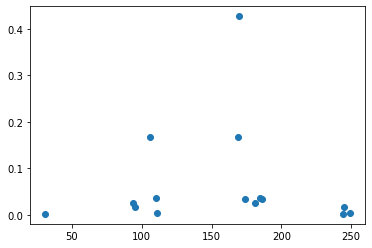

In [264]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [265]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((int(2*l)+1,int(2*l)+1),dtype = complex)
    sigma[int(2*l)-i][int(2*l)-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[int(2*l)-j][int(2*l)-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l)+1))
    else:
        tensprod = sparse.identity(int(2*l)+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l)+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l)+1))
    return tensprod


def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((int(2*l+1),int(2*l+1)),dtype = complex)
    sigma[int(2*l)-i][int(2*l)-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[int(2*l)-j][int(2*l)-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))    
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l+1)))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(int(2*l+1))
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l+1)))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(int(2*l+1)))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k+1,L):
            summe += 1./(2-(k+kk)%2)*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)



def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


In [266]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [272]:
import optuna
n_iter = 4500
theta = np.zeros(7*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[7*i+0] = trial.suggest_float("7*"+str(i)+"+"+str(0), -4*np.pi, 4*np.pi)
        for j in range(1,7):
            theta[7*i+j] = trial.suggest_float("7*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[7*i+0])@psi_var
        psi_var = rot_sigma(0,2,3,0,theta[7*i+3])@rot_sigma(0,0,2,0,theta[7*i+2])@rot_sigma(0,0,1,0,theta[7*i+1])@psi_var
        psi_var = rot_sigma(3,2,3,0,theta[7*i+3])@rot_sigma(3,0,2,0,theta[7*i+2])@rot_sigma(3,0,1,0,theta[7*i+1])@psi_var
        psi_var = rot_sigma(1,2,3,0,theta[7*i+6])@rot_sigma(1,0,2,0,theta[7*i+5])@rot_sigma(1,0,1,0,theta[7*i+4])@psi_var
        psi_var = rot_sigma(2,2,3,0,theta[7*i+6])@rot_sigma(2,0,2,0,theta[7*i+5])@rot_sigma(2,0,1,0,theta[7*i+4])@psi_var


    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-24 17:58:08,776] A new study created in memory with name: no-name-455ac675-3f57-45a3-ab14-441dbe911ee8
[I 2022-05-24 17:58:08,971] Trial 0 finished with value: 58.96389852727435 and parameters: {'7*0+0': 7.908326821570913, '7*0+1': 0.4366778868737864, '7*0+2': 3.3116914350144224, '7*0+3': 1.4767211641278895, '7*0+4': -4.208488969338751, '7*0+5': 5.717202092878319, '7*0+6': 3.6801795671349, '7*1+0': 2.753955861084897, '7*1+1': 6.024928803471388, '7*1+2': 3.832234329857652, '7*1+3': 4.503370572277623, '7*1+4': 1.1859731640934603, '7*1+5': -1.877239319078999, '7*1+6': 5.186138956545978, '7*2+0': -9.155129132710263, '7*2+1': 2.9988890212483934, '7*2+2': -1.1227201479208295, '7*2+3': 5.740418285917965, '7*2+4': 0.9536977339254413, '7*2+5': 0.7506538318415856, '7*2+6': -5.077216056071553, '7*3+0': -1.8110309400995774, '7*3+1': -1.8012770648129655, '7*3+2': -3.0015384953051996, '7*3+3': 3.679377276318359, '7*3+4': -4.230146616837859, '7*3+5': 1.734877521699877, '7*3+6': 3.784898234

[I 2022-05-24 17:58:10,596] Trial 9 finished with value: 62.6515363921041 and parameters: {'7*0+0': -1.8806698835891875, '7*0+1': 2.6301537194245697, '7*0+2': -0.4987756141514362, '7*0+3': 2.644753787705519, '7*0+4': 1.6945057085376671, '7*0+5': -1.2853677654790476, '7*0+6': 2.466834107847611, '7*1+0': -0.30611619519444133, '7*1+1': -0.7356585928139123, '7*1+2': 0.7278289226725762, '7*1+3': -2.339521019931358, '7*1+4': -0.6835043054116718, '7*1+5': -1.5740996897756254, '7*1+6': -2.6375171592989095, '7*2+0': 2.1274734399502346, '7*2+1': -2.4327228542271375, '7*2+2': -0.6406116762189973, '7*2+3': 0.4228514684763451, '7*2+4': 0.6996673367426368, '7*2+5': -1.5793965264423508, '7*2+6': 5.249256376378027, '7*3+0': -0.42408763725552906, '7*3+1': -3.088284091301696, '7*3+2': -0.746605009691688, '7*3+3': 2.9442531105350094, '7*3+4': 0.7457304992025261, '7*3+5': 6.013889677666779, '7*3+6': -2.735853300282413}. Best is trial 5 with value: 57.78630765520071.
[I 2022-05-24 17:58:10,781] Trial 10 fi

[I 2022-05-24 17:58:12,225] Trial 18 finished with value: 64.03685251627432 and parameters: {'7*0+0': 3.87807662447249, '7*0+1': -0.6659198641120969, '7*0+2': 0.18683104900636205, '7*0+3': -1.237150048739581, '7*0+4': -1.8733257674597583, '7*0+5': -0.8303227646352229, '7*0+6': 2.066744803715185, '7*1+0': 2.30227460815921, '7*1+1': 3.2712358736810847, '7*1+2': 0.2991103029271345, '7*1+3': 2.3394642571942006, '7*1+4': 1.5536061673943133, '7*1+5': -1.1084627114716539, '7*1+6': 3.5461598531142364, '7*2+0': 1.1222791158715157, '7*2+1': -2.8098060129321594, '7*2+2': -2.3803112280659002, '7*2+3': -1.1947390897080858, '7*2+4': -1.5737885135789889, '7*2+5': 0.48475015040761593, '7*2+6': 0.06716356314731176, '7*3+0': 5.087516074976189, '7*3+1': -2.2651666243204067, '7*3+2': 3.120327152500923, '7*3+3': -0.6840504251690359, '7*3+4': 2.2097525971780483, '7*3+5': 0.20206918182425976, '7*3+6': -1.47643514750522}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:12,410] Trial 19 fi

[I 2022-05-24 17:58:13,942] Trial 27 finished with value: 69.01151766050293 and parameters: {'7*0+0': -4.573231158287452, '7*0+1': 1.3021006956789154, '7*0+2': -4.290102324772967, '7*0+3': -3.9704207942115675, '7*0+4': 1.0761985280745259, '7*0+5': -0.3691859150805351, '7*0+6': 0.9487571454189445, '7*1+0': -3.8843876304784537, '7*1+1': 0.706677823666316, '7*1+2': -4.789893245075012, '7*1+3': 3.2220182476030805, '7*1+4': 5.865184575957674, '7*1+5': -2.4917545301533632, '7*1+6': 0.9426040755908134, '7*2+0': 2.567564005922057, '7*2+1': -1.190879040774346, '7*2+2': -2.25538671052163, '7*2+3': -2.729414480325983, '7*2+4': 0.8794335680461778, '7*2+5': 1.7104380099241017, '7*2+6': -1.96065936606352, '7*3+0': -3.313326206628113, '7*3+1': -4.8535690538839935, '7*3+2': 2.3183614665397196, '7*3+3': 2.3725274299598373, '7*3+4': -0.9065596786028369, '7*3+5': 1.9688241790381773, '7*3+6': -1.119113312080197}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:14,125] Trial 28 finishe

[I 2022-05-24 17:58:15,711] Trial 36 finished with value: 59.331737216957805 and parameters: {'7*0+0': -2.067134646017057, '7*0+1': 2.007620279211089, '7*0+2': -1.2117118469334285, '7*0+3': 1.644778114529242, '7*0+4': 1.599486647496455, '7*0+5': -2.826802807729017, '7*0+6': 0.22821282455839897, '7*1+0': -0.8220410366556801, '7*1+1': -1.1159313540383717, '7*1+2': -1.2092595034907243, '7*1+3': 1.7113986556118477, '7*1+4': 4.570535090773417, '7*1+5': 1.805751496663317, '7*1+6': -2.924747587384772, '7*2+0': 0.9353959318818299, '7*2+1': -0.3476885903223792, '7*2+2': 5.147358960312869, '7*2+3': -1.1981419325646148, '7*2+4': 0.04066181977344785, '7*2+5': -2.852508470933528, '7*2+6': -1.6017935719104355, '7*3+0': 2.230540128117823, '7*3+1': -4.102236133334758, '7*3+2': -0.0714536398098099, '7*3+3': -1.1075362126927029, '7*3+4': 0.60707053113933, '7*3+5': 0.8223836652045241, '7*3+6': -0.3764763495568445}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:15,947] Trial 37 fini

[I 2022-05-24 17:58:17,597] Trial 45 finished with value: 142.80850341994062 and parameters: {'7*0+0': -0.6270568818360098, '7*0+1': 2.458924520686673, '7*0+2': 0.06468963832164121, '7*0+3': -1.5497437370959575, '7*0+4': 0.4984535266514098, '7*0+5': 0.3533599285600544, '7*0+6': -2.4593647513331676, '7*1+0': 1.37350997802968, '7*1+1': -1.2187406821000482, '7*1+2': -2.04014554678051, '7*1+3': 0.6168027315709042, '7*1+4': 1.653853589684355, '7*1+5': -3.0995096489761744, '7*1+6': 1.4867283451568332, '7*2+0': -1.8372852914248312, '7*2+1': -2.9110550436730698, '7*2+2': 1.5409857527984623, '7*2+3': 0.15956015406591217, '7*2+4': 0.37859215691250203, '7*2+5': 2.9585659137549998, '7*2+6': -2.2304861028788623, '7*3+0': 0.6998651708932014, '7*3+1': -3.4700359452528864, '7*3+2': 2.295552617558668, '7*3+3': 1.9013269183172925, '7*3+4': 0.9235909356771539, '7*3+5': -4.848644483894235, '7*3+6': 3.5022724421702}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:17,775] Trial 46 fini

[I 2022-05-24 17:58:19,218] Trial 54 finished with value: 53.29472366982098 and parameters: {'7*0+0': 0.819925716908928, '7*0+1': -2.72513413105937, '7*0+2': -3.9395201473712715, '7*0+3': -4.403881311798882, '7*0+4': 0.08914883272427687, '7*0+5': 1.6369640941975219, '7*0+6': -0.6367833290805449, '7*1+0': 2.173122738200906, '7*1+1': -2.151138302659212, '7*1+2': -1.9169808061893086, '7*1+3': 1.8215539860174643, '7*1+4': 1.1998539889810822, '7*1+5': 2.7183550304640733, '7*1+6': 1.4344967367951955, '7*2+0': -1.8008174699079393, '7*2+1': -4.176796986522451, '7*2+2': 0.9952079451945245, '7*2+3': -0.7943348532137756, '7*2+4': 1.3277864795982814, '7*2+5': 0.769632844004076, '7*2+6': 0.783973995739565, '7*3+0': -1.099982829006513, '7*3+1': -4.131622684051056, '7*3+2': -2.2383759227560036, '7*3+3': 0.19155604176514185, '7*3+4': -1.4640827548108915, '7*3+5': 0.20655254410328505, '7*3+6': -1.0131657504874856}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:19,384] Trial 55 fi

[I 2022-05-24 17:58:20,838] Trial 63 finished with value: 52.295194905270364 and parameters: {'7*0+0': -2.902313911832578, '7*0+1': -1.8132784960764035, '7*0+2': 0.9543263652488557, '7*0+3': -3.4314679430517003, '7*0+4': 1.7639615158527764, '7*0+5': -0.18208876179199995, '7*0+6': -1.1192037082828314, '7*1+0': -0.7369049360619215, '7*1+1': -0.5076884234134, '7*1+2': -4.298831161087596, '7*1+3': -0.4170088343383549, '7*1+4': 4.023135275206652, '7*1+5': -1.9437688200656955, '7*1+6': -1.5477340685219538, '7*2+0': -0.37322922361636196, '7*2+1': -2.3864875907992196, '7*2+2': 3.483487938689887, '7*2+3': 1.514252251643081, '7*2+4': 3.3959717134429805, '7*2+5': 3.8111866905646847, '7*2+6': -3.229495570309835, '7*3+0': -1.3201973599508126, '7*3+1': -4.4142933644553155, '7*3+2': -0.5570712266524437, '7*3+3': -3.2590906524033, '7*3+4': -1.728212256426183, '7*3+5': -4.040681136204558, '7*3+6': -2.162178832410726}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:21,070] Trial 64

[I 2022-05-24 17:58:22,571] Trial 72 finished with value: 51.82088715857995 and parameters: {'7*0+0': -3.342209533342197, '7*0+1': -0.47046571310458085, '7*0+2': 0.497621851148069, '7*0+3': -5.1377813368121785, '7*0+4': -1.4572003557196749, '7*0+5': 1.1673192766980935, '7*0+6': 1.2609468621825761, '7*1+0': 0.7966603417053357, '7*1+1': -1.0710998169199992, '7*1+2': -1.5234476206780476, '7*1+3': 1.0753576249746424, '7*1+4': -0.2726283901934603, '7*1+5': 0.6491013908554677, '7*1+6': -1.5177994433371074, '7*2+0': -1.3710314952578182, '7*2+1': -2.917524743517834, '7*2+2': -0.13732908380579034, '7*2+3': 1.9837440206939343, '7*2+4': -0.3019207877181067, '7*2+5': 3.600614876898943, '7*2+6': 2.335108847241676, '7*3+0': -1.7789972385567567, '7*3+1': -1.507855643099604, '7*3+2': -2.4674580185597, '7*3+3': 1.3410983676396449, '7*3+4': -1.6140100756680862, '7*3+5': -1.915835757219264, '7*3+6': -3.848569246111496}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:22,786] Trial 73

[I 2022-05-24 17:58:24,212] Trial 81 finished with value: 53.47482997067101 and parameters: {'7*0+0': -2.0236504058555798, '7*0+1': -1.4498832435066116, '7*0+2': -3.1739077484550253, '7*0+3': -4.675008282619752, '7*0+4': -0.7358340416649809, '7*0+5': 1.5471293907671682, '7*0+6': -3.7436606829043857, '7*1+0': -1.6154001065936525, '7*1+1': -0.7920473952828069, '7*1+2': -1.8717739613823143, '7*1+3': 3.210560826043856, '7*1+4': 3.752919035539758, '7*1+5': 2.473000529125293, '7*1+6': -2.9830117437596257, '7*2+0': -2.0529058481477387, '7*2+1': -3.5991254633180807, '7*2+2': 0.7530779982173309, '7*2+3': 1.017258922049236, '7*2+4': 0.5252403579773969, '7*2+5': 0.25914634797325453, '7*2+6': 1.2084528535418357, '7*3+0': 1.461873653415715, '7*3+1': -2.819067203162904, '7*3+2': 1.4660485298966015, '7*3+3': -2.1760073121893098, '7*3+4': -2.3841306867073246, '7*3+5': -2.372639153346489, '7*3+6': -0.30157826838462576}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:24,388] Trial 

[I 2022-05-24 17:58:26,107] Trial 90 finished with value: 75.42356839639334 and parameters: {'7*0+0': -0.2069568934960242, '7*0+1': -2.549451321952396, '7*0+2': 0.018703423228959792, '7*0+3': -3.886802111419138, '7*0+4': -3.5517218252747282, '7*0+5': 0.7939614012887714, '7*0+6': -2.1751306598373064, '7*1+0': -2.670118221912653, '7*1+1': -0.007650051367958266, '7*1+2': -1.1324651150406613, '7*1+3': 2.6346621368627647, '7*1+4': 3.2226988782180093, '7*1+5': -2.4258040687357534, '7*1+6': -2.230668792465904, '7*2+0': -1.3128144770093517, '7*2+1': -0.38499463679686885, '7*2+2': -0.20635281404565387, '7*2+3': 1.2650693006166245, '7*2+4': -1.445821548826927, '7*2+5': -0.5610410132616497, '7*2+6': 2.606069846027132, '7*3+0': -2.5999041663927116, '7*3+1': -5.632331199883525, '7*3+2': -1.9845993525635404, '7*3+3': 0.22061882473342864, '7*3+4': -0.17047351077003414, '7*3+5': -1.6090808307889244, '7*3+6': -1.5140515060035813}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:26,

[I 2022-05-24 17:58:28,336] Trial 99 finished with value: 67.42520304534375 and parameters: {'7*0+0': -0.11916813698622675, '7*0+1': -1.5556143175879416, '7*0+2': -2.078904658837724, '7*0+3': -3.186735380497838, '7*0+4': -0.5797096544630689, '7*0+5': -0.4411814130922789, '7*0+6': -3.495466903272852, '7*1+0': 0.6872982104693912, '7*1+1': -1.6801930659152498, '7*1+2': -0.7526543369900542, '7*1+3': 3.1289871145488943, '7*1+4': 3.2665365729782634, '7*1+5': 0.09892336102408583, '7*1+6': -2.1629295802608803, '7*2+0': -3.7742054435171966, '7*2+1': -1.4612772280536175, '7*2+2': 1.9637504077187304, '7*2+3': 4.054100862016148, '7*2+4': 1.188967207104888, '7*2+5': -2.1001547421625983, '7*2+6': 0.10281184529164378, '7*3+0': 0.4416883458465234, '7*3+1': -3.169090164898157, '7*3+2': 1.8588724882940464, '7*3+3': -1.7581733620663318, '7*3+4': -0.732825940356604, '7*3+5': -5.208936266280105, '7*3+6': -1.0436998278363852}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:28,540] Tria

[I 2022-05-24 17:58:29,950] Trial 108 finished with value: 46.45126269777296 and parameters: {'7*0+0': -1.2505183460282159, '7*0+1': -3.3755433550351115, '7*0+2': -3.8738498186526487, '7*0+3': -5.149415961254665, '7*0+4': 0.2576634308495749, '7*0+5': -2.66268084532015, '7*0+6': -4.957042617115179, '7*1+0': -0.593576384883385, '7*1+1': -0.5356358788226852, '7*1+2': 3.349218552481598, '7*1+3': -0.9408790662739854, '7*1+4': 3.49754819585176, '7*1+5': -1.5042019496888166, '7*1+6': -0.47831512646756913, '7*2+0': 2.910001023084562, '7*2+1': -0.4454310710891187, '7*2+2': 1.2589612207737464, '7*2+3': 2.826114132037314, '7*2+4': 2.241122567456145, '7*2+5': 2.714674136550807, '7*2+6': -1.0433492091847731, '7*3+0': 1.9211131053786086, '7*3+1': -3.1148262031608978, '7*3+2': -2.133085100802334, '7*3+3': -2.986375138871521, '7*3+4': -0.715303304424673, '7*3+5': -0.8058557969689613, '7*3+6': -0.6791863189058116}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:30,119] Trial 109 f

[I 2022-05-24 17:58:31,521] Trial 117 finished with value: 35.66790976641906 and parameters: {'7*0+0': -2.893752277501783, '7*0+1': -5.637406001064055, '7*0+2': -3.0835647208807093, '7*0+3': -1.6568764218386547, '7*0+4': 0.2680342242968007, '7*0+5': 0.40875239890968074, '7*0+6': -1.942025143516874, '7*1+0': -0.5547135604401581, '7*1+1': -1.6995492629204962, '7*1+2': -1.881110109104667, '7*1+3': 2.8731328674846632, '7*1+4': 5.253084839072626, '7*1+5': 1.6110964434767387, '7*1+6': -2.4926364227485918, '7*2+0': -0.49837073342013816, '7*2+1': -2.91010687071455, '7*2+2': -0.7923944811308152, '7*2+3': 2.746301681495928, '7*2+4': 0.45971724431791805, '7*2+5': 2.597643949130915, '7*2+6': -0.995766951432782, '7*3+0': 1.1625004616363332, '7*3+1': -2.9159745770252306, '7*3+2': -0.507355954550245, '7*3+3': -1.567558988669512, '7*3+4': -0.07662221795018587, '7*3+5': -0.2020724138544372, '7*3+6': -0.9190994226057332}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:31,724] Trial

[I 2022-05-24 17:58:33,178] Trial 126 finished with value: 49.00987336392311 and parameters: {'7*0+0': -4.522224576584265, '7*0+1': -4.5324674791601645, '7*0+2': -2.638097600796568, '7*0+3': -1.2227398139118644, '7*0+4': -0.06828978967217132, '7*0+5': 3.2485782140497617, '7*0+6': -2.376899372928995, '7*1+0': -1.5629060189442523, '7*1+1': -1.6221491720515684, '7*1+2': -1.0341541979408502, '7*1+3': 2.2078160675461302, '7*1+4': 5.375480824380963, '7*1+5': 0.3264027155259275, '7*1+6': -1.5351604100320342, '7*2+0': 0.8473164327204449, '7*2+1': -0.27412293700143486, '7*2+2': 2.98501961844888, '7*2+3': 0.7489682566612101, '7*2+4': 0.2128072278546831, '7*2+5': 3.0404275180101674, '7*2+6': -0.4006686913079792, '7*3+0': 1.175835086149576, '7*3+1': -1.0347752492256292, '7*3+2': -1.9537210619104743, '7*3+3': -3.2655525044962155, '7*3+4': -2.3431598531784497, '7*3+5': -3.2958713306529663, '7*3+6': -0.7242083062344385}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:33,353] Tri

[I 2022-05-24 17:58:34,770] Trial 135 finished with value: 63.51198363376825 and parameters: {'7*0+0': -8.465706258769451, '7*0+1': -1.9026833058852548, '7*0+2': -5.831221415328395, '7*0+3': -4.566350622529502, '7*0+4': 1.2547009235686892, '7*0+5': 3.2261747013448776, '7*0+6': -1.1426671331747968, '7*1+0': 0.5374685996273431, '7*1+1': -1.1248634522175354, '7*1+2': -4.568855881684354, '7*1+3': 1.190114890732061, '7*1+4': 3.7766861761934, '7*1+5': 2.430431211967884, '7*1+6': -4.256509834212792, '7*2+0': -0.06605911238547191, '7*2+1': -2.4069884617316566, '7*2+2': 3.6841585639832983, '7*2+3': 0.4309366779731947, '7*2+4': -1.2217933012776463, '7*2+5': 5.883143738564623, '7*2+6': 0.4005727829631024, '7*3+0': 2.991595814256663, '7*3+1': -0.8846430939716734, '7*3+2': -4.545166465392105, '7*3+3': -4.439317202790865, '7*3+4': 1.0887828732513738, '7*3+5': -1.5596939514267327, '7*3+6': -2.3648456521111685}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:34,943] Trial 136 fin

[I 2022-05-24 17:58:36,311] Trial 144 finished with value: 37.91702444324818 and parameters: {'7*0+0': -4.623135003504248, '7*0+1': -3.877979306307219, '7*0+2': -3.159651888594058, '7*0+3': -0.4545061047387322, '7*0+4': 2.3943111292821477, '7*0+5': 1.0699975395484485, '7*0+6': -3.2621155508178243, '7*1+0': 0.7183368804528762, '7*1+1': 0.0781198459764414, '7*1+2': -4.847090983882774, '7*1+3': 0.5977237081917457, '7*1+4': 3.1419501747302534, '7*1+5': 0.7364441032197689, '7*1+6': -0.24965954534336243, '7*2+0': 1.049819575853649, '7*2+1': 1.2965232014236157, '7*2+2': 4.168282803788584, '7*2+3': 3.2694020613057844, '7*2+4': -0.7893255271142418, '7*2+5': 0.078086585260015, '7*2+6': 1.7595093519690579, '7*3+0': 0.39263833465964004, '7*3+1': -4.284620829888998, '7*3+2': -1.7285423132060518, '7*3+3': -0.13357500787152654, '7*3+4': 0.3306201103426205, '7*3+5': -3.208678253729019, '7*3+6': -1.6870646786300656}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:36,515] Trial 145

[I 2022-05-24 17:58:37,889] Trial 153 finished with value: 77.20329940981708 and parameters: {'7*0+0': -6.579102865903025, '7*0+1': -5.757992437268793, '7*0+2': -2.712688913481981, '7*0+3': -0.5421924592031401, '7*0+4': 3.2565115342936397, '7*0+5': 2.72355318833356, '7*0+6': -4.589060764210084, '7*1+0': 2.4946235793565394, '7*1+1': -3.247873247992096, '7*1+2': -2.9588365486798485, '7*1+3': -0.24316832938651384, '7*1+4': 3.2000084927962624, '7*1+5': 4.748863345040723, '7*1+6': -1.6627439396029127, '7*2+0': -0.19199813005849975, '7*2+1': -1.5638691765258603, '7*2+2': 1.3026754881540676, '7*2+3': 2.393474507002701, '7*2+4': 0.4578784734150836, '7*2+5': 2.88844811590163, '7*2+6': -2.4402492377875893, '7*3+0': 3.483657001997289, '7*3+1': -1.4323450671658582, '7*3+2': -4.386213550456869, '7*3+3': -2.7764431356877752, '7*3+4': 1.2343210415321593, '7*3+5': -1.6211962174376189, '7*3+6': -2.2629267760938356}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:38,072] Trial 154 

[I 2022-05-24 17:58:39,514] Trial 162 finished with value: 65.1516417920762 and parameters: {'7*0+0': -3.4342764852330268, '7*0+1': -2.4039204413962123, '7*0+2': -2.838302407945105, '7*0+3': -1.196715568999315, '7*0+4': 0.6254669605220525, '7*0+5': -0.10195698964434219, '7*0+6': -2.4955333941242857, '7*1+0': -2.775830768880145, '7*1+1': -1.994345162730694, '7*1+2': -2.913745118522454, '7*1+3': -1.558000841864315, '7*1+4': 4.446660492831548, '7*1+5': 2.5778536783719477, '7*1+6': -2.7809476947200524, '7*2+0': 3.640697859507498, '7*2+1': -2.5120215693724206, '7*2+2': 3.961117428294983, '7*2+3': 2.6519830240990854, '7*2+4': 1.841078264603049, '7*2+5': 2.7118979849365497, '7*2+6': 0.7113300970608274, '7*3+0': 1.1721078488797096, '7*3+1': -3.158900572177315, '7*3+2': -4.192757237309675, '7*3+3': 0.013419122292920527, '7*3+4': -0.02674098756830312, '7*3+5': -2.634471385038529, '7*3+6': -4.016604755990447}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:39,694] Trial 163 

[I 2022-05-24 17:58:41,379] Trial 171 finished with value: 62.28988768649382 and parameters: {'7*0+0': -6.828438859818489, '7*0+1': -5.044708561936771, '7*0+2': -1.8274561318209432, '7*0+3': -0.2737558465809935, '7*0+4': -1.2650025970406333, '7*0+5': 1.452799033743115, '7*0+6': -1.0854436238776461, '7*1+0': -3.7987781594686725, '7*1+1': -0.6297050720805544, '7*1+2': -2.4656988016453343, '7*1+3': 0.5857886239650449, '7*1+4': 3.5441226148150986, '7*1+5': 3.226601919236616, '7*1+6': -3.75997896037519, '7*2+0': 1.6210836005668308, '7*2+1': 2.320436672026151, '7*2+2': 3.600792223674835, '7*2+3': 3.213494352338927, '7*2+4': 1.1812503328998822, '7*2+5': 0.6804815887495961, '7*2+6': -0.7017333537426258, '7*3+0': 0.21397500826594662, '7*3+1': -0.6510140743888768, '7*3+2': -1.7024888074424154, '7*3+3': -1.6071455991094195, '7*3+4': -1.048688210577883, '7*3+5': -3.4515656608172356, '7*3+6': -4.765146592648885}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:41,590] Trial 172

[I 2022-05-24 17:58:43,105] Trial 180 finished with value: 63.291185345982164 and parameters: {'7*0+0': -5.758804017277674, '7*0+1': -5.577199798856381, '7*0+2': -0.1756575543752552, '7*0+3': -1.1108951365610256, '7*0+4': 2.0269768789099354, '7*0+5': 2.8577194135767225, '7*0+6': -4.592839718970056, '7*1+0': -1.352224601802353, '7*1+1': -2.487947848054512, '7*1+2': -3.4001566426048484, '7*1+3': 3.4714128826350192, '7*1+4': 4.054886860126892, '7*1+5': 5.293753451245697, '7*1+6': -2.3469597939915934, '7*2+0': -0.6067312508048238, '7*2+1': 0.32263962355655845, '7*2+2': 3.0108526763646637, '7*2+3': -0.5307604376759727, '7*2+4': 3.0195639610188887, '7*2+5': 0.9734790404210337, '7*2+6': 2.5385952718775284, '7*3+0': 2.095416838573302, '7*3+1': -1.5123646011529572, '7*3+2': 0.5899502534288179, '7*3+3': -0.050995875141496005, '7*3+4': -2.450842389639871, '7*3+5': -3.387394335283776, '7*3+6': -1.9024629276549203}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:43,278] Trial 

[I 2022-05-24 17:58:44,682] Trial 189 finished with value: 51.84716782017071 and parameters: {'7*0+0': -2.508899245532451, '7*0+1': -2.621753518234779, '7*0+2': -1.5273127273974043, '7*0+3': 0.9236603070832026, '7*0+4': 1.8568711841543182, '7*0+5': 2.029143678294086, '7*0+6': 0.37263245493925723, '7*1+0': -3.914771692844748, '7*1+1': -1.7791909103367, '7*1+2': -2.3891420469801083, '7*1+3': -0.10101702413891822, '7*1+4': 1.3877855541939645, '7*1+5': 2.9501816047375744, '7*1+6': -0.6164389246584736, '7*2+0': -2.807738451381648, '7*2+1': -2.339868752277207, '7*2+2': -0.2268674690957373, '7*2+3': 2.209553504116602, '7*2+4': 1.8152872751489684, '7*2+5': 2.819548100693957, '7*2+6': 1.4631266804980134, '7*3+0': 1.9092518736962152, '7*3+1': -2.1151156851209834, '7*3+2': -3.1181164572848363, '7*3+3': -0.40642693845785083, '7*3+4': -2.88691149377759, '7*3+5': 0.7101376524241951, '7*3+6': -4.604905468607736}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:44,867] Trial 190 f

[I 2022-05-24 17:58:46,261] Trial 198 finished with value: 40.34016970820781 and parameters: {'7*0+0': -4.030068284006796, '7*0+1': 0.315755954461693, '7*0+2': -2.691490420609135, '7*0+3': -0.8366890435150577, '7*0+4': -2.2515963258800595, '7*0+5': 4.448374131089366, '7*0+6': 0.028655127604966246, '7*1+0': -5.202477196887485, '7*1+1': -1.0774608623560535, '7*1+2': -5.849719735819471, '7*1+3': 0.42277324319420406, '7*1+4': 3.8268233939806384, '7*1+5': 2.6298866691380396, '7*1+6': -3.274144863481053, '7*2+0': -3.5027385467846806, '7*2+1': -1.943707596580181, '7*2+2': 4.804452390991743, '7*2+3': 2.630938605731756, '7*2+4': 0.47711047872783646, '7*2+5': 4.766807766296855, '7*2+6': 1.1372209624961291, '7*3+0': -0.48390402319413184, '7*3+1': -1.2419439726247263, '7*3+2': -1.3621240201709635, '7*3+3': 3.3464768001454006, '7*3+4': -2.6928077071971543, '7*3+5': -4.714606310224907, '7*3+6': -0.02705190874229846}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:46,440] Trial 

[I 2022-05-24 17:58:47,928] Trial 207 finished with value: 60.26787121047334 and parameters: {'7*0+0': -1.716196426444304, '7*0+1': -2.819853949944777, '7*0+2': -3.179839609284746, '7*0+3': -2.111499545694535, '7*0+4': 0.6929708788014141, '7*0+5': 3.2300141200995673, '7*0+6': -1.8408135552663623, '7*1+0': -1.9469406967009055, '7*1+1': -4.801952832833983, '7*1+2': -6.018303327314025, '7*1+3': 0.7876721600280485, '7*1+4': 5.11628961332428, '7*1+5': 2.585260556012609, '7*1+6': -3.848033042147455, '7*2+0': -1.772254137288134, '7*2+1': -0.12100850729327622, '7*2+2': 2.732026701272383, '7*2+3': 3.9923264165847074, '7*2+4': -0.8973741923815284, '7*2+5': 3.6859460575560825, '7*2+6': -0.26150387106967843, '7*3+0': 5.271109218485609, '7*3+1': -2.3980401334110732, '7*3+2': -3.995769445146811, '7*3+3': -0.4216026385868469, '7*3+4': 0.20811721107834247, '7*3+5': -2.2538713941020476, '7*3+6': -2.8180903748950272}. Best is trial 14 with value: 24.973066873968946.
[I 2022-05-24 17:58:48,121] Trial 208

[I 2022-05-24 17:58:49,658] Trial 216 finished with value: 59.286109262012715 and parameters: {'7*0+0': -4.267256963372888, '7*0+1': -3.653163227155365, '7*0+2': -5.218597732352023, '7*0+3': 0.5737765868843042, '7*0+4': -0.7140424525672351, '7*0+5': 3.992022783419262, '7*0+6': -2.2770826130071957, '7*1+0': -0.6376503592064324, '7*1+1': 2.681365202162028, '7*1+2': -3.8569372281406054, '7*1+3': 1.0224840390403147, '7*1+4': 3.096763390955539, '7*1+5': 1.1773880975430435, '7*1+6': -1.5778632493235953, '7*2+0': -1.027947421215099, '7*2+1': -1.7526138751954803, '7*2+2': 5.701761463893666, '7*2+3': 5.578647071547525, '7*2+4': 1.3090598708263201, '7*2+5': 4.054260199667719, '7*2+6': 1.3041482061042933, '7*3+0': 1.8365719163323435, '7*3+1': 0.7051370085829777, '7*3+2': -1.351364141110928, '7*3+3': 1.1919148978807257, '7*3+4': -3.3260013392729086, '7*3+5': -2.671983766409903, '7*3+6': -3.189615801033502}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:49,835] Trial 217 fin

[I 2022-05-24 17:58:51,263] Trial 225 finished with value: 54.562361066556434 and parameters: {'7*0+0': -5.598401117851125, '7*0+1': -0.903249851998692, '7*0+2': -0.21694318376645594, '7*0+3': -3.3699570315585534, '7*0+4': -1.4766882294038752, '7*0+5': 3.113246971170721, '7*0+6': -2.7154509023927105, '7*1+0': -0.5214796946657145, '7*1+1': -0.9925838715612652, '7*1+2': -4.147796316603644, '7*1+3': -1.3382744007337786, '7*1+4': 4.585325971665769, '7*1+5': 1.9401187642151008, '7*1+6': -0.6543814526732423, '7*2+0': -1.6113690443279016, '7*2+1': -4.22163989893184, '7*2+2': 3.837959241300284, '7*2+3': 3.6011257983981864, '7*2+4': 0.6433209011558703, '7*2+5': 1.5553327671699113, '7*2+6': 3.9312180582833567, '7*3+0': -1.977098605423837, '7*3+1': -1.1748824350023934, '7*3+2': -2.9635858963184853, '7*3+3': -0.10035528794250914, '7*3+4': -4.559478967063731, '7*3+5': -1.710505399506943, '7*3+6': -3.0455369406861625}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:51,437] Tri

[I 2022-05-24 17:58:52,839] Trial 234 finished with value: 41.694888938589834 and parameters: {'7*0+0': -4.367553056728344, '7*0+1': -2.7098499074396347, '7*0+2': -3.920038488903007, '7*0+3': -2.897358868216746, '7*0+4': -4.94663638308342, '7*0+5': 4.965858289010786, '7*0+6': -1.232506417530495, '7*1+0': -2.080677647956191, '7*1+1': 0.2501898684215917, '7*1+2': -3.762718494838715, '7*1+3': -0.6063578107946317, '7*1+4': 5.66728420294381, '7*1+5': 0.3157364126743847, '7*1+6': -1.4352148715536752, '7*2+0': -1.302814049672054, '7*2+1': -2.4450916505253613, '7*2+2': 2.4293722422759334, '7*2+3': 4.0549240771065485, '7*2+4': 3.0390646049305925, '7*2+5': 1.785776210256521, '7*2+6': 1.5802165621116595, '7*3+0': -0.9372120595912166, '7*3+1': -3.3523480917416255, '7*3+2': -5.844358533843779, '7*3+3': 0.22516657864413148, '7*3+4': -4.480118753780674, '7*3+5': -1.9721833056895561, '7*3+6': -4.3170748945053985}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:53,017] Trial 235 

[I 2022-05-24 17:58:54,655] Trial 243 finished with value: 52.75438088275825 and parameters: {'7*0+0': -3.884973435853342, '7*0+1': -0.5197782347329201, '7*0+2': -0.6796902892411496, '7*0+3': -3.6317092897004395, '7*0+4': -1.6781529954714745, '7*0+5': 1.797799865757038, '7*0+6': -2.2270702226061028, '7*1+0': -2.67383617898869, '7*1+1': 0.48648153615879147, '7*1+2': -2.9800307260129855, '7*1+3': -1.20586003189727, '7*1+4': 2.523865903331722, '7*1+5': 3.487008125616502, '7*1+6': -3.8132332977765238, '7*2+0': 0.6240889806763793, '7*2+1': -1.9039164839732234, '7*2+2': 4.008933094889353, '7*2+3': 1.5250496692501945, '7*2+4': 0.8537681410740452, '7*2+5': 1.1813279750623007, '7*2+6': 3.1658091716833785, '7*3+0': 2.1653328285659468, '7*3+1': -3.1790537206309564, '7*3+2': -2.665036088217877, '7*3+3': 1.1576507163790697, '7*3+4': -3.4671207468450134, '7*3+5': -3.2735076197911486, '7*3+6': -1.2690685645985926}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:54,832] Trial 24

[I 2022-05-24 17:58:56,278] Trial 252 finished with value: 92.97542782234623 and parameters: {'7*0+0': -3.2414990678082107, '7*0+1': -1.914478433933631, '7*0+2': -1.2625653523653135, '7*0+3': -2.27561275148177, '7*0+4': -3.5681595831775565, '7*0+5': 5.528769576027063, '7*0+6': -0.607634448383749, '7*1+0': -1.4462024687974717, '7*1+1': 0.1511093916313187, '7*1+2': -2.2810497955725704, '7*1+3': -5.918247773373601, '7*1+4': 1.7600007506114934, '7*1+5': -0.02238928578962396, '7*1+6': 0.5102076862726364, '7*2+0': 0.22170409725601375, '7*2+1': -3.597860497954584, '7*2+2': 2.352297064812711, '7*2+3': 3.947424659457373, '7*2+4': 1.2078804061429484, '7*2+5': 0.6501059937829442, '7*2+6': 2.033049232323319, '7*3+0': -0.21297114768669323, '7*3+1': -4.340036533604649, '7*3+2': -3.064372504506488, '7*3+3': 1.1877165691882428, '7*3+4': -2.626170735269209, '7*3+5': -4.478452205880599, '7*3+6': -0.9071666771238076}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:56,454] Trial 253

[I 2022-05-24 17:58:57,876] Trial 261 finished with value: 79.37208574753443 and parameters: {'7*0+0': -5.432162350428183, '7*0+1': -3.439635974702025, '7*0+2': -1.5182063037287792, '7*0+3': -0.29916975902663, '7*0+4': -0.7443447515968498, '7*0+5': 5.181013489971299, '7*0+6': -1.0477925094231555, '7*1+0': -2.8792622006165223, '7*1+1': -0.7321153210073676, '7*1+2': -1.4149696007039885, '7*1+3': -2.898760777214846, '7*1+4': 3.508657639118418, '7*1+5': 4.501634467387503, '7*1+6': -1.523589101786877, '7*2+0': 2.30728571788287, '7*2+1': -2.2107893121285773, '7*2+2': 3.7544263599646137, '7*2+3': 4.860412285968168, '7*2+4': -2.091531846615561, '7*2+5': 0.1655591329349686, '7*2+6': -0.0019246010470895247, '7*3+0': -0.46206608748601496, '7*3+1': -0.2535490277809054, '7*3+2': -2.2413028430945605, '7*3+3': -3.5826755720038177, '7*3+4': -0.9986501652282525, '7*3+5': -3.736533214343465, '7*3+6': -1.865484544736316}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:58,050] Trial

[I 2022-05-24 17:58:59,426] Trial 270 finished with value: 81.9753528164918 and parameters: {'7*0+0': -4.6574301917830825, '7*0+1': -2.3775938378792847, '7*0+2': -0.7560627055235543, '7*0+3': -0.8345074118652801, '7*0+4': -2.374775669954964, '7*0+5': 4.691583299811481, '7*0+6': -1.9494146090990605, '7*1+0': -3.490481305439972, '7*1+1': 0.9654106638809272, '7*1+2': -3.825334179716669, '7*1+3': -2.3545312090451493, '7*1+4': 1.6254843579984428, '7*1+5': 5.094672429556941, '7*1+6': -0.5840907611913004, '7*2+0': -1.0572247318505976, '7*2+1': -3.287791144214103, '7*2+2': 2.687635763914243, '7*2+3': 1.573765921722711, '7*2+4': -0.7181286099154702, '7*2+5': 0.9855202646419552, '7*2+6': 2.097247570305564, '7*3+0': -1.2914119126091468, '7*3+1': -1.408187562209894, '7*3+2': -4.061153489316413, '7*3+3': 0.3181752970647191, '7*3+4': -3.4427517859816845, '7*3+5': -4.7341305357799275, '7*3+6': 0.8173238627135285}. Best is trial 208 with value: 22.335604399189904.
[I 2022-05-24 17:58:59,601] Trial 271

[I 2022-05-24 17:59:01,051] Trial 279 finished with value: 185.6371367213563 and parameters: {'7*0+0': -6.719687142721019, '7*0+1': -4.459823880569749, '7*0+2': -3.471238648765225, '7*0+3': -1.1809155119713493, '7*0+4': -0.97829912249745, '7*0+5': 4.436806060809244, '7*0+6': 2.0350956185797693, '7*1+0': 0.7533855587402436, '7*1+1': -0.7660690856560016, '7*1+2': -1.588526376552021, '7*1+3': -2.7462887143656998, '7*1+4': 2.720574848542946, '7*1+5': 5.735250208898445, '7*1+6': -2.2694415753177783, '7*2+0': -0.352156220586026, '7*2+1': -3.2038837826171505, '7*2+2': 1.254110408913456, '7*2+3': 5.944069255887986, '7*2+4': -0.9500422898500838, '7*2+5': 0.8401149946344255, '7*2+6': 0.027747473164424108, '7*3+0': 2.1194082255079567, '7*3+1': -1.3295005015379826, '7*3+2': -5.135455419927423, '7*3+3': 0.6883447349601631, '7*3+4': -2.9317988440162113, '7*3+5': -4.961250117083695, '7*3+6': -2.1102201714255786}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:01,225] Trial 280 f

[I 2022-05-24 17:59:02,706] Trial 288 finished with value: 56.73352952526481 and parameters: {'7*0+0': -4.648169877246402, '7*0+1': -4.319205542743988, '7*0+2': -0.6750161246581268, '7*0+3': -0.9077563248914705, '7*0+4': -1.785948507550524, '7*0+5': 0.5238007278999275, '7*0+6': -0.8762627028635779, '7*1+0': -1.82452640065688, '7*1+1': -2.0867530958999363, '7*1+2': -0.8248153413821213, '7*1+3': -1.9545026076831773, '7*1+4': 3.6092702354441792, '7*1+5': 3.098387974182617, '7*1+6': 0.33735629398287525, '7*2+0': 0.36404023013170106, '7*2+1': -0.6979300929774988, '7*2+2': -0.24309142341317352, '7*2+3': 5.7740379340490176, '7*2+4': 1.474195167110563, '7*2+5': 1.636155586571669, '7*2+6': 2.376487586204531, '7*3+0': -0.706344211776025, '7*3+1': -2.6503981140092336, '7*3+2': -4.369633415933013, '7*3+3': 0.8861335882794602, '7*3+4': -5.198465116990003, '7*3+5': -2.6046010370616326, '7*3+6': -3.2653765673848603}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:02,919] Trial 2

[I 2022-05-24 17:59:04,310] Trial 297 finished with value: 77.47602364186417 and parameters: {'7*0+0': -3.099632085178389, '7*0+1': -3.7082021742697093, '7*0+2': -2.967729665053863, '7*0+3': -0.9032175213539371, '7*0+4': 0.9411337881495809, '7*0+5': 2.6079013336275114, '7*0+6': 0.6673557202857086, '7*1+0': 0.11956467970390178, '7*1+1': -0.8941703617246655, '7*1+2': -4.106075902764681, '7*1+3': -2.3502863799148925, '7*1+4': 0.7063813208042486, '7*1+5': 2.606609947687519, '7*1+6': -2.216104209506332, '7*2+0': -2.458253556531896, '7*2+1': -1.6685335435026523, '7*2+2': 0.9582785065724353, '7*2+3': 4.355317849917922, '7*2+4': 0.5583429653277439, '7*2+5': -0.18169192099772374, '7*2+6': -0.6447722368891076, '7*3+0': 0.8512027717910654, '7*3+1': -3.387483585733004, '7*3+2': -3.1771895608416303, '7*3+3': -0.7891874361617748, '7*3+4': -2.3003475872078805, '7*3+5': -2.909104443401956, '7*3+6': -0.288225392120004}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:04,500] Trial 

[I 2022-05-24 17:59:06,039] Trial 306 finished with value: 88.17277500909125 and parameters: {'7*0+0': -4.276903189053636, '7*0+1': -2.2284756002517256, '7*0+2': -2.4341272389744644, '7*0+3': -1.4850121627653445, '7*0+4': -1.0958858124420003, '7*0+5': 3.2154024584413077, '7*0+6': 2.024211148675541, '7*1+0': 0.6782849683059837, '7*1+1': -0.25551748827169496, '7*1+2': -3.38348802596571, '7*1+3': -1.8306134121989157, '7*1+4': 1.6164429356467642, '7*1+5': 2.70088110810894, '7*1+6': 3.1300882810528607, '7*2+0': -0.3558729859681413, '7*2+1': -0.9429940251984554, '7*2+2': 0.5649160432806637, '7*2+3': 4.344089726272762, '7*2+4': 0.71885945006812, '7*2+5': 0.9236016836527245, '7*2+6': -1.72507332278323, '7*3+0': 2.0818038453626357, '7*3+1': -3.6397750946975624, '7*3+2': -3.9399871112680636, '7*3+3': -0.4818391133110127, '7*3+4': -1.2824541441040558, '7*3+5': -1.716636102029867, '7*3+6': 1.0025434126557262}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:06,240] Trial 307 f

[I 2022-05-24 17:59:07,665] Trial 315 finished with value: 69.51756618389979 and parameters: {'7*0+0': -4.679334882674171, '7*0+1': -4.596710409595451, '7*0+2': -3.481837178166054, '7*0+3': -2.38176503982978, '7*0+4': -3.2106739957881603, '7*0+5': 3.414112864632776, '7*0+6': -2.1482465440525655, '7*1+0': -2.3945190867016337, '7*1+1': 0.5624342305669029, '7*1+2': -1.380167047071121, '7*1+3': -3.117528645325754, '7*1+4': 1.9226573166558678, '7*1+5': 3.810333300582431, '7*1+6': 2.6705874536949783, '7*2+0': -2.8739098916668926, '7*2+1': -2.3837500858229563, '7*2+2': 1.2422011469420617, '7*2+3': 4.997739919093318, '7*2+4': 0.3189788712857867, '7*2+5': -0.18417594531387005, '7*2+6': 0.2924955043359213, '7*3+0': 0.31063855057002354, '7*3+1': -0.41426659344964967, '7*3+2': -3.006936389456107, '7*3+3': 0.9609278723339981, '7*3+4': -2.2463238660318097, '7*3+5': -2.98050646893239, '7*3+6': 2.4401807113753695}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:07,845] Trial 316 

[I 2022-05-24 17:59:09,268] Trial 324 finished with value: 79.87684516835137 and parameters: {'7*0+0': -3.995641658518608, '7*0+1': -4.823557205574168, '7*0+2': -0.8490676952624285, '7*0+3': -1.1028805697363833, '7*0+4': -0.5174163580652578, '7*0+5': 4.663390947055545, '7*0+6': 0.10687503903572743, '7*1+0': 0.34025735962717474, '7*1+1': 1.1183969399412874, '7*1+2': -1.6703677631981346, '7*1+3': -3.363289070813874, '7*1+4': 1.5425041647403892, '7*1+5': 2.401258054160364, '7*1+6': 2.4188933127099554, '7*2+0': -2.5461543546408896, '7*2+1': -0.65340225164755, '7*2+2': 1.9712302861525655, '7*2+3': 4.076191021688175, '7*2+4': -0.15791999600993623, '7*2+5': 1.3419052565421166, '7*2+6': 1.1676534542043617, '7*3+0': -1.6473665090583407, '7*3+1': -2.220195819029912, '7*3+2': -1.2789961846269118, '7*3+3': -0.9566461221132707, '7*3+4': -3.3096791138084316, '7*3+5': -2.6760633059738574, '7*3+6': -1.5153369646839987}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:09,488] Trial

[I 2022-05-24 17:59:10,939] Trial 333 finished with value: 94.99493249549795 and parameters: {'7*0+0': -3.493581220564025, '7*0+1': -3.856185730808468, '7*0+2': -1.370974301210774, '7*0+3': 1.5336521893301147, '7*0+4': -2.7230768259815137, '7*0+5': 2.623642512031909, '7*0+6': -1.9442997135552358, '7*1+0': 0.5320720766514037, '7*1+1': 0.5153231993159193, '7*1+2': -3.625177826364917, '7*1+3': -2.6215013637318036, '7*1+4': 3.9350890881277136, '7*1+5': 2.2474244424910164, '7*1+6': -0.7127500566881035, '7*2+0': -0.03955618172142228, '7*2+1': -2.663408399575545, '7*2+2': 1.6411470310085732, '7*2+3': 1.7657538356475473, '7*2+4': -1.6244467948464416, '7*2+5': 0.20284222546947844, '7*2+6': 0.12973681458409228, '7*3+0': -0.9523499698533701, '7*3+1': -4.723119285489275, '7*3+2': -3.350997522007265, '7*3+3': -0.18582339272901993, '7*3+4': -2.145500140991263, '7*3+5': -2.3346974644176046, '7*3+6': 0.3734869046471622}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:11,103] Tria

[I 2022-05-24 17:59:12,503] Trial 342 finished with value: 37.602302781357 and parameters: {'7*0+0': -3.708946335553046, '7*0+1': -3.466839895720372, '7*0+2': -3.063813053487313, '7*0+3': -1.815774610715127, '7*0+4': -4.145990780124346, '7*0+5': 2.4892925315449084, '7*0+6': -0.5951590688746782, '7*1+0': -2.24729283043018, '7*1+1': -0.8654429156208616, '7*1+2': -4.265069512872552, '7*1+3': -3.093952246115242, '7*1+4': 1.6402785314574027, '7*1+5': 3.4072922689577583, '7*1+6': 0.4520585766405878, '7*2+0': -1.3251163445680585, '7*2+1': -1.1889038439256914, '7*2+2': -0.7691604594843143, '7*2+3': 4.063830647297759, '7*2+4': -1.945567737891754, '7*2+5': -0.6400386672672033, '7*2+6': 0.9486017013682165, '7*3+0': 1.7466152973717772, '7*3+1': -1.1865899440934564, '7*3+2': -3.3702947159699295, '7*3+3': 1.9416919824089665, '7*3+4': -2.01051381836501, '7*3+5': -2.369933249229983, '7*3+6': -0.5241693842573389}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:12,674] Trial 343 fi

[I 2022-05-24 17:59:14,037] Trial 351 finished with value: 51.88221276488473 and parameters: {'7*0+0': -5.1184485902811785, '7*0+1': -2.5282114836596747, '7*0+2': -2.5778085283828167, '7*0+3': -0.37085847774737735, '7*0+4': -2.1101178181789826, '7*0+5': 2.604121255722217, '7*0+6': -1.1664529239612986, '7*1+0': -0.7114405938297736, '7*1+1': -1.2977545530182284, '7*1+2': -3.2860129631336488, '7*1+3': -1.4834471970782996, '7*1+4': 3.6485287724304154, '7*1+5': 1.6239503759860263, '7*1+6': -1.060972850242125, '7*2+0': 0.7830423365157322, '7*2+1': -2.372654096999111, '7*2+2': 2.8207933289913143, '7*2+3': 3.905150873442266, '7*2+4': -1.0267077493743262, '7*2+5': 0.13277126435027375, '7*2+6': 0.42426680887780094, '7*3+0': 1.667201112791841, '7*3+1': -1.0477567193833854, '7*3+2': -3.460943289591145, '7*3+3': -0.033600846064893886, '7*3+4': -3.082813606743769, '7*3+5': -2.5339302274181783, '7*3+6': -0.08893677040643541}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:14,209

[I 2022-05-24 17:59:15,576] Trial 360 finished with value: 68.62420116413483 and parameters: {'7*0+0': -3.9531309666566243, '7*0+1': -2.8573677031396842, '7*0+2': -2.431378446343526, '7*0+3': -1.4444795131978283, '7*0+4': -3.2381307003263142, '7*0+5': 3.8262834698987973, '7*0+6': 1.3150295430561636, '7*1+0': -0.12634319632869917, '7*1+1': -0.4178414926534653, '7*1+2': -4.15583622279857, '7*1+3': -2.405822432761246, '7*1+4': 3.5335437311872013, '7*1+5': 3.6344370113670905, '7*1+6': 1.1625249520640681, '7*2+0': -0.6358770167788312, '7*2+1': -1.5730406817766263, '7*2+2': -0.11156973750754551, '7*2+3': 4.914634536154864, '7*2+4': -1.2045356384950578, '7*2+5': 0.5015789330781751, '7*2+6': -0.3450649540169074, '7*3+0': 2.9780417620829844, '7*3+1': -1.9619836075567176, '7*3+2': -4.227350482850615, '7*3+3': -0.8853979843275945, '7*3+4': -3.1326523073731583, '7*3+5': -3.0350849917449088, '7*3+6': -0.5654363741159808}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:15,745] 

[I 2022-05-24 17:59:17,208] Trial 369 finished with value: 60.724255608558366 and parameters: {'7*0+0': -4.557474536952972, '7*0+1': -4.773689095981643, '7*0+2': -3.75764091312822, '7*0+3': -2.2172420109471913, '7*0+4': -3.007177740481933, '7*0+5': 1.024769468848463, '7*0+6': -1.1854863037926346, '7*1+0': -1.781020469866602, '7*1+1': 2.326763704804967, '7*1+2': -3.434909729356564, '7*1+3': -3.4212156069197466, '7*1+4': 4.893723690282998, '7*1+5': 1.5066672855642753, '7*1+6': -0.5555010902429347, '7*2+0': -2.6741393108887523, '7*2+1': -2.8056600533879084, '7*2+2': 0.33948733248292284, '7*2+3': 5.553212315479471, '7*2+4': -0.9171757180702726, '7*2+5': 2.092250843823385, '7*2+6': 1.0172965681397141, '7*3+0': 2.019233464374387, '7*3+1': -2.7267946964225263, '7*3+2': -2.462678680920138, '7*3+3': -2.4724747194538734, '7*3+4': -3.285440786069925, '7*3+5': -3.0849673012820125, '7*3+6': -0.05886859486728693}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:17,376] Trial 370

[I 2022-05-24 17:59:18,737] Trial 378 finished with value: 67.73790774601778 and parameters: {'7*0+0': -4.319772778837097, '7*0+1': -3.177665608954304, '7*0+2': -3.524087452334097, '7*0+3': -2.5943748415970753, '7*0+4': -2.1752912247902096, '7*0+5': 2.796250320684891, '7*0+6': 1.5666113948744966, '7*1+0': -2.5167946121111666, '7*1+1': -1.4989644076344355, '7*1+2': -5.384229498887077, '7*1+3': 0.0386991547551907, '7*1+4': 5.348523804162818, '7*1+5': 1.8234277893694206, '7*1+6': -0.2641718187595659, '7*2+0': -1.2164453552369956, '7*2+1': -2.795070834757069, '7*2+2': 0.5666886563357967, '7*2+3': 2.8060213321232057, '7*2+4': -1.4612311831252385, '7*2+5': 0.22348664095943638, '7*2+6': 1.6751294478313106, '7*3+0': 0.8036346024520367, '7*3+1': -1.9133946934955004, '7*3+2': -2.0316055529596295, '7*3+3': -3.253946346239723, '7*3+4': -4.090061241815938, '7*3+5': -2.6208315056651412, '7*3+6': 0.039785159502827405}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:18,913] Trial

[I 2022-05-24 17:59:20,288] Trial 387 finished with value: 81.62096582433115 and parameters: {'7*0+0': -5.370471060624465, '7*0+1': -4.990484407550416, '7*0+2': -3.4301567780686706, '7*0+3': -3.0896170301409955, '7*0+4': -3.694716945999702, '7*0+5': 1.8590800328624735, '7*0+6': 2.7145965532642777, '7*1+0': -3.320816628426944, '7*1+1': -1.5097619763626495, '7*1+2': -4.137477560170863, '7*1+3': -2.5459948106527097, '7*1+4': 1.5520682697389572, '7*1+5': 3.6047197493483267, '7*1+6': 0.46365248213273147, '7*2+0': -1.8965643418071678, '7*2+1': -1.0655927992821956, '7*2+2': 1.2505470267977556, '7*2+3': 4.973131635628412, '7*2+4': -3.829509789562847, '7*2+5': 0.23400579081237083, '7*2+6': 0.15005075901202558, '7*3+0': 2.603207532315731, '7*3+1': -3.007984303922329, '7*3+2': -3.31280770411764, '7*3+3': -0.2797186118886409, '7*3+4': -2.042047987580889, '7*3+5': -3.0042400030270446, '7*3+6': 2.0948264028021324}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:20,462] Trial 38

[I 2022-05-24 17:59:21,947] Trial 396 finished with value: 34.59207157676272 and parameters: {'7*0+0': -6.962644648700039, '7*0+1': -4.42138862408404, '7*0+2': -2.409032491267133, '7*0+3': -4.08070802804529, '7*0+4': -2.82086812784385, '7*0+5': 2.654460837328888, '7*0+6': 0.7621364162691248, '7*1+0': -0.9126694612908438, '7*1+1': 2.011162730097643, '7*1+2': -3.721265691410369, '7*1+3': -2.487355985794449, '7*1+4': 3.8006902976474786, '7*1+5': 2.5971199913543885, '7*1+6': -1.1119961687316045, '7*2+0': -0.6948199790896781, '7*2+1': -1.6209806710891883, '7*2+2': -0.35316175697187135, '7*2+3': 2.735578048641996, '7*2+4': -2.446552092893185, '7*2+5': 1.6556919359009727, '7*2+6': -0.0048187195828783835, '7*3+0': 1.6005124941479068, '7*3+1': -2.253416185096388, '7*3+2': -2.5739176597765208, '7*3+3': 0.19118381058086986, '7*3+4': -2.923484466846694, '7*3+5': -2.3553994500030333, '7*3+6': 0.4330464669667992}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:22,122] Trial 397

[I 2022-05-24 17:59:23,671] Trial 405 finished with value: 45.41154653560638 and parameters: {'7*0+0': -6.269579661538968, '7*0+1': -4.701851957558243, '7*0+2': -3.6780854860418883, '7*0+3': -4.782226638118968, '7*0+4': -3.1712181631552303, '7*0+5': 2.703006749086507, '7*0+6': 1.2391207601910648, '7*1+0': -0.7467925457805549, '7*1+1': 1.2915335847918037, '7*1+2': -5.5900782836566645, '7*1+3': -2.2159766532940455, '7*1+4': 2.5013847479598974, '7*1+5': 2.791139320835997, '7*1+6': -2.0849775096265684, '7*2+0': -1.6485871090214554, '7*2+1': -1.1138648313861443, '7*2+2': -0.6284457667679759, '7*2+3': 4.688290878199534, '7*2+4': -1.584082293275158, '7*2+5': 1.425013579624073, '7*2+6': 0.10952867767913749, '7*3+0': 1.4134390968335637, '7*3+1': -1.5968458007911395, '7*3+2': -3.3324722088682766, '7*3+3': 0.08037087659857856, '7*3+4': -1.980848070835054, '7*3+5': -2.3942666777839543, '7*3+6': 0.6834560152220395}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:23,852] Trial 

[I 2022-05-24 17:59:25,249] Trial 414 finished with value: 78.59557405926839 and parameters: {'7*0+0': -6.400978843605451, '7*0+1': -4.956995238756985, '7*0+2': -2.5871684807140998, '7*0+3': -2.852728786598543, '7*0+4': -3.850489789672076, '7*0+5': 2.4850956334180734, '7*0+6': 1.7295285632862596, '7*1+0': -2.921605702414589, '7*1+1': 1.1111261637742116, '7*1+2': -4.338747712306204, '7*1+3': -1.4397698938434964, '7*1+4': 4.312513451354905, '7*1+5': 0.9423466090750218, '7*1+6': -0.0992314336608554, '7*2+0': 0.3223375516062553, '7*2+1': -2.880661072796388, '7*2+2': -1.2831302081632578, '7*2+3': 3.319956743391298, '7*2+4': -2.067005191207669, '7*2+5': 0.948866059297559, '7*2+6': 0.4719525260552476, '7*3+0': 1.8076829602243971, '7*3+1': -3.6866007585896705, '7*3+2': -3.256258567110086, '7*3+3': -0.04309103834727013, '7*3+4': -3.805327957456684, '7*3+5': -1.561375455751807, '7*3+6': -0.7459789356192483}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:25,418] Trial 415 f

[I 2022-05-24 17:59:26,847] Trial 423 finished with value: 91.14505225272359 and parameters: {'7*0+0': -6.687864600994885, '7*0+1': -4.488674609959065, '7*0+2': -4.18359968701194, '7*0+3': -2.35199956034519, '7*0+4': -3.499550217010576, '7*0+5': 2.515502255588441, '7*0+6': 1.526244570818396, '7*1+0': -0.9949249736705605, '7*1+1': 1.2838414316046096, '7*1+2': -5.5175054883641375, '7*1+3': -2.765921359313545, '7*1+4': 2.2921453994418446, '7*1+5': 3.074642207302788, '7*1+6': -1.5947127025798544, '7*2+0': -1.4168673387214403, '7*2+1': -0.5362895654755013, '7*2+2': -1.2435716361565232, '7*2+3': 5.42744567455083, '7*2+4': -2.9990498640023406, '7*2+5': 2.2624077048912956, '7*2+6': -0.9676195855898557, '7*3+0': 2.288807265605972, '7*3+1': -4.78114274064983, '7*3+2': -3.576698370784091, '7*3+3': -1.7835761610184928, '7*3+4': -3.0970483064275927, '7*3+5': -2.475172726888543, '7*3+6': 1.4116078997129555}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:27,019] Trial 424 finis

[I 2022-05-24 17:59:28,432] Trial 432 finished with value: 110.58430859035478 and parameters: {'7*0+0': -6.655864475874262, '7*0+1': -5.368284637216519, '7*0+2': -3.7478139658056566, '7*0+3': -1.5243069027089735, '7*0+4': -3.2288343262701695, '7*0+5': 4.651491000279895, '7*0+6': 1.602076695940759, '7*1+0': -0.8656365575715854, '7*1+1': -0.24042512461626858, '7*1+2': -4.150273494535726, '7*1+3': -2.478098343425278, '7*1+4': 1.9321796110298928, '7*1+5': 3.4585743469078682, '7*1+6': 1.100448322503475, '7*2+0': -2.057236223309917, '7*2+1': -4.108346265463201, '7*2+2': 0.017933012542901028, '7*2+3': 4.166918302526815, '7*2+4': -1.8543207313939676, '7*2+5': 1.8941689374242356, '7*2+6': 0.2396448967942062, '7*3+0': 4.054401694736179, '7*3+1': -2.401961308277453, '7*3+2': -4.568944966780682, '7*3+3': 1.412734480900702, '7*3+4': -2.529572560538117, '7*3+5': -1.5213414065399964, '7*3+6': 1.2153150684681628}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:28,605] Trial 433 f

[I 2022-05-24 17:59:30,026] Trial 441 finished with value: 38.34839557962206 and parameters: {'7*0+0': -4.309322791177687, '7*0+1': -5.309126259238856, '7*0+2': -2.4587161357354828, '7*0+3': -3.103938576399405, '7*0+4': -2.1859026461316766, '7*0+5': 2.3191751711199124, '7*0+6': 0.6207715428820078, '7*1+0': -0.14797107483175487, '7*1+1': -0.12090794716162345, '7*1+2': -4.273814973580374, '7*1+3': -1.671101036882636, '7*1+4': 3.9831104074501584, '7*1+5': 2.332481447607267, '7*1+6': -1.4935146598742113, '7*2+0': -0.0800433743275284, '7*2+1': -3.859994180051565, '7*2+2': -1.2782814952587098, '7*2+3': 6.0159714767635775, '7*2+4': -0.968446541863998, '7*2+5': 1.2616923782330436, '7*2+6': -0.24220068377891196, '7*3+0': 3.502860751218624, '7*3+1': -3.7242541896001526, '7*3+2': -3.1721870442010585, '7*3+3': -1.783773631437479, '7*3+4': -2.99539841029606, '7*3+5': -0.1802047866516978, '7*3+6': 0.41586111555868893}. Best is trial 271 with value: 17.75724445769764.
[I 2022-05-24 17:59:30,205] Tria

[I 2022-05-24 17:59:31,638] Trial 450 finished with value: 22.201504892079143 and parameters: {'7*0+0': -6.440933042394471, '7*0+1': -5.320047847827468, '7*0+2': -4.67245989819439, '7*0+3': -3.029887985030439, '7*0+4': -6.135440002860127, '7*0+5': 4.393438429344602, '7*0+6': 0.18275215950401563, '7*1+0': -2.1065161952349127, '7*1+1': 1.2747321313562354, '7*1+2': -5.69814097051482, '7*1+3': -1.020680997378192, '7*1+4': 3.1823491380642888, '7*1+5': 2.818665613551077, '7*1+6': 0.21214574357669136, '7*2+0': -0.8314317729752669, '7*2+1': -0.9413553327322168, '7*2+2': 0.3030917286290096, '7*2+3': 4.92024532998105, '7*2+4': -1.3414926150352735, '7*2+5': 1.194281456401887, '7*2+6': -0.7572060614953058, '7*3+0': 3.1660015110196857, '7*3+1': -3.7760183529514975, '7*3+2': -3.3314497078069074, '7*3+3': -1.212648233776804, '7*3+4': -5.386443169085493, '7*3+5': -3.163060190420515, '7*3+6': -0.1066298730242875}. Best is trial 449 with value: 17.746421649143038.
[I 2022-05-24 17:59:31,812] Trial 451 f

[I 2022-05-24 17:59:33,290] Trial 459 finished with value: 35.62713783101 and parameters: {'7*0+0': -6.618600608826489, '7*0+1': -4.601111953212515, '7*0+2': -5.583726872529048, '7*0+3': -2.225380720357035, '7*0+4': -4.572857165074352, '7*0+5': 3.7388315517152737, '7*0+6': 0.08583782668319506, '7*1+0': -1.4933062249789228, '7*1+1': 0.024059196723822174, '7*1+2': -3.893347295996245, '7*1+3': -1.5437506164998018, '7*1+4': 0.335492028062772, '7*1+5': 1.7782450842986535, '7*1+6': -1.0080273641675142, '7*2+0': 0.68581123756097, '7*2+1': -1.4594604084552316, '7*2+2': -0.26222358966054465, '7*2+3': 5.116114862471277, '7*2+4': -1.2611434222811333, '7*2+5': 1.0894550829530492, '7*2+6': 0.765992391317958, '7*3+0': 2.8249145821867736, '7*3+1': -2.731208554218881, '7*3+2': -1.6200587692669042, '7*3+3': 1.6859804760084116, '7*3+4': -5.061735221645305, '7*3+5': -3.7778388149571134, '7*3+6': -1.1699867466313043}. Best is trial 455 with value: 16.782257429474576.
[I 2022-05-24 17:59:33,461] Trial 460 

[I 2022-05-24 17:59:34,922] Trial 468 finished with value: 36.93406520656891 and parameters: {'7*0+0': -5.330286886265176, '7*0+1': -4.350636755102722, '7*0+2': -4.315750021926683, '7*0+3': -2.0929708509545475, '7*0+4': -5.24889909574451, '7*0+5': 4.664856533542278, '7*0+6': 0.552177029936228, '7*1+0': -1.436778614949266, '7*1+1': 1.1312269853904842, '7*1+2': -5.671502245941061, '7*1+3': -1.3408394719622967, '7*1+4': 3.5095766956192795, '7*1+5': 2.702723622797268, '7*1+6': -1.8121279978936005, '7*2+0': 0.08677829637447898, '7*2+1': -0.9454186630138793, '7*2+2': 1.4050326347532065, '7*2+3': 3.9604817304992883, '7*2+4': -3.199625176665409, '7*2+5': 0.6334661529656688, '7*2+6': -0.07150156667054919, '7*3+0': 2.481022868723814, '7*3+1': -4.851635121109218, '7*3+2': -2.4829512826059097, '7*3+3': -0.10968277410846519, '7*3+4': -3.3224811231095788, '7*3+5': -1.0486487744800979, '7*3+6': 0.16350533454227947}. Best is trial 455 with value: 16.782257429474576.
[I 2022-05-24 17:59:35,093] Trial 4

[I 2022-05-24 17:59:36,584] Trial 477 finished with value: 49.6675851140273 and parameters: {'7*0+0': -6.317636949062158, '7*0+1': -4.368287102223641, '7*0+2': -2.22748113054395, '7*0+3': -0.9637761973489677, '7*0+4': -4.457397120304228, '7*0+5': 4.141167115084125, '7*0+6': -1.0440731511014583, '7*1+0': -2.561675286411477, '7*1+1': 0.016018990764066612, '7*1+2': -4.017375616734165, '7*1+3': -2.7268875784481654, '7*1+4': 2.2260355256910174, '7*1+5': 2.0867313379205417, '7*1+6': 0.21399072493778803, '7*2+0': -1.1956135254487443, '7*2+1': -1.0968765895054808, '7*2+2': 0.7170070974113694, '7*2+3': 3.7079013847757647, '7*2+4': -2.2559107728795125, '7*2+5': 1.1670443089019642, '7*2+6': 1.249920664788011, '7*3+0': 3.5346501922681672, '7*3+1': -3.735147142411099, '7*3+2': 0.21376239761396643, '7*3+3': -1.126712032248228, '7*3+4': -4.413472792942008, '7*3+5': -2.378709717171818, '7*3+6': 0.9157544594122305}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:36,789] Trial 478 

[I 2022-05-24 17:59:38,352] Trial 486 finished with value: 81.65379472628415 and parameters: {'7*0+0': -6.666579852808281, '7*0+1': -5.978756951613236, '7*0+2': -4.764970303766376, '7*0+3': -2.148702227205367, '7*0+4': -5.062961711784521, '7*0+5': 2.675457337711277, '7*0+6': -0.601719762229797, '7*1+0': -2.6626909467877757, '7*1+1': -1.003314680291414, '7*1+2': -5.992004590935675, '7*1+3': -3.5079588556443473, '7*1+4': 4.7285750428944056, '7*1+5': 1.4137078447387998, '7*1+6': -1.5250563648641902, '7*2+0': 0.1316129367792519, '7*2+1': -0.2802151683316575, '7*2+2': -0.713153587572467, '7*2+3': 2.4888467119499573, '7*2+4': -2.4170426015590647, '7*2+5': 1.1011757758276413, '7*2+6': -0.5674655415923104, '7*3+0': 3.4980873496171623, '7*3+1': -4.1148975009895805, '7*3+2': -1.9473775341248416, '7*3+3': 0.521731679328609, '7*3+4': -5.200727163950471, '7*3+5': -1.255430450032578, '7*3+6': 0.21048989035567303}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:38,553] Trial 487

[I 2022-05-24 17:59:40,139] Trial 495 finished with value: 42.81910109317691 and parameters: {'7*0+0': -6.07161007868998, '7*0+1': -4.679998329321077, '7*0+2': -4.784441370162617, '7*0+3': -1.864738343978515, '7*0+4': -4.146816525189134, '7*0+5': 3.411433657739258, '7*0+6': 0.9288854032866517, '7*1+0': -2.5286016477193183, '7*1+1': 0.7298946946015548, '7*1+2': -4.173174068706778, '7*1+3': -2.560772807043338, '7*1+4': 4.028335810091314, '7*1+5': 1.0296913694385483, '7*1+6': -1.5139633037163804, '7*2+0': -0.8441462100590041, '7*2+1': -0.4805930031061749, '7*2+2': -1.4365582923384417, '7*2+3': 2.615516486991158, '7*2+4': 0.11616027513741523, '7*2+5': 0.2904798855929094, '7*2+6': 0.673084800780543, '7*3+0': 2.038411155263331, '7*3+1': -3.8198649315355726, '7*3+2': -0.37609928353970523, '7*3+3': -0.08082585986796165, '7*3+4': -5.889620123311397, '7*3+5': -1.7808130202162247, '7*3+6': 0.8130533123939091}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:40,336] Trial 496 

[I 2022-05-24 17:59:41,869] Trial 504 finished with value: 71.73378212035516 and parameters: {'7*0+0': -5.205157112151021, '7*0+1': -5.265816647929359, '7*0+2': -5.484050000925951, '7*0+3': -3.226564765419831, '7*0+4': -4.390505145148073, '7*0+5': 2.9415559761855867, '7*0+6': 0.7835576369365289, '7*1+0': -2.120541570979288, '7*1+1': 1.0280266575379584, '7*1+2': -4.8744135589240445, '7*1+3': -2.1668370242958153, '7*1+4': 2.632377785085719, '7*1+5': 1.5576918921673688, '7*1+6': -2.371921963856595, '7*2+0': -0.3269153895627693, '7*2+1': -2.2664357692159705, '7*2+2': -0.4289251832651847, '7*2+3': 5.531301033776273, '7*2+4': -0.8325399122472188, '7*2+5': 1.160785035484682, '7*2+6': 1.1334317133732619, '7*3+0': 2.1113121784703908, '7*3+1': -3.4864036567274974, '7*3+2': -0.7980653647771361, '7*3+3': 1.5507775804664323, '7*3+4': -4.67711395060387, '7*3+5': -1.0285868661516646, '7*3+6': 0.8448858696174228}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:42,049] Trial 505 f

[I 2022-05-24 17:59:43,475] Trial 513 finished with value: 43.866503027009955 and parameters: {'7*0+0': -6.932426564886985, '7*0+1': -4.5074845548334075, '7*0+2': -3.8448209932329926, '7*0+3': -1.5118754697676904, '7*0+4': -3.4581577088744364, '7*0+5': 3.275720111653002, '7*0+6': 1.1404438560780765, '7*1+0': -2.958100774093761, '7*1+1': 1.3866114610182307, '7*1+2': -6.082234537825325, '7*1+3': -1.4472193597480763, '7*1+4': 2.7019878393378143, '7*1+5': 2.064567555417358, '7*1+6': -0.5142467554006561, '7*2+0': 0.02276844661927263, '7*2+1': -1.7973344018365638, '7*2+2': -0.16014317233011444, '7*2+3': 5.65921963228271, '7*2+4': -2.873490939536503, '7*2+5': 1.4224328723150392, '7*2+6': -0.546575817897905, '7*3+0': 4.223401725372568, '7*3+1': -4.677045555822798, '7*3+2': -1.6603211185323992, '7*3+3': -0.5912240916845182, '7*3+4': -4.2382625823261355, '7*3+5': -2.1015896900871303, '7*3+6': 1.4568019179196203}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:43,651] Trial 

[I 2022-05-24 17:59:45,067] Trial 522 finished with value: 37.18721108492997 and parameters: {'7*0+0': -5.6729051923373355, '7*0+1': -5.119636036110932, '7*0+2': -4.09263899781875, '7*0+3': -0.9692594776686574, '7*0+4': -3.615447486705766, '7*0+5': 3.429494353046067, '7*0+6': -0.8903087500216055, '7*1+0': -2.633217923328074, '7*1+1': 1.6083855651777696, '7*1+2': -5.2657612127681945, '7*1+3': -1.580899667599569, '7*1+4': 3.3182106207269575, '7*1+5': 2.302851029198113, '7*1+6': 2.0433737082003627, '7*2+0': -0.6075464199157249, '7*2+1': -1.9810436289510938, '7*2+2': -0.20196657596779022, '7*2+3': 3.8124263388005195, '7*2+4': -0.9568730558004936, '7*2+5': 2.9570970353751536, '7*2+6': 0.9682008253490035, '7*3+0': 2.242060310786681, '7*3+1': -3.2009201522143718, '7*3+2': -2.221584613154731, '7*3+3': -1.083680252783722, '7*3+4': -3.2873389999322677, '7*3+5': -1.97520128514153, '7*3+6': 0.6344189199201196}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:45,274] Trial 523 

[I 2022-05-24 17:59:46,722] Trial 531 finished with value: 41.469678724597216 and parameters: {'7*0+0': -5.735577771212529, '7*0+1': -4.833434554362726, '7*0+2': -4.798545848979615, '7*0+3': -3.41736880158901, '7*0+4': -4.838799819671033, '7*0+5': 3.1967375623821934, '7*0+6': 0.8370687732403537, '7*1+0': -3.9910459115063017, '7*1+1': 0.43232721273953145, '7*1+2': -5.396688678348695, '7*1+3': -0.1996845549406654, '7*1+4': 4.694499588422642, '7*1+5': 2.494126293116045, '7*1+6': 1.0690836789025122, '7*2+0': -0.5280435663947931, '7*2+1': -1.3659088943016975, '7*2+2': 1.6433104063376445, '7*2+3': 3.4801804945641712, '7*2+4': -1.738944049671425, '7*2+5': 1.8356352488807217, '7*2+6': -0.04272771714947082, '7*3+0': 3.2699116468041667, '7*3+1': -4.08220232139947, '7*3+2': -1.7926280597045994, '7*3+3': -0.47093947032115646, '7*3+4': -5.067436447341276, '7*3+5': -3.7482209849105095, '7*3+6': -0.14641210977622043}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:46,924] Trial 

[I 2022-05-24 17:59:48,342] Trial 540 finished with value: 51.18792012093023 and parameters: {'7*0+0': -6.772107650648189, '7*0+1': -5.343462594063614, '7*0+2': -5.107251616913725, '7*0+3': -3.0936258396676375, '7*0+4': -4.2023544361183856, '7*0+5': 4.193046497853379, '7*0+6': -0.8198633623711936, '7*1+0': -1.6346126119579294, '7*1+1': 1.8306243314904367, '7*1+2': -6.200089387941856, '7*1+3': -0.4550973224673245, '7*1+4': 2.1686669610622333, '7*1+5': 1.0103375438524667, '7*1+6': 1.8890920595899916, '7*2+0': 1.1882269619660313, '7*2+1': -1.8745254500477455, '7*2+2': -1.0022801327486879, '7*2+3': 3.7669328888303273, '7*2+4': -1.3486334492361205, '7*2+5': 2.5044676186307635, '7*2+6': -0.6904645592983586, '7*3+0': 2.156431182345665, '7*3+1': -4.966060710486123, '7*3+2': -3.2928043862752414, '7*3+3': 0.11269092663609481, '7*3+4': -5.2784863407599625, '7*3+5': -2.928909127262637, '7*3+6': -0.05389663584306591}. Best is trial 472 with value: 16.60581042944441.
[I 2022-05-24 17:59:48,523] Tria

[I 2022-05-24 17:59:49,981] Trial 549 finished with value: 93.72018394291901 and parameters: {'7*0+0': -6.317549623378573, '7*0+1': -5.59848527938208, '7*0+2': -5.822346257751203, '7*0+3': -2.243422518354111, '7*0+4': -4.254996486361405, '7*0+5': 2.9875343372147865, '7*0+6': 0.16494066026056653, '7*1+0': -2.5134772077162437, '7*1+1': 1.2819292787788257, '7*1+2': -6.205185497799582, '7*1+3': -2.0445825108953253, '7*1+4': 2.861533487259175, '7*1+5': 2.102454259128272, '7*1+6': -0.8710838343796085, '7*2+0': 0.18771048171220706, '7*2+1': -1.982010784355102, '7*2+2': -1.177450591059202, '7*2+3': 5.136525572007237, '7*2+4': -2.7383187071821355, '7*2+5': 3.307199734113075, '7*2+6': 1.5169730199097908, '7*3+0': 4.140692826007565, '7*3+1': -5.675971133057305, '7*3+2': -1.5004670699482512, '7*3+3': -1.2099405182194531, '7*3+4': -5.947643371409704, '7*3+5': -1.6839855292034, '7*3+6': -0.7089077631195477}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:50,168] Trial 550 fini

[I 2022-05-24 17:59:51,657] Trial 558 finished with value: 39.03842143783101 and parameters: {'7*0+0': -6.349567556765235, '7*0+1': -6.079423095062943, '7*0+2': -4.882597716861704, '7*0+3': -2.8635030196581424, '7*0+4': -3.7039822512162073, '7*0+5': 3.776800827822541, '7*0+6': -1.0531186782200197, '7*1+0': -2.994099166410286, '7*1+1': 2.5053602413089733, '7*1+2': -5.4764478350488215, '7*1+3': -2.8664435370250083, '7*1+4': 3.748695975442379, '7*1+5': 2.459875252476057, '7*1+6': 1.040361877633112, '7*2+0': -0.5220566558473614, '7*2+1': -1.0619172197739521, '7*2+2': -0.3718596514574246, '7*2+3': 4.462442435167632, '7*2+4': -1.9358792184106697, '7*2+5': 2.2441040009591937, '7*2+6': 0.7939988572477834, '7*3+0': 4.268444376783479, '7*3+1': -4.004974131343506, '7*3+2': -2.9385235841979043, '7*3+3': 0.1169565807834374, '7*3+4': -4.962929735494244, '7*3+5': -1.3302588437289469, '7*3+6': -1.255049639644052}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:51,834] Trial 559 

[I 2022-05-24 17:59:53,296] Trial 567 finished with value: 21.318794912364044 and parameters: {'7*0+0': -6.893071331383881, '7*0+1': -5.406053733725294, '7*0+2': -5.115337589627282, '7*0+3': -3.147380165494434, '7*0+4': -4.292099465538587, '7*0+5': 3.631224445640628, '7*0+6': 0.5779646896237516, '7*1+0': -3.1732560423622003, '7*1+1': 2.788530448835324, '7*1+2': -5.272185886331161, '7*1+3': -2.281654600497278, '7*1+4': 4.449148898262767, '7*1+5': 2.0099471013976005, '7*1+6': 0.49360033592590924, '7*2+0': 0.6137246231279222, '7*2+1': -0.888541322143929, '7*2+2': 0.09054995363332535, '7*2+3': 5.542923771926355, '7*2+4': -2.050100394642049, '7*2+5': 2.992913772576346, '7*2+6': 0.4767214422946708, '7*3+0': 3.7899726946973358, '7*3+1': -4.367228994804005, '7*3+2': -1.2790311516983226, '7*3+3': 0.8129321919354184, '7*3+4': -2.4496943590145053, '7*3+5': -2.034490235224245, '7*3+6': 0.47729976450280287}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:53,471] Trial 568 fin

[I 2022-05-24 17:59:54,934] Trial 576 finished with value: 29.88040005009757 and parameters: {'7*0+0': -5.637402842480601, '7*0+1': -4.6783028241439935, '7*0+2': -4.345824451681304, '7*0+3': -2.2166825940096424, '7*0+4': -4.1613131474071485, '7*0+5': 3.7805561673446046, '7*0+6': 0.00547818276550005, '7*1+0': -2.634900393274879, '7*1+1': 3.78254851734834, '7*1+2': -3.997558676806158, '7*1+3': -3.6708125476218156, '7*1+4': 2.964894076997153, '7*1+5': 2.287924667134818, '7*1+6': 0.6087013409906599, '7*2+0': -0.6166909432804899, '7*2+1': -1.8151211363424014, '7*2+2': 0.3889689364853181, '7*2+3': 5.194582130179491, '7*2+4': -1.925394766808412, '7*2+5': 2.484130878794388, '7*2+6': 0.694264925017112, '7*3+0': 4.045277525883208, '7*3+1': -4.797985739806303, '7*3+2': -0.2932148280463367, '7*3+3': 0.3688744391978387, '7*3+4': -3.3809851888007976, '7*3+5': -1.2693506510402535, '7*3+6': 1.37458765086521}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:55,116] Trial 577 finis

[I 2022-05-24 17:59:56,570] Trial 585 finished with value: 30.212220523968394 and parameters: {'7*0+0': -6.217836098236012, '7*0+1': -4.860645970721029, '7*0+2': -5.63218783470601, '7*0+3': -2.522939757581027, '7*0+4': -3.925421166912858, '7*0+5': 4.026400612356925, '7*0+6': 0.2757319133609767, '7*1+0': -2.5309189010293216, '7*1+1': 2.4808644013443777, '7*1+2': -4.5024016849818205, '7*1+3': -1.7361223709681934, '7*1+4': 4.553115280919369, '7*1+5': 2.689960850790977, '7*1+6': -0.3777850649768588, '7*2+0': 0.06982247520402421, '7*2+1': -0.5858114023191578, '7*2+2': -1.7894103566315958, '7*2+3': 5.170693385684909, '7*2+4': -1.7025785445207071, '7*2+5': 2.9250896123767913, '7*2+6': 0.6723282173146414, '7*3+0': 4.95879916096206, '7*3+1': -4.669478262383189, '7*3+2': -1.2425639977935914, '7*3+3': -0.7680365416133813, '7*3+4': -5.1923767023577385, '7*3+5': -1.9745431135906755, '7*3+6': -0.4111462188379903}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:56,749] Trial 58

[I 2022-05-24 17:59:58,175] Trial 594 finished with value: 28.6572533119022 and parameters: {'7*0+0': -8.02533312160051, '7*0+1': -4.713141553658875, '7*0+2': -5.4647701760842375, '7*0+3': -2.2270360385567645, '7*0+4': -4.85476009299809, '7*0+5': 4.155800386725581, '7*0+6': -0.04962296521054324, '7*1+0': -1.9256679660165377, '7*1+1': 2.362975757943744, '7*1+2': -4.4041061623502555, '7*1+3': -2.7096079817827508, '7*1+4': 3.538989946870982, '7*1+5': 2.3197424928945463, '7*1+6': 0.4235225834736992, '7*2+0': 0.6587989109246638, '7*2+1': -1.0219125693381133, '7*2+2': -1.3216284601358101, '7*2+3': 4.879989638796157, '7*2+4': -0.6578050730541141, '7*2+5': 1.540745197062022, '7*2+6': -0.36406236955300997, '7*3+0': 3.514145721521168, '7*3+1': -5.073965712149542, '7*3+2': -2.237557735016035, '7*3+3': -0.485206126429648, '7*3+4': -2.7131919209352278, '7*3+5': -2.4911379640275504, '7*3+6': -0.6866333180914185}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:58,349] Trial 595

[I 2022-05-24 17:59:59,805] Trial 603 finished with value: 26.523931725208648 and parameters: {'7*0+0': -6.831807889102022, '7*0+1': -4.282878770886121, '7*0+2': -4.187569064894735, '7*0+3': -2.394792350881392, '7*0+4': -4.7476470246612665, '7*0+5': 5.176233784480175, '7*0+6': 0.12866544027803262, '7*1+0': -1.939111722134357, '7*1+1': 1.9184723792752423, '7*1+2': -4.82390905617066, '7*1+3': -1.7383009290113374, '7*1+4': 3.504993132217209, '7*1+5': 1.8839178598027093, '7*1+6': 0.650879149274172, '7*2+0': -0.31109279621246777, '7*2+1': -1.1888945195863605, '7*2+2': -0.7688489446860916, '7*2+3': 5.518484599179208, '7*2+4': -1.4141939735090787, '7*2+5': 2.770775159781788, '7*2+6': -0.8497502461599965, '7*3+0': 4.157658294721129, '7*3+1': -5.909730318875068, '7*3+2': -1.565451737976303, '7*3+3': 0.44525049522692994, '7*3+4': -1.6659631973736868, '7*3+5': -1.367591836426823, '7*3+6': -1.1397441155670105}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 17:59:59,991] Trial 604

[I 2022-05-24 18:00:01,422] Trial 612 finished with value: 16.420812183305994 and parameters: {'7*0+0': -5.174336877184352, '7*0+1': -4.798794425278638, '7*0+2': -5.05381520866722, '7*0+3': -2.2543636280284414, '7*0+4': -4.310164473777514, '7*0+5': 2.827762566345106, '7*0+6': 0.23147682476009274, '7*1+0': -1.7587486244358281, '7*1+1': 2.9960654091228256, '7*1+2': -4.891623714299991, '7*1+3': -2.4579593178688417, '7*1+4': 3.2744280454387247, '7*1+5': 2.3369405249635786, '7*1+6': 0.06188479196875496, '7*2+0': 0.9184094063547708, '7*2+1': -0.6385538631999521, '7*2+2': -0.5075428733465752, '7*2+3': 6.2261852461540395, '7*2+4': -2.3254542537933194, '7*2+5': 2.6007102096175014, '7*2+6': 0.0318168225735011, '7*3+0': 4.945228191639671, '7*3+1': -5.837427790655954, '7*3+2': -3.7808612863303113, '7*3+3': 1.2464657918822368, '7*3+4': -3.7029778890262164, '7*3+5': -0.9515214784748686, '7*3+6': 0.05729547057222306}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 18:00:01,611] Trial

[I 2022-05-24 18:00:03,076] Trial 621 finished with value: 39.414548705015804 and parameters: {'7*0+0': -7.305140714316542, '7*0+1': -4.853317864160784, '7*0+2': -4.707190290030592, '7*0+3': -2.7599547856480746, '7*0+4': -4.957539653960028, '7*0+5': 4.659211276113108, '7*0+6': -0.7818654002007088, '7*1+0': -2.8807627915171268, '7*1+1': 2.8499445145236795, '7*1+2': -4.9996631891416765, '7*1+3': -3.1890879828117487, '7*1+4': 2.480311038182216, '7*1+5': 2.2825606162940217, '7*1+6': -1.0835118638300674, '7*2+0': 0.19752420381277028, '7*2+1': -1.5431623626415532, '7*2+2': -1.7963210977089048, '7*2+3': 6.085687810053335, '7*2+4': -1.240203818030329, '7*2+5': 3.104802667383157, '7*2+6': 0.9953052167384853, '7*3+0': 4.5836711709007805, '7*3+1': -5.409245081672866, '7*3+2': -1.4632148604508157, '7*3+3': -0.8211437003612786, '7*3+4': -4.106043385558165, '7*3+5': -1.4146402803359424, '7*3+6': 0.6019348765102592}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 18:00:03,257] Trial 

[I 2022-05-24 18:00:04,823] Trial 630 finished with value: 22.29902837573571 and parameters: {'7*0+0': -5.555409523290986, '7*0+1': -4.491728725005783, '7*0+2': -5.002813037467953, '7*0+3': -2.4069265555623542, '7*0+4': -3.297965956395984, '7*0+5': 2.86342533340811, '7*0+6': -0.2628961243555281, '7*1+0': -1.8376654286255163, '7*1+1': 2.9460867807601794, '7*1+2': -3.8821040890630614, '7*1+3': -2.906621027363614, '7*1+4': 3.1722802215526023, '7*1+5': 2.52795648504466, '7*1+6': -0.139270285657915, '7*2+0': 0.1976677367422936, '7*2+1': -0.9236079386876619, '7*2+2': -0.5320730610269627, '7*2+3': 6.171954999594866, '7*2+4': -3.0409350201651355, '7*2+5': 2.446395928349397, '7*2+6': -0.05129476412355133, '7*3+0': 4.474874267202694, '7*3+1': -5.108187268209694, '7*3+2': -2.926925743470642, '7*3+3': -0.07595399124132068, '7*3+4': -4.655597302595846, '7*3+5': -1.4340809636813043, '7*3+6': -0.7659318330989073}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 18:00:05,011] Trial 631

[I 2022-05-24 18:00:06,436] Trial 639 finished with value: 27.98918532355127 and parameters: {'7*0+0': -5.456946796540004, '7*0+1': -3.310463735868203, '7*0+2': -5.457137369409358, '7*0+3': -3.2957025030522153, '7*0+4': -3.6062239010125827, '7*0+5': 3.8885682008971667, '7*0+6': 0.20061370759267347, '7*1+0': -2.193047633941886, '7*1+1': 2.0140608937607545, '7*1+2': -4.969617187217908, '7*1+3': -2.4331987789453757, '7*1+4': 4.106698606680255, '7*1+5': 3.838828158472864, '7*1+6': 0.16508556637272032, '7*2+0': 0.601795020860262, '7*2+1': -1.7379465644886696, '7*2+2': -1.101530468892019, '7*2+3': 5.350016705875117, '7*2+4': -3.193902289521699, '7*2+5': 2.10476925346083, '7*2+6': 1.0245729026403114, '7*3+0': 3.4639299441481284, '7*3+1': -5.326575406825832, '7*3+2': -1.7188266173414353, '7*3+3': 0.7705722466030697, '7*3+4': -4.43883966795562, '7*3+5': -1.1437552004475673, '7*3+6': 0.31696069747720546}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 18:00:06,610] Trial 640 fin

[I 2022-05-24 18:00:08,032] Trial 648 finished with value: 24.556135703382427 and parameters: {'7*0+0': -5.360853611895832, '7*0+1': -4.18848328088627, '7*0+2': -4.504204348759893, '7*0+3': -2.4536203325255883, '7*0+4': -3.454272625972963, '7*0+5': 3.970230772892491, '7*0+6': -0.705340451927104, '7*1+0': -3.548516084092447, '7*1+1': 2.0657756704159085, '7*1+2': -5.126608241772315, '7*1+3': -1.438390796031443, '7*1+4': 4.430892750362197, '7*1+5': 2.6504721751842575, '7*1+6': -0.2597844505255405, '7*2+0': 0.15501465263518255, '7*2+1': -0.5909104809635243, '7*2+2': -0.9388945952107243, '7*2+3': 4.81718446686131, '7*2+4': -2.485409309386187, '7*2+5': 1.0830018802142989, '7*2+6': 1.1212910738616408, '7*3+0': 4.36529819977498, '7*3+1': -5.995363338116437, '7*3+2': -1.3983296179224682, '7*3+3': -0.8194444336412696, '7*3+4': -4.757157189678187, '7*3+5': -1.253670932163639, '7*3+6': 0.12730379722481672}. Best is trial 548 with value: 13.238116939640925.
[I 2022-05-24 18:00:08,222] Trial 649 fin

[I 2022-05-24 18:00:09,658] Trial 657 finished with value: 18.84001811555759 and parameters: {'7*0+0': -6.291219964457667, '7*0+1': -4.055883239628941, '7*0+2': -5.438029824668487, '7*0+3': -3.4698030249654805, '7*0+4': -2.5947273409398512, '7*0+5': 3.5233319177325817, '7*0+6': -0.38732989089175623, '7*1+0': -3.0752011304846736, '7*1+1': 2.1174213933788946, '7*1+2': -5.263786333734962, '7*1+3': -0.7530735290747781, '7*1+4': 5.012294648085413, '7*1+5': 4.143483988004095, '7*1+6': 0.45487973242643354, '7*2+0': 0.18681929869122493, '7*2+1': 0.6828673395833049, '7*2+2': -0.9911176782029721, '7*2+3': 4.708384351895335, '7*2+4': -2.5751999760607776, '7*2+5': 1.5795544072616794, '7*2+6': -0.2541456399423344, '7*3+0': 3.729143953636405, '7*3+1': -4.82182014522461, '7*3+2': -0.3654301558746439, '7*3+3': 0.8682166467844559, '7*3+4': -3.9075277691779813, '7*3+5': -1.3963333131955058, '7*3+6': 0.1603802950813234}. Best is trial 656 with value: 8.938795480672074.
[I 2022-05-24 18:00:09,853] Trial 6

[I 2022-05-24 18:00:11,288] Trial 666 finished with value: 13.191980317745099 and parameters: {'7*0+0': -6.352534626767056, '7*0+1': -4.510363583600264, '7*0+2': -5.1310800971919495, '7*0+3': -3.4035910472818642, '7*0+4': -2.6451766895462168, '7*0+5': 4.361371833356608, '7*0+6': -0.022749095604558955, '7*1+0': -3.196894310387001, '7*1+1': 1.695969251607964, '7*1+2': -5.221796165674806, '7*1+3': -2.1407454188066457, '7*1+4': 4.832044419132736, '7*1+5': 3.0492225313434194, '7*1+6': -0.1518124000971796, '7*2+0': 0.1474502765254416, '7*2+1': -0.7435761276541432, '7*2+2': -1.8388709841983637, '7*2+3': 4.821805561907529, '7*2+4': -1.7271473161773392, '7*2+5': 0.5255002155785071, '7*2+6': -0.4857570898340267, '7*3+0': 4.097397674823646, '7*3+1': -5.29786162264298, '7*3+2': -0.9064981588830372, '7*3+3': -0.7144707806033002, '7*3+4': -3.4980483566583627, '7*3+5': 0.0032482282282213504, '7*3+6': 0.371179513856616}. Best is trial 656 with value: 8.938795480672074.
[I 2022-05-24 18:00:11,463] Tria

[I 2022-05-24 18:00:12,902] Trial 675 finished with value: 19.968634125866693 and parameters: {'7*0+0': -6.735820742653544, '7*0+1': -3.40763517462301, '7*0+2': -4.643072600553754, '7*0+3': -1.9519516138444737, '7*0+4': -3.953532763833107, '7*0+5': 4.375658610985855, '7*0+6': -0.05394672172120109, '7*1+0': -3.389489787319448, '7*1+1': 2.044625937579441, '7*1+2': -5.032633448650696, '7*1+3': -2.955414571309174, '7*1+4': 4.011199496907758, '7*1+5': 2.7541334661697254, '7*1+6': -0.6255638476499912, '7*2+0': 0.757964444936639, '7*2+1': -0.02183293861497987, '7*2+2': 0.2821644055517605, '7*2+3': 5.490909097778412, '7*2+4': -1.9494783493655465, '7*2+5': 2.1721683350180125, '7*2+6': 0.03970189761597563, '7*3+0': 4.376267596807675, '7*3+1': -5.048848394990421, '7*3+2': -2.8886162279952896, '7*3+3': -0.4679018253556171, '7*3+4': -3.0606808973159643, '7*3+5': 0.1411548305767174, '7*3+6': -0.259015520863022}. Best is trial 656 with value: 8.938795480672074.
[I 2022-05-24 18:00:13,076] Trial 676 f

[I 2022-05-24 18:00:14,585] Trial 684 finished with value: 19.816976790458376 and parameters: {'7*0+0': -5.9930971863939915, '7*0+1': -4.523253954546119, '7*0+2': -4.634252510489062, '7*0+3': -3.65374528203656, '7*0+4': -2.4953284913607, '7*0+5': 2.8188183076839555, '7*0+6': -1.1367892932596628, '7*1+0': -3.8126918778151904, '7*1+1': 2.215886991636575, '7*1+2': -4.022400933985515, '7*1+3': -1.5957271456832853, '7*1+4': 3.8369032355572714, '7*1+5': 2.1934738663686213, '7*1+6': -0.8309486505768353, '7*2+0': 0.12125674159287683, '7*2+1': -0.9411381894103015, '7*2+2': -1.5639881734961376, '7*2+3': 4.567968469537735, '7*2+4': -2.036610217998961, '7*2+5': 0.6459496172539041, '7*2+6': -0.7744742859222662, '7*3+0': 4.218216621158291, '7*3+1': -5.2924500542783255, '7*3+2': -1.2109246057759084, '7*3+3': -0.49640104732761275, '7*3+4': -3.7691442695035464, '7*3+5': -0.47579634631114265, '7*3+6': 0.39347537903068663}. Best is trial 656 with value: 8.938795480672074.
[I 2022-05-24 18:00:14,786] Tria

[I 2022-05-24 18:00:16,374] Trial 693 finished with value: 21.657962088595326 and parameters: {'7*0+0': -7.435127783544871, '7*0+1': -3.7450938326027416, '7*0+2': -4.872108100507233, '7*0+3': -3.8393172613557507, '7*0+4': -2.075979436412263, '7*0+5': 3.321743068162362, '7*0+6': -0.2570929969271213, '7*1+0': -3.0156787770662787, '7*1+1': 2.3207422446216435, '7*1+2': -4.392119858336213, '7*1+3': -2.6651425658783134, '7*1+4': 4.999658662749032, '7*1+5': 3.0780056621632097, '7*1+6': 0.13563606116874433, '7*2+0': 0.17321268887793184, '7*2+1': 0.03165081515766749, '7*2+2': -1.3339960182882864, '7*2+3': 4.532794730058933, '7*2+4': -2.377510750577907, '7*2+5': 1.8645975623607585, '7*2+6': -0.1687739107261291, '7*3+0': 4.735396237472518, '7*3+1': -4.439127124333934, '7*3+2': -0.6526128605825404, '7*3+3': 0.08713187646071635, '7*3+4': -3.9397073107192946, '7*3+5': -0.7083920200415837, '7*3+6': 0.39397796353863124}. Best is trial 656 with value: 8.938795480672074.
[I 2022-05-24 18:00:16,576] Tria

[I 2022-05-24 18:00:18,950] Trial 702 finished with value: 20.306053906330852 and parameters: {'7*0+0': -7.148464165955738, '7*0+1': -4.094173789727041, '7*0+2': -3.688987954441437, '7*0+3': -2.6728693075672534, '7*0+4': -2.352379493670653, '7*0+5': 3.853094723078179, '7*0+6': -0.0020642591643499353, '7*1+0': -2.544268674286244, '7*1+1': 1.0741413284037895, '7*1+2': -4.15119389890204, '7*1+3': -2.5145574413646963, '7*1+4': 4.272133527141855, '7*1+5': 3.1063444122594825, '7*1+6': -0.6022763808442031, '7*2+0': 0.3238943630444766, '7*2+1': 0.3536739083130299, '7*2+2': -1.430490556335558, '7*2+3': 5.175129486138831, '7*2+4': -3.3354842945699925, '7*2+5': 1.349254525326273, '7*2+6': 0.03932900650735022, '7*3+0': 4.331804693226214, '7*3+1': -5.225555763528182, '7*3+2': -1.3004925733048798, '7*3+3': 0.02612147357581529, '7*3+4': -2.2256732020122127, '7*3+5': -0.2558419717556343, '7*3+6': 0.3304583218299326}. Best is trial 698 with value: 8.677127180756159.
[I 2022-05-24 18:00:19,251] Trial 70

[I 2022-05-24 18:00:21,524] Trial 711 finished with value: 24.944350497263535 and parameters: {'7*0+0': -7.058680899993806, '7*0+1': -4.801903401946889, '7*0+2': -6.1063498319649, '7*0+3': -3.8685818746508884, '7*0+4': -2.927279350123396, '7*0+5': 3.8980790300006185, '7*0+6': -0.5033040860920966, '7*1+0': -3.6081631540436883, '7*1+1': 3.713001564952792, '7*1+2': -4.112155141158133, '7*1+3': -2.7117975242078165, '7*1+4': 4.16304026983013, '7*1+5': 2.8744613076116092, '7*1+6': -0.37807498628645886, '7*2+0': 0.4374734347725442, '7*2+1': -0.37489648124763275, '7*2+2': -1.7275128317582038, '7*2+3': 5.211477179527252, '7*2+4': -2.229933867779075, '7*2+5': 1.2169563385675337, '7*2+6': -0.317217658398137, '7*3+0': 6.064593012239706, '7*3+1': -5.6122745744844895, '7*3+2': -0.8939771870536564, '7*3+3': -0.6590129328887298, '7*3+4': -3.653157682560317, '7*3+5': -1.4530850047953825, '7*3+6': 0.9306600299862662}. Best is trial 698 with value: 8.677127180756159.
[I 2022-05-24 18:00:21,806] Trial 712

[I 2022-05-24 18:00:23,974] Trial 720 finished with value: 34.06428408207487 and parameters: {'7*0+0': -6.926554271736286, '7*0+1': -4.997628651088701, '7*0+2': -5.736650752495063, '7*0+3': -3.6261508983269892, '7*0+4': -2.8752821203017676, '7*0+5': 4.715463139355824, '7*0+6': 0.20948685627145397, '7*1+0': -3.109018431519522, '7*1+1': 2.971570239067742, '7*1+2': -5.322173181917972, '7*1+3': -2.5849381346988367, '7*1+4': 4.2981557360088924, '7*1+5': 3.2935556901955683, '7*1+6': -0.5769978753751108, '7*2+0': -0.5999265552695596, '7*2+1': -0.5988318988400597, '7*2+2': -2.179750907833619, '7*2+3': 5.745593569174244, '7*2+4': -1.9406831433077676, '7*2+5': 1.7588834064839713, '7*2+6': -1.1348211441579479, '7*3+0': 4.749316637194102, '7*3+1': -5.606173419302087, '7*3+2': -1.9530117306392496, '7*3+3': 0.005497724378934921, '7*3+4': -3.029634877411456, '7*3+5': 0.0743765985707206, '7*3+6': -0.3483749734859241}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:24,244] Trial 7

[I 2022-05-24 18:00:26,567] Trial 729 finished with value: 38.33713830759187 and parameters: {'7*0+0': -5.677850764469056, '7*0+1': -5.227864355612118, '7*0+2': -5.266652238347798, '7*0+3': -3.4244667073099078, '7*0+4': -2.0231549763052312, '7*0+5': 4.538721985877426, '7*0+6': -1.2963743978893565, '7*1+0': -3.201158147950196, '7*1+1': 2.3831942194401408, '7*1+2': -4.296911757729344, '7*1+3': -2.356594207237437, '7*1+4': 4.230397711638519, '7*1+5': 2.194036618386465, '7*1+6': -0.0883229707057725, '7*2+0': -0.12076963290741564, '7*2+1': -1.1560717025075282, '7*2+2': -1.022578772004596, '7*2+3': 6.1686089923720155, '7*2+4': -2.296581787132884, '7*2+5': 1.04648343683106, '7*2+6': -0.07286769344276672, '7*3+0': 5.076837200731444, '7*3+1': -5.7527898142360945, '7*3+2': -1.172050731954118, '7*3+3': 0.6605113609037168, '7*3+4': -1.9797710051284345, '7*3+5': -0.44141931057196715, '7*3+6': -0.7155837879501616}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:26,924] Trial 73

[I 2022-05-24 18:00:29,157] Trial 738 finished with value: 29.623877681900137 and parameters: {'7*0+0': -5.292019963956025, '7*0+1': -4.5693040842399615, '7*0+2': -4.961515629325122, '7*0+3': -3.8469907372614665, '7*0+4': -1.959912901345783, '7*0+5': 4.713036944065349, '7*0+6': -0.202154437718649, '7*1+0': -4.347882532059994, '7*1+1': 2.2864796827564255, '7*1+2': -3.5554436144295827, '7*1+3': -3.0845243632383874, '7*1+4': 4.364888654425381, '7*1+5': 3.5885830375682777, '7*1+6': -1.0708162830019081, '7*2+0': 0.4719214756630472, '7*2+1': -0.5771463874942068, '7*2+2': -1.322850262496806, '7*2+3': 5.121881146341644, '7*2+4': -1.9773077313548715, '7*2+5': 1.4754909705207675, '7*2+6': 0.11590999154020676, '7*3+0': 4.688135144201292, '7*3+1': -6.096907159817633, '7*3+2': -0.9181322801945964, '7*3+3': 0.7483808516566384, '7*3+4': -1.9792775967355594, '7*3+5': -0.5715527750633285, '7*3+6': 0.5805855348751803}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:29,427] Trial 73

[I 2022-05-24 18:00:31,524] Trial 747 finished with value: 18.89243894250858 and parameters: {'7*0+0': -6.4088113279118275, '7*0+1': -3.8720188912279223, '7*0+2': -5.315900381341109, '7*0+3': -3.6031550872837217, '7*0+4': -2.4436159750751685, '7*0+5': 3.843094098555455, '7*0+6': 0.5443159194715091, '7*1+0': -4.4013610128759675, '7*1+1': 3.438929509376884, '7*1+2': -4.163385210194025, '7*1+3': -3.1640079051492975, '7*1+4': 4.365675509142431, '7*1+5': 3.1932583871565123, '7*1+6': 0.2740716007202043, '7*2+0': -1.3837010754917658, '7*2+1': -1.2986026585302697, '7*2+2': -1.5956303239027565, '7*2+3': 5.032432882344076, '7*2+4': -1.827646859963544, '7*2+5': 0.31822992869507094, '7*2+6': -0.3566288521705418, '7*3+0': 5.552670229202514, '7*3+1': -5.3254532197996785, '7*3+2': -0.9830129363366173, '7*3+3': -0.19696590926443458, '7*3+4': -2.4423492149159247, '7*3+5': 0.6841303025590122, '7*3+6': 0.6015022223646446}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:31,772] Trial

[I 2022-05-24 18:00:33,815] Trial 756 finished with value: 9.402147542004716 and parameters: {'7*0+0': -5.716624826809123, '7*0+1': -4.842407405540653, '7*0+2': -5.301123166734453, '7*0+3': -2.983898619661564, '7*0+4': -1.2737539236520772, '7*0+5': 3.588281017666374, '7*0+6': 0.506856068519288, '7*1+0': -3.773695489254643, '7*1+1': 3.9463056488797155, '7*1+2': -3.950974798252432, '7*1+3': -2.6024284404657037, '7*1+4': 3.610439235383396, '7*1+5': 2.5193890434963353, '7*1+6': -0.10713155192496368, '7*2+0': -0.2252532556370421, '7*2+1': -1.3117775677773178, '7*2+2': -0.6913377632755553, '7*2+3': 6.078506079651844, '7*2+4': -2.9325100743342287, '7*2+5': 0.9660088728657763, '7*2+6': -0.25130122569443597, '7*3+0': 5.4671491199122775, '7*3+1': -5.596601512737705, '7*3+2': -0.7810893807089171, '7*3+3': 0.4227620094370925, '7*3+4': -3.1602872686552512, '7*3+5': -0.1986280713839053, '7*3+6': 0.4540405951400839}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:34,065] Trial 7

[I 2022-05-24 18:00:36,085] Trial 765 finished with value: 21.024971107136054 and parameters: {'7*0+0': -6.195672362935811, '7*0+1': -4.097970982808877, '7*0+2': -4.626321636599833, '7*0+3': -3.3435792195940808, '7*0+4': -1.8490548474467707, '7*0+5': 3.790290828331489, '7*0+6': 0.7317847820372899, '7*1+0': -4.270193708711911, '7*1+1': 3.218467752502934, '7*1+2': -3.4924016650220713, '7*1+3': -3.134418999749523, '7*1+4': 3.7199247573358867, '7*1+5': 3.0661623712292188, '7*1+6': -0.727038132745615, '7*2+0': 0.7613351609480299, '7*2+1': -1.4725558409829609, '7*2+2': -0.23029918390547932, '7*2+3': 5.014803723073451, '7*2+4': -2.9163195785050076, '7*2+5': 0.3108503735709807, '7*2+6': 0.21027503352663646, '7*3+0': 5.046754218744701, '7*3+1': -5.230025021802096, '7*3+2': 1.0066872067816726, '7*3+3': 0.27784105325545083, '7*3+4': -2.957637446006589, '7*3+5': -0.0037794886614701817, '7*3+6': 0.4740808866889813}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:36,329] Trial 

[I 2022-05-24 18:00:38,451] Trial 774 finished with value: 23.462161752086182 and parameters: {'7*0+0': -5.409583972198716, '7*0+1': -4.900116919702326, '7*0+2': -5.925627167105131, '7*0+3': -3.630839016681579, '7*0+4': -1.1328525302062071, '7*0+5': 3.5171031126386914, '7*0+6': -0.3793713097863508, '7*1+0': -4.345632030143849, '7*1+1': 2.5994860589516717, '7*1+2': -2.2530452372835033, '7*1+3': -3.92861278813421, '7*1+4': 3.410211192017739, '7*1+5': 3.0439753415731774, '7*1+6': -0.8928071605204635, '7*2+0': 0.031060943935182925, '7*2+1': -0.6185114514340188, '7*2+2': -1.3355810927360898, '7*2+3': 5.30045944128478, '7*2+4': -2.839292320477011, '7*2+5': -0.5912222547574064, '7*2+6': 0.33061415792010684, '7*3+0': 5.131668190362229, '7*3+1': -5.012048316508943, '7*3+2': -0.7228279312493384, '7*3+3': -0.13724111826772126, '7*3+4': -2.7541296891446896, '7*3+5': 1.162418467738251, '7*3+6': 0.7676172586123725}. Best is trial 712 with value: 7.915443118892952.
[I 2022-05-24 18:00:38,700] Trial 7

[I 2022-05-24 18:00:40,785] Trial 783 finished with value: 16.753758898632515 and parameters: {'7*0+0': -5.58922373547044, '7*0+1': -3.334320967051492, '7*0+2': -4.5814491078918795, '7*0+3': -2.3725926659953034, '7*0+4': -1.6232178909823887, '7*0+5': 3.336430316351636, '7*0+6': -0.5170136312311459, '7*1+0': -3.633058618875279, '7*1+1': 1.4745451249391008, '7*1+2': -3.381787008573764, '7*1+3': -3.899505770798125, '7*1+4': 3.141297403685, '7*1+5': 1.97125771129559, '7*1+6': -0.5835560628292198, '7*2+0': -0.13840456302588927, '7*2+1': -1.5270488800831228, '7*2+2': -0.4887487142292768, '7*2+3': 5.706921491485919, '7*2+4': -2.7810989449231576, '7*2+5': 0.3145181239968526, '7*2+6': 0.48874689249553593, '7*3+0': 4.2524921306585135, '7*3+1': -4.906426703826706, '7*3+2': -1.1357132543091135, '7*3+3': 0.3491677884775988, '7*3+4': -3.9925105287611324, '7*3+5': -0.1899558167648156, '7*3+6': -0.3897426987436922}. Best is trial 781 with value: 7.650691788419643.
[I 2022-05-24 18:00:41,037] Trial 784

[I 2022-05-24 18:00:43,046] Trial 792 finished with value: 22.036434933814796 and parameters: {'7*0+0': -6.733083821083193, '7*0+1': -3.6032421674782893, '7*0+2': -4.6921490303852025, '7*0+3': -3.951080535837246, '7*0+4': -1.4916353223271623, '7*0+5': 3.519031430418436, '7*0+6': 0.1931921692849064, '7*1+0': -2.8856495744779034, '7*1+1': 2.6443950515710073, '7*1+2': -4.185060210806751, '7*1+3': -2.503717961715209, '7*1+4': 2.5410531957534594, '7*1+5': 1.6706717151740476, '7*1+6': -0.883511896039288, '7*2+0': -0.5980246990389548, '7*2+1': -1.3096468308630973, '7*2+2': -1.8523233541310677, '7*2+3': 5.161768482241633, '7*2+4': -3.154276868144442, '7*2+5': -0.17708759047704453, '7*2+6': 0.4088122683677499, '7*3+0': 4.369833952864488, '7*3+1': -5.385926812073188, '7*3+2': -0.710511027928387, '7*3+3': -0.0206643698845011, '7*3+4': -3.6349509106852733, '7*3+5': 0.0921358972959308, '7*3+6': 0.07710454285761806}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:43,268] Trial 7

[I 2022-05-24 18:00:45,129] Trial 801 finished with value: 20.46376403357109 and parameters: {'7*0+0': -5.9015651028846055, '7*0+1': -4.044095451749415, '7*0+2': -4.010710935908798, '7*0+3': -1.7147670004572315, '7*0+4': -2.7589759447251003, '7*0+5': 3.164088738255943, '7*0+6': -1.3562763291681939, '7*1+0': -3.3504646019179023, '7*1+1': 1.104762298544533, '7*1+2': -4.215090965687995, '7*1+3': -3.749995782181512, '7*1+4': 3.0009153430522137, '7*1+5': 2.4797559836208145, '7*1+6': -0.7007003782629664, '7*2+0': -0.4264015193839379, '7*2+1': -0.947784675414026, '7*2+2': -1.077304856972288, '7*2+3': 5.351322400548398, '7*2+4': -1.9595853546405346, '7*2+5': 0.0007744839729180997, '7*2+6': -0.5125118738634776, '7*3+0': 4.944415889463455, '7*3+1': -4.404486304118792, '7*3+2': -1.1894137899125283, '7*3+3': 0.29252961289047463, '7*3+4': -4.102656250047621, '7*3+5': 0.22621041393438718, '7*3+6': 0.2659689580539514}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:45,369] Trial 

[I 2022-05-24 18:00:47,532] Trial 810 finished with value: 15.259239873320826 and parameters: {'7*0+0': -6.152015019569658, '7*0+1': -3.472754915666645, '7*0+2': -5.266826820225235, '7*0+3': -2.7283565648086783, '7*0+4': -0.9827533641496874, '7*0+5': 3.5242089005077397, '7*0+6': -0.12842530056699875, '7*1+0': -3.3237358874023433, '7*1+1': 1.332944579148931, '7*1+2': -3.1792704607026145, '7*1+3': -3.87191920173055, '7*1+4': 3.442917406224742, '7*1+5': 2.6845998547085865, '7*1+6': -0.5218889935702115, '7*2+0': 0.1341670657061832, '7*2+1': -0.8450076911800541, '7*2+2': -0.3134218163591976, '7*2+3': 5.34081849621978, '7*2+4': -3.2167385605259518, '7*2+5': -0.003966428064874378, '7*2+6': 0.8744903047021357, '7*3+0': 5.060209761042067, '7*3+1': -5.200307774847388, '7*3+2': -1.9692953821707253, '7*3+3': -0.14832521461050271, '7*3+4': -2.8043904013377388, '7*3+5': 0.5427658290934406, '7*3+6': 0.21994254074389463}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:47,846] Tria

[I 2022-05-24 18:00:50,025] Trial 819 finished with value: 11.854445029015361 and parameters: {'7*0+0': -6.472250763903742, '7*0+1': -3.6735871154452617, '7*0+2': -5.502319192363043, '7*0+3': -2.839145825242726, '7*0+4': -1.8755686302743706, '7*0+5': 3.6939690557073623, '7*0+6': 1.355795580006985, '7*1+0': -3.4543279085354266, '7*1+1': 2.235511878496679, '7*1+2': -4.641725546298021, '7*1+3': -3.3876073865611813, '7*1+4': 3.6930921238376673, '7*1+5': 2.589443326734843, '7*1+6': -0.26925438370675914, '7*2+0': 0.23656170784749744, '7*2+1': -0.9294407791131731, '7*2+2': -1.4857665187926776, '7*2+3': 5.3426030826054625, '7*2+4': -2.6758686256302275, '7*2+5': -0.01927936955490364, '7*2+6': 0.5607993504225687, '7*3+0': 5.429149238450933, '7*3+1': -4.888169660278308, '7*3+2': -1.4688999112963201, '7*3+3': 0.4770937759297782, '7*3+4': -3.115029810244649, '7*3+5': -0.3027525181461229, '7*3+6': 0.09323442125652603}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:50,276] Trial

[I 2022-05-24 18:00:52,264] Trial 828 finished with value: 15.591666596121993 and parameters: {'7*0+0': -5.958003287625592, '7*0+1': -3.2348650204787637, '7*0+2': -5.135794144923578, '7*0+3': -2.7177520855351207, '7*0+4': -0.9636638446235971, '7*0+5': 3.2741436759106612, '7*0+6': -0.16970781587539885, '7*1+0': -3.745188133504927, '7*1+1': 2.4709795098807996, '7*1+2': -3.9344605958134835, '7*1+3': -3.1113984674416066, '7*1+4': 3.215567161067862, '7*1+5': 2.2721671472686262, '7*1+6': -0.9721637647559602, '7*2+0': 0.4071609125976955, '7*2+1': -0.5901612342539194, '7*2+2': -1.1137840610703913, '7*2+3': 4.851613027133352, '7*2+4': -2.4670756090089356, '7*2+5': -0.4618131475516576, '7*2+6': 0.21827648638227704, '7*3+0': 5.6786812655449825, '7*3+1': -5.2668200464667105, '7*3+2': -2.267592811949309, '7*3+3': -1.6585596775122904, '7*3+4': -3.12515545023371, '7*3+5': 0.6199848012192369, '7*3+6': -0.2445522810169689}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:52,498] Tri

[I 2022-05-24 18:00:54,408] Trial 837 finished with value: 31.390484444191998 and parameters: {'7*0+0': -5.685322603214486, '7*0+1': -3.6785427315088373, '7*0+2': -5.70022442500123, '7*0+3': -2.921243114581481, '7*0+4': -2.004729580228491, '7*0+5': 2.640167547825969, '7*0+6': 0.8529382775321042, '7*1+0': -3.63071663857946, '7*1+1': 1.5426330464460423, '7*1+2': -4.1088547792991825, '7*1+3': -3.2390220420604936, '7*1+4': 3.593770355979365, '7*1+5': 1.8600541833323376, '7*1+6': -0.46275263467037053, '7*2+0': -0.6652612984720325, '7*2+1': -1.0536835558986053, '7*2+2': -0.2577929727798746, '7*2+3': 4.550945406332292, '7*2+4': -3.4148009960367403, '7*2+5': 1.2483002646023933, '7*2+6': 0.518361894763041, '7*3+0': 5.042960844821542, '7*3+1': -5.301105044277252, '7*3+2': -1.805129161912844, '7*3+3': 0.09613838265460267, '7*3+4': -3.056151364575107, '7*3+5': 0.09977669329870753, '7*3+6': 0.7396041189147706}. Best is trial 789 with value: 6.69612395057754.
[I 2022-05-24 18:00:54,646] Trial 838 fi

[I 2022-05-24 18:00:56,495] Trial 846 finished with value: 9.993777167454546 and parameters: {'7*0+0': -5.8853176094154085, '7*0+1': -3.5208507530412527, '7*0+2': -4.53168405247495, '7*0+3': -3.3265621949041884, '7*0+4': -1.6405479521117212, '7*0+5': 2.9880387417978205, '7*0+6': 0.38061603248783477, '7*1+0': -3.765174864581641, '7*1+1': 1.7331692594699133, '7*1+2': -4.690348568225197, '7*1+3': -2.826539708631951, '7*1+4': 3.49776375557285, '7*1+5': 2.858802466666744, '7*1+6': -1.141689551327238, '7*2+0': 0.036940347864660106, '7*2+1': 0.07970760887580852, '7*2+2': -0.9475609512953784, '7*2+3': 5.105900090981243, '7*2+4': -2.893990992011846, '7*2+5': -0.795391137786675, '7*2+6': 0.42859810619222855, '7*3+0': 4.364977225541938, '7*3+1': -5.265178327238697, '7*3+2': -0.6919138402454879, '7*3+3': 0.5573870550462355, '7*3+4': -3.7922544771120315, '7*3+5': 0.19483775495549635, '7*3+6': 0.7633407081174077}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:00:56,723] Trial 847

[I 2022-05-24 18:00:58,566] Trial 855 finished with value: 8.835657471498783 and parameters: {'7*0+0': -6.096826875373172, '7*0+1': -3.53719345874818, '7*0+2': -4.88026579388793, '7*0+3': -3.569059629457537, '7*0+4': -1.286006385594033, '7*0+5': 2.333394792588365, '7*0+6': 1.2399257592604433, '7*1+0': -2.2493959797211525, '7*1+1': 1.3710384779472284, '7*1+2': -4.913979160235076, '7*1+3': -2.4059337516073476, '7*1+4': 3.3998749717826398, '7*1+5': 2.9807927453227427, '7*1+6': -0.8511654724709812, '7*2+0': 0.27495798168211727, '7*2+1': -0.4269287412913863, '7*2+2': -0.48378185523948336, '7*2+3': 5.108307853997469, '7*2+4': -2.3943614758591885, '7*2+5': 0.48021888704221083, '7*2+6': -0.0017684865237289071, '7*3+0': 4.806775337447047, '7*3+1': -5.576992148271261, '7*3+2': -0.8624141264603516, '7*3+3': -0.5871231646907792, '7*3+4': -2.7156535716537555, '7*3+5': -0.24423839177714846, '7*3+6': 0.017462970625189228}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:00:58,791] T

[I 2022-05-24 18:01:00,653] Trial 864 finished with value: 28.048471859565133 and parameters: {'7*0+0': -5.2202447038707005, '7*0+1': -2.977386705184486, '7*0+2': -5.177434124616595, '7*0+3': -3.668322711967836, '7*0+4': -1.921373837198734, '7*0+5': 2.5072453238063317, '7*0+6': 1.076681470557936, '7*1+0': -3.113444968212134, '7*1+1': 1.218440616627434, '7*1+2': -3.8178810869209623, '7*1+3': -2.120730642555044, '7*1+4': 3.360741552412331, '7*1+5': 2.280340902823808, '7*1+6': -0.725681372623737, '7*2+0': 0.2957924692418582, '7*2+1': -0.8763232645530057, '7*2+2': 0.05575740258241113, '7*2+3': 4.943477871435134, '7*2+4': -2.41598116449498, '7*2+5': -0.03751634125090689, '7*2+6': 0.18721416146005396, '7*3+0': 4.379291456980924, '7*3+1': -6.086222825746038, '7*3+2': -0.2285420181724782, '7*3+3': -0.3716194173681576, '7*3+4': -2.6646812747837614, '7*3+5': -0.29259246126595, '7*3+6': -0.26172601152802744}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:00,881] Trial 865 f

[I 2022-05-24 18:01:02,779] Trial 873 finished with value: 13.219007953079897 and parameters: {'7*0+0': -6.025546671455583, '7*0+1': -3.096224615635179, '7*0+2': -5.323165928593758, '7*0+3': -3.426035936151904, '7*0+4': -2.019626393905632, '7*0+5': 3.125139952581188, '7*0+6': 1.3357234750799605, '7*1+0': -2.9627984735531427, '7*1+1': 1.4400132514533748, '7*1+2': -4.7825475945943925, '7*1+3': -2.8856457410458827, '7*1+4': 3.305770969341483, '7*1+5': 2.595470505165812, '7*1+6': -1.1376115305723817, '7*2+0': 0.45999058790958686, '7*2+1': 0.7502050759242522, '7*2+2': -0.6492860898402755, '7*2+3': 5.596146018233448, '7*2+4': -2.687589485585313, '7*2+5': -1.0913449917680333, '7*2+6': 0.6356754202496505, '7*3+0': 4.384751110099391, '7*3+1': -5.48882072575623, '7*3+2': 0.22036819474235092, '7*3+3': -0.0767154401568459, '7*3+4': -2.6760618185705205, '7*3+5': -0.5169954973558807, '7*3+6': -0.31673166453752954}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:03,007] Trial 87

[I 2022-05-24 18:01:04,855] Trial 882 finished with value: 16.2846729205978 and parameters: {'7*0+0': -5.618201377489436, '7*0+1': -2.9894815306290012, '7*0+2': -5.459621601771526, '7*0+3': -3.8908065174651325, '7*0+4': -1.1726712660298553, '7*0+5': 2.870457143031527, '7*0+6': 0.507020846810169, '7*1+0': -2.91466566085342, '7*1+1': 1.1399921959577737, '7*1+2': -4.187348040943292, '7*1+3': -2.944712554287516, '7*1+4': 2.5015093255874588, '7*1+5': 2.6066882489498355, '7*1+6': -0.8236628229154768, '7*2+0': 0.2413664216352981, '7*2+1': -0.3146921668621462, '7*2+2': -0.6107252945554857, '7*2+3': 5.614092984490366, '7*2+4': -2.1450520377734286, '7*2+5': -0.7714497787343095, '7*2+6': 0.251665966210884, '7*3+0': 4.494849556946891, '7*3+1': -5.321445628794542, '7*3+2': -1.2936202652486848, '7*3+3': -0.1647453240600698, '7*3+4': -2.7514972625225185, '7*3+5': 0.5136697595910683, '7*3+6': -0.11553991017588777}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:05,085] Trial 883 

[I 2022-05-24 18:01:06,967] Trial 891 finished with value: 18.314797148372257 and parameters: {'7*0+0': -6.251954429755153, '7*0+1': -2.312254148573485, '7*0+2': -5.383904365004884, '7*0+3': -3.232664309041067, '7*0+4': -1.0050483070624092, '7*0+5': 3.550949647008799, '7*0+6': 1.3066796166911026, '7*1+0': -2.1735152840957306, '7*1+1': 1.450629610157545, '7*1+2': -4.194877734275843, '7*1+3': -2.6163379000173927, '7*1+4': 4.030694612876675, '7*1+5': 3.300210059768128, '7*1+6': -1.4141692102669368, '7*2+0': -0.5226924471308458, '7*2+1': 0.1447199775287275, '7*2+2': -1.2448782773600433, '7*2+3': 4.61814694419098, '7*2+4': -3.432613742878733, '7*2+5': -0.31484230190606854, '7*2+6': 0.37784114751850983, '7*3+0': 4.2179194876434485, '7*3+1': -5.241104083800865, '7*3+2': -1.228856105313577, '7*3+3': -0.05152615909749905, '7*3+4': -3.2176949471303726, '7*3+5': -0.1583067271364471, '7*3+6': 0.6522748826419698}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:07,196] Trial 89

[I 2022-05-24 18:01:09,044] Trial 900 finished with value: 20.701942142753236 and parameters: {'7*0+0': -5.789548394969218, '7*0+1': -2.933904805918539, '7*0+2': -6.137776104805637, '7*0+3': -4.002195370776554, '7*0+4': -1.7605675012745858, '7*0+5': 3.4335271602905526, '7*0+6': 1.2253056938213578, '7*1+0': -2.981623230097176, '7*1+1': 0.1810813886653435, '7*1+2': -4.643561895063259, '7*1+3': -1.9488969724065273, '7*1+4': 4.145368524001576, '7*1+5': 3.1308585242816545, '7*1+6': -0.5330216828064439, '7*2+0': -0.5893040236275182, '7*2+1': -0.3647791608038249, '7*2+2': -1.3901049737347022, '7*2+3': 5.143263896215675, '7*2+4': -3.568681217706226, '7*2+5': 0.2618096219074572, '7*2+6': -0.23449915749337474, '7*3+0': 5.086077514951261, '7*3+1': -5.595650126066936, '7*3+2': -0.8340156489235173, '7*3+3': -0.3243243275485994, '7*3+4': -2.922285012273553, '7*3+5': 0.12199695052640191, '7*3+6': 0.6980695812570779}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:09,274] Trial 9

[I 2022-05-24 18:01:11,108] Trial 909 finished with value: 9.40867637717816 and parameters: {'7*0+0': -6.315090242979519, '7*0+1': -3.084756572075594, '7*0+2': -5.292250342062225, '7*0+3': -3.4749855158674094, '7*0+4': -1.1866085999829579, '7*0+5': 3.5152061780933184, '7*0+6': 0.7733438136162821, '7*1+0': -2.546820918118585, '7*1+1': 1.301308269482199, '7*1+2': -4.27849484386862, '7*1+3': -2.1800247574866614, '7*1+4': 3.2109429025926395, '7*1+5': 3.144500041106411, '7*1+6': -0.5300711773749219, '7*2+0': -0.8408692327975081, '7*2+1': 0.36659754122588856, '7*2+2': -0.2657439477721805, '7*2+3': 4.179837395715388, '7*2+4': -3.693941530630145, '7*2+5': 0.34362286708450857, '7*2+6': -0.18661604614006183, '7*3+0': 4.896682922968586, '7*3+1': -5.444998866960406, '7*3+2': -0.1945960815106017, '7*3+3': 0.3843382947389604, '7*3+4': -3.0564045757192986, '7*3+5': -0.5243606219005907, '7*3+6': -0.24115674365583148}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:11,338] Trial 9

[I 2022-05-24 18:01:13,182] Trial 918 finished with value: 15.381688088531682 and parameters: {'7*0+0': -6.659496435210301, '7*0+1': -3.242426877505519, '7*0+2': -5.471432592871879, '7*0+3': -3.873147511763103, '7*0+4': -0.7689157380190266, '7*0+5': 2.9853706035716985, '7*0+6': 0.7320028811757897, '7*1+0': -3.1417744616428522, '7*1+1': 1.128622844272593, '7*1+2': -3.990391185695126, '7*1+3': -2.5099011033167598, '7*1+4': 3.1553947769146093, '7*1+5': 2.9571066842163796, '7*1+6': -0.7365013039482071, '7*2+0': -0.6209363077828522, '7*2+1': 0.291266026226066, '7*2+2': -0.6744201408735058, '7*2+3': 4.603733682255569, '7*2+4': -3.0934429551458056, '7*2+5': -0.3458811278072046, '7*2+6': 1.1557170100009964, '7*3+0': 4.439749589660531, '7*3+1': -5.418163961435819, '7*3+2': 0.004377703332510086, '7*3+3': 0.31643292227158304, '7*3+4': -2.7710597377212847, '7*3+5': -0.14946035533532281, '7*3+6': -0.5846678333993064}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:13,412] Tria

[I 2022-05-24 18:01:15,235] Trial 927 finished with value: 22.145466040228847 and parameters: {'7*0+0': -5.613313935379429, '7*0+1': -3.4271659746624312, '7*0+2': -5.453880389209099, '7*0+3': -3.55755152407657, '7*0+4': -0.16546523858705425, '7*0+5': 2.473738801600151, '7*0+6': 1.5313982719774666, '7*1+0': -1.9211317881845993, '7*1+1': 1.5352830717368924, '7*1+2': -4.730636265808767, '7*1+3': -1.3687562995920501, '7*1+4': 3.428645877313441, '7*1+5': 3.245468828638114, '7*1+6': -0.6152825272757837, '7*2+0': -0.6826294142550045, '7*2+1': -0.3282240838002245, '7*2+2': -0.8747698597811928, '7*2+3': 4.942056148978404, '7*2+4': -2.6732644600653614, '7*2+5': 0.2140379473154586, '7*2+6': 0.2930038735732514, '7*3+0': 4.843269020640755, '7*3+1': -5.502339479674255, '7*3+2': -0.6672275882121514, '7*3+3': 0.8443290554312508, '7*3+4': -3.1025962400448264, '7*3+5': -0.2583110256697804, '7*3+6': -0.3177768226056488}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:15,520] Trial 9

[I 2022-05-24 18:01:17,360] Trial 936 finished with value: 12.578444543236502 and parameters: {'7*0+0': -5.7854303273879335, '7*0+1': -3.5280165561111088, '7*0+2': -4.988164865633144, '7*0+3': -4.183465826793264, '7*0+4': -0.9685128149860336, '7*0+5': 2.9589218995773394, '7*0+6': 0.9181821916442756, '7*1+0': -2.649153397254955, '7*1+1': 1.585747411101784, '7*1+2': -4.93446078339903, '7*1+3': -2.2277632122421047, '7*1+4': 3.1778563480574977, '7*1+5': 3.4310197107955815, '7*1+6': -0.5598815140965002, '7*2+0': -0.683548307353055, '7*2+1': -0.5727620801643929, '7*2+2': -0.42443860849485215, '7*2+3': 4.175107072335767, '7*2+4': -3.3553738102122366, '7*2+5': 0.08387335867620803, '7*2+6': -0.24479447515254654, '7*3+0': 4.58334908589113, '7*3+1': -5.32239184945483, '7*3+2': -0.244628142470799, '7*3+3': 0.41721476768321863, '7*3+4': -2.7269407020544163, '7*3+5': 0.09787358812130897, '7*3+6': -0.5400798335893715}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:17,584] Trial

[I 2022-05-24 18:01:19,416] Trial 945 finished with value: 20.04431878612298 and parameters: {'7*0+0': -5.506369298423367, '7*0+1': -3.8378298442497902, '7*0+2': -5.460318761496143, '7*0+3': -3.9041925422009918, '7*0+4': -0.9905914122187853, '7*0+5': 3.1630830660391704, '7*0+6': 1.2220101158253547, '7*1+0': -2.0915893441988405, '7*1+1': 1.2145865122927826, '7*1+2': -3.834039253996803, '7*1+3': -1.849793194972618, '7*1+4': 3.6307966216971685, '7*1+5': 2.9071320671822645, '7*1+6': 1.0761980979480295, '7*2+0': -0.16844625570503813, '7*2+1': -1.2140141872206882, '7*2+2': -0.20693833733140787, '7*2+3': 4.57805920784204, '7*2+4': -2.855494263703028, '7*2+5': 0.727701999102335, '7*2+6': -0.5071685326985331, '7*3+0': 3.8634061416799192, '7*3+1': -5.577694954762793, '7*3+2': 0.10687387344123064, '7*3+3': -0.39665453804074635, '7*3+4': -3.2957295136973324, '7*3+5': -0.41052559612939393, '7*3+6': -1.2169692057784331}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:19,643] Tr

[I 2022-05-24 18:01:21,457] Trial 954 finished with value: 21.46900075992133 and parameters: {'7*0+0': -5.927677748954625, '7*0+1': -2.8307820847283476, '7*0+2': -4.224754837387695, '7*0+3': -3.9105464110685273, '7*0+4': -0.2659910685055682, '7*0+5': 3.1860439969292513, '7*0+6': 0.18210407622536273, '7*1+0': -1.6670523161619255, '7*1+1': 0.41972473191040116, '7*1+2': -4.935456305724865, '7*1+3': -1.583810840167826, '7*1+4': 3.298211411788261, '7*1+5': 3.585182143015415, '7*1+6': -0.11050634890065497, '7*2+0': -0.6157487595961704, '7*2+1': -0.19467833105567006, '7*2+2': -0.04087416603880131, '7*2+3': 3.628245406395667, '7*2+4': -3.5092337295188853, '7*2+5': 0.039228525725215596, '7*2+6': -0.33161105953431874, '7*3+0': 4.181063121013183, '7*3+1': -4.996956699051555, '7*3+2': 0.20857669728066086, '7*3+3': 0.6437875145669966, '7*3+4': -2.2429308077573604, '7*3+5': -1.4347067883438167, '7*3+6': -1.1069155927957062}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:21,725

[I 2022-05-24 18:01:23,575] Trial 963 finished with value: 25.7841704678322 and parameters: {'7*0+0': -6.569829576111677, '7*0+1': -2.946217970705097, '7*0+2': -5.310630623469125, '7*0+3': -3.8601546535227858, '7*0+4': 0.3153293507413021, '7*0+5': 2.9178637693078247, '7*0+6': 1.1599668457593022, '7*1+0': -2.3779247395271232, '7*1+1': 0.9707471168589922, '7*1+2': -4.270155914809665, '7*1+3': -1.0880760660093136, '7*1+4': 3.8152604200883804, '7*1+5': 2.8559768330992457, '7*1+6': -0.4011425981042558, '7*2+0': 0.17624925404039704, '7*2+1': -0.4786427107033166, '7*2+2': 0.04054021031419261, '7*2+3': 4.482374425797657, '7*2+4': -4.240336249923459, '7*2+5': -0.229151939035746, '7*2+6': -1.0549560906625968, '7*3+0': 4.138646299344007, '7*3+1': -5.902945409795381, '7*3+2': -0.03150406661631851, '7*3+3': 0.5723002973151912, '7*3+4': -3.1185122853275793, '7*3+5': 0.160563410827263, '7*3+6': -0.23339662539123354}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:23,806] Trial 9

[I 2022-05-24 18:01:25,779] Trial 972 finished with value: 16.372201976312056 and parameters: {'7*0+0': -6.696772003168243, '7*0+1': -2.902965879051314, '7*0+2': -4.895847749735232, '7*0+3': -2.8908085269653547, '7*0+4': -0.4773946043109337, '7*0+5': 3.121336716537395, '7*0+6': 0.7177151102377975, '7*1+0': -1.8644092987082628, '7*1+1': 1.202654394384572, '7*1+2': -4.003253751709845, '7*1+3': -0.874028306844785, '7*1+4': 3.3137553898683536, '7*1+5': 3.200597716864235, '7*1+6': -0.6805569873940961, '7*2+0': -0.2590972603413179, '7*2+1': -0.9435561079961531, '7*2+2': -0.1121829620260945, '7*2+3': 3.939211066912144, '7*2+4': -3.957885689010641, '7*2+5': 0.7219508417292541, '7*2+6': -0.05317102846569498, '7*3+0': 4.440094494034605, '7*3+1': -5.853205667279341, '7*3+2': 0.24953568953020938, '7*3+3': 0.09943301284170891, '7*3+4': -2.3622042250016753, '7*3+5': 0.18495430722979675, '7*3+6': -0.2741403471382805}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:26,034] Trial 

[I 2022-05-24 18:01:27,861] Trial 981 finished with value: 30.808228660867464 and parameters: {'7*0+0': -6.418405459957441, '7*0+1': -2.7148069202528777, '7*0+2': -6.263390751909786, '7*0+3': -3.779587740255058, '7*0+4': 0.5591835547562062, '7*0+5': 3.83049618600364, '7*0+6': 1.7683090317477401, '7*1+0': -2.281659634944141, '7*1+1': 1.243652284954361, '7*1+2': -4.102655857394031, '7*1+3': -2.092154149695588, '7*1+4': 3.340671521917365, '7*1+5': 2.5916078841601546, '7*1+6': -0.29800170155234695, '7*2+0': -0.4750838651775427, '7*2+1': -0.6383143165080721, '7*2+2': -0.37935222410315583, '7*2+3': 3.8006248009510877, '7*2+4': -3.906971509790522, '7*2+5': 0.017027817128823064, '7*2+6': -0.23203865332374557, '7*3+0': 4.338634219362462, '7*3+1': -5.565300902577926, '7*3+2': -0.05864206261383148, '7*3+3': 0.34841246872478815, '7*3+4': -3.047844508017035, '7*3+5': 0.07579583181719068, '7*3+6': 0.18529851024473276}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:28,085] Tria

[I 2022-05-24 18:01:29,978] Trial 990 finished with value: 18.828729984338484 and parameters: {'7*0+0': -6.731196405337422, '7*0+1': -3.0653648747562023, '7*0+2': -5.872654590868481, '7*0+3': -3.7783637519022975, '7*0+4': -0.9775862799621631, '7*0+5': 3.0771191877348807, '7*0+6': 1.540467535199226, '7*1+0': -2.6461676164187207, '7*1+1': 1.7608919013372937, '7*1+2': -4.719274211608732, '7*1+3': -1.6632184979037359, '7*1+4': 3.661011085601465, '7*1+5': 2.2496326910769513, '7*1+6': 0.3617666564113497, '7*2+0': 0.2901380178427245, '7*2+1': -0.6498123078798992, '7*2+2': -0.3056954777428329, '7*2+3': 3.7394112949535203, '7*2+4': -3.5546404420987785, '7*2+5': -0.49923165333807373, '7*2+6': -0.2640489503413661, '7*3+0': 3.5049894425234025, '7*3+1': -5.8802990172135985, '7*3+2': -0.26964959763357754, '7*3+3': 0.4863749095093227, '7*3+4': -2.1805965243800314, '7*3+5': -0.31001674981323274, '7*3+6': 0.1385664575406631}. Best is trial 845 with value: 4.913955499429803.
[I 2022-05-24 18:01:30,231] 

[I 2022-05-24 18:01:32,047] Trial 999 finished with value: 10.83275270602069 and parameters: {'7*0+0': -6.780132569918557, '7*0+1': -2.851519127620043, '7*0+2': -5.451195359440434, '7*0+3': -3.9769169693256194, '7*0+4': -0.5738300965586647, '7*0+5': 3.366764448057608, '7*0+6': 1.1570211983980212, '7*1+0': -2.568768026706206, '7*1+1': 1.504895799116869, '7*1+2': -3.7969224213191652, '7*1+3': -0.9369498448889402, '7*1+4': 3.287237424537373, '7*1+5': 2.389348954844596, '7*1+6': 0.29224432178135795, '7*2+0': -0.36702020490155146, '7*2+1': 0.5145463065297868, '7*2+2': -0.37644160056575626, '7*2+3': 3.965634474731826, '7*2+4': -3.2671391522222524, '7*2+5': 0.6470744723532267, '7*2+6': 0.10427634276487845, '7*3+0': 3.5864409250516145, '7*3+1': -5.882750887762572, '7*3+2': 0.029273273375467312, '7*3+3': 0.7276772435835135, '7*3+4': -2.3539669767571993, '7*3+5': -0.2566730672830283, '7*3+6': -0.3842232358082046}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:32,279] Trial

[I 2022-05-24 18:01:34,112] Trial 1008 finished with value: 19.831288512426372 and parameters: {'7*0+0': -5.906028419299233, '7*0+1': -3.2629301540080586, '7*0+2': -6.0016078122335355, '7*0+3': -3.566235811464098, '7*0+4': -0.04460152169403553, '7*0+5': 3.210379746088939, '7*0+6': 0.2526918120777101, '7*1+0': -2.1015511950552717, '7*1+1': 2.396444495242746, '7*1+2': -4.14053758117518, '7*1+3': -2.2762219257316363, '7*1+4': 2.938512493701271, '7*1+5': 2.533463544622562, '7*1+6': -0.4422793680022101, '7*2+0': -0.3343305809684358, '7*2+1': -0.5716468640539029, '7*2+2': -0.04866866297183414, '7*2+3': 4.183194391619049, '7*2+4': -3.4838219550452414, '7*2+5': -0.09453611009131266, '7*2+6': 0.02687522985101463, '7*3+0': 3.68543447576834, '7*3+1': -5.476561930523385, '7*3+2': 0.007648719718356345, '7*3+3': 0.28505301206369166, '7*3+4': -2.2656147430312865, '7*3+5': 0.6149779040355545, '7*3+6': 0.4853709817354757}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:34,339] Tri

[I 2022-05-24 18:01:36,183] Trial 1017 finished with value: 22.08434233672664 and parameters: {'7*0+0': -6.387085922705364, '7*0+1': -3.1956928874496273, '7*0+2': -5.928848628621255, '7*0+3': -2.923215873243734, '7*0+4': 0.566905380310754, '7*0+5': 3.5690124631076285, '7*0+6': 1.1732497889734983, '7*1+0': -3.311246836427526, '7*1+1': 1.9333946255171803, '7*1+2': -3.510962370598729, '7*1+3': -1.2100495568521619, '7*1+4': 2.8798388343772285, '7*1+5': 2.867050632920097, '7*1+6': 0.09332883207980414, '7*2+0': -0.4725221524712533, '7*2+1': -0.3056645643758893, '7*2+2': -0.6236297345987116, '7*2+3': 4.544264725537584, '7*2+4': -3.625637640974094, '7*2+5': 0.7374487782398634, '7*2+6': -0.10264937332385814, '7*3+0': 4.098896457195185, '7*3+1': -5.593140250563157, '7*3+2': -0.0750956227193364, '7*3+3': 1.3515038066435778, '7*3+4': -2.4646513352654575, '7*3+5': 1.0342690863792319, '7*3+6': 0.25328497651631654}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:36,404] Trial 10

[I 2022-05-24 18:01:38,262] Trial 1026 finished with value: 4.184724770497591 and parameters: {'7*0+0': -6.358284636035882, '7*0+1': -2.7749839148130286, '7*0+2': -5.4654003639891595, '7*0+3': -2.9803496822094218, '7*0+4': -0.32290732517850124, '7*0+5': 3.0862056647506684, '7*0+6': 1.201654905666627, '7*1+0': -2.3895115903740027, '7*1+1': 1.4465740073812166, '7*1+2': -4.138523764332745, '7*1+3': -1.921955269768922, '7*1+4': 2.9459583953061883, '7*1+5': 2.1270194998953547, '7*1+6': -0.4986542264929296, '7*2+0': -0.0905295156755804, '7*2+1': -0.14485816402436896, '7*2+2': 0.26455844845514565, '7*2+3': 4.328059466989949, '7*2+4': -3.584613957985497, '7*2+5': 0.32434083978978767, '7*2+6': -0.006953389079735216, '7*3+0': 4.207503052475355, '7*3+1': -5.615653986055015, '7*3+2': -1.0278436419483177, '7*3+3': 0.5353804305028087, '7*3+4': -3.087241827507082, '7*3+5': 0.6218932706028488, '7*3+6': -0.8277840010297437}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:38,490] T

[I 2022-05-24 18:01:40,334] Trial 1035 finished with value: 6.018730384537618 and parameters: {'7*0+0': -6.5016996025779, '7*0+1': -3.2837213088161676, '7*0+2': -5.285305240066275, '7*0+3': -3.503263576917009, '7*0+4': 0.38904808011100145, '7*0+5': 3.5111914340262, '7*0+6': 1.0080081829198169, '7*1+0': -2.9116287232196094, '7*1+1': 1.8977105040710087, '7*1+2': -3.1521931581467553, '7*1+3': -1.6246867710453539, '7*1+4': 3.3166056119951026, '7*1+5': 1.9626000075619543, '7*1+6': 0.16657795691149724, '7*2+0': -0.035997236749098216, '7*2+1': -1.0041999942058935, '7*2+2': -0.13384944491758535, '7*2+3': 4.3305164063791715, '7*2+4': -3.230799969018043, '7*2+5': 0.6065652488580735, '7*2+6': -0.36098172277176227, '7*3+0': 3.486268150387061, '7*3+1': -5.052890850163631, '7*3+2': -0.5951242382807168, '7*3+3': 0.14895208859745163, '7*3+4': -2.874292860474785, '7*3+5': 1.3866736140426963, '7*3+6': -0.655635437330181}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:40,560] Trial

[I 2022-05-24 18:01:42,452] Trial 1044 finished with value: 14.722048526509598 and parameters: {'7*0+0': -6.251873420136901, '7*0+1': -3.6328445069294686, '7*0+2': -5.247221447632011, '7*0+3': -3.489468108023444, '7*0+4': 0.1619265530831735, '7*0+5': 2.7033599819429988, '7*0+6': 0.8333378513477614, '7*1+0': -2.89551043697988, '7*1+1': 2.1079664677471595, '7*1+2': -3.233060955567845, '7*1+3': -1.1950197860387548, '7*1+4': 3.3798608121747886, '7*1+5': 2.3857001578480324, '7*1+6': -0.1547800274582966, '7*2+0': -0.7389415520263432, '7*2+1': -1.082398366776578, '7*2+2': -0.02889542526826816, '7*2+3': 4.584109639811902, '7*2+4': -3.3222243397549507, '7*2+5': 0.5343751641972639, '7*2+6': 0.09122569561013244, '7*3+0': 3.9980848141627723, '7*3+1': -6.120003469819873, '7*3+2': -0.5629977990786444, '7*3+3': 0.3881798870238835, '7*3+4': -2.3200840377341665, '7*3+5': 1.7441675728106936, '7*3+6': -0.6059544424843117}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:42,686] Trial

[I 2022-05-24 18:01:44,729] Trial 1053 finished with value: 10.008626302895284 and parameters: {'7*0+0': -5.799259085356211, '7*0+1': -2.7738446251278823, '7*0+2': -5.446856466377599, '7*0+3': -2.525076890984522, '7*0+4': 0.24562904569530725, '7*0+5': 3.25717096038424, '7*0+6': 0.9534476019556521, '7*1+0': -3.4809311430877345, '7*1+1': 2.5012357436367165, '7*1+2': -3.9049901139027026, '7*1+3': -0.8862175193317665, '7*1+4': 3.872309286608415, '7*1+5': 2.6486459962614854, '7*1+6': 0.2825637555310379, '7*2+0': 0.19898509726053948, '7*2+1': -1.178241923736861, '7*2+2': -0.4761606172790785, '7*2+3': 4.040072155568063, '7*2+4': -3.3034230356563907, '7*2+5': 0.39619518045157753, '7*2+6': -0.40147936880014884, '7*3+0': 3.607537247307337, '7*3+1': -5.003066123175271, '7*3+2': -0.7884967039209145, '7*3+3': 0.26411382238042264, '7*3+4': -2.8155619473760014, '7*3+5': 0.8423630183602969, '7*3+6': -0.40021792265154427}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:45,049] Tri

[I 2022-05-24 18:01:47,386] Trial 1062 finished with value: 11.083463911404058 and parameters: {'7*0+0': -5.869059113819023, '7*0+1': -3.945681549776685, '7*0+2': -5.397675252481858, '7*0+3': -3.623423649854256, '7*0+4': -0.1142662338903499, '7*0+5': 3.3190345440227076, '7*0+6': 1.585490567858613, '7*1+0': -2.9183198286735874, '7*1+1': 1.921818206966989, '7*1+2': -4.131907835996043, '7*1+3': -1.461742626876814, '7*1+4': 3.203766455880214, '7*1+5': 2.5499835129231996, '7*1+6': -0.6763269370170752, '7*2+0': -0.19918241250862506, '7*2+1': -0.6469621118086222, '7*2+2': -0.7345286373460367, '7*2+3': 4.9941860387449015, '7*2+4': -3.2823911794098697, '7*2+5': 0.7316856026761582, '7*2+6': -0.25075275365672356, '7*3+0': 3.7505981484204214, '7*3+1': -5.583173009773632, '7*3+2': -1.3991229422358749, '7*3+3': 0.591704947879522, '7*3+4': -3.151399551612892, '7*3+5': 1.3492046112161666, '7*3+6': -0.7357537367538257}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:47,646] Trial 

[I 2022-05-24 18:01:50,074] Trial 1071 finished with value: 7.642114380663324 and parameters: {'7*0+0': -5.781954102066777, '7*0+1': -3.3361199896739833, '7*0+2': -4.929762103897072, '7*0+3': -3.2576888455196316, '7*0+4': 0.5817935052787664, '7*0+5': 2.676476550619681, '7*0+6': 1.1780488643630864, '7*1+0': -2.398489228266749, '7*1+1': 2.650667136279024, '7*1+2': -3.720342521517784, '7*1+3': -1.908557846489948, '7*1+4': 3.602563269996932, '7*1+5': 2.4787812966232177, '7*1+6': -0.38498075225131917, '7*2+0': -0.19748678237902995, '7*2+1': -0.9034540414002068, '7*2+2': -0.44856980483382247, '7*2+3': 4.950582252884418, '7*2+4': -3.0955325836905137, '7*2+5': 0.2871494753494683, '7*2+6': -0.1235173612949447, '7*3+0': 3.8654958422342105, '7*3+1': -5.61674913347843, '7*3+2': -0.5660046420643068, '7*3+3': 0.3677266995410766, '7*3+4': -3.1940170840906257, '7*3+5': 0.8143076580639981, '7*3+6': -0.6602804505531392}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:50,286] Trial 

[I 2022-05-24 18:01:51,868] Trial 1080 finished with value: 10.629154544614842 and parameters: {'7*0+0': -6.272433206716608, '7*0+1': -3.428253820613339, '7*0+2': -5.848412634724451, '7*0+3': -3.6081244014030993, '7*0+4': -0.3080709619606108, '7*0+5': 3.140556371848038, '7*0+6': 1.3011106880954182, '7*1+0': -3.6088021507134913, '7*1+1': 2.0249790584137766, '7*1+2': -4.51088098379635, '7*1+3': -1.5959771531099034, '7*1+4': 4.147802915575625, '7*1+5': 2.325989609565321, '7*1+6': -0.9432109602882776, '7*2+0': -0.6471914866748647, '7*2+1': 0.1187500685653946, '7*2+2': -0.7982520163372497, '7*2+3': 5.036070857840738, '7*2+4': -3.367510105747821, '7*2+5': -0.15001103065563326, '7*2+6': 0.3228819024841406, '7*3+0': 4.109671638259028, '7*3+1': -5.517260832644874, '7*3+2': -0.1267009763443716, '7*3+3': 0.024961278708805656, '7*3+4': -3.0782427855727503, '7*3+5': 1.2094481175861784, '7*3+6': -0.9275405956174438}. Best is trial 997 with value: 3.181520632534916.
[I 2022-05-24 18:01:52,069] Trial 

[I 2022-05-24 22:29:09,457] Trial 1089 finished with value: 8.918471682282933 and parameters: {'7*0+0': -6.335718840674661, '7*0+1': -2.5984267724979526, '7*0+2': -5.9602666539938, '7*0+3': -3.6246479244649517, '7*0+4': -0.36829090602039594, '7*0+5': 2.9360618514306474, '7*0+6': 1.4059074361572508, '7*1+0': -3.022473924696057, '7*1+1': 2.4934778872797594, '7*1+2': -4.098799588602469, '7*1+3': -1.8872829922896581, '7*1+4': 3.670899839853205, '7*1+5': 2.4620787538325297, '7*1+6': -0.7631947277291161, '7*2+0': -0.780610853802508, '7*2+1': -0.309099987189979, '7*2+2': -0.6561048653997246, '7*2+3': 4.7244039104251785, '7*2+4': -3.025476479419117, '7*2+5': 0.6297242954588792, '7*2+6': 0.598413355083401, '7*3+0': 3.749073553228445, '7*3+1': -6.1106158313153465, '7*3+2': -0.9715770237149015, '7*3+3': 1.4146997688444838, '7*3+4': -3.1720500289425626, '7*3+5': 0.7219773084833934, '7*3+6': -0.3694608489419585}. Best is trial 1085 with value: 3.048371334695256.
[I 2022-05-24 22:29:09,651] Trial 10

[I 2022-05-24 22:29:11,162] Trial 1098 finished with value: 12.899526981928986 and parameters: {'7*0+0': -6.414145513339464, '7*0+1': -3.8950317815820497, '7*0+2': -5.325020745184781, '7*0+3': -3.935340020350077, '7*0+4': 0.20095008914227006, '7*0+5': 2.9479347778820686, '7*0+6': 1.0506581655054499, '7*1+0': -3.3981891140872893, '7*1+1': 2.495352828914401, '7*1+2': -4.935522734502331, '7*1+3': -1.6779803275059908, '7*1+4': 3.946396266698495, '7*1+5': 2.6696594875120105, '7*1+6': -0.9854137528794087, '7*2+0': -0.5493350432719377, '7*2+1': -0.1360682256481872, '7*2+2': -0.6574225144154946, '7*2+3': 4.1381289907369005, '7*2+4': -3.272359686643794, '7*2+5': 0.5658355264199837, '7*2+6': -0.3373312785483497, '7*3+0': 3.9000695188797745, '7*3+1': -5.292834411790593, '7*3+2': -0.020477996984227365, '7*3+3': 0.2987344680968329, '7*3+4': -2.928350715829268, '7*3+5': 0.6941107013837142, '7*3+6': -0.7635260286804073}. Best is trial 1085 with value: 3.048371334695256.
[I 2022-05-24 22:29:11,379] Tr

[I 2022-05-24 22:29:12,759] Trial 1107 finished with value: 4.245105622412464 and parameters: {'7*0+0': -6.5045478387163, '7*0+1': -4.123695536233539, '7*0+2': -5.293765645111026, '7*0+3': -3.05477568138603, '7*0+4': 0.2010431454198702, '7*0+5': 3.0165529102538313, '7*0+6': 1.041695764912294, '7*1+0': -3.295038883103611, '7*1+1': 2.263406596506425, '7*1+2': -4.357220380960088, '7*1+3': -1.5268120395776341, '7*1+4': 4.0164152873051995, '7*1+5': 2.5060395445564536, '7*1+6': -0.604027255463848, '7*2+0': -0.488860685947033, '7*2+1': 0.01620721886495073, '7*2+2': -0.016263144508056326, '7*2+3': 4.404962147805431, '7*2+4': -2.6833897006743515, '7*2+5': 0.5436115924127533, '7*2+6': 0.4898560507412569, '7*3+0': 4.337669864952054, '7*3+1': -5.754083104661389, '7*3+2': -0.27048162246789054, '7*3+3': 0.30788546387103877, '7*3+4': -3.118403712845997, '7*3+5': 1.415375479439508, '7*3+6': -0.29842362960440694}. Best is trial 1085 with value: 3.048371334695256.
[I 2022-05-24 22:29:12,937] Trial 1108 

[I 2022-05-24 22:29:14,370] Trial 1116 finished with value: 9.821478721713873 and parameters: {'7*0+0': -6.45031482898445, '7*0+1': -3.4710629062109843, '7*0+2': -5.322990894653205, '7*0+3': -3.271631261156563, '7*0+4': 0.08546184999754072, '7*0+5': 3.2038712809974808, '7*0+6': 0.9679286579287063, '7*1+0': -3.2443250129239316, '7*1+1': 2.210615238961859, '7*1+2': -4.806921896782229, '7*1+3': -1.9195020713575688, '7*1+4': 3.353624331006118, '7*1+5': 2.4502613031939777, '7*1+6': -0.2502399736259409, '7*2+0': -0.3888632113912427, '7*2+1': -0.15000429432149803, '7*2+2': -0.24791448744595912, '7*2+3': 4.092881757457184, '7*2+4': -2.6934331456931924, '7*2+5': -0.4495945061681212, '7*2+6': 0.312129287871991, '7*3+0': 3.669659246328608, '7*3+1': -5.927246008372358, '7*3+2': -0.7213538514879494, '7*3+3': 0.7147213457662269, '7*3+4': -3.556373503961056, '7*3+5': 1.5683340573547024, '7*3+6': -0.6184525186257264}. Best is trial 1110 with value: 2.9144075766093582.
[I 2022-05-24 22:29:14,543] Trial

[I 2022-05-24 22:29:16,305] Trial 1125 finished with value: 5.644123143876914 and parameters: {'7*0+0': -6.274364367835303, '7*0+1': -4.009709278854592, '7*0+2': -5.424690561022711, '7*0+3': -3.2704666431531466, '7*0+4': -0.4950000666808909, '7*0+5': 3.438714121687953, '7*0+6': 0.9064529561905061, '7*1+0': -3.307521059162209, '7*1+1': 2.1551539353848517, '7*1+2': -4.3619510271163175, '7*1+3': -1.6116694502450881, '7*1+4': 4.082971465402906, '7*1+5': 2.5841626125340396, '7*1+6': -0.24538630782921148, '7*2+0': -0.5786639660371424, '7*2+1': 0.06253737944655831, '7*2+2': -0.4668871698566931, '7*2+3': 3.9616208131316615, '7*2+4': -3.2421396637008444, '7*2+5': 0.3752458319120449, '7*2+6': -0.021104318886550066, '7*3+0': 4.1376547958754095, '7*3+1': -5.789900543471095, '7*3+2': -0.35598644147634895, '7*3+3': 0.3883806754064657, '7*3+4': -2.7060954019253094, '7*3+5': 0.8966853337352876, '7*3+6': -0.616472236614739}. Best is trial 1124 with value: 2.7223211242914216.
[I 2022-05-24 22:29:16,505]

[I 2022-05-24 22:29:17,924] Trial 1134 finished with value: 4.828143361991585 and parameters: {'7*0+0': -6.321371470362284, '7*0+1': -4.4874257764682115, '7*0+2': -5.013723014810377, '7*0+3': -3.2323793871588804, '7*0+4': -0.042473881845048994, '7*0+5': 3.567729554595344, '7*0+6': 1.3054190756695978, '7*1+0': -2.8104664855498966, '7*1+1': 2.3440996389019393, '7*1+2': -4.274848080348923, '7*1+3': -1.8680922232754644, '7*1+4': 3.29730304183512, '7*1+5': 2.899609993639416, '7*1+6': 0.13229584533449867, '7*2+0': -0.17649957279793535, '7*2+1': 0.07775856407723152, '7*2+2': -0.08798731373417124, '7*2+3': 4.436948594426193, '7*2+4': -3.3403962214139487, '7*2+5': 0.7110800828960772, '7*2+6': 0.13984967570374637, '7*3+0': 3.6113533135597957, '7*3+1': -5.881836004616264, '7*3+2': -0.4715219239064222, '7*3+3': 0.6729364102240287, '7*3+4': -3.090867127821937, '7*3+5': 0.9813481555774385, '7*3+6': -0.7009839920366098}. Best is trial 1124 with value: 2.7223211242914216.
[I 2022-05-24 22:29:18,094] T

[I 2022-05-24 22:29:19,514] Trial 1143 finished with value: 6.434933342383236 and parameters: {'7*0+0': -5.8738927886298375, '7*0+1': -3.7072614089738143, '7*0+2': -4.601454489471703, '7*0+3': -2.9475600936999204, '7*0+4': 0.21889653733707443, '7*0+5': 3.182209103248323, '7*0+6': 1.454565664436906, '7*1+0': -3.253886485523868, '7*1+1': 2.208971047613303, '7*1+2': -4.615493437146763, '7*1+3': -1.9847114720273062, '7*1+4': 3.756865622766634, '7*1+5': 1.9321645658774769, '7*1+6': -0.12557515720574028, '7*2+0': -0.4539730004925896, '7*2+1': -0.16792446148436208, '7*2+2': -0.15451652441403152, '7*2+3': 4.31120732253819, '7*2+4': -2.9853524362796464, '7*2+5': 0.7643805665917757, '7*2+6': 0.6569820612117763, '7*3+0': 4.136229441676609, '7*3+1': -5.809718020222219, '7*3+2': -0.936992756152376, '7*3+3': 0.6669086392386426, '7*3+4': -3.2057429635135795, '7*3+5': 1.0851031670211506, '7*3+6': -0.43923559674033485}. Best is trial 1141 with value: 2.5791658478442843.
[I 2022-05-24 22:29:19,682] Tria

[I 2022-05-24 22:29:21,107] Trial 1152 finished with value: 1.89209100375489 and parameters: {'7*0+0': -6.302545036075946, '7*0+1': -3.4848749112762047, '7*0+2': -5.189151918134649, '7*0+3': -3.242417251329284, '7*0+4': 0.19406340971627356, '7*0+5': 3.03827423978319, '7*0+6': 1.3639211906016513, '7*1+0': -2.9608322521458827, '7*1+1': 2.0138907326235653, '7*1+2': -4.452663880203504, '7*1+3': -1.6031275370152411, '7*1+4': 3.6935426209374467, '7*1+5': 3.0894502710748584, '7*1+6': -0.0011215774794598177, '7*2+0': 0.023270346516363116, '7*2+1': -0.4796441802945638, '7*2+2': -0.018651839112685864, '7*2+3': 4.515151709135647, '7*2+4': -3.453658713803029, '7*2+5': 0.602318922491338, '7*2+6': 0.19985031903755576, '7*3+0': 3.9008896040374434, '7*3+1': -5.680059718727511, '7*3+2': -1.2501943207996757, '7*3+3': 0.04102780004136286, '7*3+4': -3.2214368047069306, '7*3+5': 0.5538237646203423, '7*3+6': -0.37479738506126803}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:21,279] 

[I 2022-05-24 22:29:22,665] Trial 1161 finished with value: 5.098372019950476 and parameters: {'7*0+0': -6.143527252117344, '7*0+1': -3.6976121068470778, '7*0+2': -4.866977811267262, '7*0+3': -2.979951553657644, '7*0+4': -0.16867761396714126, '7*0+5': 3.089883573045447, '7*0+6': 1.089107067899125, '7*1+0': -3.2526347531730098, '7*1+1': 2.1027124314496635, '7*1+2': -4.404999125248959, '7*1+3': -1.6981538272532488, '7*1+4': 3.553930409029503, '7*1+5': 2.8756873085668233, '7*1+6': 0.040147306358993176, '7*2+0': -0.022148215294897855, '7*2+1': -0.3657855627862272, '7*2+2': 0.024279363849082247, '7*2+3': 4.61853192147311, '7*2+4': -3.012522694129288, '7*2+5': 0.6657066591638532, '7*2+6': 0.7729404579677108, '7*3+0': 4.244347756526228, '7*3+1': -5.523308938611815, '7*3+2': -1.020762495450248, '7*3+3': 0.571163172548315, '7*3+4': -3.213333957004117, '7*3+5': 0.9316036093287673, '7*3+6': -0.19610977153817993}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:22,834] Trial 1

[I 2022-05-24 22:29:24,218] Trial 1170 finished with value: 2.2295306044530725 and parameters: {'7*0+0': -6.430108081742802, '7*0+1': -4.396808008041501, '7*0+2': -4.993636304058293, '7*0+3': -3.0424603532322383, '7*0+4': -0.2810184130288221, '7*0+5': 3.1361777183220734, '7*0+6': 0.8934297952426806, '7*1+0': -2.819094319011025, '7*1+1': 1.7498897013784818, '7*1+2': -4.378878673100486, '7*1+3': -1.9456510115068608, '7*1+4': 3.661206343328672, '7*1+5': 2.8564557015754124, '7*1+6': 0.2859188023839541, '7*2+0': 0.0370074163328363, '7*2+1': -0.4539072596053306, '7*2+2': 0.0800051886099119, '7*2+3': 4.26344767610386, '7*2+4': -3.310299703254814, '7*2+5': 0.6650665186419624, '7*2+6': 0.7445559176776182, '7*3+0': 4.003771226843518, '7*3+1': -5.482367321075445, '7*3+2': -1.127521342609861, '7*3+3': 0.08488548321416002, '7*3+4': -2.4891211106938282, '7*3+5': 0.8992993625192395, '7*3+6': -0.4050542398859259}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:24,390] Trial 1171 

[I 2022-05-24 22:29:25,769] Trial 1179 finished with value: 4.32962379083056 and parameters: {'7*0+0': -6.208666790730853, '7*0+1': -4.194525434244442, '7*0+2': -5.090008179535252, '7*0+3': -3.5425499784891414, '7*0+4': -0.16974852645875083, '7*0+5': 2.944760596192801, '7*0+6': 1.1963576615372908, '7*1+0': -2.72824606470147, '7*1+1': 2.2913689836017954, '7*1+2': -4.318270481287557, '7*1+3': -1.7249107479686354, '7*1+4': 3.727330889698151, '7*1+5': 2.815691208611472, '7*1+6': 0.03769744498680795, '7*2+0': 0.009854195755603645, '7*2+1': -0.3661621581920212, '7*2+2': 0.20998389400248646, '7*2+3': 4.3616662480076895, '7*2+4': -2.96642440594601, '7*2+5': 1.0264955797764066, '7*2+6': 0.4551622363464355, '7*3+0': 3.9160243006548274, '7*3+1': -5.72137919261285, '7*3+2': -1.0861122159282446, '7*3+3': 0.377687099701303, '7*3+4': -3.117598072815851, '7*3+5': 1.0542442693174925, '7*3+6': -0.6865006501146799}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:25,950] Trial 1180 f

[I 2022-05-24 22:29:27,436] Trial 1188 finished with value: 3.2508546324206593 and parameters: {'7*0+0': -6.130963239321493, '7*0+1': -4.5319809024844275, '7*0+2': -4.776314616133775, '7*0+3': -3.463436793030422, '7*0+4': -0.10049179003370323, '7*0+5': 2.905959828548133, '7*0+6': 1.4079783735771498, '7*1+0': -2.39995397987145, '7*1+1': 2.1419616714721132, '7*1+2': -4.253365848227461, '7*1+3': -2.345091257630629, '7*1+4': 3.76537068160215, '7*1+5': 2.611421470333353, '7*1+6': -0.594124662742318, '7*2+0': -0.3183906743144797, '7*2+1': -0.5195775778532111, '7*2+2': 0.018510723190446762, '7*2+3': 4.561111298280559, '7*2+4': -3.3000394285381764, '7*2+5': 0.4325980555142115, '7*2+6': 0.4360882266785769, '7*3+0': 4.033157711283304, '7*3+1': -6.256233601242705, '7*3+2': -0.6310356217180078, '7*3+3': 0.4952945949211017, '7*3+4': -3.0064326537572885, '7*3+5': 1.352574086700308, '7*3+6': -0.8960787404993201}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:27,664] Trial 1189 

[I 2022-05-24 22:29:29,222] Trial 1197 finished with value: 3.9059343216988194 and parameters: {'7*0+0': -6.3468188601898765, '7*0+1': -4.638467285156785, '7*0+2': -5.453693633980599, '7*0+3': -3.1033651882297244, '7*0+4': 0.5669884470617861, '7*0+5': 2.962265232893783, '7*0+6': 1.309623870525644, '7*1+0': -2.5392564442422167, '7*1+1': 2.301976456411788, '7*1+2': -4.6080439097287265, '7*1+3': -2.2226446434386173, '7*1+4': 3.273542348950639, '7*1+5': 2.9260643838337703, '7*1+6': -0.0010043242057035107, '7*2+0': -0.05802685917294273, '7*2+1': -0.31638896266084243, '7*2+2': -0.02289744239024904, '7*2+3': 4.586340242676051, '7*2+4': -3.1443728815745677, '7*2+5': -0.08222301627166989, '7*2+6': 0.556227450496639, '7*3+0': 3.9156113543182482, '7*3+1': -5.982755987851111, '7*3+2': -1.0056110284114204, '7*3+3': -0.2602702406246409, '7*3+4': -3.2258780874243684, '7*3+5': 1.6210149548353934, '7*3+6': -1.1538417728672612}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:29,395

[I 2022-05-24 22:29:30,835] Trial 1206 finished with value: 3.460380134293761 and parameters: {'7*0+0': -6.3036523538983245, '7*0+1': -4.475486265395359, '7*0+2': -4.6635898260236806, '7*0+3': -3.100231926288145, '7*0+4': -0.21937088761882437, '7*0+5': 3.0396707500107265, '7*0+6': 1.3703775256968818, '7*1+0': -2.191373057039211, '7*1+1': 2.1641695515747994, '7*1+2': -4.3117150393809185, '7*1+3': -2.4219463860723773, '7*1+4': 3.7147528425613774, '7*1+5': 2.590891171019735, '7*1+6': -0.09789007693778645, '7*2+0': -0.07612072082525964, '7*2+1': -0.3484463354164146, '7*2+2': -0.16812111849662728, '7*2+3': 4.844338746626731, '7*2+4': -3.7368406785826878, '7*2+5': 0.6950718607752617, '7*2+6': 0.43972677090457446, '7*3+0': 4.326193373371618, '7*3+1': -5.780616847715252, '7*3+2': -0.8676382545391417, '7*3+3': 0.5892342323724292, '7*3+4': -3.382220775056781, '7*3+5': 1.743837192303177, '7*3+6': -0.6003321369430612}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:31,015] Tr

[I 2022-05-24 22:29:32,475] Trial 1215 finished with value: 5.897550463753984 and parameters: {'7*0+0': -6.024313973818795, '7*0+1': -4.800281357870794, '7*0+2': -4.612864410772236, '7*0+3': -2.783504040620599, '7*0+4': 0.03819432507977018, '7*0+5': 2.8066006724184644, '7*0+6': 1.1264486686854915, '7*1+0': -2.222040396280936, '7*1+1': 2.1593536336151624, '7*1+2': -3.918802374528234, '7*1+3': -2.1523275472978325, '7*1+4': 3.5491077600913568, '7*1+5': 2.175902327274548, '7*1+6': 0.1493446205452026, '7*2+0': -0.09621570153812498, '7*2+1': -0.14726314857117556, '7*2+2': 0.20157773877980634, '7*2+3': 4.655342888482928, '7*2+4': -3.147687200040822, '7*2+5': 0.26401562667650624, '7*2+6': 0.38582510506812995, '7*3+0': 4.081279833877062, '7*3+1': -5.74458071342691, '7*3+2': -0.5620172173197027, '7*3+3': 0.5525521783431124, '7*3+4': -2.9985589017793592, '7*3+5': 1.7933370765485512, '7*3+6': -0.6102094315555372}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:32,650] Trial 1

[I 2022-05-24 22:29:34,142] Trial 1224 finished with value: 6.470693174707054 and parameters: {'7*0+0': -6.711169083106102, '7*0+1': -4.661330025683144, '7*0+2': -5.146646370479557, '7*0+3': -3.203139007029458, '7*0+4': -0.1299705649759792, '7*0+5': 2.9462386117995614, '7*0+6': 0.8906252636740131, '7*1+0': -2.5141530302927273, '7*1+1': 1.9103489357244692, '7*1+2': -4.3822483662904, '7*1+3': -2.1858639847777592, '7*1+4': 3.4011065201916666, '7*1+5': 2.9128440693766264, '7*1+6': -0.8848780455161124, '7*2+0': 0.15963793958625286, '7*2+1': -0.6649175401966793, '7*2+2': 0.07099819489247164, '7*2+3': 4.584489986522585, '7*2+4': -3.116506194047941, '7*2+5': 0.3089420926914128, '7*2+6': 0.7436502658508528, '7*3+0': 4.36756656255198, '7*3+1': -5.680012738085518, '7*3+2': -1.0026427992605271, '7*3+3': 0.31675519569100824, '7*3+4': -3.9362332992260565, '7*3+5': 1.1269608997580176, '7*3+6': -0.5268782274771313}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:34,365] Trial 122

[I 2022-05-24 22:29:35,917] Trial 1233 finished with value: 7.095329973758731 and parameters: {'7*0+0': -5.911907603689787, '7*0+1': -4.919739596816424, '7*0+2': -4.9744261751029075, '7*0+3': -3.1128773678470467, '7*0+4': 0.35621695240804974, '7*0+5': 3.18461993377712, '7*0+6': 0.5403015791122077, '7*1+0': -2.1860056827396552, '7*1+1': 2.359287030225467, '7*1+2': -4.103460377719131, '7*1+3': -2.2000440554454115, '7*1+4': 3.3229999729085606, '7*1+5': 2.3082366799903484, '7*1+6': -0.3054926456770355, '7*2+0': -0.35154013953957886, '7*2+1': -0.5565843153759832, '7*2+2': 0.18350344037936625, '7*2+3': 4.628648719983505, '7*2+4': -3.067760541378035, '7*2+5': 0.05813287328660041, '7*2+6': 0.5341507703091497, '7*3+0': 3.6998887444421116, '7*3+1': -5.869277700575217, '7*3+2': -0.63153272821483, '7*3+3': 0.014165606714533818, '7*3+4': -3.4978266809127563, '7*3+5': 1.733996908949997, '7*3+6': -0.9026570643359173}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:36,094] Trial 

[I 2022-05-24 22:29:37,490] Trial 1242 finished with value: 4.846237746465096 and parameters: {'7*0+0': -5.925828779883858, '7*0+1': -4.766231799149044, '7*0+2': -5.112080805962486, '7*0+3': -3.0382656178416556, '7*0+4': -0.32879854569580436, '7*0+5': 3.1947349405862497, '7*0+6': 1.2363860656825822, '7*1+0': -2.3592515123645583, '7*1+1': 1.960070282692239, '7*1+2': -4.131111090336943, '7*1+3': -2.45716892577957, '7*1+4': 3.6523065531604555, '7*1+5': 2.2749501533625485, '7*1+6': -0.4902660433206215, '7*2+0': 0.02039205906078939, '7*2+1': -0.7392385676186675, '7*2+2': 0.47633770053719515, '7*2+3': 4.928767812477446, '7*2+4': -3.3112796792990062, '7*2+5': 0.31786685170701745, '7*2+6': 0.267891656143145, '7*3+0': 4.362864607851292, '7*3+1': -5.592696232582893, '7*3+2': -1.0826200167485245, '7*3+3': 0.18469905623075022, '7*3+4': -3.5354671007712906, '7*3+5': 1.8913922348626466, '7*3+6': -0.7870513754674183}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:37,670] Trial 

[I 2022-05-24 22:29:39,220] Trial 1251 finished with value: 5.037417986237587 and parameters: {'7*0+0': -6.446184505780951, '7*0+1': -5.168218731434508, '7*0+2': -5.1045516647456415, '7*0+3': -2.584552358712194, '7*0+4': -0.10588317493938436, '7*0+5': 3.2331389879092183, '7*0+6': 1.1658802402620168, '7*1+0': -2.4344363023907647, '7*1+1': 2.0773449806878492, '7*1+2': -3.5011457104862567, '7*1+3': -2.0894527482273637, '7*1+4': 3.5980076982838165, '7*1+5': 2.2667653355320923, '7*1+6': -0.6161501740835635, '7*2+0': 0.02088833884139016, '7*2+1': -0.3814958967612777, '7*2+2': 0.3975171927025058, '7*2+3': 4.7705379750858, '7*2+4': -3.4167174716441364, '7*2+5': -0.0046718487254985355, '7*2+6': 0.5165345918145428, '7*3+0': 4.3881049102768115, '7*3+1': -5.721221985594147, '7*3+2': -1.2739600117806, '7*3+3': 0.15126099349116223, '7*3+4': -3.2757600425434803, '7*3+5': 2.2717722823282136, '7*3+6': -1.12109136340485}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:39,427] Trial

[I 2022-05-24 22:29:40,871] Trial 1260 finished with value: 3.2194525244014573 and parameters: {'7*0+0': -6.373878288658176, '7*0+1': -5.146829099435459, '7*0+2': -5.343913854933812, '7*0+3': -3.1662425624691113, '7*0+4': -0.04676812850272033, '7*0+5': 3.037840144758443, '7*0+6': 0.8961995176105341, '7*1+0': -2.8496669369442946, '7*1+1': 1.7548914431892304, '7*1+2': -3.708048782292016, '7*1+3': -2.267584201322247, '7*1+4': 3.3013613919586486, '7*1+5': 2.1544665167427115, '7*1+6': -0.05154469995309017, '7*2+0': -0.21887047059663461, '7*2+1': -0.15601601290261774, '7*2+2': 0.295192879219196, '7*2+3': 4.6284750459829205, '7*2+4': -3.5133197604792397, '7*2+5': 0.3211413864122127, '7*2+6': 0.41684400727946835, '7*3+0': 4.591075684109133, '7*3+1': -5.8650042072147155, '7*3+2': -0.8008186464763389, '7*3+3': 0.3202386592034571, '7*3+4': -3.4718429178148993, '7*3+5': 1.488353259660957, '7*3+6': -0.5724440938024236}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:41,052] Tr

[I 2022-05-24 22:29:42,497] Trial 1269 finished with value: 9.522795424603741 and parameters: {'7*0+0': -6.503117981600277, '7*0+1': -5.175503483491237, '7*0+2': -5.302739503547318, '7*0+3': -3.067475782473929, '7*0+4': 0.388599434225167, '7*0+5': 3.1709631567797483, '7*0+6': 0.3557369092225463, '7*1+0': -2.835315359512175, '7*1+1': 2.324487346331417, '7*1+2': -3.772610664513583, '7*1+3': -2.024558585355859, '7*1+4': 3.6213014923300566, '7*1+5': 2.0953467933891763, '7*1+6': -0.5127116368296503, '7*2+0': -0.5839974513635717, '7*2+1': -0.10328150395487583, '7*2+2': 0.34521484134356384, '7*2+3': 4.893946067651542, '7*2+4': -3.8552065354532954, '7*2+5': 0.344603084209517, '7*2+6': 0.44058658046093224, '7*3+0': 4.496885045983822, '7*3+1': -6.020996431101174, '7*3+2': -1.1776633322339203, '7*3+3': 0.4085885278876342, '7*3+4': -3.319229541259917, '7*3+5': 2.419909281533052, '7*3+6': -0.8037244106633499}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:42,672] Trial 1270 f

[I 2022-05-24 22:29:44,186] Trial 1278 finished with value: 3.0903483902143756 and parameters: {'7*0+0': -6.197136955932113, '7*0+1': -5.018489274975791, '7*0+2': -5.281679866219449, '7*0+3': -3.282464643169805, '7*0+4': -0.08995378432666595, '7*0+5': 2.884538617846967, '7*0+6': 0.8423505842535524, '7*1+0': -3.016170348305987, '7*1+1': 2.1332054060922467, '7*1+2': -3.539825954103034, '7*1+3': -1.8676879970565594, '7*1+4': 3.48910323608623, '7*1+5': 2.569658528691566, '7*1+6': 0.011540493956988335, '7*2+0': 0.05203627055631993, '7*2+1': -0.4027360521231626, '7*2+2': 0.31716703035747007, '7*2+3': 4.492940377073157, '7*2+4': -3.4307987270754094, '7*2+5': -0.11952841101919143, '7*2+6': 0.3059555991256996, '7*3+0': 4.433953129444405, '7*3+1': -5.843334174228018, '7*3+2': -1.0057948384134365, '7*3+3': 0.15105359877852587, '7*3+4': -3.5181474190034407, '7*3+5': 1.535026619029885, '7*3+6': -0.8946097884924937}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:44,366] Trial 

[I 2022-05-24 22:29:45,995] Trial 1287 finished with value: 5.419368396163831 and parameters: {'7*0+0': -6.284845895472387, '7*0+1': -4.842315148046032, '7*0+2': -5.242894321315097, '7*0+3': -3.452231618930517, '7*0+4': -0.16954114049184654, '7*0+5': 3.0694548191002475, '7*0+6': 1.030049458175912, '7*1+0': -2.274747828187614, '7*1+1': 2.020127378785362, '7*1+2': -3.0382191285098274, '7*1+3': -2.4772094107772524, '7*1+4': 3.691901842768613, '7*1+5': 2.372013748147836, '7*1+6': -0.052594935369986634, '7*2+0': -0.2067378506872039, '7*2+1': -0.4483932457512543, '7*2+2': 0.5045006850160617, '7*2+3': 4.910860142017595, '7*2+4': -3.403913565786274, '7*2+5': -0.42426291135114924, '7*2+6': 0.34368818144599694, '7*3+0': 4.390100679240798, '7*3+1': -6.198020003631437, '7*3+2': -1.0659968629220398, '7*3+3': 0.2602103370449778, '7*3+4': -2.9943676029478183, '7*3+5': 2.2449644943838507, '7*3+6': -0.2898507598837312}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:46,279] Trial 

[I 2022-05-24 22:29:48,388] Trial 1296 finished with value: 6.177218071868943 and parameters: {'7*0+0': -5.8709553579053235, '7*0+1': -4.134243152535285, '7*0+2': -5.185449611253812, '7*0+3': -3.252614037893912, '7*0+4': -0.02485249202414839, '7*0+5': 3.2763998324222987, '7*0+6': 1.4921794382376234, '7*1+0': -2.540621572281164, '7*1+1': 2.1103846399570703, '7*1+2': -3.5863704246445183, '7*1+3': -2.2009949033679708, '7*1+4': 3.5687281794148253, '7*1+5': 2.643230915946499, '7*1+6': -0.6583938022014395, '7*2+0': 0.15947010953817797, '7*2+1': -0.16735169077354864, '7*2+2': 0.3820838747454758, '7*2+3': 4.885010095097067, '7*2+4': -3.0619501341526343, '7*2+5': 0.18096255078398293, '7*2+6': 0.3623630645149967, '7*3+0': 4.424967371177746, '7*3+1': -5.963683173461887, '7*3+2': -0.9978579221456179, '7*3+3': 0.11890562065817806, '7*3+4': -3.3342388729761203, '7*3+5': 1.981550502275409, '7*3+6': -0.6463767899667243}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:48,630] Tria

[I 2022-05-24 22:29:50,748] Trial 1305 finished with value: 7.562044524788623 and parameters: {'7*0+0': -6.268981375001062, '7*0+1': -5.216058395051958, '7*0+2': -5.47206155360789, '7*0+3': -2.87581193145967, '7*0+4': -0.3244203597297758, '7*0+5': 3.0141597558671744, '7*0+6': 0.9334368557306725, '7*1+0': -2.491189753053971, '7*1+1': 1.9017703253132452, '7*1+2': -3.4059074692460327, '7*1+3': -1.7346676863266515, '7*1+4': 3.553371050509592, '7*1+5': 2.125595316439994, '7*1+6': 0.22747637899500045, '7*2+0': -0.323191304444935, '7*2+1': -0.03985466564417447, '7*2+2': 0.36085164779212964, '7*2+3': 4.908457798835436, '7*2+4': -3.408259946232669, '7*2+5': 0.06825194712941474, '7*2+6': 0.65515778033777, '7*3+0': 4.088253770719099, '7*3+1': -6.006013202385728, '7*3+2': -0.9499339666680016, '7*3+3': 0.3766655825339684, '7*3+4': -3.889981473823212, '7*3+5': 1.6292553385431574, '7*3+6': -0.8400214741502052}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:50,992] Trial 1306 fi

[I 2022-05-24 22:29:53,067] Trial 1314 finished with value: 2.669834982275442 and parameters: {'7*0+0': -6.340715573935418, '7*0+1': -4.74345596085663, '7*0+2': -5.155309083947792, '7*0+3': -3.5106120587701137, '7*0+4': 0.11772109327642737, '7*0+5': 2.9377288688675653, '7*0+6': 0.8170426396524046, '7*1+0': -2.4377189972561633, '7*1+1': 2.14857789270139, '7*1+2': -3.3775525519378675, '7*1+3': -1.9555774240984298, '7*1+4': 3.5274474893573378, '7*1+5': 2.3168050162178186, '7*1+6': -0.32547713697229386, '7*2+0': -0.1892193362013338, '7*2+1': 0.040248575266347564, '7*2+2': 0.03144271291684675, '7*2+3': 4.421500631562385, '7*2+4': -2.676761855688476, '7*2+5': -0.020057604234283974, '7*2+6': 0.2673061620136349, '7*3+0': 3.682962710076239, '7*3+1': -6.063754490895013, '7*3+2': -0.5062938357411615, '7*3+3': 0.45277691230131534, '7*3+4': -3.091586299319899, '7*3+5': 1.5558948192204907, '7*3+6': -1.1297271971324028}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:53,362] Tri

[I 2022-05-24 22:29:55,149] Trial 1323 finished with value: 3.02163368435326 and parameters: {'7*0+0': -6.3583226020231605, '7*0+1': -4.715478431157008, '7*0+2': -4.905730766727977, '7*0+3': -2.7939249180099877, '7*0+4': -0.049910101905534104, '7*0+5': 2.9066471390680495, '7*0+6': 1.0923611604188737, '7*1+0': -2.5406305037395653, '7*1+1': 1.8476902002870088, '7*1+2': -2.9909020297178976, '7*1+3': -1.946164901010652, '7*1+4': 3.1306853668725116, '7*1+5': 2.0355649347011116, '7*1+6': 0.07458140118442882, '7*2+0': -0.3009767694384434, '7*2+1': -0.01549624980947742, '7*2+2': 0.06272062290567038, '7*2+3': 4.309700630712029, '7*2+4': -2.8030553620886356, '7*2+5': 0.09845846208799576, '7*2+6': 0.4445333004290953, '7*3+0': 4.3278493455687945, '7*3+1': -6.157431867506408, '7*3+2': -0.8038827565216381, '7*3+3': 0.21163926982228165, '7*3+4': -3.402959815278366, '7*3+5': 1.4840344466940012, '7*3+6': -0.7329980972413187}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:55,344] 

[I 2022-05-24 22:29:56,874] Trial 1332 finished with value: 4.928512782295495 and parameters: {'7*0+0': -6.4955257428424344, '7*0+1': -4.714438533610897, '7*0+2': -4.810590197057807, '7*0+3': -3.3598770609307387, '7*0+4': 0.1545530094303551, '7*0+5': 2.5192249321272855, '7*0+6': 0.7030772609885523, '7*1+0': -2.4933934965424256, '7*1+1': 1.9541494417926826, '7*1+2': -3.8631946847173695, '7*1+3': -1.947227627843605, '7*1+4': 3.3422229071610277, '7*1+5': 2.1067551149731347, '7*1+6': 0.01478790586091383, '7*2+0': -0.057982856837307556, '7*2+1': -0.020304074445155557, '7*2+2': 0.19263520746408797, '7*2+3': 4.418747567521393, '7*2+4': -3.2244111912760935, '7*2+5': -0.1453925953739245, '7*2+6': 0.06321880253003753, '7*3+0': 4.298319202205025, '7*3+1': -5.517072877821484, '7*3+2': -0.38940513959529277, '7*3+3': 0.34099038016993555, '7*3+4': -3.6565754495787473, '7*3+5': 1.8053904460014873, '7*3+6': -0.7347716250713926}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:57,06

[I 2022-05-24 22:29:58,738] Trial 1341 finished with value: 6.462133623415264 and parameters: {'7*0+0': -6.432982576724914, '7*0+1': -4.2153968328865625, '7*0+2': -5.102098988896391, '7*0+3': -3.3400547999361816, '7*0+4': -0.14020313273655274, '7*0+5': 2.936900066327249, '7*0+6': 0.6308713084912045, '7*1+0': -2.9473882872030446, '7*1+1': 2.209835092928033, '7*1+2': -3.350756962141083, '7*1+3': -1.7386743940866862, '7*1+4': 3.113550973970013, '7*1+5': 2.760132614973633, '7*1+6': 0.23332668845767887, '7*2+0': -0.15810516316516332, '7*2+1': -0.26629262371664686, '7*2+2': 0.1875119576811101, '7*2+3': 4.287677693249111, '7*2+4': -2.386813359213336, '7*2+5': 0.28109995869860005, '7*2+6': 0.20135768143253835, '7*3+0': 3.981699477201969, '7*3+1': -5.6475216151515, '7*3+2': -0.18679895631962457, '7*3+3': -0.1436815152575202, '7*3+4': -3.3089397859822456, '7*3+5': 1.2375814580191105, '7*3+6': -0.9950672948377852}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:29:59,002] Trial

[I 2022-05-24 22:30:01,144] Trial 1350 finished with value: 7.371330117120484 and parameters: {'7*0+0': -6.406691540356613, '7*0+1': -4.766205633963352, '7*0+2': -5.291624156611928, '7*0+3': -3.4487111385081364, '7*0+4': 0.07261934537874276, '7*0+5': 2.7223594088373906, '7*0+6': 1.375680449658227, '7*1+0': -3.2932518142634466, '7*1+1': 2.33768517521265, '7*1+2': -2.8658381772884374, '7*1+3': -1.8178637380690412, '7*1+4': 3.2971812334718487, '7*1+5': 2.2534836211239746, '7*1+6': 0.42200263240336455, '7*2+0': -0.4119321641022903, '7*2+1': 0.025133426190171893, '7*2+2': -0.01586569595320389, '7*2+3': 4.212314349527424, '7*2+4': -3.287179318040706, '7*2+5': -0.2855760947579887, '7*2+6': 0.1783321547760894, '7*3+0': 3.852306309924543, '7*3+1': -5.627077490045415, '7*3+2': -0.736398682608044, '7*3+3': 0.39560122208609305, '7*3+4': -3.138819394621893, '7*3+5': 0.961918966061934, '7*3+6': -1.3984256360811553}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:30:01,382] Trial 1

[I 2022-05-24 22:30:03,381] Trial 1359 finished with value: 6.898487084155723 and parameters: {'7*0+0': -5.8778635602813685, '7*0+1': -4.861174287078988, '7*0+2': -5.327942203391366, '7*0+3': -3.5189244217944977, '7*0+4': -0.04226551409171908, '7*0+5': 2.9381031809742217, '7*0+6': 0.824112158713577, '7*1+0': -2.7079918576181456, '7*1+1': 2.797275737359528, '7*1+2': -3.0683064156632867, '7*1+3': -1.6238710949572162, '7*1+4': 3.2540303188511257, '7*1+5': 2.1114088000992615, '7*1+6': 0.22328406663836936, '7*2+0': -0.32437977007454394, '7*2+1': -0.5112392530586586, '7*2+2': 0.2679646432592412, '7*2+3': 4.2877893329226895, '7*2+4': -2.913711460504169, '7*2+5': 0.3413839994381907, '7*2+6': 0.18220844463371408, '7*3+0': 3.9324256783502887, '7*3+1': -5.3745861230610155, '7*3+2': -0.8092530679622204, '7*3+3': 0.007967148390502339, '7*3+4': -3.3685167905122317, '7*3+5': 1.3106629953151527, '7*3+6': -0.8349894021161364}. Best is trial 1152 with value: 1.89209100375489.
[I 2022-05-24 22:30:03,649]

[I 2022-05-24 22:30:05,794] Trial 1368 finished with value: 3.185298368381746 and parameters: {'7*0+0': -6.18733646741739, '7*0+1': -4.556510549725197, '7*0+2': -5.275132649692799, '7*0+3': -3.4562268607479503, '7*0+4': 0.22555484461480219, '7*0+5': 2.8726303357192577, '7*0+6': 1.0501276653063885, '7*1+0': -3.019965871233962, '7*1+1': 2.1840453597392906, '7*1+2': -3.241683157511275, '7*1+3': -1.9411993127704346, '7*1+4': 3.2795629030740194, '7*1+5': 2.779715740113763, '7*1+6': -0.13843346374795953, '7*2+0': 0.009921992032607102, '7*2+1': 0.0815490182725021, '7*2+2': -0.04385908115942333, '7*2+3': 4.578317441996484, '7*2+4': -2.8765175780628467, '7*2+5': 0.4607224150360491, '7*2+6': 0.4851605302250513, '7*3+0': 4.055618942724661, '7*3+1': -5.531989540357418, '7*3+2': -0.7688644763993315, '7*3+3': 0.05057411237517763, '7*3+4': -2.864244649416121, '7*3+5': 1.1789988430925564, '7*3+6': -0.6674846190516363}. Best is trial 1362 with value: 1.8537412684282326.
[I 2022-05-24 22:30:06,032] Tria

[I 2022-05-24 22:30:08,250] Trial 1377 finished with value: 3.19957277344121 and parameters: {'7*0+0': -6.012825954966781, '7*0+1': -4.570808681445246, '7*0+2': -5.424029993103481, '7*0+3': -3.551306399228136, '7*0+4': -0.06473362296297537, '7*0+5': 3.127903064872913, '7*0+6': 0.6423376904680304, '7*1+0': -2.7327173841775627, '7*1+1': 2.537799407912918, '7*1+2': -3.360848689630409, '7*1+3': -1.2719880769936622, '7*1+4': 3.3596813123077167, '7*1+5': 2.719344897590742, '7*1+6': 0.07794507418806754, '7*2+0': 0.025259589898062013, '7*2+1': 0.018500607177535155, '7*2+2': 0.23572364530693019, '7*2+3': 4.09864477357617, '7*2+4': -3.0253244020922216, '7*2+5': 0.45277408887294357, '7*2+6': 0.5320277144121637, '7*3+0': 3.254698183673223, '7*3+1': -5.802851728580212, '7*3+2': -0.7549870049390364, '7*3+3': -0.27289986541911015, '7*3+4': -3.330381917166617, '7*3+5': 0.9896436334141068, '7*3+6': -1.220725122161129}. Best is trial 1362 with value: 1.8537412684282326.
[I 2022-05-24 22:30:08,598] Trial

[I 2022-05-24 22:30:11,471] Trial 1386 finished with value: 2.4930360696893996 and parameters: {'7*0+0': -6.502500312710796, '7*0+1': -4.3907225471471305, '7*0+2': -5.037090177028, '7*0+3': -3.295891214771656, '7*0+4': 0.07224697695083285, '7*0+5': 2.9673991276339353, '7*0+6': 0.6869755030698439, '7*1+0': -2.440609751669043, '7*1+1': 2.308565635558056, '7*1+2': -3.5640579661706355, '7*1+3': -1.3327773035108297, '7*1+4': 3.3347748422401, '7*1+5': 2.5308087219835764, '7*1+6': 0.30936822511021905, '7*2+0': 0.0593966457044849, '7*2+1': -0.09606440737864846, '7*2+2': -0.3395216050273224, '7*2+3': 3.8892060451398893, '7*2+4': -3.4239202867192544, '7*2+5': 0.3316642677364143, '7*2+6': 0.27716017780102536, '7*3+0': 3.6623846383412406, '7*3+1': -5.953247518536739, '7*3+2': -1.0093201679592463, '7*3+3': 0.13563867228680168, '7*3+4': -3.0145523207128755, '7*3+5': 1.494010661208429, '7*3+6': -0.5161730544235007}. Best is trial 1362 with value: 1.8537412684282326.
[I 2022-05-24 22:30:11,738] Trial 

[I 2022-05-24 22:30:13,870] Trial 1395 finished with value: 5.0950713453974785 and parameters: {'7*0+0': -6.214495883446621, '7*0+1': -4.214298298441941, '7*0+2': -5.538057073946813, '7*0+3': -3.128729060996089, '7*0+4': -0.08287008784258541, '7*0+5': 2.93420271857746, '7*0+6': 1.170416874835046, '7*1+0': -2.8693761004685148, '7*1+1': 2.1442940653493565, '7*1+2': -3.0168189401604257, '7*1+3': -1.7038085503557807, '7*1+4': 3.1894892081367154, '7*1+5': 2.652038495954021, '7*1+6': -0.3005630400760031, '7*2+0': -0.15324209546049472, '7*2+1': -0.24090342514853452, '7*2+2': 0.20470581712018715, '7*2+3': 4.041904183728939, '7*2+4': -2.6848129281364663, '7*2+5': 0.018122385890688153, '7*2+6': 0.5678627558581926, '7*3+0': 3.825625636399357, '7*3+1': -5.949989458505296, '7*3+2': -1.0292693009958986, '7*3+3': 0.036465231297698936, '7*3+4': -2.9544929404756655, '7*3+5': 1.3753013207450173, '7*3+6': -1.0874205392835927}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:14,144]

[I 2022-05-24 22:30:15,777] Trial 1404 finished with value: 3.828117753262102 and parameters: {'7*0+0': -6.056222228006511, '7*0+1': -4.308196351835972, '7*0+2': -4.888900302045372, '7*0+3': -3.280186861832007, '7*0+4': 0.13671881865066443, '7*0+5': 3.25827459454902, '7*0+6': 1.1557245800341722, '7*1+0': -2.705719281388072, '7*1+1': 2.1957481010149387, '7*1+2': -3.787839885085358, '7*1+3': -1.6981550862019206, '7*1+4': 2.9917140777024, '7*1+5': 2.8055928315882923, '7*1+6': -0.28740577583714266, '7*2+0': -0.23174965095850786, '7*2+1': -0.23829041391510658, '7*2+2': -0.3296872908991569, '7*2+3': 3.8066306652098127, '7*2+4': -2.9347676631606525, '7*2+5': 0.30140408076567515, '7*2+6': 0.26836585989411677, '7*3+0': 3.8857772046881154, '7*3+1': -5.664128519500896, '7*3+2': -0.5372507278042791, '7*3+3': -0.05083064816611263, '7*3+4': -3.093129564053636, '7*3+5': 1.6661597565163577, '7*3+6': -0.7073457757207816}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:15,968] Tr

[I 2022-05-24 22:30:17,525] Trial 1413 finished with value: 4.1653209090342145 and parameters: {'7*0+0': -6.388574671581318, '7*0+1': -4.553566102402392, '7*0+2': -5.174132229038071, '7*0+3': -3.2497004793692312, '7*0+4': -0.16831563402494415, '7*0+5': 2.8585225272630663, '7*0+6': 1.2156323361735737, '7*1+0': -2.8288565973148105, '7*1+1': 2.175580962584278, '7*1+2': -3.5065763233134, '7*1+3': -1.5381580627799878, '7*1+4': 3.3221347956678087, '7*1+5': 2.9230078927479686, '7*1+6': 0.03183932803136309, '7*2+0': -0.06437436149531985, '7*2+1': -0.19899906244269133, '7*2+2': 0.34313752044100637, '7*2+3': 4.135274706639016, '7*2+4': -2.8116150989540913, '7*2+5': 0.6040020914461197, '7*2+6': 0.358359889964098, '7*3+0': 3.409294244143982, '7*3+1': -5.273877832440109, '7*3+2': -0.9459975165045209, '7*3+3': -0.3600454027119699, '7*3+4': -3.281611189441635, '7*3+5': 0.741010876506862, '7*3+6': -1.2135440000096}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:17,696] Trial 1

[I 2022-05-24 22:30:19,140] Trial 1422 finished with value: 6.768796382995713 and parameters: {'7*0+0': -6.542847989670501, '7*0+1': -4.276772606695841, '7*0+2': -4.841394970668063, '7*0+3': -3.3865438901043965, '7*0+4': 0.5917253712266946, '7*0+5': 3.1466583227462226, '7*0+6': 1.0907995818765879, '7*1+0': -2.8491206012399592, '7*1+1': 1.9360205225647031, '7*1+2': -3.7311247689363873, '7*1+3': -1.6768137876123776, '7*1+4': 3.550425158853763, '7*1+5': 2.7847928528076533, '7*1+6': -0.253362731086263, '7*2+0': -0.17005743592696665, '7*2+1': 0.13096596114513553, '7*2+2': 0.035600872199797545, '7*2+3': 4.307552550854598, '7*2+4': -2.909144085302149, '7*2+5': 0.4130153301587749, '7*2+6': -0.036800558828158914, '7*3+0': 3.402523578871313, '7*3+1': -5.878733280720243, '7*3+2': -0.8649059425950363, '7*3+3': -0.36906432374950215, '7*3+4': -3.0918009892576936, '7*3+5': 1.4450118373810705, '7*3+6': -1.2593665968707914}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:19,309]

[I 2022-05-24 22:30:20,676] Trial 1431 finished with value: 1.7496775629466363 and parameters: {'7*0+0': -6.4313454331078805, '7*0+1': -4.392731711731673, '7*0+2': -5.283198593322099, '7*0+3': -3.3260970951599673, '7*0+4': 0.10453388856885626, '7*0+5': 3.205193921200954, '7*0+6': 0.7823469535343525, '7*1+0': -3.0474518465250036, '7*1+1': 2.4853440382748917, '7*1+2': -3.5798987489618015, '7*1+3': -1.331590248256906, '7*1+4': 3.5443154210564574, '7*1+5': 2.505794707589942, '7*1+6': -0.11728717274306924, '7*2+0': -0.08957971795491099, '7*2+1': -0.21877706741251707, '7*2+2': 0.09759486137069254, '7*2+3': 4.09052998159173, '7*2+4': -2.835973773593662, '7*2+5': 0.4933737353193581, '7*2+6': 0.3386729845077318, '7*3+0': 3.395659431975533, '7*3+1': -5.893853918185764, '7*3+2': -1.069812943816233, '7*3+3': -0.08389186336413842, '7*3+4': -3.374223099811642, '7*3+5': 1.152866165321944, '7*3+6': -0.6608144748201603}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:20,844] Tri

[I 2022-05-24 22:30:22,219] Trial 1440 finished with value: 2.5009611051257075 and parameters: {'7*0+0': -6.578385936411435, '7*0+1': -4.015932341761445, '7*0+2': -5.457321368081779, '7*0+3': -3.277582945517404, '7*0+4': -0.20695209046293306, '7*0+5': 3.282425329774219, '7*0+6': 1.2154462286185046, '7*1+0': -2.5563253736308917, '7*1+1': 2.227379993329083, '7*1+2': -3.6101446967269313, '7*1+3': -1.1275680621538637, '7*1+4': 3.488487558481841, '7*1+5': 2.852122415042114, '7*1+6': -0.12252178055592869, '7*2+0': 0.06754444691613139, '7*2+1': -0.5752589402141806, '7*2+2': 0.15054428835003852, '7*2+3': 4.033327904752297, '7*2+4': -2.940172117466883, '7*2+5': 0.46489538170798267, '7*2+6': 0.5915794604635696, '7*3+0': 3.6655944781455365, '7*3+1': -5.526981777918855, '7*3+2': -0.9844400185095963, '7*3+3': 0.21302536697816293, '7*3+4': -3.2703958545695166, '7*3+5': 1.1359946796181193, '7*3+6': -0.6275574787563852}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:22,389] Tr

[I 2022-05-24 22:30:23,749] Trial 1449 finished with value: 6.304791767396564 and parameters: {'7*0+0': -6.728360525968494, '7*0+1': -4.167533436858095, '7*0+2': -5.443657858575679, '7*0+3': -3.5089461074902544, '7*0+4': -0.05845693806692155, '7*0+5': 3.1518722621065867, '7*0+6': 1.4561809289684398, '7*1+0': -3.2422105264754775, '7*1+1': 2.2784084970931886, '7*1+2': -3.452539033222518, '7*1+3': -1.5577758424239754, '7*1+4': 3.7348727436305538, '7*1+5': 2.3751750714382855, '7*1+6': 0.025018822588574574, '7*2+0': 0.14416076187083945, '7*2+1': -0.2183620227985589, '7*2+2': -0.027758912966222883, '7*2+3': 4.011243439583851, '7*2+4': -3.092358998596508, '7*2+5': 0.5918567014880842, '7*2+6': 0.18718698949778437, '7*3+0': 3.8811599303681725, '7*3+1': -6.120167804392711, '7*3+2': -0.7999166769726567, '7*3+3': 0.06259948672089617, '7*3+4': -3.4806935790329856, '7*3+5': 1.2162967081882992, '7*3+6': -0.5621387965673913}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:23,91

[I 2022-05-24 22:30:25,337] Trial 1458 finished with value: 2.4673626770370167 and parameters: {'7*0+0': -6.2064932733977916, '7*0+1': -4.505021247567427, '7*0+2': -5.117908910197443, '7*0+3': -3.2259162692566403, '7*0+4': 0.04060906625947351, '7*0+5': 3.3215769261222, '7*0+6': 1.244065019570275, '7*1+0': -2.728503122096599, '7*1+1': 1.8468288241943391, '7*1+2': -3.6878896102766716, '7*1+3': -1.642977129682625, '7*1+4': 3.794842880841844, '7*1+5': 2.149342772100719, '7*1+6': -0.15166371706301834, '7*2+0': 0.026526480016682473, '7*2+1': -0.1569662238487805, '7*2+2': 0.4036708726354441, '7*2+3': 4.1791102714124655, '7*2+4': -2.8340365913402, '7*2+5': 0.5255851576949513, '7*2+6': 0.27659599910007554, '7*3+0': 3.469432205985084, '7*3+1': -5.648828515392352, '7*3+2': -1.1548887350342696, '7*3+3': 0.06318604439656275, '7*3+4': -3.3892541108066276, '7*3+5': 1.178215473943564, '7*3+6': -0.6730245734077236}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:25,558] Trial 14

[I 2022-05-24 22:30:27,052] Trial 1467 finished with value: 3.4171084672944954 and parameters: {'7*0+0': -6.567913003485074, '7*0+1': -3.9893891667716974, '7*0+2': -5.241243251104038, '7*0+3': -3.3547376985181048, '7*0+4': 0.20035939918896378, '7*0+5': 3.0648753058855185, '7*0+6': 1.126531544139581, '7*1+0': -2.963002732625511, '7*1+1': 2.304806951680419, '7*1+2': -3.8642209210363787, '7*1+3': -1.2154478003271278, '7*1+4': 3.560868464833606, '7*1+5': 2.580343910850341, '7*1+6': -0.1788341282633714, '7*2+0': -0.2855747774258455, '7*2+1': -0.19877644853012397, '7*2+2': 0.05035302058886462, '7*2+3': 3.947697032239067, '7*2+4': -3.2539556287623, '7*2+5': 0.34313345990512345, '7*2+6': 0.13890680457028962, '7*3+0': 3.254928503235569, '7*3+1': -5.372663060417382, '7*3+2': -0.8748405276330978, '7*3+3': 0.048665198079709045, '7*3+4': -3.435517396628712, '7*3+5': 0.9653346353651454, '7*3+6': -0.7659727773435847}. Best is trial 1392 with value: 1.4069378125086724.
[I 2022-05-24 22:30:27,237] Tria

[I 2022-05-24 22:30:28,822] Trial 1476 finished with value: 1.438768762906545 and parameters: {'7*0+0': -6.3259042993581245, '7*0+1': -4.349233111472225, '7*0+2': -5.445602371422243, '7*0+3': -3.458064728735386, '7*0+4': 0.093857374076667, '7*0+5': 3.0709458071827926, '7*0+6': 1.17198577400333, '7*1+0': -2.322312870841593, '7*1+1': 1.9554609044658766, '7*1+2': -3.6093624836160654, '7*1+3': -1.3358722713554245, '7*1+4': 3.6398930094891204, '7*1+5': 2.4825762885194362, '7*1+6': -0.1372356448840545, '7*2+0': -0.020130949861889208, '7*2+1': -0.007462999855323088, '7*2+2': -0.051850534385693085, '7*2+3': 4.145922235344251, '7*2+4': -3.014168293131893, '7*2+5': 0.3666462025871591, '7*2+6': 0.1819552394080024, '7*3+0': 3.7888850789534727, '7*3+1': -5.911575416699675, '7*3+2': -0.7395173706138093, '7*3+3': 0.08708522373631172, '7*3+4': -3.233507284442841, '7*3+5': 1.2852979280709287, '7*3+6': -0.7778515897693538}. Best is trial 1468 with value: 1.334430802318213.
[I 2022-05-24 22:30:29,005] Tr

[I 2022-05-24 22:30:30,420] Trial 1485 finished with value: 3.7160436876015757 and parameters: {'7*0+0': -6.414600473095454, '7*0+1': -4.35903144537745, '7*0+2': -4.769999246233857, '7*0+3': -3.0777548275648683, '7*0+4': 0.28880783210575534, '7*0+5': 3.288025697746826, '7*0+6': 1.23894491910263, '7*1+0': -2.679155987956954, '7*1+1': 1.7482581310263647, '7*1+2': -3.673088633067516, '7*1+3': -1.5059743841854691, '7*1+4': 3.694624408482546, '7*1+5': 2.3887115158192453, '7*1+6': -0.4527493533428519, '7*2+0': -0.05570849076253976, '7*2+1': -0.320663322493554, '7*2+2': 0.023034482729386435, '7*2+3': 4.101072900516291, '7*2+4': -2.8922026131474685, '7*2+5': 0.5479658730950046, '7*2+6': 0.18870434801392255, '7*3+0': 3.379284001650943, '7*3+1': -5.39663383250826, '7*3+2': -1.100403353824214, '7*3+3': 0.2261790616567934, '7*3+4': -3.3882371200838612, '7*3+5': 1.1519766007298693, '7*3+6': -0.71483243394641}. Best is trial 1468 with value: 1.334430802318213.
[I 2022-05-24 22:30:30,597] Trial 1486 

[I 2022-05-24 22:30:32,074] Trial 1494 finished with value: 1.607004459347115 and parameters: {'7*0+0': -6.183750919581606, '7*0+1': -4.497474760110355, '7*0+2': -5.310448448456424, '7*0+3': -3.6241027045933776, '7*0+4': 0.1408879130043516, '7*0+5': 2.8201354810082973, '7*0+6': 0.7816488588482617, '7*1+0': -2.3474056308911644, '7*1+1': 2.1645391547664303, '7*1+2': -3.6016599837635, '7*1+3': -1.562324898552365, '7*1+4': 3.4585775458579326, '7*1+5': 2.2435647886847203, '7*1+6': 0.002781734748953768, '7*2+0': -0.17891236975722824, '7*2+1': -0.049306061463638126, '7*2+2': 0.035072604397837825, '7*2+3': 4.197201366228025, '7*2+4': -3.131820390441569, '7*2+5': 0.31554952767821864, '7*2+6': 0.288290137524184, '7*3+0': 3.4229237179647884, '7*3+1': -5.817117205123464, '7*3+2': -0.6493509129827255, '7*3+3': -0.2809514991754961, '7*3+4': -3.4314915136818422, '7*3+5': 1.2735284765964663, '7*3+6': -0.7697963712991358}. Best is trial 1468 with value: 1.334430802318213.
[I 2022-05-24 22:30:32,289] Tr

[I 2022-05-24 22:30:33,836] Trial 1503 finished with value: 2.5717913466682347 and parameters: {'7*0+0': -6.3705462799031, '7*0+1': -4.405785878543606, '7*0+2': -5.412251613535293, '7*0+3': -3.7369719682464044, '7*0+4': 0.2182957806417234, '7*0+5': 2.79556563582353, '7*0+6': 1.1415473726592398, '7*1+0': -2.484956616607654, '7*1+1': 2.13603637922162, '7*1+2': -3.700627685660602, '7*1+3': -1.4620218871632815, '7*1+4': 3.867436203436325, '7*1+5': 2.355701723137407, '7*1+6': -0.19281918254572217, '7*2+0': -0.24093708579091672, '7*2+1': -0.1088939354287333, '7*2+2': 0.017946514792867525, '7*2+3': 4.284654657451482, '7*2+4': -3.085049947706796, '7*2+5': 0.6139880895591943, '7*2+6': 0.3866867629700101, '7*3+0': 3.3246888402676182, '7*3+1': -5.755208552864032, '7*3+2': -0.7007740306263044, '7*3+3': 0.013074043229892928, '7*3+4': -3.284178316232079, '7*3+5': 1.051815233554124, '7*3+6': -0.764109441599446}. Best is trial 1468 with value: 1.334430802318213.
[I 2022-05-24 22:30:34,028] Trial 1504 

[I 2022-05-24 22:30:35,480] Trial 1512 finished with value: 5.3417528087917425 and parameters: {'7*0+0': -6.106310714918602, '7*0+1': -4.597798246612531, '7*0+2': -5.353844574157738, '7*0+3': -3.6253818645951665, '7*0+4': 0.03009675508600522, '7*0+5': 2.6000475605612374, '7*0+6': 0.9043663622085357, '7*1+0': -2.696226836063072, '7*1+1': 2.0045613089935594, '7*1+2': -3.9246361913075964, '7*1+3': -1.7934683736633943, '7*1+4': 3.733354894226856, '7*1+5': 2.254342027356843, '7*1+6': 0.37881227466207995, '7*2+0': -0.16978529039480653, '7*2+1': -0.2729735025741684, '7*2+2': -0.31934394204020916, '7*2+3': 4.166503233714662, '7*2+4': -3.1703717680247556, '7*2+5': 0.6226627545961183, '7*2+6': 0.23849052704339335, '7*3+0': 3.4739095521301784, '7*3+1': -5.909697990524735, '7*3+2': -0.45995167654961955, '7*3+3': -0.11721899867194882, '7*3+4': -3.3779321983322026, '7*3+5': 1.2692146004894391, '7*3+6': -0.6684386219848031}. Best is trial 1468 with value: 1.334430802318213.
[I 2022-05-24 22:30:35,651

[I 2022-05-24 22:30:37,039] Trial 1521 finished with value: 2.325491306420754 and parameters: {'7*0+0': -6.29895971903527, '7*0+1': -4.315957874424665, '7*0+2': -5.505582164299517, '7*0+3': -3.5975646098879497, '7*0+4': -0.1574197821876344, '7*0+5': 2.847149254071281, '7*0+6': 0.7788150805970675, '7*1+0': -2.3895332587309883, '7*1+1': 1.9348680573472994, '7*1+2': -3.651303033134343, '7*1+3': -1.7105526264555766, '7*1+4': 3.2843703304518037, '7*1+5': 2.1571319652765535, '7*1+6': 0.06365820260399757, '7*2+0': -0.1687254279773833, '7*2+1': -0.10339854442141633, '7*2+2': -0.22413948814510812, '7*2+3': 4.146042430691889, '7*2+4': -3.3253483354147106, '7*2+5': 0.2780948159281275, '7*2+6': 0.33564415346607046, '7*3+0': 3.7315904428975832, '7*3+1': -5.870708641696775, '7*3+2': -0.6226830389072636, '7*3+3': -0.25878804468578975, '7*3+4': -3.2508768312111687, '7*3+5': 1.3011526409210021, '7*3+6': -0.5626166650704727}. Best is trial 1513 with value: 1.215483946107815.
[I 2022-05-24 22:30:37,217] 

[I 2022-05-24 22:30:38,612] Trial 1530 finished with value: 1.9078907156462988 and parameters: {'7*0+0': -6.226722724587376, '7*0+1': -4.562239318851487, '7*0+2': -5.641325127596007, '7*0+3': -3.3925083470081154, '7*0+4': 0.21282027070299317, '7*0+5': 3.0099983030087136, '7*0+6': 1.1190604256475263, '7*1+0': -2.7742401884923704, '7*1+1': 1.7943955468155233, '7*1+2': -3.7309773336535335, '7*1+3': -1.3639755677848886, '7*1+4': 3.5776455665822793, '7*1+5': 2.0491321933371087, '7*1+6': 0.21379832410559943, '7*2+0': -0.18294467362335703, '7*2+1': -0.3339571069584003, '7*2+2': -0.40475264242161657, '7*2+3': 4.010622977426088, '7*2+4': -3.29983654940187, '7*2+5': 0.5846677485342326, '7*2+6': -0.029391261076028435, '7*3+0': 3.6915299231921557, '7*3+1': -5.815616114559923, '7*3+2': -0.8860597124171927, '7*3+3': -0.1937678978134772, '7*3+4': -3.5253618630416317, '7*3+5': 1.346414439051323, '7*3+6': -0.26822826508041997}. Best is trial 1513 with value: 1.215483946107815.
[I 2022-05-24 22:30:38,78

[I 2022-05-24 22:30:40,285] Trial 1539 finished with value: 1.7610523468325419 and parameters: {'7*0+0': -6.2963845396367315, '7*0+1': -4.401341236891582, '7*0+2': -5.362518160822008, '7*0+3': -3.3483452840986256, '7*0+4': -0.32570672391640426, '7*0+5': 3.079110689507988, '7*0+6': 0.9174538383089155, '7*1+0': -2.6017143880349893, '7*1+1': 2.1313830820540485, '7*1+2': -3.7592539559339335, '7*1+3': -1.6192321063090855, '7*1+4': 3.741264468009087, '7*1+5': 2.4541547157139636, '7*1+6': 0.05641215506449446, '7*2+0': -0.163039314537416, '7*2+1': 0.022262906429255436, '7*2+2': -0.28771469559192264, '7*2+3': 4.047708802889703, '7*2+4': -3.037174517074466, '7*2+5': 0.6514333547510283, '7*2+6': 0.09980912434874123, '7*3+0': 3.6969977915904466, '7*3+1': -5.827359474241096, '7*3+2': -0.820196324789069, '7*3+3': -0.10584383136135421, '7*3+4': -3.548701130710692, '7*3+5': 1.0195185351233964, '7*3+6': -0.2618588027067964}. Best is trial 1513 with value: 1.215483946107815.
[I 2022-05-24 22:30:40,478] 

[I 2022-05-24 22:30:41,842] Trial 1548 finished with value: 1.2803158278687428 and parameters: {'7*0+0': -6.247131659158227, '7*0+1': -4.2702418225379795, '7*0+2': -5.4506707881030545, '7*0+3': -3.2142386087964274, '7*0+4': -0.08845822439896404, '7*0+5': 3.0385955763604438, '7*0+6': 1.0819484408188256, '7*1+0': -2.3780823171500978, '7*1+1': 2.117948977630073, '7*1+2': -3.9285893729295287, '7*1+3': -1.3862465652707738, '7*1+4': 3.809445398798218, '7*1+5': 2.442381759703815, '7*1+6': 0.1956146373745316, '7*2+0': 0.003240646334864511, '7*2+1': -0.16544794137578073, '7*2+2': -0.07728420550826166, '7*2+3': 4.050483607383649, '7*2+4': -3.156766838218415, '7*2+5': 0.39569567010079637, '7*2+6': 0.03377787327161254, '7*3+0': 3.5501773977146205, '7*3+1': -5.807793310531676, '7*3+2': -0.6718109881348264, '7*3+3': 0.17856768053460798, '7*3+4': -3.5036259330914796, '7*3+5': 0.9818582556588443, '7*3+6': -0.43972848068293635}. Best is trial 1543 with value: 0.9173759244474298.
[I 2022-05-24 22:30:42,

[I 2022-05-24 22:30:43,402] Trial 1557 finished with value: 1.2228370840783218 and parameters: {'7*0+0': -6.32190314962671, '7*0+1': -4.595548206072531, '7*0+2': -5.260222385402646, '7*0+3': -3.3944767030130785, '7*0+4': -0.016683259769080076, '7*0+5': 3.125055768179027, '7*0+6': 0.9152399299639603, '7*1+0': -2.9781990622302668, '7*1+1': 2.293652171454723, '7*1+2': -3.6675370159499243, '7*1+3': -1.4011511474333753, '7*1+4': 3.6913384385784673, '7*1+5': 2.171329200232042, '7*1+6': 0.330226665982211, '7*2+0': -0.06622149066385785, '7*2+1': 0.05307280520519078, '7*2+2': -0.3642279277060625, '7*2+3': 4.092111925186879, '7*2+4': -3.0814732041171897, '7*2+5': 0.5608518992035645, '7*2+6': -0.07756779975197892, '7*3+0': 3.587352185880586, '7*3+1': -5.862403095338168, '7*3+2': -0.9409670553963714, '7*3+3': -0.08812281096883692, '7*3+4': -3.473731330336699, '7*3+5': 1.1327435352526862, '7*3+6': -0.5606205163914124}. Best is trial 1543 with value: 0.9173759244474298.
[I 2022-05-24 22:30:43,573] T

[I 2022-05-24 22:30:44,935] Trial 1566 finished with value: 1.5753632908864037 and parameters: {'7*0+0': -6.1685797381483765, '7*0+1': -4.2805346275886995, '7*0+2': -5.3011831505915605, '7*0+3': -3.403405505097682, '7*0+4': -0.04744243741428551, '7*0+5': 2.9251717807798925, '7*0+6': 1.0725505185770887, '7*1+0': -2.6318241782615264, '7*1+1': 2.323675903737174, '7*1+2': -3.7268109216695917, '7*1+3': -1.2209229340110386, '7*1+4': 3.5991902002150407, '7*1+5': 2.354317682047285, '7*1+6': -0.04774952598692481, '7*2+0': -0.17486351451244078, '7*2+1': -0.13119186594639265, '7*2+2': -0.23136097452466464, '7*2+3': 4.111092266645427, '7*2+4': -3.079799307741352, '7*2+5': 0.3143295494561924, '7*2+6': 0.16823242055347848, '7*3+0': 3.6984650723532906, '7*3+1': -5.8754372755936375, '7*3+2': -0.7006605649335964, '7*3+3': -0.013814924972186973, '7*3+4': -3.4644325222688757, '7*3+5': 0.8029412901728957, '7*3+6': -0.5828549502353251}. Best is trial 1543 with value: 0.9173759244474298.
[I 2022-05-24 22:30

[I 2022-05-24 22:30:46,522] Trial 1575 finished with value: 2.3184431541936785 and parameters: {'7*0+0': -6.236490859330365, '7*0+1': -4.894128715420512, '7*0+2': -5.416604346277135, '7*0+3': -3.6454284211244383, '7*0+4': 0.20395818615809938, '7*0+5': 3.022210972204078, '7*0+6': 0.989482691622031, '7*1+0': -2.5297267165721027, '7*1+1': 2.41766481928392, '7*1+2': -3.7141022663767815, '7*1+3': -1.4425052317539642, '7*1+4': 3.687200312424126, '7*1+5': 2.4061911560768006, '7*1+6': 0.11312625806735534, '7*2+0': -0.04449418458894741, '7*2+1': -0.08666741151820648, '7*2+2': -0.15771925660591754, '7*2+3': 4.083324169462628, '7*2+4': -3.400155824526544, '7*2+5': 0.3673923516312888, '7*2+6': 0.0025085549401072105, '7*3+0': 3.3843547604751407, '7*3+1': -5.941065043685676, '7*3+2': -0.9602994723086231, '7*3+3': -0.34449148335571833, '7*3+4': -3.5651368250047453, '7*3+5': 1.2604962378624878, '7*3+6': -0.6968496782495752}. Best is trial 1543 with value: 0.9173759244474298.
[I 2022-05-24 22:30:46,691

[I 2022-05-24 22:30:48,199] Trial 1584 finished with value: 2.1052916079110693 and parameters: {'7*0+0': -6.313891792043034, '7*0+1': -4.353253470569839, '7*0+2': -5.3345221721339975, '7*0+3': -3.4843908416509928, '7*0+4': 0.08250891311182883, '7*0+5': 3.0004005849495052, '7*0+6': 1.0218738420837221, '7*1+0': -2.480353101188826, '7*1+1': 2.3623503734243596, '7*1+2': -3.656014958191534, '7*1+3': -1.2488630908394207, '7*1+4': 3.849502333818406, '7*1+5': 2.186799994883423, '7*1+6': 0.14857300690027678, '7*2+0': -0.18424063869401056, '7*2+1': -0.14233111116050473, '7*2+2': -0.2674067428216138, '7*2+3': 4.254663210617411, '7*2+4': -3.25334249805003, '7*2+5': 0.43364815198776996, '7*2+6': 0.06738185434344324, '7*3+0': 3.514496974289879, '7*3+1': -5.930853589780192, '7*3+2': -0.8126061191519235, '7*3+3': -0.1808764546727668, '7*3+4': -3.4381198482063233, '7*3+5': 1.1527846169225444, '7*3+6': -0.5031170967962137}. Best is trial 1543 with value: 0.9173759244474298.
[I 2022-05-24 22:30:48,401] T

[I 2022-05-24 22:30:49,819] Trial 1593 finished with value: 1.9111913661514317 and parameters: {'7*0+0': -6.239344801837954, '7*0+1': -4.407876971908001, '7*0+2': -5.282180947224604, '7*0+3': -3.340822717367061, '7*0+4': -0.24994787572599772, '7*0+5': 3.0537765371126233, '7*0+6': 0.8011093463906445, '7*1+0': -2.63987357760867, '7*1+1': 2.3006943365914525, '7*1+2': -3.541521003768541, '7*1+3': -1.4667449834070216, '7*1+4': 3.7640068163344815, '7*1+5': 2.002292181958534, '7*1+6': 0.3523723863941891, '7*2+0': -0.16275395897387454, '7*2+1': 0.08836732243637002, '7*2+2': -0.5773801602784308, '7*2+3': 4.017604061672314, '7*2+4': -3.026731993798554, '7*2+5': 0.3156653430262432, '7*2+6': 0.19156784782625286, '7*3+0': 3.4857882413394328, '7*3+1': -5.7144064477307435, '7*3+2': -0.5664152405631288, '7*3+3': -0.09298105233743555, '7*3+4': -3.6923166369243803, '7*3+5': 1.0453211466117247, '7*3+6': -0.7356613151204141}. Best is trial 1591 with value: 0.7458119038822038.
[I 2022-05-24 22:30:49,992] T

[I 2022-05-24 22:30:51,558] Trial 1602 finished with value: 1.896549287956353 and parameters: {'7*0+0': -6.089532917538265, '7*0+1': -4.414736527316194, '7*0+2': -5.208821993654689, '7*0+3': -3.321936737458888, '7*0+4': -0.20391723406050305, '7*0+5': 3.0598867804147174, '7*0+6': 0.9502337323986144, '7*1+0': -2.6312419654337953, '7*1+1': 2.2465231426532783, '7*1+2': -3.756212475343557, '7*1+3': -1.3527404112477073, '7*1+4': 3.7228346289108187, '7*1+5': 2.2550888086437126, '7*1+6': 0.33329520178695643, '7*2+0': -0.23972251044858134, '7*2+1': -0.1415982971908822, '7*2+2': -0.3367397909210022, '7*2+3': 4.03050743535509, '7*2+4': -3.2058797546562112, '7*2+5': 0.17884636202232385, '7*2+6': 0.12663873543543852, '7*3+0': 3.5219108632779603, '7*3+1': -5.959185354396148, '7*3+2': -0.8198176584399285, '7*3+3': -0.11968503996329809, '7*3+4': -3.490214255329626, '7*3+5': 0.9919635781003402, '7*3+6': -0.548594565960922}. Best is trial 1591 with value: 0.7458119038822038.
[I 2022-05-24 22:30:51,749] 

[I 2022-05-24 22:30:53,151] Trial 1611 finished with value: 1.5280093600621163 and parameters: {'7*0+0': -6.4647920841388435, '7*0+1': -4.393511006893704, '7*0+2': -5.218548172885536, '7*0+3': -3.188869959019692, '7*0+4': 0.033008925934211036, '7*0+5': 3.078775500898141, '7*0+6': 0.956074418334893, '7*1+0': -2.618403456004585, '7*1+1': 2.145539140464674, '7*1+2': -3.633696325554499, '7*1+3': -1.2927616987633614, '7*1+4': 3.52233730279876, '7*1+5': 2.198751831234037, '7*1+6': 0.2260059379043117, '7*2+0': -0.006384576679927756, '7*2+1': -0.06672453666705278, '7*2+2': -0.3480363704891225, '7*2+3': 3.987338041116442, '7*2+4': -2.9965668396183265, '7*2+5': 0.26999697660584715, '7*2+6': -0.14002415041337052, '7*3+0': 3.2575814304949775, '7*3+1': -6.025557143137727, '7*3+2': -0.6658112463627546, '7*3+3': -0.02865913395664669, '7*3+4': -3.1751344208847083, '7*3+5': 1.3036306737534824, '7*3+6': -0.6544655290520445}. Best is trial 1591 with value: 0.7458119038822038.
[I 2022-05-24 22:30:53,345] 

[I 2022-05-24 22:30:54,867] Trial 1620 finished with value: 1.455498376746894 and parameters: {'7*0+0': -6.2231842815577805, '7*0+1': -4.411892216877513, '7*0+2': -5.234258290085889, '7*0+3': -3.3054238677274825, '7*0+4': 0.07154968553112986, '7*0+5': 2.995410283131137, '7*0+6': 0.8310993161848811, '7*1+0': -2.683619897247951, '7*1+1': 2.4520324859505394, '7*1+2': -3.6589838181674486, '7*1+3': -1.3326692102954576, '7*1+4': 3.4476717588215733, '7*1+5': 2.4302553711429824, '7*1+6': 0.19182148491332518, '7*2+0': -0.008530341972132302, '7*2+1': -0.04608141657724722, '7*2+2': -0.6331202192778866, '7*2+3': 4.028727154142878, '7*2+4': -2.8664789311970735, '7*2+5': 0.16265516370054622, '7*2+6': -0.02021167118755881, '7*3+0': 3.284716594386755, '7*3+1': -5.966640204735933, '7*3+2': -0.4238955810770862, '7*3+3': 0.21196360440694295, '7*3+4': -3.2636315363994686, '7*3+5': 1.2272716271534323, '7*3+6': -0.683779004862668}. Best is trial 1591 with value: 0.7458119038822038.
[I 2022-05-24 22:30:55,04

[I 2022-05-24 22:30:56,572] Trial 1629 finished with value: 1.1880360913066104 and parameters: {'7*0+0': -6.275713925751735, '7*0+1': -4.467197681510293, '7*0+2': -5.01089823138899, '7*0+3': -3.4082912735261863, '7*0+4': 0.06454587742053738, '7*0+5': 3.0114655814720215, '7*0+6': 0.9501540429778946, '7*1+0': -2.595893370182481, '7*1+1': 2.348950039970383, '7*1+2': -3.4393621739580578, '7*1+3': -1.4221606296632254, '7*1+4': 3.486432246732921, '7*1+5': 2.3491903884806113, '7*1+6': 0.23320532262977067, '7*2+0': -0.12094243026091522, '7*2+1': -0.19126322162685022, '7*2+2': -0.2918123073899535, '7*2+3': 3.8814687720915573, '7*2+4': -3.227041765441825, '7*2+5': 0.24547361895367736, '7*2+6': 0.1785877911794701, '7*3+0': 3.4193008171303365, '7*3+1': -5.795331364530109, '7*3+2': -0.555511888022743, '7*3+3': 0.09650793056705256, '7*3+4': -3.3158536111187216, '7*3+5': 1.0272856739409237, '7*3+6': -0.6162927852324623}. Best is trial 1591 with value: 0.7458119038822038.
[I 2022-05-24 22:30:56,754] T

[I 2022-05-24 22:30:58,246] Trial 1638 finished with value: 0.8588630822794578 and parameters: {'7*0+0': -6.237377764613982, '7*0+1': -4.484886171475336, '7*0+2': -5.272989758000149, '7*0+3': -3.0725275131014746, '7*0+4': 0.04302598763111651, '7*0+5': 3.1539765895587832, '7*0+6': 0.9775670276741035, '7*1+0': -2.614097662290482, '7*1+1': 2.37593442893316, '7*1+2': -3.7341737984691825, '7*1+3': -1.2695237311154062, '7*1+4': 3.382663309376773, '7*1+5': 2.3163437921055836, '7*1+6': 0.4015289673600648, '7*2+0': -0.02851321649529153, '7*2+1': -0.17263403591776819, '7*2+2': -0.3124006842829976, '7*2+3': 3.91508791918101, '7*2+4': -3.1157365819038434, '7*2+5': 0.20037175376210448, '7*2+6': 0.157668523015086, '7*3+0': 3.4978735609481038, '7*3+1': -5.810849612390426, '7*3+2': -0.6042110206651019, '7*3+3': 0.040581097840071884, '7*3+4': -3.2523318931549414, '7*3+5': 1.1845544670562784, '7*3+6': -0.4784162697383402}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:30:58,416] Tr

[I 2022-05-24 22:30:59,819] Trial 1647 finished with value: 1.1812508303723794 and parameters: {'7*0+0': -6.272807045949111, '7*0+1': -4.513560062097837, '7*0+2': -5.219592961489178, '7*0+3': -3.1395809820670992, '7*0+4': 0.20076168689023147, '7*0+5': 2.9523401424530555, '7*0+6': 0.6717182682080878, '7*1+0': -2.6295480491378895, '7*1+1': 2.399524537974103, '7*1+2': -3.5737507239395407, '7*1+3': -1.2432406062499077, '7*1+4': 3.405383590298829, '7*1+5': 2.1385823840070084, '7*1+6': 0.33718706705994234, '7*2+0': -0.16595825761320213, '7*2+1': -0.028335681185265884, '7*2+2': -0.39441151828661924, '7*2+3': 4.057015691478105, '7*2+4': -3.2256255164038232, '7*2+5': 0.14696602623762006, '7*2+6': 0.09227207411987765, '7*3+0': 3.399063744616802, '7*3+1': -5.825532820873673, '7*3+2': -0.4383971361903896, '7*3+3': -0.09761484693257215, '7*3+4': -3.3801112804228555, '7*3+5': 1.2149244541572661, '7*3+6': -0.4999398666820818}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:30:59,

[I 2022-05-24 22:31:01,518] Trial 1656 finished with value: 1.454438740334224 and parameters: {'7*0+0': -6.111871367720194, '7*0+1': -4.558717224300158, '7*0+2': -5.22457994289187, '7*0+3': -3.3305082610610044, '7*0+4': 0.0633176541823948, '7*0+5': 3.0988759799635734, '7*0+6': 1.0503520572613925, '7*1+0': -2.5854936555757915, '7*1+1': 2.3954877569230155, '7*1+2': -3.7421796540406933, '7*1+3': -1.2931100299476586, '7*1+4': 3.442607549907614, '7*1+5': 2.3704654783070933, '7*1+6': 0.20474980768457918, '7*2+0': -0.05742839967003209, '7*2+1': 0.12458767003524142, '7*2+2': -0.4132799299454083, '7*2+3': 4.024734560022495, '7*2+4': -3.361258392749041, '7*2+5': 0.3138476384969704, '7*2+6': 0.06525558069051217, '7*3+0': 3.585916704229012, '7*3+1': -5.907556261458534, '7*3+2': -0.717677330761342, '7*3+3': 0.014019442242466255, '7*3+4': -3.5570435903201476, '7*3+5': 1.185364791720095, '7*3+6': -0.47529465320859166}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:31:01,690] Tri

[I 2022-05-24 22:31:03,111] Trial 1665 finished with value: 0.8263042578693731 and parameters: {'7*0+0': -6.245559283977668, '7*0+1': -4.400389106529308, '7*0+2': -5.372241502416062, '7*0+3': -3.1749003339461543, '7*0+4': 0.0648163651571281, '7*0+5': 3.1559203689583066, '7*0+6': 0.9455006439294138, '7*1+0': -2.6759454851860176, '7*1+1': 2.3833188495346875, '7*1+2': -3.618776941286488, '7*1+3': -1.2022703414898204, '7*1+4': 3.2555002707451117, '7*1+5': 2.257770334603033, '7*1+6': 0.10589062432302901, '7*2+0': -0.13629007029107754, '7*2+1': 0.21736165150253553, '7*2+2': -0.34911222063775316, '7*2+3': 4.040944584990725, '7*2+4': -3.1170466303569766, '7*2+5': 0.30773805033955975, '7*2+6': 0.20766007764252936, '7*3+0': 3.3297265261677964, '7*3+1': -5.865123135526644, '7*3+2': -0.7202670283767268, '7*3+3': 0.07920293073115005, '7*3+4': -3.4563206452093618, '7*3+5': 1.1971794783030532, '7*3+6': -0.5541984599890362}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:31:03,292

[I 2022-05-24 22:31:04,787] Trial 1674 finished with value: 1.2227758564698372 and parameters: {'7*0+0': -6.247799580715315, '7*0+1': -4.453968547411307, '7*0+2': -5.11819794836854, '7*0+3': -2.985019667682591, '7*0+4': 0.07622389991987372, '7*0+5': 3.2253285528618045, '7*0+6': 0.893933054602467, '7*1+0': -2.6271009949279716, '7*1+1': 2.3643711068417876, '7*1+2': -3.9630554409780894, '7*1+3': -1.297547997133217, '7*1+4': 3.303653300348811, '7*1+5': 2.477899940139918, '7*1+6': 0.0840599768111839, '7*2+0': -0.0020615903924284668, '7*2+1': 0.1597172298154591, '7*2+2': -0.4465387827301349, '7*2+3': 4.12551320462579, '7*2+4': -3.1730967341113723, '7*2+5': 0.20538910263461935, '7*2+6': 0.1781438854218158, '7*3+0': 3.575394550518864, '7*3+1': -5.925713369900441, '7*3+2': -0.9104461303996082, '7*3+3': 0.035434210416341885, '7*3+4': -3.5244065222100565, '7*3+5': 1.0919933701828464, '7*3+6': -0.39825665332212845}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:31:04,980] Tri

[I 2022-05-24 22:31:06,520] Trial 1683 finished with value: 1.361560662715413 and parameters: {'7*0+0': -6.3644776637549425, '7*0+1': -4.545801433110607, '7*0+2': -5.411794782799186, '7*0+3': -3.1866615441242465, '7*0+4': 0.11357027835473943, '7*0+5': 3.301723769574487, '7*0+6': 0.8944304890994748, '7*1+0': -2.5687714730311604, '7*1+1': 2.307504418261206, '7*1+2': -3.8855001914964125, '7*1+3': -1.280749784166373, '7*1+4': 3.1866757275219886, '7*1+5': 2.232095157563979, '7*1+6': 0.2956371245743765, '7*2+0': -0.1529906995550702, '7*2+1': 0.24488794484853726, '7*2+2': -0.39270077188875435, '7*2+3': 4.127165837982069, '7*2+4': -3.235169622237813, '7*2+5': 0.23985065938664818, '7*2+6': 0.102472452099874, '7*3+0': 3.524681245117462, '7*3+1': -5.934685293528183, '7*3+2': -0.7903624013649296, '7*3+3': 0.226056336835567, '7*3+4': -3.4450321296542508, '7*3+5': 1.0733952744604083, '7*3+6': -0.4247495672109408}. Best is trial 1637 with value: 0.7079792873311475.
[I 2022-05-24 22:31:06,695] Trial 1

[I 2022-05-24 22:31:08,206] Trial 1692 finished with value: 1.436061724649654 and parameters: {'7*0+0': -6.4307646618019465, '7*0+1': -4.424991820679249, '7*0+2': -5.392696711961859, '7*0+3': -3.1880813480128873, '7*0+4': 0.10448461182601919, '7*0+5': 3.0155853998507127, '7*0+6': 0.8216018344643515, '7*1+0': -2.8405794813007788, '7*1+1': 2.32319048057128, '7*1+2': -3.601891192560288, '7*1+3': -1.1894603660925527, '7*1+4': 3.4898203757978097, '7*1+5': 2.2891677351097477, '7*1+6': 0.10763709422918927, '7*2+0': -0.09354150281843689, '7*2+1': 0.2622924168519484, '7*2+2': -0.23420383944869305, '7*2+3': 4.102150187050216, '7*2+4': -3.1534014062462212, '7*2+5': 0.2815359181320173, '7*2+6': 0.08197206596064843, '7*3+0': 3.533939853723108, '7*3+1': -5.7425471931158905, '7*3+2': -0.6783934578952017, '7*3+3': -0.03557950680921594, '7*3+4': -3.5468690254906563, '7*3+5': 1.2406355837577845, '7*3+6': -0.5165308939599147}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:08,382]

[I 2022-05-24 22:31:09,858] Trial 1701 finished with value: 0.9386371860385365 and parameters: {'7*0+0': -6.383766497465549, '7*0+1': -4.457709503180621, '7*0+2': -5.317248107404864, '7*0+3': -3.180889003660443, '7*0+4': 0.027866692640902344, '7*0+5': 3.217371758893757, '7*0+6': 0.8467459449671406, '7*1+0': -2.6277084614801853, '7*1+1': 2.263209779027561, '7*1+2': -3.895223229172533, '7*1+3': -1.2446697354842748, '7*1+4': 3.423956682587046, '7*1+5': 2.3422819486827513, '7*1+6': 0.2777726946653814, '7*2+0': -0.10154282104538696, '7*2+1': 0.10997171163843232, '7*2+2': -0.39343967553029846, '7*2+3': 4.130329963526235, '7*2+4': -3.190044264649055, '7*2+5': 0.20349593131690966, '7*2+6': 0.1090919122455478, '7*3+0': 3.4183229896916143, '7*3+1': -5.937027960998605, '7*3+2': -0.538281439072957, '7*3+3': 0.23426428674790892, '7*3+4': -3.3878458935769302, '7*3+5': 1.378459617397772, '7*3+6': -0.5269211136131503}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:10,040] Tria

[I 2022-05-24 22:31:11,552] Trial 1710 finished with value: 1.109430891661485 and parameters: {'7*0+0': -6.392775553181553, '7*0+1': -4.414089368268021, '7*0+2': -5.459701466085316, '7*0+3': -3.226789856819825, '7*0+4': 0.054729161473435727, '7*0+5': 3.07584706777474, '7*0+6': 0.9944695856917779, '7*1+0': -2.788175038068952, '7*1+1': 2.156552458655755, '7*1+2': -3.8075430247188997, '7*1+3': -1.2756553838015432, '7*1+4': 3.4603040502841265, '7*1+5': 2.27181640530942, '7*1+6': 0.31292205343139556, '7*2+0': -0.007450047351660258, '7*2+1': 0.2645950901385656, '7*2+2': -0.3555834182833126, '7*2+3': 4.17673107464579, '7*2+4': -3.177548073824465, '7*2+5': 0.3231093212028557, '7*2+6': 0.03780435962130019, '7*3+0': 3.6471415336787767, '7*3+1': -5.888311061243324, '7*3+2': -0.7650586219774185, '7*3+3': 0.1321584721196133, '7*3+4': -3.4359932311027777, '7*3+5': 1.1576048533257457, '7*3+6': -0.4402497504923464}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:11,744] Trial 1

[I 2022-05-24 22:31:13,507] Trial 1719 finished with value: 0.8077993210018879 and parameters: {'7*0+0': -6.342493518508757, '7*0+1': -4.5289029292054535, '7*0+2': -5.3854223526214735, '7*0+3': -3.0711257261414673, '7*0+4': -0.12037251431306115, '7*0+5': 3.179833246687169, '7*0+6': 0.9582476070028425, '7*1+0': -2.8633695810640982, '7*1+1': 2.228966655385841, '7*1+2': -3.8622627699847776, '7*1+3': -1.1525143286196138, '7*1+4': 3.632753577443086, '7*1+5': 2.3437722692337517, '7*1+6': 0.17958857293661493, '7*2+0': 0.00572137013935671, '7*2+1': -0.039687182382268385, '7*2+2': -0.41716821580782915, '7*2+3': 4.048922720025671, '7*2+4': -3.151871541215675, '7*2+5': 0.39629287354350407, '7*2+6': 0.15813753613926915, '7*3+0': 3.5326518248086978, '7*3+1': -5.857037594983818, '7*3+2': -0.6695788171917726, '7*3+3': 0.21296282106268916, '7*3+4': -3.1872181750980406, '7*3+5': 1.010130410395585, '7*3+6': -0.47453344340747006}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:13,

[I 2022-05-24 22:31:15,494] Trial 1728 finished with value: 0.7451419973841131 and parameters: {'7*0+0': -6.377190661031875, '7*0+1': -4.421093029118838, '7*0+2': -5.546260624860175, '7*0+3': -3.1199286534506347, '7*0+4': -0.19947415032868576, '7*0+5': 3.1067289887388947, '7*0+6': 0.9699931846340397, '7*1+0': -2.8605907406229822, '7*1+1': 2.303942399226025, '7*1+2': -3.765540226265915, '7*1+3': -1.2394207011561675, '7*1+4': 3.5201035216575147, '7*1+5': 2.515569893403146, '7*1+6': -0.036506093432443376, '7*2+0': -0.1374527904882823, '7*2+1': 0.038122604805568665, '7*2+2': -0.29449203880984715, '7*2+3': 4.101508751704702, '7*2+4': -3.07000111809098, '7*2+5': 0.3586634750939277, '7*2+6': 0.19318419862874783, '7*3+0': 3.464505642817695, '7*3+1': -5.999147896003556, '7*3+2': -0.6922147222379343, '7*3+3': 0.04042513852410959, '7*3+4': -3.2603899458419505, '7*3+5': 1.081010097061363, '7*3+6': -0.41924634391159116}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:15,661]

[I 2022-05-24 22:31:17,169] Trial 1737 finished with value: 0.8794006251060938 and parameters: {'7*0+0': -6.3223524188782765, '7*0+1': -4.547177918571608, '7*0+2': -5.490663779928982, '7*0+3': -3.1500898401538393, '7*0+4': -0.11295682095486527, '7*0+5': 3.068155525063125, '7*0+6': 1.0584534697201875, '7*1+0': -2.7774796656649285, '7*1+1': 2.3764232181346285, '7*1+2': -3.7360131270527916, '7*1+3': -1.0963435352087325, '7*1+4': 3.3475554515284065, '7*1+5': 2.2942482525310544, '7*1+6': 0.033770373870653236, '7*2+0': -0.032239303806834624, '7*2+1': 0.024694052421274794, '7*2+2': -0.3825379212181206, '7*2+3': 4.134101138805566, '7*2+4': -3.14635320903263, '7*2+5': 0.31492740744780845, '7*2+6': 0.19343498830100173, '7*3+0': 3.39546539089171, '7*3+1': -5.869374731341622, '7*3+2': -0.7338458381010209, '7*3+3': 0.02621405463731144, '7*3+4': -3.21115583382244, '7*3+5': 1.1994741114748995, '7*3+6': -0.3958760240191817}. Best is trial 1685 with value: 0.6629235091219474.
[I 2022-05-24 22:31:17,360

[I 2022-05-24 22:31:18,901] Trial 1746 finished with value: 0.7169779769322606 and parameters: {'7*0+0': -6.268555079195175, '7*0+1': -4.333181883461973, '7*0+2': -5.613518931044264, '7*0+3': -3.1536188082686696, '7*0+4': 0.007939489311328311, '7*0+5': 3.054138710991458, '7*0+6': 1.0212917204721124, '7*1+0': -2.9065044514465392, '7*1+1': 2.3584466698264945, '7*1+2': -3.7069134031183615, '7*1+3': -1.110298481067219, '7*1+4': 3.5048119753635874, '7*1+5': 2.3820360155909266, '7*1+6': 0.2232181815365703, '7*2+0': -0.06663460825500617, '7*2+1': 0.09382788428065808, '7*2+2': -0.2740388176229053, '7*2+3': 4.031920764535498, '7*2+4': -3.102811823423912, '7*2+5': 0.3230621627926931, '7*2+6': 0.15272644952809247, '7*3+0': 3.4041362595515468, '7*3+1': -5.876142879803958, '7*3+2': -0.6514305520451669, '7*3+3': 0.14446588742702723, '7*3+4': -3.2163279137035428, '7*3+5': 1.0127891396554587, '7*3+6': -0.46538242144859193}. Best is trial 1744 with value: 0.6069020847860852.
[I 2022-05-24 22:31:19,101]

[I 2022-05-24 22:31:20,600] Trial 1755 finished with value: 0.8414295371627054 and parameters: {'7*0+0': -6.381366960674766, '7*0+1': -4.452277637751702, '7*0+2': -5.446417053649081, '7*0+3': -3.2259103847842585, '7*0+4': -0.0746988000517935, '7*0+5': 3.0702642897320254, '7*0+6': 1.0912153674490208, '7*1+0': -2.6600050271266595, '7*1+1': 2.3194639268158004, '7*1+2': -3.6495652278855735, '7*1+3': -1.313206129740803, '7*1+4': 3.341179667160725, '7*1+5': 2.301980990467534, '7*1+6': 0.023984044919977007, '7*2+0': -0.10320551551958436, '7*2+1': -0.06268577910211316, '7*2+2': -0.3619549338684948, '7*2+3': 4.156385694626879, '7*2+4': -3.0544339298057324, '7*2+5': 0.1688564237284444, '7*2+6': 0.09721521495944274, '7*3+0': 3.442634961695019, '7*3+1': -5.935529068165423, '7*3+2': -0.5935886657094079, '7*3+3': 0.19440766162487388, '7*3+4': -3.380558845530836, '7*3+5': 1.146133598246952, '7*3+6': -0.4879417362943851}. Best is trial 1744 with value: 0.6069020847860852.
[I 2022-05-24 22:31:20,786] T

[I 2022-05-24 22:31:22,294] Trial 1764 finished with value: 0.7016598970698961 and parameters: {'7*0+0': -6.30950582280567, '7*0+1': -4.510970780299108, '7*0+2': -5.486748436903145, '7*0+3': -3.2088084782258317, '7*0+4': 0.0028171244473011864, '7*0+5': 3.0865765247501074, '7*0+6': 0.9617852710640968, '7*1+0': -2.76447239902869, '7*1+1': 2.1573482227564633, '7*1+2': -3.702723777119307, '7*1+3': -1.295246412171293, '7*1+4': 3.4546620616064563, '7*1+5': 2.43195398411548, '7*1+6': 0.17057450844166366, '7*2+0': 0.008508851429982603, '7*2+1': 0.06020412891882941, '7*2+2': -0.5051266486529573, '7*2+3': 4.095451646327323, '7*2+4': -3.083720426891869, '7*2+5': 0.2738181774887015, '7*2+6': 0.05252374869691666, '7*3+0': 3.5107290823487807, '7*3+1': -5.874484120198358, '7*3+2': -0.772959642884222, '7*3+3': 0.11556284298151047, '7*3+4': -3.1379423213551147, '7*3+5': 1.2572996173185726, '7*3+6': -0.43541922830990165}. Best is trial 1760 with value: 0.4384427391361996.
[I 2022-05-24 22:31:22,469] Tri

[I 2022-05-24 22:31:23,970] Trial 1773 finished with value: 0.8720510140792836 and parameters: {'7*0+0': -6.323433098580844, '7*0+1': -4.589415732326466, '7*0+2': -5.657848696003672, '7*0+3': -3.1573606483304464, '7*0+4': -0.10571043812960045, '7*0+5': 3.075792648875126, '7*0+6': 0.8875197759606149, '7*1+0': -2.875612356119635, '7*1+1': 2.3007297570072875, '7*1+2': -3.54955048862246, '7*1+3': -1.2529948002745221, '7*1+4': 3.4123521753603514, '7*1+5': 2.367006670672432, '7*1+6': 0.11493385076820095, '7*2+0': -0.07489639938505484, '7*2+1': 0.11432672689404133, '7*2+2': -0.3534511571891807, '7*2+3': 4.086918404562419, '7*2+4': -3.0518274541245276, '7*2+5': 0.1644907539617619, '7*2+6': 0.17909313749197792, '7*3+0': 3.367550800033786, '7*3+1': -5.8437491041341225, '7*3+2': -0.4640279715299136, '7*3+3': 0.1430890079497432, '7*3+4': -3.153152604299504, '7*3+5': 1.3061493194040839, '7*3+6': -0.4759683188763733}. Best is trial 1760 with value: 0.4384427391361996.
[I 2022-05-24 22:31:24,175] Tri

[I 2022-05-24 22:31:25,583] Trial 1782 finished with value: 0.6207365772560403 and parameters: {'7*0+0': -6.198294168151691, '7*0+1': -4.508479438390794, '7*0+2': -5.317150802983785, '7*0+3': -3.1893154668791923, '7*0+4': -0.1303226451040472, '7*0+5': 3.173997226623889, '7*0+6': 0.9883550108442075, '7*1+0': -2.8307733899880057, '7*1+1': 2.259796900479617, '7*1+2': -3.575567957552499, '7*1+3': -1.2799840962898015, '7*1+4': 3.3722617007666775, '7*1+5': 2.285449409485583, '7*1+6': 0.08964279029033981, '7*2+0': -0.007964852017281969, '7*2+1': 0.26368422315510986, '7*2+2': -0.4076708478384168, '7*2+3': 4.029289753046084, '7*2+4': -3.2201871078233446, '7*2+5': 0.18257195104149757, '7*2+6': 0.1178018130318722, '7*3+0': 3.218140590411952, '7*3+1': -5.724287658857931, '7*3+2': -0.5568975132113267, '7*3+3': 0.08796701308927052, '7*3+4': -2.98598982996031, '7*3+5': 1.193305752360847, '7*3+6': -0.46672828667912164}. Best is trial 1760 with value: 0.4384427391361996.
[I 2022-05-24 22:31:25,759] Tri

[I 2022-05-24 22:31:27,134] Trial 1791 finished with value: 0.8862245340279185 and parameters: {'7*0+0': -6.344611166796977, '7*0+1': -4.4054764685436, '7*0+2': -5.552086103206958, '7*0+3': -3.167555628754899, '7*0+4': 0.09817573376623062, '7*0+5': 3.0291530343828903, '7*0+6': 1.0599346250403672, '7*1+0': -2.7858062633120566, '7*1+1': 2.191311136908449, '7*1+2': -3.5982770318630584, '7*1+3': -1.1778389429267333, '7*1+4': 3.393243494334831, '7*1+5': 2.4505896909001503, '7*1+6': -0.01765300014865062, '7*2+0': -0.08877473700396837, '7*2+1': 0.06331763529034568, '7*2+2': -0.305517653446693, '7*2+3': 4.120545910415125, '7*2+4': -3.1886181948130154, '7*2+5': 0.22672721542182853, '7*2+6': 0.07796934241592257, '7*3+0': 3.4453556586017595, '7*3+1': -6.038005851516831, '7*3+2': -0.6101245128947905, '7*3+3': 0.02568816518525717, '7*3+4': -2.947719178178279, '7*3+5': 1.2551043240677617, '7*3+6': -0.6087242639524209}. Best is trial 1760 with value: 0.4384427391361996.
[I 2022-05-24 22:31:27,302] Tr

[I 2022-05-24 22:31:28,673] Trial 1800 finished with value: 0.5113880355596867 and parameters: {'7*0+0': -6.334367849648563, '7*0+1': -4.424678394259318, '7*0+2': -5.4174291894661515, '7*0+3': -3.1548494499924655, '7*0+4': -0.011753795950913123, '7*0+5': 3.102472831580406, '7*0+6': 0.8741300322142461, '7*1+0': -2.752371889192299, '7*1+1': 2.2776104437199236, '7*1+2': -3.7250453479741443, '7*1+3': -1.2706336737264683, '7*1+4': 3.3985781214204094, '7*1+5': 2.540014598432227, '7*1+6': 0.18414362939852102, '7*2+0': -0.0010230572432587542, '7*2+1': 0.1657721998077868, '7*2+2': -0.36584820328531575, '7*2+3': 4.080562409160431, '7*2+4': -3.1139632397752153, '7*2+5': 0.19178817178703067, '7*2+6': 0.07705096920689422, '7*3+0': 3.2979188481302355, '7*3+1': -5.945949278008227, '7*3+2': -0.6597656516650847, '7*3+3': 0.07226260426469579, '7*3+4': -2.952704351612484, '7*3+5': 1.1371350336014905, '7*3+6': -0.5088186906092804}. Best is trial 1760 with value: 0.4384427391361996.
[I 2022-05-24 22:31:28,

[I 2022-05-24 22:31:30,354] Trial 1809 finished with value: 0.43293420901149027 and parameters: {'7*0+0': -6.3340026154767575, '7*0+1': -4.447443658741451, '7*0+2': -5.524187575137034, '7*0+3': -3.1946998748707727, '7*0+4': -0.07802527703359735, '7*0+5': 3.193551514978702, '7*0+6': 0.950287061882508, '7*1+0': -2.7438036570602637, '7*1+1': 2.174011271572035, '7*1+2': -3.8156335253512497, '7*1+3': -1.213383837291158, '7*1+4': 3.4574635021867777, '7*1+5': 2.5506592655288833, '7*1+6': 0.13849827563215367, '7*2+0': -0.02765003801077102, '7*2+1': 0.31514914625462614, '7*2+2': -0.2983227198992722, '7*2+3': 3.997345769945752, '7*2+4': -3.132972803949437, '7*2+5': 0.20845651843827767, '7*2+6': 0.026506666777793723, '7*3+0': 3.343401948502016, '7*3+1': -5.993588539936014, '7*3+2': -0.6209401283821979, '7*3+3': 0.04083580800782332, '7*3+4': -2.938061612490627, '7*3+5': 1.026020491832937, '7*3+6': -0.5266276218011783}. Best is trial 1809 with value: 0.43293420901149027.
[I 2022-05-24 22:31:30,536]

[I 2022-05-24 22:31:31,903] Trial 1818 finished with value: 0.49977542958459287 and parameters: {'7*0+0': -6.315386470877105, '7*0+1': -4.295213168696747, '7*0+2': -5.47436432812605, '7*0+3': -3.2208749494274382, '7*0+4': -0.02170636961515137, '7*0+5': 3.16249509846611, '7*0+6': 1.0042672228901932, '7*1+0': -2.6036783677318356, '7*1+1': 2.3537782703910968, '7*1+2': -3.48805794477564, '7*1+3': -1.191450965623552, '7*1+4': 3.452062929675518, '7*1+5': 2.509243269310649, '7*1+6': 0.10445595383451133, '7*2+0': -0.04029696414719909, '7*2+1': 0.21833023680509756, '7*2+2': -0.31660633539998184, '7*2+3': 4.040050455569453, '7*2+4': -3.1831510504206912, '7*2+5': 0.13780054572685166, '7*2+6': 0.1847546391387968, '7*3+0': 3.3206283390549864, '7*3+1': -5.839771116747413, '7*3+2': -0.6003515893671786, '7*3+3': 0.16555070817978956, '7*3+4': -3.0212975503084816, '7*3+5': 1.120197889786547, '7*3+6': -0.5531413514506617}. Best is trial 1817 with value: 0.42039381933252284.
[I 2022-05-24 22:31:32,072] Tr

[I 2022-05-24 22:31:33,426] Trial 1827 finished with value: 0.6607989254176435 and parameters: {'7*0+0': -6.311187476636864, '7*0+1': -4.300525923414062, '7*0+2': -5.536018114508106, '7*0+3': -3.162663914118044, '7*0+4': -0.16890959565544106, '7*0+5': 3.1721484671727884, '7*0+6': 1.0385567868994272, '7*1+0': -2.723625848150122, '7*1+1': 2.163023343305671, '7*1+2': -3.6057612205969067, '7*1+3': -1.21915685755319, '7*1+4': 3.481971335900765, '7*1+5': 2.623703668169917, '7*1+6': 0.18643598721357846, '7*2+0': -0.03653729287244286, '7*2+1': 0.21217392647057595, '7*2+2': -0.24865408880968032, '7*2+3': 4.166166085195907, '7*2+4': -3.1292148444546037, '7*2+5': 0.31689138401683864, '7*2+6': -0.041754726629891166, '7*3+0': 3.3688971901496565, '7*3+1': -5.7859552006236585, '7*3+2': -0.7454166565963267, '7*3+3': 0.13033180186139826, '7*3+4': -3.0482302271069046, '7*3+5': 0.9916941930270247, '7*3+6': -0.6047824442712952}. Best is trial 1817 with value: 0.42039381933252284.
[I 2022-05-24 22:31:33,59

[I 2022-05-24 22:31:34,951] Trial 1836 finished with value: 0.5576497197550865 and parameters: {'7*0+0': -6.298795006235942, '7*0+1': -4.484018586622551, '7*0+2': -5.531573870435324, '7*0+3': -3.1566149939634696, '7*0+4': -0.12731458050927946, '7*0+5': 3.241718685962289, '7*0+6': 0.8877719487229263, '7*1+0': -2.7132619416873136, '7*1+1': 2.3994128519817433, '7*1+2': -3.7087225147295517, '7*1+3': -1.1717269180538288, '7*1+4': 3.46707578420754, '7*1+5': 2.6355189242745314, '7*1+6': 0.14073645567444693, '7*2+0': -0.037122732755719014, '7*2+1': 0.11545192112823571, '7*2+2': -0.2548963819936376, '7*2+3': 3.9456300983538664, '7*2+4': -3.1542755116405607, '7*2+5': 0.10155875689641014, '7*2+6': -0.10053961538797712, '7*3+0': 3.284601201514266, '7*3+1': -5.896036413698905, '7*3+2': -0.5583622499126716, '7*3+3': -0.05890330992633683, '7*3+4': -2.9318513554029564, '7*3+5': 0.9131072394390697, '7*3+6': -0.3879976647784278}. Best is trial 1835 with value: 0.41989746339012385.
[I 2022-05-24 22:31:35

[I 2022-05-24 22:31:36,558] Trial 1845 finished with value: 0.5795480711176982 and parameters: {'7*0+0': -6.256733775928419, '7*0+1': -4.550350283879149, '7*0+2': -5.663284003429201, '7*0+3': -3.2257085767526896, '7*0+4': -0.16929534143272967, '7*0+5': 3.253036153686426, '7*0+6': 0.954662005193377, '7*1+0': -2.873211806972703, '7*1+1': 2.3347470417662044, '7*1+2': -3.9784923513398813, '7*1+3': -1.0179026287797872, '7*1+4': 3.4348666466676625, '7*1+5': 2.50558263670142, '7*1+6': 0.06896541138038247, '7*2+0': -0.0756143970968078, '7*2+1': 0.3424685334328559, '7*2+2': -0.38035157172482703, '7*2+3': 4.096174215825197, '7*2+4': -3.1312632773884364, '7*2+5': 0.21578926058935127, '7*2+6': -0.1364808733912463, '7*3+0': 3.2870580144025, '7*3+1': -5.965182045405628, '7*3+2': -0.6772201149065092, '7*3+3': 0.07026869472831826, '7*3+4': -3.002847172767493, '7*3+5': 0.9031349360323778, '7*3+6': -0.41555208357957635}. Best is trial 1837 with value: 0.41986845687297863.
[I 2022-05-24 22:31:36,727] Tri

[I 2022-05-24 22:31:38,301] Trial 1854 finished with value: 0.5257477068105809 and parameters: {'7*0+0': -6.250915503883486, '7*0+1': -4.379509596867388, '7*0+2': -5.3699680081524885, '7*0+3': -3.1444643000776744, '7*0+4': -0.0038978620067542658, '7*0+5': 3.2286683835682863, '7*0+6': 0.9280746015926812, '7*1+0': -2.8406866522405134, '7*1+1': 2.5410386932075344, '7*1+2': -3.7463459591272956, '7*1+3': -1.1295051838109507, '7*1+4': 3.474491977795595, '7*1+5': 2.5293339768942418, '7*1+6': 0.2665492078302428, '7*2+0': 0.018411795626656888, '7*2+1': 0.25163970821404885, '7*2+2': -0.37648891213534585, '7*2+3': 4.1020938289168, '7*2+4': -3.261867848284055, '7*2+5': 0.15392969706662654, '7*2+6': -0.06389366358001394, '7*3+0': 3.2452676028299705, '7*3+1': -5.8539439872705215, '7*3+2': -0.5713656603343682, '7*3+3': 0.03706233683875333, '7*3+4': -3.049864155814396, '7*3+5': 0.9989367430546393, '7*3+6': -0.45821274521532923}. Best is trial 1851 with value: 0.33257629686330925.
[I 2022-05-24 22:31:3

[I 2022-05-24 22:31:39,944] Trial 1863 finished with value: 0.4741041499600033 and parameters: {'7*0+0': -6.278828693000787, '7*0+1': -4.413314092728721, '7*0+2': -5.606348167282672, '7*0+3': -3.197606887168199, '7*0+4': -0.1836745804050881, '7*0+5': 3.2604149132987774, '7*0+6': 0.7265543931192091, '7*1+0': -2.679091191896992, '7*1+1': 2.3540928311041, '7*1+2': -3.7574916065573545, '7*1+3': -0.9347719541445977, '7*1+4': 3.4596842544769704, '7*1+5': 2.6881929425791373, '7*1+6': 0.28162081227002855, '7*2+0': -0.07494327684507968, '7*2+1': 0.3312849594427309, '7*2+2': -0.17167951814037014, '7*2+3': 3.8476587777047424, '7*2+4': -3.1818615635813323, '7*2+5': 0.2460677498581484, '7*2+6': -0.07068706059009267, '7*3+0': 3.180939449189617, '7*3+1': -5.796498212096235, '7*3+2': -0.5644348772734018, '7*3+3': 0.03309100164405486, '7*3+4': -3.04902018506062, '7*3+5': 0.7749689124057098, '7*3+6': -0.36385549896362246}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:40,121] Tri

[I 2022-05-24 22:31:41,606] Trial 1872 finished with value: 0.7283695719123133 and parameters: {'7*0+0': -6.139907234476008, '7*0+1': -4.290568090866532, '7*0+2': -5.700284226655129, '7*0+3': -3.2071156478545073, '7*0+4': -0.1495231070584445, '7*0+5': 3.2329512945090126, '7*0+6': 0.8927487662086201, '7*1+0': -2.7545757369694197, '7*1+1': 2.428007774902985, '7*1+2': -3.8295173042170294, '7*1+3': -0.9061730587076728, '7*1+4': 3.3259633367421237, '7*1+5': 2.6884441315645695, '7*1+6': 0.2032528024005428, '7*2+0': -0.06972517879510245, '7*2+1': 0.24380634165440143, '7*2+2': -0.38654024381777397, '7*2+3': 3.925432387374385, '7*2+4': -3.0962675528049632, '7*2+5': 0.06862894621023038, '7*2+6': -0.19911427511351043, '7*3+0': 3.1198461308027072, '7*3+1': -5.851464738707215, '7*3+2': -0.6610873380005833, '7*3+3': 0.012783454377323845, '7*3+4': -2.9231297467216755, '7*3+5': 0.6933039916545655, '7*3+6': -0.5851097311042192}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:41,7

[I 2022-05-24 22:31:43,258] Trial 1881 finished with value: 0.6379205442396546 and parameters: {'7*0+0': -6.227434675053472, '7*0+1': -4.299301722690505, '7*0+2': -5.379303884225648, '7*0+3': -3.181903938471092, '7*0+4': -0.05464013136364196, '7*0+5': 3.15803921414383, '7*0+6': 0.9057488709179089, '7*1+0': -2.921790569875504, '7*1+1': 2.293568360275373, '7*1+2': -3.802798999800703, '7*1+3': -1.092991216730021, '7*1+4': 3.284912305068969, '7*1+5': 2.545203635403229, '7*1+6': 0.19739608393312807, '7*2+0': -0.04251555235372429, '7*2+1': 0.2356329509450215, '7*2+2': -0.25183159929011034, '7*2+3': 3.9325094513113763, '7*2+4': -3.220916850875972, '7*2+5': 0.3799424402229151, '7*2+6': -0.034921812299798696, '7*3+0': 3.2397799542038563, '7*3+1': -5.920091088349365, '7*3+2': -0.6971766471003255, '7*3+3': 0.12300149758605489, '7*3+4': -3.036718072724487, '7*3+5': 1.0359976177858234, '7*3+6': -0.5583073262632807}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:43,429] Trial

[I 2022-05-24 22:31:45,022] Trial 1890 finished with value: 0.7159507309746949 and parameters: {'7*0+0': -6.373134766947656, '7*0+1': -4.284201132846807, '7*0+2': -5.471535232490419, '7*0+3': -3.096138129376679, '7*0+4': -0.06010969540452782, '7*0+5': 3.2473584743177626, '7*0+6': 0.8910407811926504, '7*1+0': -2.878061575134931, '7*1+1': 2.343105097626389, '7*1+2': -3.6826817305115123, '7*1+3': -1.0189562299433375, '7*1+4': 3.3431136762090565, '7*1+5': 2.6561832889425903, '7*1+6': 0.2159039784715155, '7*2+0': -0.08774817832551102, '7*2+1': 0.2039610140354195, '7*2+2': -0.3820113143084137, '7*2+3': 4.023741162350973, '7*2+4': -3.2484558034541253, '7*2+5': 0.26047997069345064, '7*2+6': -0.08658588896430511, '7*3+0': 3.1628729652319, '7*3+1': -5.872596147636249, '7*3+2': -0.7779967609805399, '7*3+3': 0.19785958986749266, '7*3+4': -2.9098102594872204, '7*3+5': 0.8918137034746749, '7*3+6': -0.4105265717734654}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:45,232] Tri

[I 2022-05-24 22:31:46,802] Trial 1899 finished with value: 0.5389225338022969 and parameters: {'7*0+0': -6.169650153519615, '7*0+1': -4.247961426980324, '7*0+2': -5.4549490677736685, '7*0+3': -3.168662550379163, '7*0+4': -0.22700401385365376, '7*0+5': 3.235748990233178, '7*0+6': 0.9015177366855004, '7*1+0': -2.6880863940948383, '7*1+1': 2.2076901445776693, '7*1+2': -3.8133418261914134, '7*1+3': -1.0706095936078548, '7*1+4': 3.4509424301056804, '7*1+5': 2.5309772298882214, '7*1+6': 0.19696365691248413, '7*2+0': -0.1237378357085013, '7*2+1': 0.2300387366779391, '7*2+2': -0.4424936123983481, '7*2+3': 3.937699923195363, '7*2+4': -3.312843867528776, '7*2+5': 0.20183383755684706, '7*2+6': -0.22811601236958823, '7*3+0': 3.11029414453653, '7*3+1': -5.918686696399076, '7*3+2': -0.6261640433606337, '7*3+3': 0.2008149484069298, '7*3+4': -3.04865615593439, '7*3+5': 0.7328336258332213, '7*3+6': -0.4582108236159291}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:47,004] Tria

[I 2022-05-24 22:31:48,562] Trial 1908 finished with value: 0.6388698832257653 and parameters: {'7*0+0': -6.261078182305457, '7*0+1': -4.337059250700173, '7*0+2': -5.590217939433622, '7*0+3': -3.1144487643224688, '7*0+4': -0.09747141001459603, '7*0+5': 3.1494307632322105, '7*0+6': 0.7963051617679406, '7*1+0': -2.812411732585309, '7*1+1': 2.3004449751931735, '7*1+2': -3.7935279001830446, '7*1+3': -0.9063216651795719, '7*1+4': 3.386139079726074, '7*1+5': 2.3908439948885847, '7*1+6': 0.31955632860016236, '7*2+0': 0.02491332576785569, '7*2+1': 0.13948454151941642, '7*2+2': -0.4296779557288887, '7*2+3': 3.9580230230172138, '7*2+4': -3.1749475417811017, '7*2+5': 0.23680398272295222, '7*2+6': -0.1183183516903207, '7*3+0': 3.083815199435328, '7*3+1': -6.13047387743187, '7*3+2': -0.6933883638987611, '7*3+3': 0.07678724903472314, '7*3+4': -3.0031136391151603, '7*3+5': 0.8139439765126298, '7*3+6': -0.46201186802057326}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:48,750]

[I 2022-05-24 22:31:50,487] Trial 1917 finished with value: 0.5112133858124933 and parameters: {'7*0+0': -6.344279177846581, '7*0+1': -4.340183422444289, '7*0+2': -5.5600340193128295, '7*0+3': -3.0735380459535913, '7*0+4': -0.014308525287826113, '7*0+5': 3.242501632027479, '7*0+6': 0.8372796912935142, '7*1+0': -2.7134744619192244, '7*1+1': 2.278987923470961, '7*1+2': -3.958345922009658, '7*1+3': -1.1759744348016405, '7*1+4': 3.3101514289124747, '7*1+5': 2.5554891623172136, '7*1+6': 0.3481920767114476, '7*2+0': -0.032751239143148966, '7*2+1': 0.3516519887064942, '7*2+2': -0.37120618435708147, '7*2+3': 4.036632897079939, '7*2+4': -3.285925643773639, '7*2+5': 0.26211133529879704, '7*2+6': -0.13895565322590603, '7*3+0': 3.2835700812301103, '7*3+1': -5.9590416930455765, '7*3+2': -0.612856845491405, '7*3+3': 0.18334507856621168, '7*3+4': -2.9999721196523694, '7*3+5': 0.8217944684503751, '7*3+6': -0.4711114283433321}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:50,68

[I 2022-05-24 22:31:52,582] Trial 1926 finished with value: 0.6515970916136763 and parameters: {'7*0+0': -6.226653135827528, '7*0+1': -4.107156385826136, '7*0+2': -5.596587954641862, '7*0+3': -3.1460342173126654, '7*0+4': -0.18892816550386585, '7*0+5': 3.266433895196773, '7*0+6': 0.8811617026248036, '7*1+0': -2.8083049097665262, '7*1+1': 2.3181757808575307, '7*1+2': -3.897932883631023, '7*1+3': -0.9821953379695851, '7*1+4': 3.3353530464332275, '7*1+5': 2.549688709982528, '7*1+6': 0.15212537593942674, '7*2+0': -0.017573637731226603, '7*2+1': 0.2149693220516655, '7*2+2': -0.6370502445753146, '7*2+3': 4.0010710446234805, '7*2+4': -3.1912318357993668, '7*2+5': 0.28974398699587156, '7*2+6': -0.2730353481265412, '7*3+0': 3.083289418945133, '7*3+1': -5.952419272558279, '7*3+2': -0.6392211174198398, '7*3+3': -0.08121348872328635, '7*3+4': -2.8649463163917828, '7*3+5': 0.6736222068873128, '7*3+6': -0.42025073711677424}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:52,78

[I 2022-05-24 22:31:54,488] Trial 1935 finished with value: 0.4405396499111217 and parameters: {'7*0+0': -6.223204477681335, '7*0+1': -4.239911308108885, '7*0+2': -5.549258197818009, '7*0+3': -3.0887891628079402, '7*0+4': -0.17799677427176996, '7*0+5': 3.247745099184859, '7*0+6': 0.7359940765269534, '7*1+0': -2.665202604717688, '7*1+1': 2.546792842213174, '7*1+2': -3.9051096076054708, '7*1+3': -1.1543247266888277, '7*1+4': 3.416114638831168, '7*1+5': 2.5631165563187777, '7*1+6': 0.330428205907876, '7*2+0': 0.06362996304311441, '7*2+1': 0.36139030552772244, '7*2+2': -0.3997168027659289, '7*2+3': 4.114812282657822, '7*2+4': -3.2456184615452166, '7*2+5': 0.28629777181929955, '7*2+6': -0.12805106539949995, '7*3+0': 3.191779440269616, '7*3+1': -6.064203016861643, '7*3+2': -0.6297632085551912, '7*3+3': 0.16404879387253568, '7*3+4': -3.005677783561124, '7*3+5': 0.8173917509826819, '7*3+6': -0.5487604665344914}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:54,679] Tria

[I 2022-05-24 22:31:56,380] Trial 1944 finished with value: 0.48411548600155974 and parameters: {'7*0+0': -6.232385205621881, '7*0+1': -4.1508416531729155, '7*0+2': -5.568118384406452, '7*0+3': -3.1137755063983548, '7*0+4': -0.1141656111844628, '7*0+5': 3.1679534560996268, '7*0+6': 0.7771869311984484, '7*1+0': -2.6398196306916497, '7*1+1': 2.3394740299525303, '7*1+2': -3.9366992007237473, '7*1+3': -1.0542539873972443, '7*1+4': 3.46643367324445, '7*1+5': 2.593628928784101, '7*1+6': 0.31714586726229665, '7*2+0': -0.05610953924120202, '7*2+1': 0.37151160346755085, '7*2+2': -0.4763144206057914, '7*2+3': 4.003773336199243, '7*2+4': -3.269638681154227, '7*2+5': 0.41635654957291096, '7*2+6': -0.2780410426587714, '7*3+0': 3.1979498287946297, '7*3+1': -5.962730497169036, '7*3+2': -0.707462607833572, '7*3+3': -0.07789591950585872, '7*3+4': -2.964377079808305, '7*3+5': 0.6506685451746307, '7*3+6': -0.41943604297831494}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:56,585]

[I 2022-05-24 22:31:58,211] Trial 1953 finished with value: 0.6771275762648035 and parameters: {'7*0+0': -6.272366538155445, '7*0+1': -4.245275240388854, '7*0+2': -5.551403414892997, '7*0+3': -3.1237046281604854, '7*0+4': -0.08621537296785634, '7*0+5': 3.0664651444668114, '7*0+6': 0.7649671358087002, '7*1+0': -2.8011347762129946, '7*1+1': 2.568030867195423, '7*1+2': -4.1250155319321316, '7*1+3': -1.1320976453161242, '7*1+4': 3.484789056243126, '7*1+5': 2.63808467092132, '7*1+6': 0.16889111552087588, '7*2+0': 0.16434147782894992, '7*2+1': 0.3930372796868361, '7*2+2': -0.36086669950828776, '7*2+3': 4.1436484288605975, '7*2+4': -3.181314949141868, '7*2+5': 0.35671223248990913, '7*2+6': -0.2882527825312513, '7*3+0': 3.243141230472701, '7*3+1': -5.945805571763243, '7*3+2': -0.6566094560679941, '7*3+3': 0.012571210109535241, '7*3+4': -3.173222963033818, '7*3+5': 0.7648671115589781, '7*3+6': -0.6003780558822289}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:31:58,419] Tr

[I 2022-05-24 22:32:00,015] Trial 1962 finished with value: 0.5089893351732995 and parameters: {'7*0+0': -6.197814745981843, '7*0+1': -4.261723472141725, '7*0+2': -5.587258697566107, '7*0+3': -3.1104837730260244, '7*0+4': -0.09025007431855583, '7*0+5': 3.1727494586638443, '7*0+6': 0.7102054874250949, '7*1+0': -2.5478546137392906, '7*1+1': 2.4878914353056767, '7*1+2': -4.042084087689338, '7*1+3': -1.0008439628480108, '7*1+4': 3.643483042704675, '7*1+5': 2.716481499356726, '7*1+6': 0.3080418952521257, '7*2+0': 0.06095249953354584, '7*2+1': 0.2456496668254529, '7*2+2': -0.4660746344654117, '7*2+3': 3.905328014269422, '7*2+4': -3.2773596409597863, '7*2+5': 0.3441097872543881, '7*2+6': -0.26532095144466267, '7*3+0': 3.215088507878745, '7*3+1': -5.982807714331083, '7*3+2': -0.6275263300771154, '7*3+3': 0.00643793441449763, '7*3+4': -2.911980711679728, '7*3+5': 0.6893523515570034, '7*3+6': -0.554810651292342}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:00,189] Trial

[I 2022-05-24 22:32:01,698] Trial 1971 finished with value: 0.5396558928548059 and parameters: {'7*0+0': -6.344787398141142, '7*0+1': -4.070099026695301, '7*0+2': -5.7186447073574405, '7*0+3': -3.2333255185975296, '7*0+4': -0.048474227781763496, '7*0+5': 3.224312068212921, '7*0+6': 0.7256278632601131, '7*1+0': -2.6979978475712194, '7*1+1': 2.3301347059805035, '7*1+2': -3.963279715455675, '7*1+3': -1.0747380152219623, '7*1+4': 3.465269477626586, '7*1+5': 2.602728033737706, '7*1+6': 0.15345153535450906, '7*2+0': 0.001808088680131048, '7*2+1': 0.32340293826706157, '7*2+2': -0.45148794040107615, '7*2+3': 3.9854588838082807, '7*2+4': -3.227645512532306, '7*2+5': 0.3474223630701467, '7*2+6': -0.06230740528896958, '7*3+0': 3.3908419777337944, '7*3+1': -5.952651168739103, '7*3+2': -0.7077069602059942, '7*3+3': 0.13582829896775322, '7*3+4': -2.9961445303273124, '7*3+5': 0.7183059057032678, '7*3+6': -0.5965611586502327}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:01,86

[I 2022-05-24 22:32:03,361] Trial 1980 finished with value: 0.45588168707922727 and parameters: {'7*0+0': -6.314527475861593, '7*0+1': -4.241137352510268, '7*0+2': -5.536353887921028, '7*0+3': -3.090602917904451, '7*0+4': -0.28424406824644083, '7*0+5': 3.255312966050149, '7*0+6': 0.6429925258611032, '7*1+0': -2.7653865286411916, '7*1+1': 2.5079411685490856, '7*1+2': -4.01891370571469, '7*1+3': -0.9918365923536335, '7*1+4': 3.5541499760129254, '7*1+5': 2.593268227539765, '7*1+6': 0.03048786067175277, '7*2+0': -0.05599059006507175, '7*2+1': 0.19853792157811223, '7*2+2': -0.5504676772562499, '7*2+3': 4.014317445760017, '7*2+4': -3.2490047554809487, '7*2+5': 0.2679124395710781, '7*2+6': -0.08391544832401157, '7*3+0': 3.2516815541820137, '7*3+1': -5.987493686001265, '7*3+2': -0.7746618683476826, '7*3+3': 0.13137769892470283, '7*3+4': -2.9701336875557534, '7*3+5': 0.6982192715182715, '7*3+6': -0.4903246475962941}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:03,528] 

[I 2022-05-24 22:32:04,889] Trial 1989 finished with value: 0.5875639176697756 and parameters: {'7*0+0': -6.369361531764452, '7*0+1': -4.323176787178811, '7*0+2': -5.621601299488684, '7*0+3': -3.1401416045653345, '7*0+4': -0.35302268084787913, '7*0+5': 3.128501256801694, '7*0+6': 0.8047755262119215, '7*1+0': -2.7288349615337197, '7*1+1': 2.5790738251464576, '7*1+2': -4.007522725752228, '7*1+3': -1.1214871581934813, '7*1+4': 3.594489841276969, '7*1+5': 2.588647492712905, '7*1+6': 0.20765877146646816, '7*2+0': -0.06774206359251528, '7*2+1': 0.1791699581865171, '7*2+2': -0.4171855465753716, '7*2+3': 4.07221417813233, '7*2+4': -3.1777759518516993, '7*2+5': 0.3152901780487291, '7*2+6': -0.1639237810692611, '7*3+0': 3.3388613541641345, '7*3+1': -6.188496277674345, '7*3+2': -0.6818640661584071, '7*3+3': 0.10040426947564517, '7*3+4': -2.981070683394001, '7*3+5': 0.9043610143480403, '7*3+6': -0.5307193542279556}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:05,059] Tria

[I 2022-05-24 22:32:06,434] Trial 1998 finished with value: 0.4829012208387984 and parameters: {'7*0+0': -6.324558151680466, '7*0+1': -4.025197231642772, '7*0+2': -5.571674420324995, '7*0+3': -3.0356015272221812, '7*0+4': -0.13526366717042237, '7*0+5': 3.24671641466161, '7*0+6': 0.7798543139138562, '7*1+0': -2.7702789786920174, '7*1+1': 2.517671323033934, '7*1+2': -4.261778867131367, '7*1+3': -0.9135727019365794, '7*1+4': 3.37178724575759, '7*1+5': 2.7435351298567245, '7*1+6': 0.1332575966515445, '7*2+0': 0.04378794211436075, '7*2+1': 0.28774787738153373, '7*2+2': -0.639759350374968, '7*2+3': 3.9310561697763657, '7*2+4': -3.2818319311121043, '7*2+5': 0.18818822777734368, '7*2+6': -0.19825523524178318, '7*3+0': 3.226631125338702, '7*3+1': -6.232436109205538, '7*3+2': -0.6262802375528993, '7*3+3': 0.17163120421383507, '7*3+4': -2.9804343850518222, '7*3+5': 0.6176257432501038, '7*3+6': -0.4785633255431099}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:06,605] Tria

[I 2022-05-24 22:32:08,018] Trial 2007 finished with value: 0.4885871399517113 and parameters: {'7*0+0': -6.287901421430974, '7*0+1': -4.3316187071014625, '7*0+2': -5.616217910290945, '7*0+3': -3.2143757190938778, '7*0+4': 0.014252674185230046, '7*0+5': 3.1551341282677603, '7*0+6': 0.9030765577979308, '7*1+0': -2.8093156808244997, '7*1+1': 2.5215340627001877, '7*1+2': -3.9708896728857823, '7*1+3': -1.0986968413175482, '7*1+4': 3.4123062447798653, '7*1+5': 2.5735588995213217, '7*1+6': 0.251330715827788, '7*2+0': -0.09187898381716894, '7*2+1': 0.3506583964744724, '7*2+2': -0.42674730080743056, '7*2+3': 4.035653957699961, '7*2+4': -3.2879565351738655, '7*2+5': 0.34454378767937854, '7*2+6': -0.13640074061050766, '7*3+0': 3.2956203821152936, '7*3+1': -5.899043034679953, '7*3+2': -0.6132714347820458, '7*3+3': 0.17863719739228373, '7*3+4': -2.9657822783514445, '7*3+5': 0.6454299672733569, '7*3+6': -0.49465740361526545}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:08,

[I 2022-05-24 22:32:09,620] Trial 2016 finished with value: 0.7506745773358947 and parameters: {'7*0+0': -6.239360202927086, '7*0+1': -4.275267373065089, '7*0+2': -5.568711761942952, '7*0+3': -3.251957357420868, '7*0+4': -0.12547513504267818, '7*0+5': 3.287786245586986, '7*0+6': 0.8237071355687773, '7*1+0': -2.862687696151819, '7*1+1': 2.6034607006921044, '7*1+2': -4.098199516777343, '7*1+3': -1.030933392950387, '7*1+4': 3.561687684043331, '7*1+5': 2.839428226393644, '7*1+6': 0.1346771179458826, '7*2+0': -0.09712243776661582, '7*2+1': 0.1971050006910636, '7*2+2': -0.5522322754143976, '7*2+3': 4.096434145519533, '7*2+4': -3.1107149983578433, '7*2+5': 0.10492105357669246, '7*2+6': -0.13361606121478145, '7*3+0': 3.355496330413588, '7*3+1': -6.051951297875082, '7*3+2': -0.6128866804402978, '7*3+3': 0.09401268997591225, '7*3+4': -2.9498559889013367, '7*3+5': 0.7264378232856374, '7*3+6': -0.6308939239499081}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:09,826] Trial

[I 2022-05-24 22:32:11,246] Trial 2025 finished with value: 0.4398252365867613 and parameters: {'7*0+0': -6.241176539014905, '7*0+1': -4.281384140187799, '7*0+2': -5.58391584153822, '7*0+3': -3.161379275897873, '7*0+4': -0.25091819177345454, '7*0+5': 3.250501021736448, '7*0+6': 0.8449982793557965, '7*1+0': -2.6899836572558207, '7*1+1': 2.4549473472654184, '7*1+2': -4.111475628452829, '7*1+3': -1.0516768225752648, '7*1+4': 3.497721740005985, '7*1+5': 2.837108441559558, '7*1+6': 0.019059476216369886, '7*2+0': 0.010628309980748485, '7*2+1': 0.3506157328948027, '7*2+2': -0.681808835229863, '7*2+3': 3.9325400532229002, '7*2+4': -3.204173795016343, '7*2+5': 0.3167527070466189, '7*2+6': -0.21683532270707268, '7*3+0': 3.2799941865730293, '7*3+1': -6.010452921998808, '7*3+2': -0.7670050450636213, '7*3+3': 0.07332597391656875, '7*3+4': -2.881877370476061, '7*3+5': 0.7418934904883826, '7*3+6': -0.5241158220709682}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:11,420] Tria

[I 2022-05-24 22:32:12,872] Trial 2034 finished with value: 0.43928353654471386 and parameters: {'7*0+0': -6.23110675419114, '7*0+1': -4.174768881088126, '7*0+2': -5.47948560822651, '7*0+3': -3.1860439964150715, '7*0+4': -0.14323449909852623, '7*0+5': 3.194647409444275, '7*0+6': 0.891554098038822, '7*1+0': -2.696671658937142, '7*1+1': 2.3892703154582655, '7*1+2': -4.126716208570668, '7*1+3': -1.0992551023525332, '7*1+4': 3.5299044065576917, '7*1+5': 2.810848700399921, '7*1+6': 0.0016351095628551748, '7*2+0': -0.02750605991814434, '7*2+1': 0.24664999458954107, '7*2+2': -0.3828886053784628, '7*2+3': 4.028292246880472, '7*2+4': -3.207201637717843, '7*2+5': 0.218913675043769, '7*2+6': -0.11346985615777383, '7*3+0': 3.3748451079447133, '7*3+1': -5.986192660481037, '7*3+2': -0.7565620832790382, '7*3+3': 0.02734580217099651, '7*3+4': -3.0189150504302504, '7*3+5': 0.6623320939740062, '7*3+6': -0.5223607179592483}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:13,056] Tr

[I 2022-05-24 22:32:14,507] Trial 2043 finished with value: 0.4037413610710514 and parameters: {'7*0+0': -6.282537610862159, '7*0+1': -4.268604023749506, '7*0+2': -5.417720690089981, '7*0+3': -3.2573881225070367, '7*0+4': -0.15521240186017587, '7*0+5': 3.2238014687456062, '7*0+6': 0.7690293918451306, '7*1+0': -2.622484080810567, '7*1+1': 2.3956061357948597, '7*1+2': -4.027612740369187, '7*1+3': -1.131133157840086, '7*1+4': 3.593999324668352, '7*1+5': 2.748937611914973, '7*1+6': 0.14271526324310965, '7*2+0': -0.030961106994226568, '7*2+1': 0.24793735257298263, '7*2+2': -0.5130124541165823, '7*2+3': 3.9684695248697643, '7*2+4': -3.270505295455813, '7*2+5': 0.3173859684877926, '7*2+6': -0.24865565455135819, '7*3+0': 3.2426867086671987, '7*3+1': -5.97242544343864, '7*3+2': -0.6783260328336846, '7*3+3': 0.07666244905471319, '7*3+4': -2.968213474420501, '7*3+5': 0.6320821900583501, '7*3+6': -0.5906213511231325}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:14,698] Tr

[I 2022-05-24 22:32:16,153] Trial 2052 finished with value: 0.33333457917647885 and parameters: {'7*0+0': -6.284167623789742, '7*0+1': -4.307459770009823, '7*0+2': -5.474918800811769, '7*0+3': -3.2599762878303515, '7*0+4': -0.1611235545348273, '7*0+5': 3.195975050873494, '7*0+6': 0.8720365907635197, '7*1+0': -2.8686464611265134, '7*1+1': 2.3037850767441053, '7*1+2': -3.8732495326750964, '7*1+3': -1.0779660169287972, '7*1+4': 3.4898566479564077, '7*1+5': 2.6931581436893475, '7*1+6': 0.16021941162758546, '7*2+0': -0.04008082688541337, '7*2+1': 0.3068299312908611, '7*2+2': -0.5306439160954307, '7*2+3': 4.001870360667847, '7*2+4': -3.173218259453395, '7*2+5': 0.30543254691082067, '7*2+6': -0.16698507748506858, '7*3+0': 3.182370842329385, '7*3+1': -5.988060475240562, '7*3+2': -0.6217714106195388, '7*3+3': 0.10460450734563986, '7*3+4': -2.934047985718902, '7*3+5': 0.7278763165191359, '7*3+6': -0.5153423811611024}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:16,327] 

[I 2022-05-24 22:32:17,793] Trial 2061 finished with value: 0.42309075917539496 and parameters: {'7*0+0': -6.279988149904026, '7*0+1': -4.288069632731446, '7*0+2': -5.419414829088508, '7*0+3': -3.147194885258034, '7*0+4': -0.1424511269942234, '7*0+5': 3.2423045356425124, '7*0+6': 0.8811136572664005, '7*1+0': -2.673693388915785, '7*1+1': 2.2976944662205767, '7*1+2': -3.90212398543671, '7*1+3': -1.1309198614750398, '7*1+4': 3.4891489094723744, '7*1+5': 2.7137853813176607, '7*1+6': 0.13268982080031483, '7*2+0': -0.07890594192589918, '7*2+1': 0.2720243684213626, '7*2+2': -0.4312597409532386, '7*2+3': 4.041254321912435, '7*2+4': -3.2021597486503968, '7*2+5': 0.3337523271390329, '7*2+6': -0.0837612834209672, '7*3+0': 3.3132299388716753, '7*3+1': -5.918178786411753, '7*3+2': -0.7777377223970022, '7*3+3': -0.04797429559070884, '7*3+4': -2.968747271376909, '7*3+5': 0.82803687453608, '7*3+6': -0.5017481711947606}. Best is trial 1862 with value: 0.318669467467817.
[I 2022-05-24 22:32:17,963] Tria

[I 2022-05-24 22:32:19,394] Trial 2070 finished with value: 0.6726480480657946 and parameters: {'7*0+0': -6.251386131458683, '7*0+1': -4.335579150150543, '7*0+2': -5.53322611824745, '7*0+3': -3.2487982739061314, '7*0+4': -0.23596789469043566, '7*0+5': 3.1255648580025377, '7*0+6': 0.6707887763045468, '7*1+0': -2.7360030422095525, '7*1+1': 2.338880066412318, '7*1+2': -3.746675500561743, '7*1+3': -1.0445992665642168, '7*1+4': 3.4326472045362117, '7*1+5': 2.6266520406624085, '7*1+6': 0.12217972973481256, '7*2+0': -0.031641881197644085, '7*2+1': 0.3897963841574952, '7*2+2': -0.4206075391024321, '7*2+3': 4.109589169799287, '7*2+4': -3.120982026856389, '7*2+5': 0.17947996782039072, '7*2+6': -0.0854952236803651, '7*3+0': 3.162794046937222, '7*3+1': -5.957907190735288, '7*3+2': -0.6564805734112373, '7*3+3': 0.031292714359102164, '7*3+4': -2.985459546817798, '7*3+5': 0.6057284196681448, '7*3+6': -0.5679735337190132}. Best is trial 2068 with value: 0.3035067895636865.
[I 2022-05-24 22:32:19,589] 

[I 2022-05-24 22:32:21,109] Trial 2079 finished with value: 0.4932988020850695 and parameters: {'7*0+0': -6.293708722124597, '7*0+1': -4.181643218005065, '7*0+2': -5.530219731353853, '7*0+3': -3.2258227880182444, '7*0+4': -0.10803888503173639, '7*0+5': 3.1437406035752335, '7*0+6': 0.7303577804004818, '7*1+0': -2.741996572114578, '7*1+1': 2.389514761301666, '7*1+2': -3.7344190194062246, '7*1+3': -1.1184040205299142, '7*1+4': 3.4609567516589013, '7*1+5': 2.637667791068874, '7*1+6': 0.24210823434117157, '7*2+0': -0.04554710521126046, '7*2+1': 0.31307224139807927, '7*2+2': -0.41878791473157356, '7*2+3': 3.9706334161441195, '7*2+4': -3.138151290532189, '7*2+5': 0.4127898423540259, '7*2+6': -0.18524268541516337, '7*3+0': 3.1094949697276375, '7*3+1': -5.9192344456120525, '7*3+2': -0.6314178117671502, '7*3+3': 0.015631714585658894, '7*3+4': -2.873038690621186, '7*3+5': 0.5452067735040498, '7*3+6': -0.4749139236210958}. Best is trial 2068 with value: 0.3035067895636865.
[I 2022-05-24 22:32:21,2

[I 2022-05-24 22:32:22,822] Trial 2088 finished with value: 0.3459250139890785 and parameters: {'7*0+0': -6.227406244958322, '7*0+1': -4.44444313314071, '7*0+2': -5.510806771906826, '7*0+3': -3.16683948573368, '7*0+4': -0.26049269549680476, '7*0+5': 3.156960356003695, '7*0+6': 0.7060869915024064, '7*1+0': -2.7226051610058035, '7*1+1': 2.440747200354314, '7*1+2': -3.979727853225393, '7*1+3': -1.1669817285666446, '7*1+4': 3.4417608147542644, '7*1+5': 2.7213921154079435, '7*1+6': 0.1351849169131553, '7*2+0': -0.03933447858141119, '7*2+1': 0.3451123849540417, '7*2+2': -0.47434852003115946, '7*2+3': 4.06925323826422, '7*2+4': -3.17029287869407, '7*2+5': 0.2988164924072656, '7*2+6': -0.20014938809107624, '7*3+0': 3.2303540450751496, '7*3+1': -5.999810359673756, '7*3+2': -0.779268357345475, '7*3+3': 0.11437207268340824, '7*3+4': -2.954254510187591, '7*3+5': 0.5924072365705734, '7*3+6': -0.6064652320358457}. Best is trial 2068 with value: 0.3035067895636865.
[I 2022-05-24 22:32:22,991] Trial 2

[I 2022-05-24 22:32:24,360] Trial 2097 finished with value: 0.321193627305808 and parameters: {'7*0+0': -6.251887357541188, '7*0+1': -4.339337807358155, '7*0+2': -5.551014793229741, '7*0+3': -3.122306838440607, '7*0+4': -0.2065672604324728, '7*0+5': 3.2284921458294917, '7*0+6': 0.5614604750194594, '7*1+0': -2.6845479291495744, '7*1+1': 2.456718727912968, '7*1+2': -3.983727161408681, '7*1+3': -1.1074897708639004, '7*1+4': 3.5144831426434973, '7*1+5': 2.7268721254812713, '7*1+6': 0.28008316070349315, '7*2+0': -0.014517877569754211, '7*2+1': 0.3374339477952105, '7*2+2': -0.46960716170530103, '7*2+3': 4.079212464283093, '7*2+4': -3.305808917028625, '7*2+5': 0.29487600616800574, '7*2+6': -0.34849392823658354, '7*3+0': 3.1168101203098493, '7*3+1': -6.031143364393349, '7*3+2': -0.7993285406574401, '7*3+3': 0.011583726877313474, '7*3+4': -2.917929782772466, '7*3+5': 0.4574827086480763, '7*3+6': -0.5201350906628488}. Best is trial 2068 with value: 0.3035067895636865.
[I 2022-05-24 22:32:24,537]

[I 2022-05-24 22:32:26,074] Trial 2106 finished with value: 0.43467383342466165 and parameters: {'7*0+0': -6.241739467207663, '7*0+1': -4.4261356800379685, '7*0+2': -5.5673247100526675, '7*0+3': -3.1887800501438717, '7*0+4': -0.14976787997773555, '7*0+5': 3.204898486748023, '7*0+6': 0.7337094249665846, '7*1+0': -2.824160882250385, '7*1+1': 2.3502564757882554, '7*1+2': -4.037749661422464, '7*1+3': -1.037576566301174, '7*1+4': 3.460471143127329, '7*1+5': 2.7690974997418696, '7*1+6': 0.14433777143481413, '7*2+0': 0.02689669512175297, '7*2+1': 0.31760818701353666, '7*2+2': -0.43982444446333474, '7*2+3': 4.049319752632389, '7*2+4': -3.1408402294570203, '7*2+5': 0.27475030352350804, '7*2+6': -0.14018585284800383, '7*3+0': 3.2212182903475646, '7*3+1': -6.086531836151347, '7*3+2': -0.7260133997365898, '7*3+3': 0.15557362871392774, '7*3+4': -2.9831457795451644, '7*3+5': 0.502199307567472, '7*3+6': -0.44055041218871294}. Best is trial 2068 with value: 0.3035067895636865.
[I 2022-05-24 22:32:26,2

[I 2022-05-24 22:32:28,029] Trial 2115 finished with value: 0.46391879594274205 and parameters: {'7*0+0': -6.265581255214101, '7*0+1': -4.343665203286176, '7*0+2': -5.589951199127727, '7*0+3': -3.226112596849311, '7*0+4': -0.24775609903782583, '7*0+5': 3.176186798067564, '7*0+6': 0.6781616374762114, '7*1+0': -2.74491784355055, '7*1+1': 2.2336827349608672, '7*1+2': -3.9144765488794695, '7*1+3': -1.1094683880285579, '7*1+4': 3.413350972236795, '7*1+5': 2.825505406217331, '7*1+6': 0.1854264713087816, '7*2+0': 0.03946196962133605, '7*2+1': 0.2988090747693367, '7*2+2': -0.474749812665424, '7*2+3': 4.094585514986591, '7*2+4': -3.1993819910595374, '7*2+5': 0.3104010689417551, '7*2+6': -0.2989957619973553, '7*3+0': 3.145221538837234, '7*3+1': -5.939903613414833, '7*3+2': -0.7960173858421624, '7*3+3': 0.07814442488425269, '7*3+4': -2.8943758812460763, '7*3+5': 0.5751892811510153, '7*3+6': -0.4377311129501854}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:28,236] Trial

[I 2022-05-24 22:32:30,036] Trial 2124 finished with value: 0.3956343701250766 and parameters: {'7*0+0': -6.30520451204416, '7*0+1': -4.402922819039862, '7*0+2': -5.480774536279519, '7*0+3': -3.180210947456891, '7*0+4': -0.26980807901551485, '7*0+5': 3.206052988143671, '7*0+6': 0.7930843026536726, '7*1+0': -2.8288089952036595, '7*1+1': 2.4323049126333527, '7*1+2': -4.011948551279033, '7*1+3': -1.1125302969346327, '7*1+4': 3.5171607642032505, '7*1+5': 2.7275246091956555, '7*1+6': 0.23224401865576222, '7*2+0': -0.10404593285134636, '7*2+1': 0.2966678383634041, '7*2+2': -0.5088637915344678, '7*2+3': 4.025367061170433, '7*2+4': -3.2257638738658785, '7*2+5': 0.23882071321326578, '7*2+6': -0.2989934975597027, '7*3+0': 3.1777248553261668, '7*3+1': -5.887252949579354, '7*3+2': -0.6484545085061061, '7*3+3': 0.14277971296938627, '7*3+4': -3.021783000493697, '7*3+5': 0.5388452065422331, '7*3+6': -0.34509630200750785}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:30,239]

[I 2022-05-24 22:32:31,799] Trial 2133 finished with value: 0.36061425654895063 and parameters: {'7*0+0': -6.24525796508226, '7*0+1': -4.494414430224057, '7*0+2': -5.581623799062365, '7*0+3': -3.205652981369692, '7*0+4': -0.3399863509968897, '7*0+5': 3.12170011144994, '7*0+6': 0.6609883784210936, '7*1+0': -2.7841364386553473, '7*1+1': 2.29473399504192, '7*1+2': -3.8686315409718013, '7*1+3': -1.1245796747589658, '7*1+4': 3.4670905553262217, '7*1+5': 2.683231115938618, '7*1+6': 0.18070819418435444, '7*2+0': -0.07177111310741752, '7*2+1': 0.22580614745155422, '7*2+2': -0.47562079233941407, '7*2+3': 4.056150642560348, '7*2+4': -3.1647311751125704, '7*2+5': 0.20146523981832834, '7*2+6': -0.2877547196117137, '7*3+0': 3.109842690025621, '7*3+1': -5.968174506858391, '7*3+2': -0.7181813375223195, '7*3+3': 0.008878447063421292, '7*3+4': -3.042890912076998, '7*3+5': 0.43662535019020193, '7*3+6': -0.3207198154978861}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:32,047] 

[I 2022-05-24 22:32:33,674] Trial 2142 finished with value: 0.37501642627921505 and parameters: {'7*0+0': -6.223398148490587, '7*0+1': -4.453244479034053, '7*0+2': -5.591610213792462, '7*0+3': -3.2349484686932843, '7*0+4': -0.24457395604327734, '7*0+5': 3.0907896649241478, '7*0+6': 0.7547244681345008, '7*1+0': -2.7812283779408453, '7*1+1': 2.3170058786141596, '7*1+2': -3.873295232307808, '7*1+3': -1.124781921717229, '7*1+4': 3.383682107358296, '7*1+5': 2.6804224983510094, '7*1+6': 0.12998757468437294, '7*2+0': -0.0834794224146495, '7*2+1': 0.47777274934593683, '7*2+2': -0.5530227928772866, '7*2+3': 4.038765228282835, '7*2+4': -3.2382228605481096, '7*2+5': 0.21665919184890065, '7*2+6': -0.301053381678956, '7*3+0': 3.2872993301278566, '7*3+1': -5.911233858151784, '7*3+2': -0.7839735153068522, '7*3+3': -0.05187047393132948, '7*3+4': -2.9043071190880725, '7*3+5': 0.4503298970304977, '7*3+6': -0.3586043928274827}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:33,90

[I 2022-05-24 22:32:35,541] Trial 2151 finished with value: 0.29516385232405784 and parameters: {'7*0+0': -6.276867489804999, '7*0+1': -4.388835873643869, '7*0+2': -5.577013707605873, '7*0+3': -3.1681428512463663, '7*0+4': -0.18788781633414858, '7*0+5': 3.189704049407564, '7*0+6': 0.7491154854928807, '7*1+0': -2.6746166767399315, '7*1+1': 2.3382129889382774, '7*1+2': -4.073770967256287, '7*1+3': -1.106470261241395, '7*1+4': 3.4627767209110263, '7*1+5': 2.7981535594640956, '7*1+6': 0.23183442865030182, '7*2+0': 0.01640280150847478, '7*2+1': 0.38695938877444946, '7*2+2': -0.47812711769642, '7*2+3': 3.991913726608408, '7*2+4': -3.172416960437925, '7*2+5': 0.31009368219151967, '7*2+6': -0.3311958347617072, '7*3+0': 3.1848557318014117, '7*3+1': -5.941731276732849, '7*3+2': -0.8222920195799461, '7*3+3': 0.022739367381507527, '7*3+4': -2.9082820277325077, '7*3+5': 0.4265988657610507, '7*3+6': -0.4434101205493305}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:35,751]

[I 2022-05-24 22:32:37,316] Trial 2160 finished with value: 0.35237378408489495 and parameters: {'7*0+0': -6.322900957347737, '7*0+1': -4.415842258878851, '7*0+2': -5.523340923675443, '7*0+3': -3.1566758306511304, '7*0+4': -0.22926813056872333, '7*0+5': 3.259381294338064, '7*0+6': 0.7258695592391097, '7*1+0': -2.712993649678352, '7*1+1': 2.398964118842746, '7*1+2': -3.9401994696314393, '7*1+3': -1.1527955858591878, '7*1+4': 3.446467589382571, '7*1+5': 2.7216890274745738, '7*1+6': 0.2223083800857822, '7*2+0': 0.0465036476018845, '7*2+1': 0.3469653271423457, '7*2+2': -0.4771597892239566, '7*2+3': 4.07789913665493, '7*2+4': -3.1277925417943107, '7*2+5': 0.21721614288225605, '7*2+6': -0.2651143891844274, '7*3+0': 3.099369971441823, '7*3+1': -6.035573283901221, '7*3+2': -0.8458601747748613, '7*3+3': -0.012595771258854076, '7*3+4': -2.9526949869612102, '7*3+5': 0.5498139446797101, '7*3+6': -0.39033686429098224}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:37,506] 

[I 2022-05-24 22:32:39,005] Trial 2169 finished with value: 0.3702084348925652 and parameters: {'7*0+0': -6.292415756425841, '7*0+1': -4.404154756514792, '7*0+2': -5.537524168265335, '7*0+3': -3.113435692536819, '7*0+4': -0.2112990872089998, '7*0+5': 3.169463818778013, '7*0+6': 0.7097466452030866, '7*1+0': -2.7123274800451, '7*1+1': 2.3009508699338364, '7*1+2': -4.017322373932042, '7*1+3': -1.095483557479687, '7*1+4': 3.459954898443134, '7*1+5': 2.6622269200496236, '7*1+6': 0.28516406504043185, '7*2+0': -0.01040572558698627, '7*2+1': 0.2748692374637405, '7*2+2': -0.46577523850481256, '7*2+3': 4.023005016217486, '7*2+4': -3.221589038450462, '7*2+5': 0.3641595732128367, '7*2+6': -0.28528136574745216, '7*3+0': 3.205786262373489, '7*3+1': -5.912879598513105, '7*3+2': -0.7963660497028399, '7*3+3': -0.0008370973583853858, '7*3+4': -2.9232121572284027, '7*3+5': 0.4349594549384908, '7*3+6': -0.396379275716962}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:39,184] Tri

[I 2022-05-24 22:32:40,577] Trial 2178 finished with value: 0.3293121311238685 and parameters: {'7*0+0': -6.264208203962481, '7*0+1': -4.390702667937551, '7*0+2': -5.545890194752059, '7*0+3': -3.142275218207364, '7*0+4': -0.2018983651233482, '7*0+5': 3.203900954026597, '7*0+6': 0.6721495857303894, '7*1+0': -2.6122838667513006, '7*1+1': 2.4460919827377574, '7*1+2': -3.980165775110971, '7*1+3': -1.0894396895859453, '7*1+4': 3.5240752063413248, '7*1+5': 2.660329292901961, '7*1+6': 0.21501777146627404, '7*2+0': 0.060759610529108256, '7*2+1': 0.2542183038459427, '7*2+2': -0.3892864925906664, '7*2+3': 4.008725270759226, '7*2+4': -3.1788150952518857, '7*2+5': 0.22159538783158247, '7*2+6': -0.30516944621129033, '7*3+0': 3.17447443786192, '7*3+1': -5.9925743685397554, '7*3+2': -0.7557513163215541, '7*3+3': -0.0640685150643268, '7*3+4': -2.871676344427389, '7*3+5': 0.38019577376064706, '7*3+6': -0.4139773407252388}. Best is trial 2112 with value: 0.27741745342926993.
[I 2022-05-24 22:32:40,749] 

[I 2022-05-24 22:32:42,187] Trial 2187 finished with value: 0.35263931832992956 and parameters: {'7*0+0': -6.320274747564523, '7*0+1': -4.411598555863257, '7*0+2': -5.537339902074664, '7*0+3': -3.10194102369858, '7*0+4': -0.3079247697912413, '7*0+5': 3.1511504686948233, '7*0+6': 0.6730626600230828, '7*1+0': -2.778243463913688, '7*1+1': 2.445770467882474, '7*1+2': -4.025500052249142, '7*1+3': -1.207361193259015, '7*1+4': 3.3651130419270348, '7*1+5': 2.640347895369548, '7*1+6': 0.20295561675452642, '7*2+0': 0.031243019863595747, '7*2+1': 0.3325636294786382, '7*2+2': -0.47815050034382267, '7*2+3': 4.155545518138899, '7*2+4': -3.205869246427963, '7*2+5': 0.24775083674335832, '7*2+6': -0.32011903385558, '7*3+0': 3.1407988111232443, '7*3+1': -5.8901668639155895, '7*3+2': -0.7919590835745199, '7*3+3': 0.0010535780850262015, '7*3+4': -2.9230354858562504, '7*3+5': 0.4183177447565365, '7*3+6': -0.41764346132971003}. Best is trial 2182 with value: 0.2679892494999565.
[I 2022-05-24 22:32:42,371] T

[I 2022-05-24 22:32:43,778] Trial 2196 finished with value: 0.34372502646544845 and parameters: {'7*0+0': -6.269187981293472, '7*0+1': -4.369827529274282, '7*0+2': -5.563017002376646, '7*0+3': -3.1556524155280976, '7*0+4': -0.20640054878349093, '7*0+5': 3.1093538904862785, '7*0+6': 0.657102299544508, '7*1+0': -2.722321638856107, '7*1+1': 2.322345060356799, '7*1+2': -4.065709973696922, '7*1+3': -1.2582384387251575, '7*1+4': 3.488454788222256, '7*1+5': 2.7712808123298993, '7*1+6': 0.09744616917407006, '7*2+0': -0.08543392025403673, '7*2+1': 0.3557913283656778, '7*2+2': -0.47044158693167326, '7*2+3': 4.101249850249044, '7*2+4': -3.183121693373072, '7*2+5': 0.23474006880364645, '7*2+6': -0.2621646086077295, '7*3+0': 3.1204356939542497, '7*3+1': -5.935301739480746, '7*3+2': -0.7744978185651243, '7*3+3': 0.007304105033795422, '7*3+4': -2.9841769175058324, '7*3+5': 0.3060718930796602, '7*3+6': -0.372797195126433}. Best is trial 2182 with value: 0.2679892494999565.
[I 2022-05-24 22:32:43,947] 

[I 2022-05-24 22:32:45,386] Trial 2205 finished with value: 0.3537533823452895 and parameters: {'7*0+0': -6.254851631349309, '7*0+1': -4.429792208320419, '7*0+2': -5.5666070898629725, '7*0+3': -3.1182577022680014, '7*0+4': -0.19947730132580893, '7*0+5': 3.1479791079460226, '7*0+6': 0.5686212149378104, '7*1+0': -2.7098429107952513, '7*1+1': 2.348114726747805, '7*1+2': -4.039964607861977, '7*1+3': -1.2204149955901873, '7*1+4': 3.414326154423828, '7*1+5': 2.6983738878064, '7*1+6': 0.10194780975036688, '7*2+0': 0.033300627495828586, '7*2+1': 0.4409823928182128, '7*2+2': -0.46925944926290963, '7*2+3': 4.057871680120048, '7*2+4': -3.1832773361966966, '7*2+5': 0.20018432933790986, '7*2+6': -0.3131688063979329, '7*3+0': 3.1213304955880976, '7*3+1': -6.044833844872785, '7*3+2': -0.7583357144016926, '7*3+3': 0.10975129121591722, '7*3+4': -2.8957786496340243, '7*3+5': 0.38072633375844955, '7*3+6': -0.4534155354612853}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:45,557]

[I 2022-05-24 22:32:47,071] Trial 2214 finished with value: 0.2870228469732695 and parameters: {'7*0+0': -6.268431166836791, '7*0+1': -4.416846441345426, '7*0+2': -5.615975092318981, '7*0+3': -3.189485791108259, '7*0+4': -0.14346172293943443, '7*0+5': 3.1828206571256, '7*0+6': 0.6780707093634462, '7*1+0': -2.6318510145699663, '7*1+1': 2.390235582427462, '7*1+2': -3.990456766780345, '7*1+3': -1.136219768349176, '7*1+4': 3.4508245610744686, '7*1+5': 2.662898180807871, '7*1+6': 0.18588689846633988, '7*2+0': -0.024498541370316162, '7*2+1': 0.3187601549435458, '7*2+2': -0.5109950853849892, '7*2+3': 4.080098570589798, '7*2+4': -3.2232455224912098, '7*2+5': 0.22818166440497928, '7*2+6': -0.28796229506287385, '7*3+0': 3.0701810825645532, '7*3+1': -5.95231957102336, '7*3+2': -0.6879313100349181, '7*3+3': -0.07555139974978822, '7*3+4': -2.863326711366924, '7*3+5': 0.4779643969776035, '7*3+6': -0.35547980520851447}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:47,250] Tr

[I 2022-05-24 22:32:48,731] Trial 2223 finished with value: 0.2943800652307771 and parameters: {'7*0+0': -6.262091312469554, '7*0+1': -4.353216860733271, '7*0+2': -5.502010133510625, '7*0+3': -3.1340728958720927, '7*0+4': -0.14528235110111942, '7*0+5': 3.1221482872538515, '7*0+6': 0.5914841051880553, '7*1+0': -2.6912799149993414, '7*1+1': 2.4300354914573163, '7*1+2': -3.9549034427092695, '7*1+3': -1.2183991018760782, '7*1+4': 3.4555035402839014, '7*1+5': 2.711198889352655, '7*1+6': 0.1681843097212076, '7*2+0': 0.003975874848383572, '7*2+1': 0.40156367515471053, '7*2+2': -0.457552490173281, '7*2+3': 4.09126333692199, '7*2+4': -3.2097720287200513, '7*2+5': 0.18811781390832205, '7*2+6': -0.33100459620396483, '7*3+0': 3.100724905186889, '7*3+1': -5.9915306529360555, '7*3+2': -0.779436005738205, '7*3+3': -0.017885266609712774, '7*3+4': -2.9550308810340136, '7*3+5': 0.39084939200038493, '7*3+6': -0.44819219930928966}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:48,

[I 2022-05-24 22:32:50,372] Trial 2232 finished with value: 0.43641153902313573 and parameters: {'7*0+0': -6.303348086506976, '7*0+1': -4.382788548336134, '7*0+2': -5.585151252223466, '7*0+3': -3.225874434980397, '7*0+4': -0.1630922885518861, '7*0+5': 3.1108580362238745, '7*0+6': 0.6710669981994334, '7*1+0': -2.731069054537969, '7*1+1': 2.436301939086021, '7*1+2': -4.016184014117185, '7*1+3': -1.1411659931881137, '7*1+4': 3.3777982090096517, '7*1+5': 2.6873800721242156, '7*1+6': 0.18603571894844756, '7*2+0': 0.05089136688275066, '7*2+1': 0.2729710014981213, '7*2+2': -0.4335369873000992, '7*2+3': 3.996580510962678, '7*2+4': -3.1515935073298635, '7*2+5': 0.20790626471976853, '7*2+6': -0.288730560726141, '7*3+0': 3.0243018449617436, '7*3+1': -5.979133999484506, '7*3+2': -0.8251524423194679, '7*3+3': -0.017393332746282644, '7*3+4': -2.9565856734188465, '7*3+5': 0.4123562376378152, '7*3+6': -0.4004018818327691}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:50,567] 

[I 2022-05-24 22:32:52,025] Trial 2241 finished with value: 0.2960005905521184 and parameters: {'7*0+0': -6.257108102106312, '7*0+1': -4.391778484642307, '7*0+2': -5.564223709970968, '7*0+3': -3.2097500760065385, '7*0+4': -0.20469258729053313, '7*0+5': 3.175006855513681, '7*0+6': 0.6798688455038113, '7*1+0': -2.7704027731615812, '7*1+1': 2.423274718125204, '7*1+2': -3.9322520374835634, '7*1+3': -1.2140878079502682, '7*1+4': 3.4186169035864453, '7*1+5': 2.6289472251744104, '7*1+6': 0.10006801282944763, '7*2+0': -0.0917252496977266, '7*2+1': 0.3553167663043213, '7*2+2': -0.5020144147936757, '7*2+3': 4.120403547080694, '7*2+4': -3.170893883317269, '7*2+5': 0.28727392358784737, '7*2+6': -0.2029137112488833, '7*3+0': 3.123954567060895, '7*3+1': -6.06427932031473, '7*3+2': -0.7489863233303619, '7*3+3': 0.036056639651718216, '7*3+4': -2.923820397476307, '7*3+5': 0.4550849547296322, '7*3+6': -0.4112961901947207}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:52,244] Tr

[I 2022-05-24 22:32:53,727] Trial 2250 finished with value: 0.2748683371434977 and parameters: {'7*0+0': -6.268715402422663, '7*0+1': -4.43708160708221, '7*0+2': -5.5602143805131465, '7*0+3': -3.1792056017631953, '7*0+4': -0.18014320931801797, '7*0+5': 3.1772554621184286, '7*0+6': 0.6756885865202802, '7*1+0': -2.760042604620018, '7*1+1': 2.4248233699130632, '7*1+2': -3.9385237384933927, '7*1+3': -1.103092630350365, '7*1+4': 3.3856370968474043, '7*1+5': 2.6575228038882956, '7*1+6': 0.19863130119740927, '7*2+0': -0.04430831114181166, '7*2+1': 0.40762249924825156, '7*2+2': -0.4982902220412194, '7*2+3': 3.9996890699628556, '7*2+4': -3.170029070522868, '7*2+5': 0.22827677311611042, '7*2+6': -0.30210319755147086, '7*3+0': 3.2118289269332108, '7*3+1': -6.0341031412821335, '7*3+2': -0.8004734454311473, '7*3+3': -0.05100440986256419, '7*3+4': -2.940632122219376, '7*3+5': 0.47663040783657, '7*3+6': -0.38995629279878097}. Best is trial 2199 with value: 0.2667656724850961.
[I 2022-05-24 22:32:53,9

[I 2022-05-24 22:32:55,344] Trial 2259 finished with value: 0.341713387003946 and parameters: {'7*0+0': -6.2102523303681965, '7*0+1': -4.452437835859834, '7*0+2': -5.521328818872396, '7*0+3': -3.214231477107146, '7*0+4': -0.11416278604962314, '7*0+5': 3.1312803612939635, '7*0+6': 0.68634441356486, '7*1+0': -2.690900365646054, '7*1+1': 2.4271488371265098, '7*1+2': -3.9701974624760332, '7*1+3': -1.116638095878872, '7*1+4': 3.3600058298343263, '7*1+5': 2.7454069248275363, '7*1+6': 0.23494768922721276, '7*2+0': -0.06792572387519241, '7*2+1': 0.42299625449861283, '7*2+2': -0.5790043909618994, '7*2+3': 4.030017603086307, '7*2+4': -3.1758637293145666, '7*2+5': 0.19050777712618094, '7*2+6': -0.2537461128124967, '7*3+0': 3.1140774004824836, '7*3+1': -6.080394123276138, '7*3+2': -0.6892716487074488, '7*3+3': 0.05644364623294926, '7*3+4': -2.8638249109790896, '7*3+5': 0.3570328993081821, '7*3+6': -0.39124455323991286}. Best is trial 2255 with value: 0.2660913385738127.
[I 2022-05-24 22:32:55,525]

[I 2022-05-24 22:32:57,008] Trial 2268 finished with value: 0.27426826227358136 and parameters: {'7*0+0': -6.2728171586092865, '7*0+1': -4.377958786966735, '7*0+2': -5.538674148956511, '7*0+3': -3.1531596208305297, '7*0+4': -0.1996958941555329, '7*0+5': 3.1949901366654667, '7*0+6': 0.6815737264240644, '7*1+0': -2.7460236153350834, '7*1+1': 2.3934951175928108, '7*1+2': -3.9450178478043525, '7*1+3': -1.0886247781057892, '7*1+4': 3.301907533612732, '7*1+5': 2.633701117156333, '7*1+6': 0.17796062556183956, '7*2+0': -0.0248973417435543, '7*2+1': 0.42212457603633374, '7*2+2': -0.5012981493827834, '7*2+3': 4.008040060014752, '7*2+4': -3.2728390944301697, '7*2+5': 0.15733402912769218, '7*2+6': -0.2957749001173684, '7*3+0': 3.0431769380278317, '7*3+1': -5.999335397359957, '7*3+2': -0.7894595583224155, '7*3+3': -0.04391922088412324, '7*3+4': -2.8794022158009165, '7*3+5': 0.48604662323705744, '7*3+6': -0.4099099707539574}. Best is trial 2262 with value: 0.25968113207505017.
[I 2022-05-24 22:32:57

[I 2022-05-24 22:32:58,604] Trial 2277 finished with value: 0.27394385888386247 and parameters: {'7*0+0': -6.249818525779845, '7*0+1': -4.4123676412707615, '7*0+2': -5.576537447527913, '7*0+3': -3.1680054783183866, '7*0+4': -0.1584184282821139, '7*0+5': 3.193013008245042, '7*0+6': 0.7246782146398596, '7*1+0': -2.719861285930949, '7*1+1': 2.447085027302821, '7*1+2': -3.9258697792024053, '7*1+3': -1.1157746861475542, '7*1+4': 3.3775903645782632, '7*1+5': 2.625922681136713, '7*1+6': 0.13630249564885238, '7*2+0': -0.013639710461560598, '7*2+1': 0.40806107767295985, '7*2+2': -0.46867970854489344, '7*2+3': 4.028909811742745, '7*2+4': -3.26818852785703, '7*2+5': 0.17490209724549383, '7*2+6': -0.22688889998521805, '7*3+0': 3.151891677003996, '7*3+1': -5.9869415825468115, '7*3+2': -0.7526103526014589, '7*3+3': -0.06803119288638448, '7*3+4': -2.958852783794852, '7*3+5': 0.5985694008492563, '7*3+6': -0.4002975892276937}. Best is trial 2262 with value: 0.25968113207505017.
[I 2022-05-24 22:32:58,7

[I 2022-05-24 22:33:00,158] Trial 2286 finished with value: 0.27921468788387266 and parameters: {'7*0+0': -6.2940130492814115, '7*0+1': -4.437713228778629, '7*0+2': -5.623680829658964, '7*0+3': -3.175236074624377, '7*0+4': -0.0869975905337082, '7*0+5': 3.21500864508666, '7*0+6': 0.6935613546189134, '7*1+0': -2.727191979897872, '7*1+1': 2.3607833379566374, '7*1+2': -3.9423994255165202, '7*1+3': -1.150025781403174, '7*1+4': 3.3473715006930878, '7*1+5': 2.678592285271769, '7*1+6': 0.13829694931004338, '7*2+0': -0.011756796152285906, '7*2+1': 0.3924924679371154, '7*2+2': -0.4636982197524582, '7*2+3': 4.077627848956738, '7*2+4': -3.2721220046506683, '7*2+5': 0.1833898898976559, '7*2+6': -0.2605472791795923, '7*3+0': 3.0843060622060614, '7*3+1': -6.047929807365827, '7*3+2': -0.7890475936729269, '7*3+3': -0.06272437211480027, '7*3+4': -2.9264509901925746, '7*3+5': 0.6034099357455063, '7*3+6': -0.36216433452160873}. Best is trial 2262 with value: 0.25968113207505017.
[I 2022-05-24 22:33:00,331

[I 2022-05-24 22:33:01,707] Trial 2295 finished with value: 0.27202423413767063 and parameters: {'7*0+0': -6.249508947795362, '7*0+1': -4.377092997522946, '7*0+2': -5.573433888010722, '7*0+3': -3.1781355847514625, '7*0+4': -0.10382302160158782, '7*0+5': 3.173621079299183, '7*0+6': 0.7394290870270128, '7*1+0': -2.616337207870197, '7*1+1': 2.3394068152084015, '7*1+2': -3.9784439357807706, '7*1+3': -1.1487088706993516, '7*1+4': 3.3427806755838922, '7*1+5': 2.638838506718232, '7*1+6': 0.15331485949050966, '7*2+0': -0.0065400571424292925, '7*2+1': 0.49683430741565915, '7*2+2': -0.4755800401612638, '7*2+3': 4.026587874361595, '7*2+4': -3.243652891472607, '7*2+5': 0.14975337424541987, '7*2+6': -0.3010577874457331, '7*3+0': 3.153557259916353, '7*3+1': -5.9938424152434555, '7*3+2': -0.7144093692030833, '7*3+3': -0.04789369802757788, '7*3+4': -2.923769746115642, '7*3+5': 0.5873055309134083, '7*3+6': -0.32199168578744786}. Best is trial 2262 with value: 0.25968113207505017.
[I 2022-05-24 22:33:01

[I 2022-05-24 22:33:03,258] Trial 2304 finished with value: 0.29536742690094425 and parameters: {'7*0+0': -6.280135356957248, '7*0+1': -4.422636691323533, '7*0+2': -5.552610881251284, '7*0+3': -3.165179122464279, '7*0+4': -0.16990929823710355, '7*0+5': 3.226727088781264, '7*0+6': 0.7645764836392648, '7*1+0': -2.6453993594644247, '7*1+1': 2.4227298649871103, '7*1+2': -3.8416625020221433, '7*1+3': -1.0734237706010858, '7*1+4': 3.329444353685089, '7*1+5': 2.597256602127036, '7*1+6': 0.17359301494515658, '7*2+0': -0.0386439179480485, '7*2+1': 0.40469128134150134, '7*2+2': -0.39952429667222056, '7*2+3': 4.030817340789502, '7*2+4': -3.255536723482149, '7*2+5': 0.12700739768802238, '7*2+6': -0.24841197088189726, '7*3+0': 3.068473202980836, '7*3+1': -5.999002454629166, '7*3+2': -0.8063442846206007, '7*3+3': -0.0011727440239602607, '7*3+4': -2.881750698860679, '7*3+5': 0.6130427078864918, '7*3+6': -0.41651684687061713}. Best is trial 2262 with value: 0.25968113207505017.
[I 2022-05-24 22:33:03,

[I 2022-05-24 22:33:04,816] Trial 2313 finished with value: 0.315990509772616 and parameters: {'7*0+0': -6.267219075571475, '7*0+1': -4.346036459595736, '7*0+2': -5.526523726550307, '7*0+3': -3.21586745456989, '7*0+4': -0.1438383818759505, '7*0+5': 3.2082864193951264, '7*0+6': 0.7216000815210292, '7*1+0': -2.7140843860799126, '7*1+1': 2.34986285523603, '7*1+2': -3.939284982238728, '7*1+3': -1.1236192691983935, '7*1+4': 3.3632081510067744, '7*1+5': 2.624821978439138, '7*1+6': 0.12507080998139733, '7*2+0': -0.025143548166795242, '7*2+1': 0.36230128059701733, '7*2+2': -0.4768045739125468, '7*2+3': 4.048736647759178, '7*2+4': -3.3016565388644383, '7*2+5': 0.22842618778141718, '7*2+6': -0.1975791141038407, '7*3+0': 3.1505449285261227, '7*3+1': -5.970304857954888, '7*3+2': -0.7857306811840228, '7*3+3': 0.05322322657427869, '7*3+4': -3.002170925625894, '7*3+5': 0.6134979975882892, '7*3+6': -0.3343263583196602}. Best is trial 2309 with value: 0.25549076235924784.
[I 2022-05-24 22:33:04,991] Tr

[I 2022-05-24 22:33:06,391] Trial 2322 finished with value: 0.29876929048983436 and parameters: {'7*0+0': -6.270607123809783, '7*0+1': -4.405764292166597, '7*0+2': -5.542553129630681, '7*0+3': -3.2048031741471457, '7*0+4': -0.12452860701519124, '7*0+5': 3.127624602852784, '7*0+6': 0.6950660059239149, '7*1+0': -2.6584990338435355, '7*1+1': 2.372444080124594, '7*1+2': -3.8975552818209938, '7*1+3': -1.1161189452061713, '7*1+4': 3.358941154711151, '7*1+5': 2.680697458852482, '7*1+6': 0.20425720686375332, '7*2+0': -0.011081511170484382, '7*2+1': 0.3882574067994268, '7*2+2': -0.5006386367507814, '7*2+3': 3.9790527611176354, '7*2+4': -3.258183940290023, '7*2+5': 0.19291028841814015, '7*2+6': -0.23421666001306368, '7*3+0': 3.1592503077040726, '7*3+1': -5.963268373961466, '7*3+2': -0.7857805177929702, '7*3+3': -0.10838843952668345, '7*3+4': -2.869382585255358, '7*3+5': 0.5723177892084174, '7*3+6': -0.33358544296615983}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:06,

[I 2022-05-24 22:33:07,941] Trial 2331 finished with value: 0.28611594731896856 and parameters: {'7*0+0': -6.289844884407273, '7*0+1': -4.329366560133066, '7*0+2': -5.539383395502842, '7*0+3': -3.1578546551955613, '7*0+4': -0.12809948637491417, '7*0+5': 3.155354704755155, '7*0+6': 0.6847694163556529, '7*1+0': -2.66945846409859, '7*1+1': 2.328333870806446, '7*1+2': -3.9075613501701336, '7*1+3': -1.134355092022837, '7*1+4': 3.38750715122644, '7*1+5': 2.6288296680798235, '7*1+6': 0.10801220370693745, '7*2+0': -0.0015433385949425033, '7*2+1': 0.3784324752520847, '7*2+2': -0.5023233310416245, '7*2+3': 3.959057441007161, '7*2+4': -3.2107981166306945, '7*2+5': 0.18765509736672886, '7*2+6': -0.2132491305170013, '7*3+0': 3.1488063845293004, '7*3+1': -5.985432181735664, '7*3+2': -0.8240265565083836, '7*3+3': -0.028509022821242323, '7*3+4': -2.9145243686370255, '7*3+5': 0.562257085527174, '7*3+6': -0.35303263208446034}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:08,11

[I 2022-05-24 22:33:09,639] Trial 2340 finished with value: 0.2835685285208154 and parameters: {'7*0+0': -6.28364129843733, '7*0+1': -4.346242682647413, '7*0+2': -5.569703831865857, '7*0+3': -3.2045448260557876, '7*0+4': -0.08927301665026413, '7*0+5': 3.2122750149312282, '7*0+6': 0.7338094165076503, '7*1+0': -2.7704527622478827, '7*1+1': 2.413765237970033, '7*1+2': -3.9436622698291988, '7*1+3': -1.100472544866227, '7*1+4': 3.3489304867490217, '7*1+5': 2.605220806996296, '7*1+6': 0.14817924031816626, '7*2+0': 0.01379529335371231, '7*2+1': 0.35707391936413446, '7*2+2': -0.49331126137512915, '7*2+3': 4.015166601447617, '7*2+4': -3.2176946541164226, '7*2+5': 0.22439894501922864, '7*2+6': -0.22941618434417457, '7*3+0': 3.105479907309196, '7*3+1': -5.999438853634291, '7*3+2': -0.8066803062729164, '7*3+3': -0.009963113259387875, '7*3+4': -2.9313284826654638, '7*3+5': 0.5622619169102503, '7*3+6': -0.34088472947207693}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:09,

[I 2022-05-24 22:33:11,596] Trial 2349 finished with value: 0.3200463157471577 and parameters: {'7*0+0': -6.291114873193171, '7*0+1': -4.284232959624945, '7*0+2': -5.539657142718692, '7*0+3': -3.1885710612198594, '7*0+4': -0.07007472843411751, '7*0+5': 3.2204198623242197, '7*0+6': 0.747768743145393, '7*1+0': -2.78949228548573, '7*1+1': 2.4165492989037047, '7*1+2': -3.8130947063687874, '7*1+3': -1.0547851991937285, '7*1+4': 3.3713877812730715, '7*1+5': 2.679808575805909, '7*1+6': 0.16633150112007447, '7*2+0': 0.036098134479983286, '7*2+1': 0.37679636422721585, '7*2+2': -0.44863293495778844, '7*2+3': 3.9209429065961046, '7*2+4': -3.2375737997436667, '7*2+5': 0.14507640777728156, '7*2+6': -0.21065189235181322, '7*3+0': 3.114695058114936, '7*3+1': -5.992961672161925, '7*3+2': -0.8167947082082261, '7*3+3': -0.07575506749867852, '7*3+4': -2.9145838439443046, '7*3+5': 0.6056277611302494, '7*3+6': -0.3731551948147965}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:11,

[I 2022-05-24 22:33:13,299] Trial 2358 finished with value: 0.31078891156389793 and parameters: {'7*0+0': -6.258427270148347, '7*0+1': -4.3448537750312815, '7*0+2': -5.545612881124814, '7*0+3': -3.2369789139594785, '7*0+4': -0.14528960384871153, '7*0+5': 3.1994831168864164, '7*0+6': 0.7379456613319807, '7*1+0': -2.737011453128286, '7*1+1': 2.3793072054361786, '7*1+2': -3.8787494430047946, '7*1+3': -1.08069427151309, '7*1+4': 3.3461366798393724, '7*1+5': 2.663587354152222, '7*1+6': 0.16147306971648093, '7*2+0': -0.05870405910042007, '7*2+1': 0.36086730196207484, '7*2+2': -0.4412207578436415, '7*2+3': 3.9210376482257554, '7*2+4': -3.198558567888855, '7*2+5': 0.11176149980807143, '7*2+6': -0.23115254274892744, '7*3+0': 3.0557719442790874, '7*3+1': -5.969769869001216, '7*3+2': -0.8572920946082438, '7*3+3': -0.07976517075890972, '7*3+4': -2.837800543024407, '7*3+5': 0.6208906763147584, '7*3+6': -0.3560358106703337}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:13,

[I 2022-05-24 22:33:15,066] Trial 2367 finished with value: 0.3226520400902586 and parameters: {'7*0+0': -6.329350329642037, '7*0+1': -4.357248103655304, '7*0+2': -5.489418560441707, '7*0+3': -3.1643092010930274, '7*0+4': -0.08036919209133309, '7*0+5': 3.178636138644883, '7*0+6': 0.8173366759167381, '7*1+0': -2.740957115762859, '7*1+1': 2.342805186466381, '7*1+2': -3.8634506458961013, '7*1+3': -1.1228812243297195, '7*1+4': 3.366220787718869, '7*1+5': 2.641353326890206, '7*1+6': 0.137603547259345, '7*2+0': 0.006023754549345568, '7*2+1': 0.3054682939825035, '7*2+2': -0.44272895056532485, '7*2+3': 4.0291561100171736, '7*2+4': -3.197273174248528, '7*2+5': 0.18308461596744785, '7*2+6': -0.2047110025302598, '7*3+0': 3.1467674813246647, '7*3+1': -5.935305721455852, '7*3+2': -0.8665960590859388, '7*3+3': -0.03882500556454524, '7*3+4': -2.8617835602611326, '7*3+5': 0.6168287536992143, '7*3+6': -0.42511826914569667}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:15,298]

[I 2022-05-24 22:33:16,889] Trial 2376 finished with value: 0.2592538131247309 and parameters: {'7*0+0': -6.277350826991159, '7*0+1': -4.344806954381376, '7*0+2': -5.492027866744846, '7*0+3': -3.146763436884224, '7*0+4': -0.06978054750410378, '7*0+5': 3.1871850438586713, '7*0+6': 0.751474734564182, '7*1+0': -2.761538125730361, '7*1+1': 2.3468547798681225, '7*1+2': -3.82935265909901, '7*1+3': -1.0949981746632338, '7*1+4': 3.398194938079134, '7*1+5': 2.60163785594799, '7*1+6': 0.13020319117093399, '7*2+0': -0.04134828292629128, '7*2+1': 0.3251686049438057, '7*2+2': -0.47132100347316586, '7*2+3': 3.943010171045154, '7*2+4': -3.202357882201406, '7*2+5': 0.2050141946042296, '7*2+6': -0.24650677258915998, '7*3+0': 3.09419945652319, '7*3+1': -5.971354418446026, '7*3+2': -0.839718462246269, '7*3+3': -0.05055341067201409, '7*3+4': -2.8949771095902976, '7*3+5': 0.6120821008066456, '7*3+6': -0.4178361602005173}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:17,077] Trial

[I 2022-05-24 22:33:18,485] Trial 2385 finished with value: 0.26739409813615955 and parameters: {'7*0+0': -6.289868375895504, '7*0+1': -4.420900333264322, '7*0+2': -5.5305424245298545, '7*0+3': -3.1832438146748423, '7*0+4': -0.09521101369709596, '7*0+5': 3.1953093488779243, '7*0+6': 0.7500409067143126, '7*1+0': -2.712424493583388, '7*1+1': 2.34253497412507, '7*1+2': -3.8535076076954176, '7*1+3': -1.1821349585302727, '7*1+4': 3.3278530003551277, '7*1+5': 2.6367763203618577, '7*1+6': 0.10867511433508034, '7*2+0': -0.023253836248438506, '7*2+1': 0.31414961264465985, '7*2+2': -0.4914199160680715, '7*2+3': 4.066374028050049, '7*2+4': -3.1572645192476663, '7*2+5': 0.1534875008013702, '7*2+6': -0.13876924683468184, '7*3+0': 3.143837484435726, '7*3+1': -6.015461725364642, '7*3+2': -0.8754456338246883, '7*3+3': -0.052969874336184525, '7*3+4': -2.9091402837695894, '7*3+5': 0.6867744210837986, '7*3+6': -0.42153068906534047}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:

[I 2022-05-24 22:33:20,055] Trial 2394 finished with value: 0.34061028979892516 and parameters: {'7*0+0': -6.2377465378648, '7*0+1': -4.391930511971765, '7*0+2': -5.595683746899301, '7*0+3': -3.2027758943283775, '7*0+4': -0.11850029538928207, '7*0+5': 3.2115475656876753, '7*0+6': 0.6765184480388652, '7*1+0': -2.768327094620275, '7*1+1': 2.4120888745206654, '7*1+2': -3.8439420976116763, '7*1+3': -1.1106244603781301, '7*1+4': 3.345187093332807, '7*1+5': 2.6533711584449726, '7*1+6': 0.14662295873697173, '7*2+0': -0.0033296498034308154, '7*2+1': 0.3057532770259217, '7*2+2': -0.5168688295183936, '7*2+3': 3.9709903294724165, '7*2+4': -3.239718145675427, '7*2+5': 0.19032881579605002, '7*2+6': -0.23550968021511431, '7*3+0': 3.0884500365389367, '7*3+1': -5.940003300393632, '7*3+2': -0.8483756531285, '7*3+3': -0.10201821825681129, '7*3+4': -2.9468893111582113, '7*3+5': 0.5741752774340582, '7*3+6': -0.383883220379703}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:20,231

[I 2022-05-24 22:33:21,763] Trial 2403 finished with value: 0.26483729032503694 and parameters: {'7*0+0': -6.282842786309456, '7*0+1': -4.340440870924195, '7*0+2': -5.5561245587949735, '7*0+3': -3.1591871736192134, '7*0+4': -0.1565855389439786, '7*0+5': 3.1866467233976623, '7*0+6': 0.735404984970974, '7*1+0': -2.7514801021110644, '7*1+1': 2.38670587378149, '7*1+2': -3.863725993918304, '7*1+3': -1.1076569439016548, '7*1+4': 3.3340931105723017, '7*1+5': 2.605564688714187, '7*1+6': 0.11190760692255117, '7*2+0': -0.054784487184116035, '7*2+1': 0.3474649270924468, '7*2+2': -0.49402088297323543, '7*2+3': 4.000487643425081, '7*2+4': -3.2371051157963824, '7*2+5': 0.11324415429406237, '7*2+6': -0.1801475166241307, '7*3+0': 3.124599258775546, '7*3+1': -5.990108351939785, '7*3+2': -0.7935362026997813, '7*3+3': 0.00472845967404345, '7*3+4': -2.9409330939562226, '7*3+5': 0.5989817834913096, '7*3+6': -0.3822277691776958}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:21,949

[I 2022-05-24 22:33:23,459] Trial 2412 finished with value: 0.29579262457681055 and parameters: {'7*0+0': -6.280373026465934, '7*0+1': -4.3083834083905215, '7*0+2': -5.551310595788841, '7*0+3': -3.174436064830812, '7*0+4': -0.08771729249651697, '7*0+5': 3.1657629313605, '7*0+6': 0.7180225720219021, '7*1+0': -2.763068364001726, '7*1+1': 2.394378678164761, '7*1+2': -3.79441216934579, '7*1+3': -1.183871184500381, '7*1+4': 3.36157629602525, '7*1+5': 2.6061628445350764, '7*1+6': 0.09340916820518844, '7*2+0': -0.04217739659534466, '7*2+1': 0.3344981066218645, '7*2+2': -0.4927533487245137, '7*2+3': 4.019905952060107, '7*2+4': -3.2118318098079865, '7*2+5': 0.16365836990164093, '7*2+6': -0.15017004776179246, '7*3+0': 3.1349151837256692, '7*3+1': -6.011803059138053, '7*3+2': -0.7560307342205893, '7*3+3': 0.01744112895758316, '7*3+4': -2.8698883044189225, '7*3+5': 0.5668812570246194, '7*3+6': -0.40096103742831773}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:23,671] Tr

[I 2022-05-24 22:33:25,223] Trial 2421 finished with value: 0.26350737542883307 and parameters: {'7*0+0': -6.276489051054577, '7*0+1': -4.3446273725428535, '7*0+2': -5.513498162498056, '7*0+3': -3.1512242441882665, '7*0+4': -0.10518863612941276, '7*0+5': 3.183271670918765, '7*0+6': 0.7217664485449026, '7*1+0': -2.754003616470505, '7*1+1': 2.3133319555570586, '7*1+2': -3.8190586846896304, '7*1+3': -1.1349933637501295, '7*1+4': 3.3600250885072835, '7*1+5': 2.683121750271226, '7*1+6': 0.11111504316803963, '7*2+0': -0.041827482164970446, '7*2+1': 0.3152144994572767, '7*2+2': -0.4997176599472338, '7*2+3': 3.9906870984415725, '7*2+4': -3.255672209103022, '7*2+5': 0.1584184758317667, '7*2+6': -0.1730766724868237, '7*3+0': 3.1332196608407883, '7*3+1': -5.997374308289852, '7*3+2': -0.771253197275823, '7*3+3': -0.02051437803774235, '7*3+4': -2.9520766460503403, '7*3+5': 0.5987024556662013, '7*3+6': -0.36688352722342965}. Best is trial 2319 with value: 0.25434014615654404.
[I 2022-05-24 22:33:25,

[I 2022-05-24 22:33:26,903] Trial 2430 finished with value: 0.2754775123612524 and parameters: {'7*0+0': -6.277429051308569, '7*0+1': -4.440442513054068, '7*0+2': -5.549191566424916, '7*0+3': -3.182192085536891, '7*0+4': -0.15010037033274218, '7*0+5': 3.1960281297084334, '7*0+6': 0.679002342977479, '7*1+0': -2.762335639095352, '7*1+1': 2.3352414527679577, '7*1+2': -3.8359676917978964, '7*1+3': -1.1252294882359237, '7*1+4': 3.419085808285535, '7*1+5': 2.6471476994015135, '7*1+6': 0.12979713228311202, '7*2+0': -0.034698390828095955, '7*2+1': 0.34986664826374453, '7*2+2': -0.4344796395887745, '7*2+3': 4.0415766679682, '7*2+4': -3.2431098718041413, '7*2+5': 0.17361962001683226, '7*2+6': -0.14150940841716508, '7*3+0': 3.110161709821647, '7*3+1': -6.018664142661144, '7*3+2': -0.7959066843070107, '7*3+3': -0.05714553571591372, '7*3+4': -2.920973372763458, '7*3+5': 0.6919189768831272, '7*3+6': -0.39047776100599324}. Best is trial 2425 with value: 0.25286524131561955.
[I 2022-05-24 22:33:27,136

[I 2022-05-24 22:33:28,606] Trial 2439 finished with value: 0.3197660411129392 and parameters: {'7*0+0': -6.3100579552319145, '7*0+1': -4.322224293795549, '7*0+2': -5.553289781555335, '7*0+3': -3.1306290565396724, '7*0+4': -0.09379410589390945, '7*0+5': 3.2188360528375766, '7*0+6': 0.7289450436498933, '7*1+0': -2.743298484928733, '7*1+1': 2.300200495749178, '7*1+2': -3.8694576959774873, '7*1+3': -1.0912591949659223, '7*1+4': 3.3928370050920322, '7*1+5': 2.6657016705395367, '7*1+6': 0.1434756132184982, '7*2+0': -0.018304255081294882, '7*2+1': 0.35584934654964856, '7*2+2': -0.472431106762589, '7*2+3': 4.01556780389589, '7*2+4': -3.2413211230372188, '7*2+5': 0.19273966958748348, '7*2+6': -0.1476541984615498, '7*3+0': 3.1460204592407917, '7*3+1': -6.066970317836351, '7*3+2': -0.7767847068095333, '7*3+3': -0.06377933514601057, '7*3+4': -2.959354097860672, '7*3+5': 0.5565244369163467, '7*3+6': -0.35539641484425655}. Best is trial 2438 with value: 0.24777665394461668.
[I 2022-05-24 22:33:28,8

[I 2022-05-24 22:33:30,441] Trial 2448 finished with value: 0.2655555446270201 and parameters: {'7*0+0': -6.265262068009974, '7*0+1': -4.306032249481731, '7*0+2': -5.539756212687049, '7*0+3': -3.1642979506390305, '7*0+4': -0.08041728642315639, '7*0+5': 3.18763837880717, '7*0+6': 0.7643123527990602, '7*1+0': -2.7849347656486483, '7*1+1': 2.2727505610548087, '7*1+2': -3.7443396813092633, '7*1+3': -1.1466722424292313, '7*1+4': 3.350895491082058, '7*1+5': 2.651624071255155, '7*1+6': 0.10467816932083657, '7*2+0': -0.03315210285204974, '7*2+1': 0.377642855858883, '7*2+2': -0.4566419892404254, '7*2+3': 3.97294247813768, '7*2+4': -3.215804769544106, '7*2+5': 0.21891976426098392, '7*2+6': -0.1622258367705872, '7*3+0': 3.090906495492608, '7*3+1': -6.009879662877144, '7*3+2': -0.7813577395260499, '7*3+3': -0.02476178646428331, '7*3+4': -2.8700466011911825, '7*3+5': 0.6025394769290235, '7*3+6': -0.37582254631817347}. Best is trial 2438 with value: 0.24777665394461668.
[I 2022-05-24 22:33:30,668] T

[I 2022-05-24 22:33:32,696] Trial 2457 finished with value: 0.27569300041045386 and parameters: {'7*0+0': -6.284128691127632, '7*0+1': -4.309619048928579, '7*0+2': -5.549280289297553, '7*0+3': -3.1262735756630593, '7*0+4': -0.029999132623454543, '7*0+5': 3.177328709548651, '7*0+6': 0.8011992563804115, '7*1+0': -2.762202356682223, '7*1+1': 2.285084387436445, '7*1+2': -3.7947300405281723, '7*1+3': -1.129013946116852, '7*1+4': 3.361525147123415, '7*1+5': 2.6304821969236403, '7*1+6': 0.10001208542863518, '7*2+0': -0.04964030944557495, '7*2+1': 0.3490305228309677, '7*2+2': -0.44373394307091746, '7*2+3': 3.9701819412503623, '7*2+4': -3.2506748914825807, '7*2+5': 0.21651180659433614, '7*2+6': -0.13133409214261427, '7*3+0': 3.063151566413748, '7*3+1': -6.016693431938532, '7*3+2': -0.8289072156704385, '7*3+3': -0.044294146767554554, '7*3+4': -2.912557537403782, '7*3+5': 0.6203242448604548, '7*3+6': -0.37368445410264706}. Best is trial 2450 with value: 0.24703224107933439.
[I 2022-05-24 22:33:32

[I 2022-05-24 22:33:35,193] Trial 2466 finished with value: 0.2533822119104901 and parameters: {'7*0+0': -6.271587958307938, '7*0+1': -4.382674833451671, '7*0+2': -5.547545650254304, '7*0+3': -3.208660805446436, '7*0+4': -0.1050031610360849, '7*0+5': 3.1564978624125195, '7*0+6': 0.7641766590098776, '7*1+0': -2.6981716205087953, '7*1+1': 2.3343417631456402, '7*1+2': -3.7499726071914887, '7*1+3': -1.1529994396042862, '7*1+4': 3.3668303301508464, '7*1+5': 2.644390883839866, '7*1+6': 0.16803559698459847, '7*2+0': -0.058495424748886485, '7*2+1': 0.33790247887006186, '7*2+2': -0.4818506626797478, '7*2+3': 4.020002168805459, '7*2+4': -3.234552546878976, '7*2+5': 0.17551956534389995, '7*2+6': -0.24714449633999594, '7*3+0': 3.0639061102178666, '7*3+1': -5.975107812323119, '7*3+2': -0.8105185583678951, '7*3+3': -0.063158910423895, '7*3+4': -2.9175090152251646, '7*3+5': 0.5877908138578565, '7*3+6': -0.34117210132901066}. Best is trial 2450 with value: 0.24703224107933439.
[I 2022-05-24 22:33:35,5

[I 2022-05-24 22:33:38,331] Trial 2475 finished with value: 0.2596758703046688 and parameters: {'7*0+0': -6.2695151526127395, '7*0+1': -4.323755960935011, '7*0+2': -5.569741821659019, '7*0+3': -3.175701818769354, '7*0+4': -0.06683618561851815, '7*0+5': 3.1564286067904344, '7*0+6': 0.822872514606737, '7*1+0': -2.749484624936084, '7*1+1': 2.319957399597263, '7*1+2': -3.7375614785876183, '7*1+3': -1.166749179218056, '7*1+4': 3.3481458305788894, '7*1+5': 2.6604883063491185, '7*1+6': 0.125234487692282, '7*2+0': -0.01080129019259763, '7*2+1': 0.34510287548564955, '7*2+2': -0.44783143402424286, '7*2+3': 4.029327173257886, '7*2+4': -3.250581756527984, '7*2+5': 0.13831261076543136, '7*2+6': -0.19213732321078503, '7*3+0': 3.115945605660459, '7*3+1': -6.024753931790018, '7*3+2': -0.8122531210667966, '7*3+3': -0.045674510696442475, '7*3+4': -2.837163117147653, '7*3+5': 0.6217986547351717, '7*3+6': -0.32276779610991146}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:38,676

[I 2022-05-24 22:33:41,453] Trial 2484 finished with value: 0.25431529466054237 and parameters: {'7*0+0': -6.263337446785191, '7*0+1': -4.3539329266847115, '7*0+2': -5.569051773207543, '7*0+3': -3.2042964780915306, '7*0+4': -0.05159161868858396, '7*0+5': 3.1963412806044187, '7*0+6': 0.7167283799951313, '7*1+0': -2.7362716519431354, '7*1+1': 2.296253253520906, '7*1+2': -3.7668814310665613, '7*1+3': -1.1259378978511387, '7*1+4': 3.3161329138665914, '7*1+5': 2.6053516175352827, '7*1+6': 0.1417463954814689, '7*2+0': -0.06646982425287626, '7*2+1': 0.374395610056068, '7*2+2': -0.4488446575701738, '7*2+3': 4.01017340820735, '7*2+4': -3.205314571597844, '7*2+5': 0.10325052727108734, '7*2+6': -0.15252923602161236, '7*3+0': 3.028339839261698, '7*3+1': -5.991639505305501, '7*3+2': -0.8171618611354913, '7*3+3': 0.015965015483128897, '7*3+4': -2.8708700275482384, '7*3+5': 0.5764523003892744, '7*3+6': -0.3353105661596542}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:41,79

[I 2022-05-24 22:33:44,946] Trial 2493 finished with value: 0.2612510528544023 and parameters: {'7*0+0': -6.2630050217087785, '7*0+1': -4.282857801509119, '7*0+2': -5.570478995445422, '7*0+3': -3.181625655034544, '7*0+4': -0.03289291639314183, '7*0+5': 3.146424436762526, '7*0+6': 0.8245571731099238, '7*1+0': -2.778287547750137, '7*1+1': 2.2837689974256614, '7*1+2': -3.7818829633301805, '7*1+3': -1.1364746818983327, '7*1+4': 3.398071437546628, '7*1+5': 2.604391683400626, '7*1+6': 0.10898983791645685, '7*2+0': -0.04962443364214721, '7*2+1': 0.35560298371381627, '7*2+2': -0.4713792232050725, '7*2+3': 3.9965150664838425, '7*2+4': -3.2653851064694734, '7*2+5': 0.14387502708367203, '7*2+6': -0.16775762390971322, '7*3+0': 3.0420195147557263, '7*3+1': -5.989610918463329, '7*3+2': -0.7851947496033101, '7*3+3': 0.01804352138640939, '7*3+4': -2.8854930268200527, '7*3+5': 0.5779103088154107, '7*3+6': -0.34053391999219407}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:45,

[I 2022-05-24 22:33:48,557] Trial 2502 finished with value: 0.24547794051297295 and parameters: {'7*0+0': -6.280299250575925, '7*0+1': -4.302622831281184, '7*0+2': -5.562861640305468, '7*0+3': -3.1592432510325543, '7*0+4': -0.02702888329863975, '7*0+5': 3.171193415116964, '7*0+6': 0.7477034311327188, '7*1+0': -2.820395467368429, '7*1+1': 2.2694941634404957, '7*1+2': -3.7547180931765807, '7*1+3': -1.1175242524948876, '7*1+4': 3.324204155488326, '7*1+5': 2.5908314858985104, '7*1+6': 0.1398730753799889, '7*2+0': -0.0351545474776202, '7*2+1': 0.34262662753927126, '7*2+2': -0.4091960754483225, '7*2+3': 3.984618868569092, '7*2+4': -3.193890718452398, '7*2+5': 0.13135975117332777, '7*2+6': -0.18335115586381565, '7*3+0': 3.033010132358887, '7*3+1': -5.964328962566502, '7*3+2': -0.7580138627667478, '7*3+3': 0.00029195106875972137, '7*3+4': -2.873802994294185, '7*3+5': 0.5751738167189987, '7*3+6': -0.33747523167077303}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:48,9

[I 2022-05-24 22:33:52,808] Trial 2511 finished with value: 0.24835432577963718 and parameters: {'7*0+0': -6.2763676384187255, '7*0+1': -4.278372934317987, '7*0+2': -5.578510555408317, '7*0+3': -3.1696257018356766, '7*0+4': -0.05242522441720571, '7*0+5': 3.1474603407227444, '7*0+6': 0.7163466914083587, '7*1+0': -2.7922523251473805, '7*1+1': 2.2908581573671807, '7*1+2': -3.7394575883536825, '7*1+3': -1.0856632386592753, '7*1+4': 3.3459933761985616, '7*1+5': 2.594969121208498, '7*1+6': 0.1620409273316684, '7*2+0': -0.004032046116481228, '7*2+1': 0.3323991280098425, '7*2+2': -0.42961679097123234, '7*2+3': 3.965620247892166, '7*2+4': -3.1977017610214715, '7*2+5': 0.159362184000671, '7*2+6': -0.19116432746372225, '7*3+0': 3.022955325821174, '7*3+1': -5.9901430421449255, '7*3+2': -0.7691388348350277, '7*3+3': 0.022020048049570286, '7*3+4': -2.882825547355569, '7*3+5': 0.5573509652924311, '7*3+6': -0.3469688530060282}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:53

[I 2022-05-24 22:33:56,248] Trial 2520 finished with value: 0.27945331695081244 and parameters: {'7*0+0': -6.323331858999039, '7*0+1': -4.278578826137525, '7*0+2': -5.595805575134415, '7*0+3': -3.1671955293176133, '7*0+4': -0.08041335219140497, '7*0+5': 3.2017774538049837, '7*0+6': 0.7641934235924207, '7*1+0': -2.812063920371852, '7*1+1': 2.2737549876509044, '7*1+2': -3.796583068913618, '7*1+3': -1.0970785191053507, '7*1+4': 3.3634952516850225, '7*1+5': 2.607804889903235, '7*1+6': 0.13396012604748694, '7*2+0': -0.002946834419399646, '7*2+1': 0.36200180521778197, '7*2+2': -0.3944980907940511, '7*2+3': 3.9846606168581302, '7*2+4': -3.1785106354307158, '7*2+5': 0.15432161612896572, '7*2+6': -0.2116893314753674, '7*3+0': 3.0755792210147246, '7*3+1': -5.984026703056057, '7*3+2': -0.7759408122718369, '7*3+3': 0.04088975424487608, '7*3+4': -2.8751670862413863, '7*3+5': 0.5797743382344239, '7*3+6': -0.3361232162930118}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:56

[I 2022-05-24 22:33:58,621] Trial 2529 finished with value: 0.28575482512943956 and parameters: {'7*0+0': -6.278066671380684, '7*0+1': -4.274407605530008, '7*0+2': -5.576605298777421, '7*0+3': -3.177538503655996, '7*0+4': -0.04258149646995048, '7*0+5': 3.169187180627667, '7*0+6': 0.7760666603194242, '7*1+0': -2.7865417215682586, '7*1+1': 2.2887371966394516, '7*1+2': -3.776568576558279, '7*1+3': -1.1264623377247207, '7*1+4': 3.3314099320441786, '7*1+5': 2.572393235507367, '7*1+6': 0.15014019475362994, '7*2+0': -0.0457189179135466, '7*2+1': 0.38564125995475007, '7*2+2': -0.4785681953094153, '7*2+3': 3.9491021749616424, '7*2+4': -3.2151378237101307, '7*2+5': 0.15467283922146588, '7*2+6': -0.17445592395115084, '7*3+0': 3.0564254305373404, '7*3+1': -5.963183895391613, '7*3+2': -0.7667222660436732, '7*3+3': 0.023077622321552728, '7*3+4': -2.9163514589268917, '7*3+5': 0.6163631126231615, '7*3+6': -0.32648348466330196}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:33:58

[I 2022-05-24 22:34:00,953] Trial 2538 finished with value: 0.25832118676693827 and parameters: {'7*0+0': -6.2672948797159975, '7*0+1': -4.3167316184345434, '7*0+2': -5.554444310052934, '7*0+3': -3.158399189496768, '7*0+4': -0.04921961635567384, '7*0+5': 3.1863071654708865, '7*0+6': 0.7034727934842172, '7*1+0': -2.7985312005291645, '7*1+1': 2.3474934853690854, '7*1+2': -3.71795143913432, '7*1+3': -1.120488218961646, '7*1+4': 3.2672370910327606, '7*1+5': 2.5694982516590623, '7*1+6': 0.112615519851388, '7*2+0': -0.03706096263475372, '7*2+1': 0.3531479769973776, '7*2+2': -0.41465074473945, '7*2+3': 3.977913793855417, '7*2+4': -3.186686350759792, '7*2+5': 0.12493905651186182, '7*2+6': -0.21062931906977134, '7*3+0': 3.0512560783095037, '7*3+1': -5.970846714988252, '7*3+2': -0.7875603039056134, '7*3+3': 0.032666463229031405, '7*3+4': -2.918689869837358, '7*3+5': 0.5725081644354048, '7*3+6': -0.32427863588734807}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:01,254]

[I 2022-05-24 22:34:03,259] Trial 2547 finished with value: 0.24365512343039786 and parameters: {'7*0+0': -6.2622684432959455, '7*0+1': -4.285729462531662, '7*0+2': -5.542863002842479, '7*0+3': -3.1696958268430344, '7*0+4': -0.09680813289366094, '7*0+5': 3.162144233456355, '7*0+6': 0.735479602749618, '7*1+0': -2.7470587870433585, '7*1+1': 2.341075950121037, '7*1+2': -3.739888927918983, '7*1+3': -1.1318939582724796, '7*1+4': 3.3525434110688894, '7*1+5': 2.5694843956652753, '7*1+6': 0.13525305835003867, '7*2+0': -0.04478376160257467, '7*2+1': 0.31623752623548923, '7*2+2': -0.4255850949127314, '7*2+3': 4.008496109194019, '7*2+4': -3.2150469242847235, '7*2+5': 0.14412197845834465, '7*2+6': -0.18211151405828252, '7*3+0': 3.0690529745075055, '7*3+1': -5.977087399563699, '7*3+2': -0.7672191779779908, '7*3+3': 0.004979173441314117, '7*3+4': -2.8628257966650827, '7*3+5': 0.5554112708025284, '7*3+6': -0.29677652569052104}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:0

[I 2022-05-24 22:34:05,701] Trial 2556 finished with value: 0.25204766493200526 and parameters: {'7*0+0': -6.272140111475005, '7*0+1': -4.3142505175710495, '7*0+2': -5.553429611907839, '7*0+3': -3.1611069644904832, '7*0+4': -0.06674644459342001, '7*0+5': 3.1935906561808123, '7*0+6': 0.768485131635993, '7*1+0': -2.729731448445365, '7*1+1': 2.276783605818356, '7*1+2': -3.731102415664787, '7*1+3': -1.1426930152877113, '7*1+4': 3.332221467951959, '7*1+5': 2.6162343779105828, '7*1+6': 0.08225101546456975, '7*2+0': -0.02514861773633471, '7*2+1': 0.31268281562015665, '7*2+2': -0.45059241068374123, '7*2+3': 3.996110504373951, '7*2+4': -3.220820159399845, '7*2+5': 0.09951076992189427, '7*2+6': -0.17720762508906945, '7*3+0': 3.071510084147006, '7*3+1': -6.017589205748058, '7*3+2': -0.7790680738439121, '7*3+3': -0.004808348008892554, '7*3+4': -2.916890520443901, '7*3+5': 0.5629268492408898, '7*3+6': -0.2982316877908411}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:05,9

[I 2022-05-24 22:34:07,949] Trial 2565 finished with value: 0.2575531024400689 and parameters: {'7*0+0': -6.279542131379605, '7*0+1': -4.294519746286256, '7*0+2': -5.5697966805837575, '7*0+3': -3.1341404990861004, '7*0+4': -0.07151423964704601, '7*0+5': 3.131942199937373, '7*0+6': 0.7457334316950465, '7*1+0': -2.7666365691280577, '7*1+1': 2.3106673439215095, '7*1+2': -3.757293223597314, '7*1+3': -1.0944156503579814, '7*1+4': 3.3348341401493595, '7*1+5': 2.5845214585622274, '7*1+6': 0.11956412532406176, '7*2+0': 0.0034796266742046604, '7*2+1': 0.3624975570782138, '7*2+2': -0.4262095669286281, '7*2+3': 3.955080868424275, '7*2+4': -3.2303494328132163, '7*2+5': 0.1247676526780954, '7*2+6': -0.2185763150072285, '7*3+0': 3.058843379398966, '7*3+1': -6.010340472130956, '7*3+2': -0.7997360793872931, '7*3+3': 0.0052551993502126665, '7*3+4': -2.8513357168746887, '7*3+5': 0.5063502971912073, '7*3+6': -0.2995952668403262}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:08,

[I 2022-05-24 22:34:10,530] Trial 2574 finished with value: 0.243983608840924 and parameters: {'7*0+0': -6.263972755005188, '7*0+1': -4.33951441391154, '7*0+2': -5.55192822400775, '7*0+3': -3.178710089700396, '7*0+4': -0.07820038959486128, '7*0+5': 3.1480231651415025, '7*0+6': 0.7495619568151392, '7*1+0': -2.7992261054068845, '7*1+1': 2.357243696368647, '7*1+2': -3.727261916779684, '7*1+3': -1.0620816477451205, '7*1+4': 3.3281393614853663, '7*1+5': 2.5953955439255862, '7*1+6': 0.12013922577557179, '7*2+0': -0.047745216842858276, '7*2+1': 0.29199924980342945, '7*2+2': -0.43142448261174077, '7*2+3': 3.928621678367003, '7*2+4': -3.2148938133114906, '7*2+5': 0.14209547811800935, '7*2+6': -0.23826140453188233, '7*3+0': 3.0353379424954054, '7*3+1': -6.0272881993768355, '7*3+2': -0.7439867596986577, '7*3+3': -0.07008838939342064, '7*3+4': -2.8793266473435337, '7*3+5': 0.5129436225156415, '7*3+6': -0.32881895175951664}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:10

[I 2022-05-24 22:34:13,089] Trial 2583 finished with value: 0.24274629350485147 and parameters: {'7*0+0': -6.269539592667824, '7*0+1': -4.312407448738313, '7*0+2': -5.564322182574929, '7*0+3': -3.1545688442013353, '7*0+4': -0.08112999777673052, '7*0+5': 3.160793479026872, '7*0+6': 0.7539640878350836, '7*1+0': -2.778946428399703, '7*1+1': 2.3267622531738636, '7*1+2': -3.755665964638582, '7*1+3': -1.0642388792175452, '7*1+4': 3.3416569209870137, '7*1+5': 2.605073575456871, '7*1+6': 0.0679169571877623, '7*2+0': -0.03563508113021868, '7*2+1': 0.3286210817779949, '7*2+2': -0.44302755778392366, '7*2+3': 3.9503853683082157, '7*2+4': -3.208652751397627, '7*2+5': 0.12382358174787023, '7*2+6': -0.21046291954278587, '7*3+0': 3.033180419790242, '7*3+1': -6.02720679587919, '7*3+2': -0.8095953482187674, '7*3+3': -0.01450841232805705, '7*3+4': -2.886179964789198, '7*3+5': 0.5067996803045658, '7*3+6': -0.3339617114542063}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:13,380]

[I 2022-05-24 22:34:15,260] Trial 2592 finished with value: 0.2524175213503584 and parameters: {'7*0+0': -6.273885969442725, '7*0+1': -4.325536586931518, '7*0+2': -5.579282742850934, '7*0+3': -3.191485507076129, '7*0+4': -0.07022098662704389, '7*0+5': 3.155437265731152, '7*0+6': 0.7192344810396809, '7*1+0': -2.7674287971285394, '7*1+1': 2.3553084040103016, '7*1+2': -3.764319043147837, '7*1+3': -1.0241755230902545, '7*1+4': 3.2779007127933677, '7*1+5': 2.6481980637498346, '7*1+6': 0.11809581184541643, '7*2+0': -0.04568560832405898, '7*2+1': 0.33136588050038146, '7*2+2': -0.4820435140051129, '7*2+3': 3.940455970555319, '7*2+4': -3.230323534302685, '7*2+5': 0.12867456627545715, '7*2+6': -0.21697335955133187, '7*3+0': 2.997123836891926, '7*3+1': -6.037803892451033, '7*3+2': -0.7663208439121869, '7*3+3': -0.020155763045523918, '7*3+4': -2.876231147470545, '7*3+5': 0.46391983723688596, '7*3+6': -0.3005565992690244}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:15,4

[I 2022-05-24 22:34:17,053] Trial 2601 finished with value: 0.24519430876666515 and parameters: {'7*0+0': -6.269023036951967, '7*0+1': -4.3248558283902225, '7*0+2': -5.5846560057151935, '7*0+3': -3.186387333531191, '7*0+4': 0.010746107587229575, '7*0+5': 3.1481676910670187, '7*0+6': 0.7619969400160509, '7*1+0': -2.7556611205238193, '7*1+1': 2.303506778177048, '7*1+2': -3.794786037931225, '7*1+3': -1.0517349644734861, '7*1+4': 3.3597670514771845, '7*1+5': 2.607949130507648, '7*1+6': 0.14929041412592292, '7*2+0': -0.03833749410986909, '7*2+1': 0.3315272096216117, '7*2+2': -0.486864416449993, '7*2+3': 3.946645359025889, '7*2+4': -3.250979543829832, '7*2+5': 0.13628171297331496, '7*2+6': -0.22913482544489797, '7*3+0': 3.0408878064477016, '7*3+1': -6.036964788484748, '7*3+2': -0.7662190275422267, '7*3+3': 0.01884150909876975, '7*3+4': -2.8682798423144305, '7*3+5': 0.5210679474014267, '7*3+6': -0.3067802464982455}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:17,22

[I 2022-05-24 22:34:18,689] Trial 2610 finished with value: 0.24872501149818693 and parameters: {'7*0+0': -6.265326036266693, '7*0+1': -4.316741919843762, '7*0+2': -5.5885358857731875, '7*0+3': -3.143006770485951, '7*0+4': -0.02467031293275613, '7*0+5': 3.165444907414585, '7*0+6': 0.7936914156365632, '7*1+0': -2.7734218394554015, '7*1+1': 2.2900850569284716, '7*1+2': -3.770702972839348, '7*1+3': -1.064439889142448, '7*1+4': 3.3321770139185136, '7*1+5': 2.576520278237388, '7*1+6': 0.11445069802150888, '7*2+0': -0.018480815935327945, '7*2+1': 0.3285493537975814, '7*2+2': -0.47160199910693124, '7*2+3': 3.947314467386018, '7*2+4': -3.2172572047562014, '7*2+5': 0.09029622915158336, '7*2+6': -0.2012757058742935, '7*3+0': 3.0408537258189337, '7*3+1': -6.025391090458183, '7*3+2': -0.7752207593314383, '7*3+3': 0.02394526995105728, '7*3+4': -2.8690286319329577, '7*3+5': 0.5790135000487535, '7*3+6': -0.2916795468089133}. Best is trial 2470 with value: 0.24088163714332855.
[I 2022-05-24 22:34:18,8

[I 2022-05-24 22:34:20,257] Trial 2619 finished with value: 0.24314308734464996 and parameters: {'7*0+0': -6.266831234997915, '7*0+1': -4.399416354211557, '7*0+2': -5.557847576993399, '7*0+3': -3.1769082713015697, '7*0+4': -0.03059641015591454, '7*0+5': 3.1618096099698096, '7*0+6': 0.8366581291689601, '7*1+0': -2.7559337932542327, '7*1+1': 2.349013812755021, '7*1+2': -3.776435071938503, '7*1+3': -1.0560015332619517, '7*1+4': 3.3535058700326337, '7*1+5': 2.594475396369779, '7*1+6': 0.14362758236037923, '7*2+0': -0.031926152470617586, '7*2+1': 0.3151561965857459, '7*2+2': -0.454182326029821, '7*2+3': 3.964965336547895, '7*2+4': -3.2453946175054136, '7*2+5': 0.15889378283820915, '7*2+6': -0.2084479913603976, '7*3+0': 3.052488360759557, '7*3+1': -6.000218747254089, '7*3+2': -0.7942917525084093, '7*3+3': 0.028077690994086208, '7*3+4': -2.916910715571971, '7*3+5': 0.5688653050652662, '7*3+6': -0.3213851525321219}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:20,425]

[I 2022-05-24 22:34:21,791] Trial 2628 finished with value: 0.24399208941661776 and parameters: {'7*0+0': -6.270108567483411, '7*0+1': -4.379358104821445, '7*0+2': -5.579790625556102, '7*0+3': -3.1902502028990556, '7*0+4': -0.054514133455061044, '7*0+5': 3.1839577597960216, '7*0+6': 0.7942958209814268, '7*1+0': -2.738779737802056, '7*1+1': 2.325227218908898, '7*1+2': -3.7744710145768714, '7*1+3': -1.0763741295356264, '7*1+4': 3.3503259800227734, '7*1+5': 2.57093411708519, '7*1+6': 0.13553462878332076, '7*2+0': -0.01975408971861089, '7*2+1': 0.32734913251910047, '7*2+2': -0.44772583739122823, '7*2+3': 3.952247600968792, '7*2+4': -3.242345072515374, '7*2+5': 0.15141581857036093, '7*2+6': -0.1756473807215222, '7*3+0': 3.055177019074435, '7*3+1': -6.004826001007181, '7*3+2': -0.8074623677979081, '7*3+3': -0.026939728124805218, '7*3+4': -2.9069145481265775, '7*3+5': 0.5561869521106075, '7*3+6': -0.2886945948243546}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:21,9

[I 2022-05-24 22:34:23,452] Trial 2637 finished with value: 0.2541739144733389 and parameters: {'7*0+0': -6.2766504780335675, '7*0+1': -4.3482745779578345, '7*0+2': -5.546967376109404, '7*0+3': -3.1670299672864077, '7*0+4': -0.009907001701550816, '7*0+5': 3.14868616909208, '7*0+6': 0.7650881090873252, '7*1+0': -2.708656393498142, '7*1+1': 2.3348134846231012, '7*1+2': -3.759351036247844, '7*1+3': -1.0652834407094864, '7*1+4': 3.330649529714397, '7*1+5': 2.5853408982873147, '7*1+6': 0.14064464537076926, '7*2+0': -0.01601417810067373, '7*2+1': 0.2904881372898753, '7*2+2': -0.46169644670781496, '7*2+3': 3.937249258885467, '7*2+4': -3.252215789066004, '7*2+5': 0.0846972450720904, '7*2+6': -0.22168659066380256, '7*3+0': 3.0497392404262103, '7*3+1': -6.009493883526196, '7*3+2': -0.7746920887367915, '7*3+3': 0.004116178833399084, '7*3+4': -2.897354587348796, '7*3+5': 0.5340492394525703, '7*3+6': -0.2950379563929169}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:23,634

[I 2022-05-24 22:34:25,061] Trial 2646 finished with value: 0.2575820684922871 and parameters: {'7*0+0': -6.262651816269395, '7*0+1': -4.366377278662862, '7*0+2': -5.572998108944386, '7*0+3': -3.1654935250582, '7*0+4': 0.04753496427334535, '7*0+5': 3.1670226636030763, '7*0+6': 0.7983287867066022, '7*1+0': -2.733811574781791, '7*1+1': 2.350496500140121, '7*1+2': -3.778352308207014, '7*1+3': -1.026318273764241, '7*1+4': 3.3522885977526937, '7*1+5': 2.551872337975475, '7*1+6': 0.16884835786354974, '7*2+0': -0.03101960821508652, '7*2+1': 0.2944714771525383, '7*2+2': -0.45775571794832864, '7*2+3': 3.9389486869007624, '7*2+4': -3.243747843401003, '7*2+5': 0.09938174104128489, '7*2+6': -0.2336004646025489, '7*3+0': 2.9891061955664804, '7*3+1': -5.999244804823325, '7*3+2': -0.7896847152345875, '7*3+3': 0.020173692179641264, '7*3+4': -2.8689971401838426, '7*3+5': 0.5339807372586811, '7*3+6': -0.30670297857162315}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:25,228] Tr

[I 2022-05-24 22:34:26,611] Trial 2655 finished with value: 0.26775065553964283 and parameters: {'7*0+0': -6.234841436468196, '7*0+1': -4.362348495180353, '7*0+2': -5.555633280788858, '7*0+3': -3.19907539198327, '7*0+4': 0.007276859893140013, '7*0+5': 3.173465721396274, '7*0+6': 0.7786801320075102, '7*1+0': -2.7588971600826606, '7*1+1': 2.340827645441224, '7*1+2': -3.752200672872095, '7*1+3': -1.0778871750527168, '7*1+4': 3.3079975575916856, '7*1+5': 2.567320074213349, '7*1+6': 0.14652514103578937, '7*2+0': -0.013989600598589735, '7*2+1': 0.33905279256025617, '7*2+2': -0.46466766293260875, '7*2+3': 3.982300970136704, '7*2+4': -3.2324526359909918, '7*2+5': 0.12047866445565153, '7*2+6': -0.20974485720031666, '7*3+0': 3.0400624494732726, '7*3+1': -5.996338261274611, '7*3+2': -0.7808239371143927, '7*3+3': 0.030640468058093305, '7*3+4': -2.892107961494182, '7*3+5': 0.511769924923561, '7*3+6': -0.31862806554503315}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:26,78

[I 2022-05-24 22:34:28,184] Trial 2664 finished with value: 0.2555991619364637 and parameters: {'7*0+0': -6.249865099558627, '7*0+1': -4.35512640909939, '7*0+2': -5.543215719206268, '7*0+3': -3.1887849713544583, '7*0+4': 0.021925839886794807, '7*0+5': 3.1583652907528594, '7*0+6': 0.8157782976230081, '7*1+0': -2.7802608603548165, '7*1+1': 2.3463275818926355, '7*1+2': -3.742360285630309, '7*1+3': -1.0562925678485366, '7*1+4': 3.360162607695018, '7*1+5': 2.554176585408615, '7*1+6': 0.18216855531175538, '7*2+0': -0.015144723135846536, '7*2+1': 0.3289494806261473, '7*2+2': -0.45066949975321735, '7*2+3': 3.9457610062241026, '7*2+4': -3.251786613817006, '7*2+5': 0.12327701534617178, '7*2+6': -0.24218373822990152, '7*3+0': 3.0299597334227726, '7*3+1': -5.992496758713223, '7*3+2': -0.7782160747271164, '7*3+3': 0.0172575210290926, '7*3+4': -2.8723140706733203, '7*3+5': 0.5406660393832644, '7*3+6': -0.3005711981700607}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:28,352

[I 2022-05-24 22:34:29,717] Trial 2673 finished with value: 0.24552531389369597 and parameters: {'7*0+0': -6.275605142253357, '7*0+1': -4.339648649057941, '7*0+2': -5.602595406884638, '7*0+3': -3.1922778564991297, '7*0+4': 0.022043143701481017, '7*0+5': 3.1888739974452642, '7*0+6': 0.7891157992404526, '7*1+0': -2.7750849308045953, '7*1+1': 2.340019133909719, '7*1+2': -3.7761899294453913, '7*1+3': -1.0171877722623688, '7*1+4': 3.3304379655636867, '7*1+5': 2.5737327856415395, '7*1+6': 0.17290495909485282, '7*2+0': -0.023121113968016128, '7*2+1': 0.32534973143176354, '7*2+2': -0.42377475373923224, '7*2+3': 3.9416323107901174, '7*2+4': -3.2356191641266343, '7*2+5': 0.12412582634672661, '7*2+6': -0.22966286410020512, '7*3+0': 3.0702858531140085, '7*3+1': -6.029918882635943, '7*3+2': -0.7351849124387875, '7*3+3': 0.04219700028872331, '7*3+4': -2.8688669734641747, '7*3+5': 0.5498396181021478, '7*3+6': -0.29900986446703687}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:3

[I 2022-05-24 22:34:31,253] Trial 2682 finished with value: 0.2471466149847871 and parameters: {'7*0+0': -6.290345649935786, '7*0+1': -4.291217106925412, '7*0+2': -5.578877758981749, '7*0+3': -3.1843054365812775, '7*0+4': 0.01665190333704477, '7*0+5': 3.168876018016446, '7*0+6': 0.8386512032842616, '7*1+0': -2.782570024554769, '7*1+1': 2.329093339344901, '7*1+2': -3.7816562313062754, '7*1+3': -1.040436850374735, '7*1+4': 3.3417848024655354, '7*1+5': 2.5509305941074123, '7*1+6': 0.1544486691579074, '7*2+0': -0.021879748517285264, '7*2+1': 0.30340701090400785, '7*2+2': -0.4544065060112453, '7*2+3': 3.9196320961272186, '7*2+4': -3.22810202886993, '7*2+5': 0.12980631321394986, '7*2+6': -0.1962781154150087, '7*3+0': 3.1091406863531956, '7*3+1': -6.004279883692282, '7*3+2': -0.7858422580930193, '7*3+3': 0.022519136043078276, '7*3+4': -2.8998178559565657, '7*3+5': 0.5731141988575988, '7*3+6': -0.3191453569411611}. Best is trial 2612 with value: 0.2390523451994792.
[I 2022-05-24 22:34:31,421] 

[I 2022-05-24 22:34:32,778] Trial 2691 finished with value: 0.2395301707483448 and parameters: {'7*0+0': -6.2640872507432865, '7*0+1': -4.339099073587416, '7*0+2': -5.609678982764886, '7*0+3': -3.1751895856959536, '7*0+4': -0.009563212118468594, '7*0+5': 3.1678207812535453, '7*0+6': 0.8296933077708237, '7*1+0': -2.7794993806323203, '7*1+1': 2.3473219347721774, '7*1+2': -3.783380176257342, '7*1+3': -1.0376250465839487, '7*1+4': 3.348992290398523, '7*1+5': 2.5602149343012632, '7*1+6': 0.14286057287135118, '7*2+0': -0.04392465535028997, '7*2+1': 0.30403730743149193, '7*2+2': -0.44681885668949023, '7*2+3': 3.9315995704190154, '7*2+4': -3.220740558771301, '7*2+5': 0.13684454479808678, '7*2+6': -0.231426749705817, '7*3+0': 3.111708212133858, '7*3+1': -6.027119595388941, '7*3+2': -0.759505667043536, '7*3+3': 0.000566580916348515, '7*3+4': -2.909327280568435, '7*3+5': 0.5422908160429526, '7*3+6': -0.2744421489873078}. Best is trial 2685 with value: 0.23850108195630615.
[I 2022-05-24 22:34:32,9

[I 2022-05-24 22:34:34,337] Trial 2700 finished with value: 0.24283441366854563 and parameters: {'7*0+0': -6.251687081420503, '7*0+1': -4.3111682942505345, '7*0+2': -5.614854216002242, '7*0+3': -3.1732145579103914, '7*0+4': -0.003515454088559018, '7*0+5': 3.1730939254148396, '7*0+6': 0.8131088467251422, '7*1+0': -2.7708889197964672, '7*1+1': 2.295256903521712, '7*1+2': -3.8182161301371265, '7*1+3': -1.0206009827986309, '7*1+4': 3.360401323912276, '7*1+5': 2.575802882427691, '7*1+6': 0.15373646953301207, '7*2+0': -0.036608837930560176, '7*2+1': 0.31863671858209114, '7*2+2': -0.4174152519284241, '7*2+3': 3.9137409693929395, '7*2+4': -3.214842463147789, '7*2+5': 0.1521193245813612, '7*2+6': -0.22523338399191778, '7*3+0': 3.0949722521235303, '7*3+1': -6.000945051078379, '7*3+2': -0.7679549336249192, '7*3+3': 0.04182273222302514, '7*3+4': -2.9089997251716926, '7*3+5': 0.5122833317448924, '7*3+6': -0.28469299896114103}. Best is trial 2693 with value: 0.23701863568120865.
[I 2022-05-24 22:34:

[I 2022-05-24 22:34:35,867] Trial 2709 finished with value: 0.25325415053469424 and parameters: {'7*0+0': -6.302014588724619, '7*0+1': -4.356006451003157, '7*0+2': -5.641983896742806, '7*0+3': -3.1757638102626777, '7*0+4': -0.011477394887001644, '7*0+5': 3.2083537526602077, '7*0+6': 0.7737236663968265, '7*1+0': -2.7943614194734394, '7*1+1': 2.336660068694679, '7*1+2': -3.842360050990333, '7*1+3': -1.0027557294741765, '7*1+4': 3.34153178260808, '7*1+5': 2.5593536754803807, '7*1+6': 0.21254861401887037, '7*2+0': -0.013606783850117623, '7*2+1': 0.31296573752769463, '7*2+2': -0.4082782875223805, '7*2+3': 3.9239068923272473, '7*2+4': -3.227748750084264, '7*2+5': 0.1640550576053887, '7*2+6': -0.26499044912237246, '7*3+0': 3.095158726208846, '7*3+1': -6.022103368688118, '7*3+2': -0.7923459742014071, '7*3+3': 0.027185851718049603, '7*3+4': -2.918584533224301, '7*3+5': 0.4970508772344261, '7*3+6': -0.23447804658232213}. Best is trial 2693 with value: 0.23701863568120865.
[I 2022-05-24 22:34:36,

[I 2022-05-24 22:34:37,533] Trial 2718 finished with value: 0.26072366479193715 and parameters: {'7*0+0': -6.288258460467489, '7*0+1': -4.282035419722713, '7*0+2': -5.573732950305226, '7*0+3': -3.173299051884698, '7*0+4': -0.0331748775821054, '7*0+5': 3.2076970331743526, '7*0+6': 0.7902585233395321, '7*1+0': -2.811191912123047, '7*1+1': 2.3429541882805185, '7*1+2': -3.8213199391689643, '7*1+3': -1.0542841125778062, '7*1+4': 3.3025048101359937, '7*1+5': 2.572194221941465, '7*1+6': 0.15024541617064704, '7*2+0': -0.05895007627314797, '7*2+1': 0.2592567743490939, '7*2+2': -0.422804288089573, '7*2+3': 3.94455995331225, '7*2+4': -3.21175319159139, '7*2+5': 0.16243789819691526, '7*2+6': -0.24837835130343933, '7*3+0': 3.1072682958493063, '7*3+1': -6.036852773175266, '7*3+2': -0.761021126651432, '7*3+3': 0.048350063047705394, '7*3+4': -2.9076987129624885, '7*3+5': 0.5122129946557964, '7*3+6': -0.294770102076553}. Best is trial 2693 with value: 0.23701863568120865.
[I 2022-05-24 22:34:37,752] Tr

[I 2022-05-24 22:34:39,285] Trial 2727 finished with value: 0.23963292278488255 and parameters: {'7*0+0': -6.2694624670866, '7*0+1': -4.272022573068523, '7*0+2': -5.607987283492253, '7*0+3': -3.1669092345170524, '7*0+4': -0.011148047207847109, '7*0+5': 3.1844689364618515, '7*0+6': 0.8123773916302501, '7*1+0': -2.8142243764618833, '7*1+1': 2.333618316685537, '7*1+2': -3.8738659827266284, '7*1+3': -0.9925577147307897, '7*1+4': 3.346159194618683, '7*1+5': 2.5700422095814606, '7*1+6': 0.17335513377241177, '7*2+0': -0.037056836299024724, '7*2+1': 0.25737489292603244, '7*2+2': -0.42625776654560754, '7*2+3': 3.9129723199279116, '7*2+4': -3.2141377165272917, '7*2+5': 0.18159044108953137, '7*2+6': -0.2456528835912336, '7*3+0': 3.079444605706889, '7*3+1': -6.034385914839578, '7*3+2': -0.786471131589478, '7*3+3': -0.025584765137124873, '7*3+4': -2.8958341918177006, '7*3+5': 0.47763959878618184, '7*3+6': -0.2959777647312575}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:3

[I 2022-05-24 22:34:40,962] Trial 2736 finished with value: 0.2525646503905199 and parameters: {'7*0+0': -6.237821328020932, '7*0+1': -4.313417272118728, '7*0+2': -5.607798110114051, '7*0+3': -3.175345865190406, '7*0+4': -0.047824159113741764, '7*0+5': 3.1702532437363056, '7*0+6': 0.7900740287423056, '7*1+0': -2.8230597655683867, '7*1+1': 2.370322323555906, '7*1+2': -3.824609862702879, '7*1+3': -1.0050735956191303, '7*1+4': 3.315453161647043, '7*1+5': 2.5730644104651144, '7*1+6': 0.16693758348181076, '7*2+0': -0.021687598888727438, '7*2+1': 0.3018755088169187, '7*2+2': -0.41241063149076385, '7*2+3': 3.9297393693756457, '7*2+4': -3.210026361894096, '7*2+5': 0.13286398834601607, '7*2+6': -0.24859457507468952, '7*3+0': 3.075681048681459, '7*3+1': -6.006033971904135, '7*3+2': -0.7817560541900042, '7*3+3': -0.006079216154520763, '7*3+4': -2.882965459776077, '7*3+5': 0.49501159905031383, '7*3+6': -0.29160721931897093}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:41

[I 2022-05-24 22:34:42,478] Trial 2745 finished with value: 0.24321423034244385 and parameters: {'7*0+0': -6.284293594085718, '7*0+1': -4.314571772754022, '7*0+2': -5.58058287145902, '7*0+3': -3.1620221028157185, '7*0+4': -0.010353236649199935, '7*0+5': 3.1514181996043713, '7*0+6': 0.7967787355547458, '7*1+0': -2.811270267121665, '7*1+1': 2.310180015863154, '7*1+2': -3.8138375209813153, '7*1+3': -1.015843774725544, '7*1+4': 3.299737112041187, '7*1+5': 2.5481836257188184, '7*1+6': 0.11405620962167495, '7*2+0': -0.023724390821110546, '7*2+1': 0.32454181345077504, '7*2+2': -0.43052007541745, '7*2+3': 3.9308834120353655, '7*2+4': -3.2088647598198956, '7*2+5': 0.13084605287468817, '7*2+6': -0.20481765006810412, '7*3+0': 3.0409148467490232, '7*3+1': -6.009288624165128, '7*3+2': -0.7909031942532078, '7*3+3': -0.011614347800678949, '7*3+4': -2.9065475999454966, '7*3+5': 0.45915560409857953, '7*3+6': -0.318200723119881}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:42,

[I 2022-05-24 22:34:43,992] Trial 2754 finished with value: 0.23451764942395298 and parameters: {'7*0+0': -6.278257872469944, '7*0+1': -4.29037194549757, '7*0+2': -5.602927618080873, '7*0+3': -3.150951317854998, '7*0+4': 0.007308958784180495, '7*0+5': 3.1569117195805623, '7*0+6': 0.7885922802396911, '7*1+0': -2.8053944203991734, '7*1+1': 2.31735318050517, '7*1+2': -3.799193026511336, '7*1+3': -1.010471605341541, '7*1+4': 3.3229083110792024, '7*1+5': 2.5490869554963127, '7*1+6': 0.1416268919830529, '7*2+0': -0.010989495537154708, '7*2+1': 0.30939229352335773, '7*2+2': -0.4308043978965229, '7*2+3': 3.908558411107905, '7*2+4': -3.1872618561027872, '7*2+5': 0.136227887625496, '7*2+6': -0.20676637343224835, '7*3+0': 3.096503349479218, '7*3+1': -5.999197768724688, '7*3+2': -0.8204096273697119, '7*3+3': 0.018389503981403023, '7*3+4': -2.9124726214524226, '7*3+5': 0.47995149085887084, '7*3+6': -0.31465003933177715}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:44,177]

[I 2022-05-24 22:34:45,526] Trial 2763 finished with value: 0.24113940951468546 and parameters: {'7*0+0': -6.2789862708360555, '7*0+1': -4.310070471476042, '7*0+2': -5.576217639072863, '7*0+3': -3.1738971024643083, '7*0+4': -0.02519690413453928, '7*0+5': 3.1683325395143656, '7*0+6': 0.7798564946407194, '7*1+0': -2.8140807412580093, '7*1+1': 2.3221209143378747, '7*1+2': -3.815468178806086, '7*1+3': -1.0329117682994695, '7*1+4': 3.3146772823514152, '7*1+5': 2.5179433149793367, '7*1+6': 0.11713562316401299, '7*2+0': -0.032816508496889295, '7*2+1': 0.2837595250956037, '7*2+2': -0.442205672484827, '7*2+3': 3.9327534657404337, '7*2+4': -3.1682121765535136, '7*2+5': 0.16250604000879657, '7*2+6': -0.2279333169433558, '7*3+0': 3.067650298934392, '7*3+1': -5.992582165509166, '7*3+2': -0.8085157214195758, '7*3+3': -0.020825846021293365, '7*3+4': -2.9163638540579453, '7*3+5': 0.48462720576523777, '7*3+6': -0.2859463330297085}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:

[I 2022-05-24 22:34:47,059] Trial 2772 finished with value: 0.23960349535866193 and parameters: {'7*0+0': -6.278672554775119, '7*0+1': -4.269675662079253, '7*0+2': -5.6414672361429385, '7*0+3': -3.1662098940648975, '7*0+4': 0.01999762135532456, '7*0+5': 3.14678096157901, '7*0+6': 0.7622199466291351, '7*1+0': -2.7890054881327253, '7*1+1': 2.3343650729076737, '7*1+2': -3.824029035263276, '7*1+3': -0.9952902915474233, '7*1+4': 3.317955403589199, '7*1+5': 2.5493635831837063, '7*1+6': 0.10507075785780919, '7*2+0': -0.028347214521582405, '7*2+1': 0.30287916309223417, '7*2+2': -0.41813141923812536, '7*2+3': 3.9011134645132883, '7*2+4': -3.231386289029498, '7*2+5': 0.16174823485108936, '7*2+6': -0.2373768015484065, '7*3+0': 3.0862272597009706, '7*3+1': -5.980535379645662, '7*3+2': -0.8335600576058834, '7*3+3': -0.009395248973864456, '7*3+4': -2.936350328341853, '7*3+5': 0.43285975393215487, '7*3+6': -0.30663832591975404}. Best is trial 2720 with value: 0.2331061751319622.
[I 2022-05-24 22:34:4

[I 2022-05-24 22:34:48,587] Trial 2781 finished with value: 0.247193160047392 and parameters: {'7*0+0': -6.2773467793077895, '7*0+1': -4.280658822020982, '7*0+2': -5.6108350489486885, '7*0+3': -3.1633073747962785, '7*0+4': 0.04745408349932067, '7*0+5': 3.1703306828588818, '7*0+6': 0.7738251221586783, '7*1+0': -2.8119771514057246, '7*1+1': 2.2986715912609754, '7*1+2': -3.798369185795931, '7*1+3': -0.9908371902818778, '7*1+4': 3.299332498595204, '7*1+5': 2.5467844329416987, '7*1+6': 0.1284496774340633, '7*2+0': -0.02438412836225306, '7*2+1': 0.30708335112405444, '7*2+2': -0.4007451042414779, '7*2+3': 3.9200267413783902, '7*2+4': -3.2070764843801154, '7*2+5': 0.13045393226167742, '7*2+6': -0.2427812183534859, '7*3+0': 3.0574799306839355, '7*3+1': -5.970569464479256, '7*3+2': -0.778378682024458, '7*3+3': 0.016477339454272624, '7*3+4': -2.902794134995374, '7*3+5': 0.4626226202824733, '7*3+6': -0.2782177715840354}. Best is trial 2773 with value: 0.23306202079190208.
[I 2022-05-24 22:34:48,81

[I 2022-05-24 22:34:50,272] Trial 2790 finished with value: 0.23548315150962515 and parameters: {'7*0+0': -6.282904206285505, '7*0+1': -4.345422212736817, '7*0+2': -5.621916011212189, '7*0+3': -3.172364348926983, '7*0+4': 0.03227632348164773, '7*0+5': 3.1372237511438055, '7*0+6': 0.8182308517037419, '7*1+0': -2.7916606279245957, '7*1+1': 2.337405786790966, '7*1+2': -3.763892519110849, '7*1+3': -1.0159814046380053, '7*1+4': 3.304825601793476, '7*1+5': 2.5214655751282686, '7*1+6': 0.09193598305225678, '7*2+0': -0.02364287480278261, '7*2+1': 0.2988714755873083, '7*2+2': -0.4287055792459644, '7*2+3': 3.9148004990020184, '7*2+4': -3.1715385876484796, '7*2+5': 0.11315121556062697, '7*2+6': -0.21472248986358194, '7*3+0': 3.066103556797803, '7*3+1': -6.0136916638077, '7*3+2': -0.8026815225641377, '7*3+3': -0.012828486278147557, '7*3+4': -2.9002272009253303, '7*3+5': 0.4106033666005181, '7*3+6': -0.27445683341426896}. Best is trial 2773 with value: 0.23306202079190208.
[I 2022-05-24 22:34:50,47

[I 2022-05-24 22:34:52,083] Trial 2799 finished with value: 0.2406692559379972 and parameters: {'7*0+0': -6.266208313056059, '7*0+1': -4.3473209229332594, '7*0+2': -5.609409198924336, '7*0+3': -3.1572604882962416, '7*0+4': -0.027256875441279797, '7*0+5': 3.1621083184425562, '7*0+6': 0.8091819667342023, '7*1+0': -2.7492424027453866, '7*1+1': 2.31664575374502, '7*1+2': -3.736714465173232, '7*1+3': -1.0275300892702248, '7*1+4': 3.2844195070762168, '7*1+5': 2.5285234039409215, '7*1+6': 0.1264831838291298, '7*2+0': -0.014121318975080448, '7*2+1': 0.3158685965657145, '7*2+2': -0.4219196195693982, '7*2+3': 3.906932625002702, '7*2+4': -3.1489068071274104, '7*2+5': 0.09246230173330167, '7*2+6': -0.21993036834412893, '7*3+0': 3.075183389135169, '7*3+1': -6.004296282775364, '7*3+2': -0.7902109218600188, '7*3+3': 0.007623609415977205, '7*3+4': -2.890322926564539, '7*3+5': 0.42575480786154873, '7*3+6': -0.2518777854135943}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:34:52,

[I 2022-05-24 22:34:53,849] Trial 2808 finished with value: 0.24292965845200465 and parameters: {'7*0+0': -6.29583440957096, '7*0+1': -4.333320986984455, '7*0+2': -5.597023404895831, '7*0+3': -3.1521742996829643, '7*0+4': 0.008111722822748493, '7*0+5': 3.1464501642666916, '7*0+6': 0.8009508502271429, '7*1+0': -2.8050751684192776, '7*1+1': 2.3204373020785036, '7*1+2': -3.7748366150798174, '7*1+3': -1.0402302641237058, '7*1+4': 3.3204557163836728, '7*1+5': 2.5265372571813334, '7*1+6': 0.12836879084361308, '7*2+0': -0.0013777557767506582, '7*2+1': 0.28484213498542976, '7*2+2': -0.40909967478948317, '7*2+3': 3.9273011224775827, '7*2+4': -3.2122320490658036, '7*2+5': 0.11310858837273893, '7*2+6': -0.2090484030985441, '7*3+0': 3.0646717746062127, '7*3+1': -6.0074854882659485, '7*3+2': -0.7876881955869494, '7*3+3': -0.006065724530909126, '7*3+4': -2.883532594316628, '7*3+5': 0.45554521170243195, '7*3+6': -0.31464637194650946}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 

[I 2022-05-24 22:34:55,375] Trial 2817 finished with value: 0.23720733170740083 and parameters: {'7*0+0': -6.26863961357093, '7*0+1': -4.349463783246339, '7*0+2': -5.589873110722057, '7*0+3': -3.1594110002862412, '7*0+4': 0.02570221111180679, '7*0+5': 3.153778112185751, '7*0+6': 0.8218232792531166, '7*1+0': -2.7809866518117166, '7*1+1': 2.3176089745209185, '7*1+2': -3.7574070948046816, '7*1+3': -1.0067670425040858, '7*1+4': 3.3101168333012168, '7*1+5': 2.543113992695682, '7*1+6': 0.1325678930427306, '7*2+0': -0.01734318240274134, '7*2+1': 0.31472161226323586, '7*2+2': -0.40453882970961647, '7*2+3': 3.913640559405194, '7*2+4': -3.2078202138163667, '7*2+5': 0.0978386801100535, '7*2+6': -0.20540356183175149, '7*3+0': 3.0818113227758306, '7*3+1': -5.995927898133778, '7*3+2': -0.8292198998370275, '7*3+3': 0.003102358855773509, '7*3+4': -2.9036649648013353, '7*3+5': 0.44521964916220236, '7*3+6': -0.29914128629244396}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:34:55

[I 2022-05-24 22:34:56,927] Trial 2826 finished with value: 0.24279526997580295 and parameters: {'7*0+0': -6.288595464688525, '7*0+1': -4.315286413328233, '7*0+2': -5.619923489370069, '7*0+3': -3.179582593369097, '7*0+4': 0.0036057868388786884, '7*0+5': 3.15195789902364, '7*0+6': 0.7854101340972707, '7*1+0': -2.809103093898578, '7*1+1': 2.3243490487309524, '7*1+2': -3.781412606927393, '7*1+3': -0.9787802936921849, '7*1+4': 3.3020231166233156, '7*1+5': 2.599583385530512, '7*1+6': 0.12735088263218164, '7*2+0': -0.018141240293821522, '7*2+1': 0.2909290026399359, '7*2+2': -0.3927929035847304, '7*2+3': 3.880235176342033, '7*2+4': -3.192973793483798, '7*2+5': 0.16649113773216634, '7*2+6': -0.21246109649429412, '7*3+0': 3.0674419754560414, '7*3+1': -5.991322217107001, '7*3+2': -0.8120971762256853, '7*3+3': 0.0012206797733985246, '7*3+4': -2.8870878087978578, '7*3+5': 0.4043345240088444, '7*3+6': -0.2789808186002658}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:34:57,0

[I 2022-05-24 22:34:58,512] Trial 2835 finished with value: 0.23779077176254781 and parameters: {'7*0+0': -6.2703071355433835, '7*0+1': -4.347988690909311, '7*0+2': -5.623448426560406, '7*0+3': -3.161958145248174, '7*0+4': 0.022145596163225062, '7*0+5': 3.1866663826682475, '7*0+6': 0.8305638618387986, '7*1+0': -2.8048006804770282, '7*1+1': 2.3201747975424842, '7*1+2': -3.774284673643819, '7*1+3': -1.0023081605946296, '7*1+4': 3.341965934569611, '7*1+5': 2.5623983700023407, '7*1+6': 0.15135030612816655, '7*2+0': -0.02737767177667151, '7*2+1': 0.3051159614392461, '7*2+2': -0.3797302258188311, '7*2+3': 3.9021694303714654, '7*2+4': -3.2092306826300234, '7*2+5': 0.12333541654542152, '7*2+6': -0.230247878272988, '7*3+0': 3.0717898477331405, '7*3+1': -6.004724322477814, '7*3+2': -0.8240017726834372, '7*3+3': 0.009714034970689305, '7*3+4': -2.8932664455760477, '7*3+5': 0.4474420594024335, '7*3+6': -0.29073177174040743}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:34:58

[I 2022-05-24 22:35:00,026] Trial 2844 finished with value: 0.2373861509682607 and parameters: {'7*0+0': -6.260868446711827, '7*0+1': -4.297902621205039, '7*0+2': -5.626523590191613, '7*0+3': -3.176498014363098, '7*0+4': 0.019568551930008074, '7*0+5': 3.1799491785177763, '7*0+6': 0.798187427248829, '7*1+0': -2.7953122093048135, '7*1+1': 2.3432978654503795, '7*1+2': -3.8068754305484265, '7*1+3': -0.9428370943091735, '7*1+4': 3.3381517562878584, '7*1+5': 2.5485582421967794, '7*1+6': 0.14874395599612258, '7*2+0': -0.037916417352845636, '7*2+1': 0.2896266186092521, '7*2+2': -0.4373496041549308, '7*2+3': 3.8680551779805845, '7*2+4': -3.1938663370768916, '7*2+5': 0.14948780925141147, '7*2+6': -0.23800436962615165, '7*3+0': 3.0430953122707063, '7*3+1': -6.014967669884112, '7*3+2': -0.7910173898820816, '7*3+3': 0.02653483616298588, '7*3+4': -2.888215826265133, '7*3+5': 0.4657824331952088, '7*3+6': -0.29365309244992616}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:00

[I 2022-05-24 22:35:01,686] Trial 2853 finished with value: 0.23403297145932056 and parameters: {'7*0+0': -6.274367339384415, '7*0+1': -4.31778849460316, '7*0+2': -5.6347509572225345, '7*0+3': -3.161950976171303, '7*0+4': 0.02541647655004292, '7*0+5': 3.1678017969618826, '7*0+6': 0.7871374490103454, '7*1+0': -2.809430866030919, '7*1+1': 2.3242031834588546, '7*1+2': -3.784254863254685, '7*1+3': -0.9687184919158067, '7*1+4': 3.3123970363686657, '7*1+5': 2.5716742591832036, '7*1+6': 0.09924664115594924, '7*2+0': -0.03474538998324859, '7*2+1': 0.26308843930482656, '7*2+2': -0.4072259908955414, '7*2+3': 3.882713421744765, '7*2+4': -3.1989107348757724, '7*2+5': 0.1310338043831728, '7*2+6': -0.20949493803409658, '7*3+0': 3.0538975809513738, '7*3+1': -6.019706836138552, '7*3+2': -0.8103639946475304, '7*3+3': 0.024584097470871202, '7*3+4': -2.933938324325543, '7*3+5': 0.5105701174110154, '7*3+6': -0.3093599612231455}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:01,85

[I 2022-05-24 22:35:03,212] Trial 2862 finished with value: 0.24381283330085693 and parameters: {'7*0+0': -6.287068889431905, '7*0+1': -4.341428052697987, '7*0+2': -5.631870451592939, '7*0+3': -3.163413302985061, '7*0+4': 0.009211466827960573, '7*0+5': 3.156101872529182, '7*0+6': 0.7763118723050632, '7*1+0': -2.8108894487552147, '7*1+1': 2.315124683284405, '7*1+2': -3.777320933377863, '7*1+3': -1.0132515482682412, '7*1+4': 3.318059771091468, '7*1+5': 2.5845340972928548, '7*1+6': 0.05987527974040716, '7*2+0': -0.016353367770412984, '7*2+1': 0.28381428818658844, '7*2+2': -0.39550744835045026, '7*2+3': 3.889103822482447, '7*2+4': -3.1740040174651547, '7*2+5': 0.1186423163563626, '7*2+6': -0.2245426885209768, '7*3+0': 3.0519311993228437, '7*3+1': -6.03574422113907, '7*3+2': -0.798784468103736, '7*3+3': -0.017712501279638804, '7*3+4': -2.8936052551423628, '7*3+5': 0.49409410107757046, '7*3+6': -0.2945851065703906}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:03,3

[I 2022-05-24 22:35:04,723] Trial 2871 finished with value: 0.23877983086849688 and parameters: {'7*0+0': -6.259813308349682, '7*0+1': -4.299825257078914, '7*0+2': -5.616757804535446, '7*0+3': -3.1702932641860078, '7*0+4': 0.026943440856721575, '7*0+5': 3.1546784336790523, '7*0+6': 0.7999815227440661, '7*1+0': -2.8253502074087264, '7*1+1': 2.325277951715051, '7*1+2': -3.7698790167306333, '7*1+3': -0.9718408151458653, '7*1+4': 3.3113658855229824, '7*1+5': 2.600738680069895, '7*1+6': 0.08432082107884217, '7*2+0': -0.017349004475865532, '7*2+1': 0.29591874698810505, '7*2+2': -0.4027162365927647, '7*2+3': 3.888530496083086, '7*2+4': -3.220853614842863, '7*2+5': 0.12335976144213605, '7*2+6': -0.21473032063522865, '7*3+0': 3.065623887331856, '7*3+1': -6.019066534024158, '7*3+2': -0.8022892566596879, '7*3+3': 0.004466826797831771, '7*3+4': -2.876659175829985, '7*3+5': 0.47812158671855215, '7*3+6': -0.3112389207695292}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:04

[I 2022-05-24 22:35:06,234] Trial 2880 finished with value: 0.2427630031513637 and parameters: {'7*0+0': -6.260262936747382, '7*0+1': -4.318020549900146, '7*0+2': -5.608547846553662, '7*0+3': -3.184385477917219, '7*0+4': 0.02898944797044171, '7*0+5': 3.1661499479749318, '7*0+6': 0.8051277339695638, '7*1+0': -2.808484560722332, '7*1+1': 2.3172027388139287, '7*1+2': -3.7479793911535237, '7*1+3': -0.9865646343623465, '7*1+4': 3.2965078825646112, '7*1+5': 2.5771517109557416, '7*1+6': 0.09707438072780257, '7*2+0': -0.039083991301102836, '7*2+1': 0.28442161219047507, '7*2+2': -0.40249696627608744, '7*2+3': 3.883690259656206, '7*2+4': -3.176879381622122, '7*2+5': 0.1432476035679075, '7*2+6': -0.2153706481170547, '7*3+0': 3.0563677954770485, '7*3+1': -5.992435047098939, '7*3+2': -0.792532884994544, '7*3+3': -0.00380968061382507, '7*3+4': -2.886691396480219, '7*3+5': 0.5162827320220031, '7*3+6': -0.3135909969052584}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:06,401

[I 2022-05-24 22:35:07,744] Trial 2889 finished with value: 0.2374595385127881 and parameters: {'7*0+0': -6.268307779092783, '7*0+1': -4.327463649572145, '7*0+2': -5.629302467604001, '7*0+3': -3.172979503150915, '7*0+4': 0.027456652670118802, '7*0+5': 3.136807489618846, '7*0+6': 0.8334068791147683, '7*1+0': -2.810163200237616, '7*1+1': 2.2904384910135986, '7*1+2': -3.7828840075412127, '7*1+3': -0.993690873784392, '7*1+4': 3.3197084334554217, '7*1+5': 2.5855730248180286, '7*1+6': 0.11174855937601276, '7*2+0': -0.020750660389201644, '7*2+1': 0.2951143899116535, '7*2+2': -0.40525458216129717, '7*2+3': 3.886672826497772, '7*2+4': -3.193527291235802, '7*2+5': 0.1297950453570827, '7*2+6': -0.20961724642805002, '7*3+0': 3.0589749700467097, '7*3+1': -6.013138319178867, '7*3+2': -0.7997209038178191, '7*3+3': -0.00310634468019976, '7*3+4': -2.8892143549819163, '7*3+5': 0.5062080876443563, '7*3+6': -0.25189345617080056}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:07,9

[I 2022-05-24 22:35:09,254] Trial 2898 finished with value: 0.2381646967862771 and parameters: {'7*0+0': -6.280599165645187, '7*0+1': -4.3293235102829, '7*0+2': -5.643019989164071, '7*0+3': -3.17228185120865, '7*0+4': 0.02632604671775496, '7*0+5': 3.1671974000259664, '7*0+6': 0.829893754132959, '7*1+0': -2.8256929316532773, '7*1+1': 2.3159089243969193, '7*1+2': -3.7824056373282473, '7*1+3': -0.976853970684014, '7*1+4': 3.306261646729463, '7*1+5': 2.5555579118866616, '7*1+6': 0.13128642336662394, '7*2+0': -0.020653419370765688, '7*2+1': 0.2850348266969752, '7*2+2': -0.4230571636863425, '7*2+3': 3.904287108186015, '7*2+4': -3.2114323119276933, '7*2+5': 0.1154432765931077, '7*2+6': -0.2219610142934097, '7*3+0': 3.0422619635657013, '7*3+1': -6.027468470389578, '7*3+2': -0.7938649967678344, '7*3+3': -0.005460568868278243, '7*3+4': -2.9002916910344068, '7*3+5': 0.5312103842899484, '7*3+6': -0.288782336559847}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:09,421] Tr

[I 2022-05-24 22:35:10,769] Trial 2907 finished with value: 0.23651437255698493 and parameters: {'7*0+0': -6.268703565550262, '7*0+1': -4.310301922679615, '7*0+2': -5.621480386429924, '7*0+3': -3.159286950355529, '7*0+4': 0.024158781355835664, '7*0+5': 3.1466505994037632, '7*0+6': 0.8264020438063391, '7*1+0': -2.820969370028883, '7*1+1': 2.300133419279653, '7*1+2': -3.7653065446833636, '7*1+3': -0.9956533775538743, '7*1+4': 3.2875771298966137, '7*1+5': 2.577618588345665, '7*1+6': 0.10273378289530363, '7*2+0': -0.03616941174509254, '7*2+1': 0.2968379842710732, '7*2+2': -0.41633453499456546, '7*2+3': 3.896346821137321, '7*2+4': -3.2088619228167685, '7*2+5': 0.09893893429059317, '7*2+6': -0.20336957385911966, '7*3+0': 3.0330452443480467, '7*3+1': -6.015042463128991, '7*3+2': -0.8076397956920137, '7*3+3': 0.003314700076294942, '7*3+4': -2.916810046037174, '7*3+5': 0.5272068822840493, '7*3+6': -0.27158583981745493}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:10,

[I 2022-05-24 22:35:12,329] Trial 2916 finished with value: 0.23846932581825803 and parameters: {'7*0+0': -6.265046139392257, '7*0+1': -4.328645508471535, '7*0+2': -5.623721628524097, '7*0+3': -3.1737268044492914, '7*0+4': 0.012684888255053189, '7*0+5': 3.1470783953754733, '7*0+6': 0.8187825243502712, '7*1+0': -2.802862512736534, '7*1+1': 2.33427341342028, '7*1+2': -3.7544227074935863, '7*1+3': -0.9823363802883328, '7*1+4': 3.2937574745176383, '7*1+5': 2.593420240620886, '7*1+6': 0.14833619421565217, '7*2+0': -0.04548998536996492, '7*2+1': 0.29649559405071363, '7*2+2': -0.41586447540978283, '7*2+3': 3.8838327055658524, '7*2+4': -3.207306117197513, '7*2+5': 0.09783837489776351, '7*2+6': -0.22547271806529018, '7*3+0': 3.0259698140551046, '7*3+1': -6.000811747398617, '7*3+2': -0.7904967310987668, '7*3+3': 0.013065399339676825, '7*3+4': -2.8917636809780918, '7*3+5': 0.48206293567111524, '7*3+6': -0.2796200113738407}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:1

[I 2022-05-24 22:35:13,844] Trial 2925 finished with value: 0.23528310561731067 and parameters: {'7*0+0': -6.268830188453921, '7*0+1': -4.314675092840338, '7*0+2': -5.621859803998687, '7*0+3': -3.160590416856972, '7*0+4': 0.004600541001424301, '7*0+5': 3.165859641231925, '7*0+6': 0.8064325836075374, '7*1+0': -2.790592146911254, '7*1+1': 2.311076956302687, '7*1+2': -3.7526269712314666, '7*1+3': -0.9696075537113286, '7*1+4': 3.2968323251810494, '7*1+5': 2.5832692536367303, '7*1+6': 0.12631920441412917, '7*2+0': -0.025847190548294048, '7*2+1': 0.2974186831223381, '7*2+2': -0.40878284745129073, '7*2+3': 3.883363056050822, '7*2+4': -3.204361825919595, '7*2+5': 0.11037457249009963, '7*2+6': -0.22600306192670783, '7*3+0': 3.0594778680462125, '7*3+1': -6.008671017553063, '7*3+2': -0.7933649820008667, '7*3+3': -0.019240880956201564, '7*3+4': -2.896771835782723, '7*3+5': 0.4851456547038016, '7*3+6': -0.28397465742566996}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:14

[I 2022-05-24 22:35:15,420] Trial 2934 finished with value: 0.2397692984892894 and parameters: {'7*0+0': -6.264014483515772, '7*0+1': -4.297061897786154, '7*0+2': -5.642342724544691, '7*0+3': -3.184137875675238, '7*0+4': 0.01796828447809519, '7*0+5': 3.143742545219609, '7*0+6': 0.8189337835875452, '7*1+0': -2.7892799276222466, '7*1+1': 2.2917192673128075, '7*1+2': -3.7601750544699817, '7*1+3': -0.9844511664551571, '7*1+4': 3.31608241390965, '7*1+5': 2.595506279031905, '7*1+6': 0.11723872740246638, '7*2+0': -0.041671028384103304, '7*2+1': 0.29305155024439083, '7*2+2': -0.41313921612874377, '7*2+3': 3.883307487954395, '7*2+4': -3.2067009792271732, '7*2+5': 0.11283382153165304, '7*2+6': -0.19383439699800425, '7*3+0': 3.0305769645872465, '7*3+1': -6.005155971740753, '7*3+2': -0.7902844363368116, '7*3+3': 0.0167985782709956, '7*3+4': -2.8783700470093345, '7*3+5': 0.5045662013250416, '7*3+6': -0.24215354842284045}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:15,58

[I 2022-05-24 22:35:17,030] Trial 2943 finished with value: 0.24177712506156057 and parameters: {'7*0+0': -6.264040547848827, '7*0+1': -4.328570251097857, '7*0+2': -5.638657776280993, '7*0+3': -3.1832158992834154, '7*0+4': -0.0329568345711717, '7*0+5': 3.164516463508167, '7*0+6': 0.8501838723909116, '7*1+0': -2.815289812407776, '7*1+1': 2.2979876071636216, '7*1+2': -3.74835656684104, '7*1+3': -0.972215544873333, '7*1+4': 3.2846547849723464, '7*1+5': 2.578377624560889, '7*1+6': 0.11238717895647926, '7*2+0': -0.04779064017490809, '7*2+1': 0.28600946993686904, '7*2+2': -0.43090998225413235, '7*2+3': 3.8845365415253053, '7*2+4': -3.1826710810309855, '7*2+5': 0.13051781118714076, '7*2+6': -0.19936484343399363, '7*3+0': 3.052492469007026, '7*3+1': -6.012201634923396, '7*3+2': -0.7637583942688022, '7*3+3': -0.032879576971181816, '7*3+4': -2.919223898667555, '7*3+5': 0.5090029490527125, '7*3+6': -0.24841111762091442}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:17,1

[I 2022-05-24 22:35:18,569] Trial 2952 finished with value: 0.23327696040182921 and parameters: {'7*0+0': -6.275266186643284, '7*0+1': -4.316091303908095, '7*0+2': -5.62929052260294, '7*0+3': -3.1817595104150422, '7*0+4': -0.005775090380181029, '7*0+5': 3.159181495290117, '7*0+6': 0.8377418581436226, '7*1+0': -2.8114764532906804, '7*1+1': 2.286308989946578, '7*1+2': -3.7729677193431654, '7*1+3': -0.9930905644141995, '7*1+4': 3.3240661772173774, '7*1+5': 2.5762624622899377, '7*1+6': 0.11899065690538839, '7*2+0': -0.029305649987968103, '7*2+1': 0.2833442162279071, '7*2+2': -0.42902943929181836, '7*2+3': 3.8891421001277564, '7*2+4': -3.19587585091157, '7*2+5': 0.11623331906834349, '7*2+6': -0.19350450239353045, '7*3+0': 3.064900716315782, '7*3+1': -6.016680094792607, '7*3+2': -0.8059141556446147, '7*3+3': 0.002301182061412094, '7*3+4': -2.8954576344910805, '7*3+5': 0.4968029030468283, '7*3+6': -0.23902795096396343}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:1

[I 2022-05-24 22:35:20,287] Trial 2961 finished with value: 0.2340485249854354 and parameters: {'7*0+0': -6.272872786158761, '7*0+1': -4.304564142433914, '7*0+2': -5.614965849391068, '7*0+3': -3.18569459379695, '7*0+4': 0.03245948855885769, '7*0+5': 3.1707647641704013, '7*0+6': 0.8511460068522922, '7*1+0': -2.802700506196513, '7*1+1': 2.2759750022535843, '7*1+2': -3.742924879557095, '7*1+3': -0.9765273424952496, '7*1+4': 3.3231068067944713, '7*1+5': 2.5533810781930146, '7*1+6': 0.13183930622177512, '7*2+0': -0.03291919351003739, '7*2+1': 0.26562372258641415, '7*2+2': -0.41260173172553366, '7*2+3': 3.867905317288914, '7*2+4': -3.1923883772865134, '7*2+5': 0.13772400499062346, '7*2+6': -0.18580993041280394, '7*3+0': 3.071187530601828, '7*3+1': -6.013842476874086, '7*3+2': -0.7908764425607254, '7*3+3': 0.010231527426242887, '7*3+4': -2.9160940701296885, '7*3+5': 0.5477823693705915, '7*3+6': -0.2502219105455374}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:20,47

[I 2022-05-24 22:35:22,008] Trial 2970 finished with value: 0.2337527300705776 and parameters: {'7*0+0': -6.273544253770765, '7*0+1': -4.3461902463116235, '7*0+2': -5.633612246646351, '7*0+3': -3.1821907339336852, '7*0+4': 0.02870102623916533, '7*0+5': 3.1718950731647193, '7*0+6': 0.8557467877698924, '7*1+0': -2.805770225596892, '7*1+1': 2.3178509079710246, '7*1+2': -3.775934535888489, '7*1+3': -0.9671805724485348, '7*1+4': 3.2970173447902793, '7*1+5': 2.5927451402913455, '7*1+6': 0.13223009704878647, '7*2+0': -0.03680353225344038, '7*2+1': 0.2907447845852754, '7*2+2': -0.4072799953656248, '7*2+3': 3.8699181474324207, '7*2+4': -3.2019488982347646, '7*2+5': 0.11308261482066657, '7*2+6': -0.20170813097937157, '7*3+0': 3.068267893037577, '7*3+1': -6.020784252529444, '7*3+2': -0.7803111713530468, '7*3+3': 0.02313854939851733, '7*3+4': -2.9046804468222973, '7*3+5': 0.5006210326663104, '7*3+6': -0.2509119832228791}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:22,1

[I 2022-05-24 22:35:23,614] Trial 2979 finished with value: 0.23406934320466716 and parameters: {'7*0+0': -6.2737162456530715, '7*0+1': -4.329974241277018, '7*0+2': -5.616461633622977, '7*0+3': -3.161095856815767, '7*0+4': 0.02405630479274974, '7*0+5': 3.1637697176675874, '7*0+6': 0.8356408345414819, '7*1+0': -2.8175611151670097, '7*1+1': 2.2856633092012775, '7*1+2': -3.7639632575456536, '7*1+3': -0.9946152123179801, '7*1+4': 3.3029251652700466, '7*1+5': 2.5637735619748288, '7*1+6': 0.10881609562050126, '7*2+0': -0.029802982463566944, '7*2+1': 0.2604118048279335, '7*2+2': -0.4306017217094948, '7*2+3': 3.8696903142455334, '7*2+4': -3.1915455389877496, '7*2+5': 0.11437880118612788, '7*2+6': -0.19849470969936728, '7*3+0': 3.0847990582053217, '7*3+1': -6.00753692072869, '7*3+2': -0.804622942885046, '7*3+3': -0.010646822277869344, '7*3+4': -2.9058833314302617, '7*3+5': 0.5235204928139358, '7*3+6': -0.2682971565546327}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:

[I 2022-05-24 22:35:25,288] Trial 2988 finished with value: 0.23746119660867215 and parameters: {'7*0+0': -6.265307254557902, '7*0+1': -4.336676256340192, '7*0+2': -5.6203818635757115, '7*0+3': -3.170314230054938, '7*0+4': 0.007397152517040397, '7*0+5': 3.164735581784863, '7*0+6': 0.8364589667163631, '7*1+0': -2.812998781934739, '7*1+1': 2.2955918641756106, '7*1+2': -3.779914403083782, '7*1+3': -0.9870667604623392, '7*1+4': 3.310794155927669, '7*1+5': 2.584915490984326, '7*1+6': 0.13252336122866104, '7*2+0': -0.011716675899718434, '7*2+1': 0.27439740890140457, '7*2+2': -0.4229797235666958, '7*2+3': 3.8952619124112218, '7*2+4': -3.1891889231588513, '7*2+5': 0.13291705299143924, '7*2+6': -0.20272251052325974, '7*3+0': 3.087740812771948, '7*3+1': -6.001803188925468, '7*3+2': -0.7857182463223841, '7*3+3': -0.0035651282362870636, '7*3+4': -2.908431491391212, '7*3+5': 0.49919278222994473, '7*3+6': -0.2590883250179728}. Best is trial 2796 with value: 0.23239892895727793.
[I 2022-05-24 22:35:2

[I 2022-05-24 22:35:27,008] Trial 2997 finished with value: 0.23363724154318524 and parameters: {'7*0+0': -6.271862363322171, '7*0+1': -4.324426494274433, '7*0+2': -5.615163092219813, '7*0+3': -3.165289244844023, '7*0+4': 0.017771727178414427, '7*0+5': 3.1678311741880796, '7*0+6': 0.8293923492128945, '7*1+0': -2.80603018845079, '7*1+1': 2.272104997258387, '7*1+2': -3.819424916686309, '7*1+3': -0.9855754745807647, '7*1+4': 3.3148878012236542, '7*1+5': 2.5709730577205225, '7*1+6': 0.13583380632681102, '7*2+0': -0.030267265211210197, '7*2+1': 0.27603562791399694, '7*2+2': -0.4233314146156603, '7*2+3': 3.875792472786855, '7*2+4': -3.1912320393498312, '7*2+5': 0.10596826200766107, '7*2+6': -0.19308827944246093, '7*3+0': 3.0896517238500842, '7*3+1': -6.029664839434969, '7*3+2': -0.7797486838124821, '7*3+3': 0.027308684396341612, '7*3+4': -2.8986114981656224, '7*3+5': 0.5031976942564059, '7*3+6': -0.27321933188557596}. Best is trial 2995 with value: 0.23156148106972127.
[I 2022-05-24 22:35:27

[I 2022-05-24 22:35:28,684] Trial 3006 finished with value: 0.2340775238070884 and parameters: {'7*0+0': -6.275242454642582, '7*0+1': -4.306531058401659, '7*0+2': -5.6314858012755575, '7*0+3': -3.166913017862955, '7*0+4': 0.034639696283405685, '7*0+5': 3.156576927662457, '7*0+6': 0.8207530823053609, '7*1+0': -2.8237798416720454, '7*1+1': 2.300611932621534, '7*1+2': -3.7840351168743642, '7*1+3': -0.9847447784962634, '7*1+4': 3.302718451368581, '7*1+5': 2.5886633223441557, '7*1+6': 0.1290464681017692, '7*2+0': -0.025419690299386524, '7*2+1': 0.25343479665384705, '7*2+2': -0.39669699052889223, '7*2+3': 3.8910387023503072, '7*2+4': -3.192306709043761, '7*2+5': 0.10042322177327961, '7*2+6': -0.19657545965501522, '7*3+0': 3.0720648974272464, '7*3+1': -6.047035347248711, '7*3+2': -0.8031104504336077, '7*3+3': -0.0019753698903144357, '7*3+4': -2.9134223937500234, '7*3+5': 0.47440277700832073, '7*3+6': -0.26922845918250904}. Best is trial 2995 with value: 0.23156148106972127.
[I 2022-05-24 22:3

[I 2022-05-24 22:35:30,199] Trial 3015 finished with value: 0.238188982124008 and parameters: {'7*0+0': -6.270988472924609, '7*0+1': -4.313684981689451, '7*0+2': -5.624561333708996, '7*0+3': -3.1807150078715836, '7*0+4': 0.04328914645524205, '7*0+5': 3.15389844667668, '7*0+6': 0.8320471285108708, '7*1+0': -2.799899359172135, '7*1+1': 2.2953484325572493, '7*1+2': -3.772501233747016, '7*1+3': -1.001161502672603, '7*1+4': 3.3137917436561257, '7*1+5': 2.567440457222569, '7*1+6': 0.14310307736794858, '7*2+0': -0.012752845655791111, '7*2+1': 0.2837302884716321, '7*2+2': -0.4095380952732887, '7*2+3': 3.88400097867319, '7*2+4': -3.1957789418498277, '7*2+5': 0.10777727795471947, '7*2+6': -0.1999351826053986, '7*3+0': 3.0764472128952844, '7*3+1': -6.036889655405697, '7*3+2': -0.7812916816069166, '7*3+3': 0.00034374648909297036, '7*3+4': -2.909962815237211, '7*3+5': 0.48411382377204804, '7*3+6': -0.27991932125401614}. Best is trial 2995 with value: 0.23156148106972127.
[I 2022-05-24 22:35:30,367]

[I 2022-05-24 22:35:31,741] Trial 3024 finished with value: 0.2333387131048179 and parameters: {'7*0+0': -6.2854312262377965, '7*0+1': -4.310121298823418, '7*0+2': -5.620918517057105, '7*0+3': -3.1743515297212226, '7*0+4': 0.03305525621388247, '7*0+5': 3.1609473112254074, '7*0+6': 0.8465533819515896, '7*1+0': -2.824129575814845, '7*1+1': 2.290094030147783, '7*1+2': -3.7626186797936207, '7*1+3': -1.0044927879110201, '7*1+4': 3.32102187731262, '7*1+5': 2.5591345864529607, '7*1+6': 0.14089562071540235, '7*2+0': -0.030802797697863822, '7*2+1': 0.2679400562905861, '7*2+2': -0.39450736557234256, '7*2+3': 3.888413763514897, '7*2+4': -3.1884025178808715, '7*2+5': 0.13926873623091152, '7*2+6': -0.2019817860350855, '7*3+0': 3.0848581464144678, '7*3+1': -6.026723939090054, '7*3+2': -0.779096352323324, '7*3+3': 0.01222342680363597, '7*3+4': -2.9228197890365677, '7*3+5': 0.46352144424287445, '7*3+6': -0.26591726214429495}. Best is trial 3020 with value: 0.23130181291456664.
[I 2022-05-24 22:35:31,9

[I 2022-05-24 22:35:33,317] Trial 3033 finished with value: 0.23530998728781183 and parameters: {'7*0+0': -6.283080294691082, '7*0+1': -4.297215629988209, '7*0+2': -5.64972704833028, '7*0+3': -3.175887687948529, '7*0+4': 0.034379986668060414, '7*0+5': 3.1592426998732543, '7*0+6': 0.8470718737336809, '7*1+0': -2.8153816488448227, '7*1+1': 2.2912418152676777, '7*1+2': -3.776819013360113, '7*1+3': -0.9936837586591188, '7*1+4': 3.310055144111496, '7*1+5': 2.558402579272443, '7*1+6': 0.13079145650300797, '7*2+0': -0.01730425453649276, '7*2+1': 0.3007427525796424, '7*2+2': -0.41648792492256015, '7*2+3': 3.88455876670811, '7*2+4': -3.1941630501856317, '7*2+5': 0.12388817027257905, '7*2+6': -0.21598702779614792, '7*3+0': 3.1001696580919145, '7*3+1': -6.024077841963081, '7*3+2': -0.7942863702664089, '7*3+3': -0.00664502661851924, '7*3+4': -2.8985785691423014, '7*3+5': 0.45695751364313286, '7*3+6': -0.2837571119122477}. Best is trial 3031 with value: 0.23117563215007747.
[I 2022-05-24 22:35:33,4

[I 2022-05-24 22:35:34,931] Trial 3042 finished with value: 0.233249420046493 and parameters: {'7*0+0': -6.266465500430784, '7*0+1': -4.278983876777153, '7*0+2': -5.626833713827859, '7*0+3': -3.1658977758098956, '7*0+4': 0.018341325684008945, '7*0+5': 3.1552921982269893, '7*0+6': 0.8425000923535216, '7*1+0': -2.838875288715477, '7*1+1': 2.2927391328552376, '7*1+2': -3.7904379723506167, '7*1+3': -1.0020086613213555, '7*1+4': 3.320550346913579, '7*1+5': 2.5641720971661424, '7*1+6': 0.11531459293063644, '7*2+0': -0.0288766540972854, '7*2+1': 0.290341245068646, '7*2+2': -0.41059239328417474, '7*2+3': 3.8885746595284574, '7*2+4': -3.2005878162408, '7*2+5': 0.1393018505579955, '7*2+6': -0.20226432186252347, '7*3+0': 3.0919094577309947, '7*3+1': -6.014746466921274, '7*3+2': -0.7947672735778846, '7*3+3': -0.006835122242325404, '7*3+4': -2.9043705339411443, '7*3+5': 0.47573752320659524, '7*3+6': -0.2807376881702628}. Best is trial 3034 with value: 0.23111077150018083.
[I 2022-05-24 22:35:35,103

[I 2022-05-24 22:35:36,488] Trial 3051 finished with value: 0.23127116262121666 and parameters: {'7*0+0': -6.280649190687, '7*0+1': -4.274802433703642, '7*0+2': -5.618754116048619, '7*0+3': -3.1654772618141593, '7*0+4': 0.014386168326852217, '7*0+5': 3.1604813615808784, '7*0+6': 0.839661009038973, '7*1+0': -2.8337721870432824, '7*1+1': 2.2932972719602858, '7*1+2': -3.7613875248912403, '7*1+3': -0.9975308822680083, '7*1+4': 3.326248086370399, '7*1+5': 2.5756177794806754, '7*1+6': 0.12431999276947481, '7*2+0': -0.01970238564582759, '7*2+1': 0.26657030133502285, '7*2+2': -0.4179050695160316, '7*2+3': 3.8919512887768364, '7*2+4': -3.1842159931703056, '7*2+5': 0.13619852400250687, '7*2+6': -0.1996529120516918, '7*3+0': 3.084504802037223, '7*3+1': -6.035604589808211, '7*3+2': -0.7851906843607381, '7*3+3': -0.0005554654066632541, '7*3+4': -2.8918002584304423, '7*3+5': 0.44625022159735434, '7*3+6': -0.25782502265444524}. Best is trial 3034 with value: 0.23111077150018083.
[I 2022-05-24 22:35:3

[I 2022-05-24 22:35:38,055] Trial 3060 finished with value: 0.23301137100008087 and parameters: {'7*0+0': -6.282585418569925, '7*0+1': -4.264621894283003, '7*0+2': -5.617556583317255, '7*0+3': -3.161708420135101, '7*0+4': 0.01988037174749452, '7*0+5': 3.1611258448933204, '7*0+6': 0.8531951621178158, '7*1+0': -2.810141921498291, '7*1+1': 2.2838871031130576, '7*1+2': -3.769655093812168, '7*1+3': -0.9947806652216962, '7*1+4': 3.3382836294724183, '7*1+5': 2.601163587166679, '7*1+6': 0.13397842298839974, '7*2+0': -0.017845988741508414, '7*2+1': 0.27050922146798306, '7*2+2': -0.4068452811190315, '7*2+3': 3.8803709812863727, '7*2+4': -3.1927371079153133, '7*2+5': 0.12974433281987197, '7*2+6': -0.2231176526031616, '7*3+0': 3.072525169074979, '7*3+1': -6.034133363253305, '7*3+2': -0.7886392082442363, '7*3+3': 0.005870433575885282, '7*3+4': -2.9004158552506496, '7*3+5': 0.4429429147035181, '7*3+6': -0.2672176736338757}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:38,2

[I 2022-05-24 22:35:39,689] Trial 3069 finished with value: 0.23275583237666692 and parameters: {'7*0+0': -6.281858088766576, '7*0+1': -4.271971080059089, '7*0+2': -5.644780317325334, '7*0+3': -3.1661178314488496, '7*0+4': 0.028704392802753175, '7*0+5': 3.173675192040443, '7*0+6': 0.8503375219971403, '7*1+0': -2.8114956093327526, '7*1+1': 2.2907256765523196, '7*1+2': -3.750806846415058, '7*1+3': -1.0076255112512713, '7*1+4': 3.297077639337768, '7*1+5': 2.571982188787698, '7*1+6': 0.11456776695279684, '7*2+0': -0.01706316368922489, '7*2+1': 0.28019119415979354, '7*2+2': -0.40426310909831265, '7*2+3': 3.903164957596474, '7*2+4': -3.191107716939249, '7*2+5': 0.12620576013783646, '7*2+6': -0.20707469694217034, '7*3+0': 3.071295123765236, '7*3+1': -6.018185994638522, '7*3+2': -0.7906904046751625, '7*3+3': 0.010815248978678652, '7*3+4': -2.882596262116975, '7*3+5': 0.43293071467315525, '7*3+6': -0.25744286249888254}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:39,

[I 2022-05-24 22:35:41,336] Trial 3078 finished with value: 0.23360338324625718 and parameters: {'7*0+0': -6.277050487100392, '7*0+1': -4.25422280203656, '7*0+2': -5.655000012887839, '7*0+3': -3.1577686538754604, '7*0+4': 0.046242470942870206, '7*0+5': 3.1722807570474405, '7*0+6': 0.838895412368037, '7*1+0': -2.7970697736405494, '7*1+1': 2.2702195364432347, '7*1+2': -3.7658910903509635, '7*1+3': -0.9833879961019658, '7*1+4': 3.3220390873230548, '7*1+5': 2.585227983505655, '7*1+6': 0.1327717473351919, '7*2+0': -0.032781903781370976, '7*2+1': 0.2895652686567095, '7*2+2': -0.40801720880680636, '7*2+3': 3.8869099963979394, '7*2+4': -3.1987328804578112, '7*2+5': 0.1426787720647124, '7*2+6': -0.21934430272820404, '7*3+0': 3.062055864427806, '7*3+1': -6.019789915683968, '7*3+2': -0.7823124309921988, '7*3+3': -0.0012428571720690925, '7*3+4': -2.8944094629498003, '7*3+5': 0.4540676999859367, '7*3+6': -0.2771252439124275}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:4

[I 2022-05-24 22:35:42,941] Trial 3087 finished with value: 0.23032622414502077 and parameters: {'7*0+0': -6.275694247320636, '7*0+1': -4.246768289132789, '7*0+2': -5.633619632034813, '7*0+3': -3.1568917823017917, '7*0+4': 0.041654728866289764, '7*0+5': 3.1662810472236136, '7*0+6': 0.8354439234950122, '7*1+0': -2.810208744296839, '7*1+1': 2.2887237162805985, '7*1+2': -3.764320898653221, '7*1+3': -0.9995408842938165, '7*1+4': 3.3265588885816535, '7*1+5': 2.586196673896308, '7*1+6': 0.13327885409091458, '7*2+0': -0.0270929067781528, '7*2+1': 0.26614358539904376, '7*2+2': -0.42425791102083177, '7*2+3': 3.896412866307675, '7*2+4': -3.1993030012121992, '7*2+5': 0.1387614013523679, '7*2+6': -0.22736868645433286, '7*3+0': 3.082143654328685, '7*3+1': -6.035002723863466, '7*3+2': -0.7875356158071912, '7*3+3': 0.009619611587068434, '7*3+4': -2.8954596707415017, '7*3+5': 0.4172614912681176, '7*3+6': -0.2844021122377933}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:43,1

[I 2022-05-24 22:35:44,526] Trial 3096 finished with value: 0.23126091842192908 and parameters: {'7*0+0': -6.277610856650911, '7*0+1': -4.253921763933785, '7*0+2': -5.639020572983383, '7*0+3': -3.155336659179913, '7*0+4': 0.048181200989939166, '7*0+5': 3.1628628668454124, '7*0+6': 0.8468740047201612, '7*1+0': -2.8015526376903463, '7*1+1': 2.282866256088665, '7*1+2': -3.771573189441004, '7*1+3': -1.0005978570224459, '7*1+4': 3.301238260725014, '7*1+5': 2.5895911470029747, '7*1+6': 0.1236742127208054, '7*2+0': -0.02539100550725601, '7*2+1': 0.2781760734290723, '7*2+2': -0.4178266161838433, '7*2+3': 3.8960770031883354, '7*2+4': -3.1996001487987553, '7*2+5': 0.1254683957012563, '7*2+6': -0.2359217924955457, '7*3+0': 3.094880322799326, '7*3+1': -6.0321480467993975, '7*3+2': -0.7660279050884765, '7*3+3': 0.00161612353773529, '7*3+4': -2.907783698297874, '7*3+5': 0.4522294175001687, '7*3+6': -0.2693467017336383}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:44,712] 

[I 2022-05-24 22:35:46,223] Trial 3105 finished with value: 0.23300477317900836 and parameters: {'7*0+0': -6.280484042666273, '7*0+1': -4.267963909589188, '7*0+2': -5.627244500259056, '7*0+3': -3.172310898244732, '7*0+4': 0.03754413105780465, '7*0+5': 3.180744140330136, '7*0+6': 0.8218189311144312, '7*1+0': -2.8105268151911584, '7*1+1': 2.2966973892880103, '7*1+2': -3.763155614713111, '7*1+3': -1.0034029128948918, '7*1+4': 3.318621426085175, '7*1+5': 2.5762656047450756, '7*1+6': 0.12812313813632872, '7*2+0': -0.015740788983273885, '7*2+1': 0.2689975047882233, '7*2+2': -0.4129419477228829, '7*2+3': 3.896776427195451, '7*2+4': -3.1961071867459223, '7*2+5': 0.12371864357246781, '7*2+6': -0.20650188839291475, '7*3+0': 3.06290551899423, '7*3+1': -6.027708363452755, '7*3+2': -0.7784643140179782, '7*3+3': -0.011783328171870224, '7*3+4': -2.898376412871006, '7*3+5': 0.4515631485936994, '7*3+6': -0.28768126869965066}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:46,41

[I 2022-05-24 22:35:47,824] Trial 3114 finished with value: 0.2325101504837782 and parameters: {'7*0+0': -6.2834957790643235, '7*0+1': -4.250358065644812, '7*0+2': -5.626471923184935, '7*0+3': -3.162794642268897, '7*0+4': 0.04429529849972073, '7*0+5': 3.163969996828098, '7*0+6': 0.838576798690927, '7*1+0': -2.8042313233794123, '7*1+1': 2.2809632487471863, '7*1+2': -3.766287194972154, '7*1+3': -1.0075080788932296, '7*1+4': 3.318280689275856, '7*1+5': 2.57315752537291, '7*1+6': 0.13481937758493404, '7*2+0': -0.015977255187167368, '7*2+1': 0.28639870488451685, '7*2+2': -0.4427167722222335, '7*2+3': 3.904062286213129, '7*2+4': -3.178442231369349, '7*2+5': 0.12727235177374074, '7*2+6': -0.2528197417594211, '7*3+0': 3.088985858489441, '7*3+1': -6.026101959787428, '7*3+2': -0.7507244725965857, '7*3+3': -0.026451321934165058, '7*3+4': -2.918447324142497, '7*3+5': 0.43527411211122985, '7*3+6': -0.26086795051919054}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:48,000]

[I 2022-05-24 22:35:49,486] Trial 3123 finished with value: 0.23175195785547903 and parameters: {'7*0+0': -6.279991323328063, '7*0+1': -4.237511224520668, '7*0+2': -5.636659986698489, '7*0+3': -3.1623733400112513, '7*0+4': 0.05506270958738951, '7*0+5': 3.1653912110242883, '7*0+6': 0.8413846785001426, '7*1+0': -2.781759730542333, '7*1+1': 2.309073560439474, '7*1+2': -3.778974951198843, '7*1+3': -0.9946678852973407, '7*1+4': 3.3159347832742205, '7*1+5': 2.584928404253143, '7*1+6': 0.12833167153223665, '7*2+0': -0.03247171131413692, '7*2+1': 0.2558872994867113, '7*2+2': -0.4177902409202809, '7*2+3': 3.895841141402853, '7*2+4': -3.207437279301765, '7*2+5': 0.13602657553403552, '7*2+6': -0.22280775247510357, '7*3+0': 3.0742920128412603, '7*3+1': -6.026570787597759, '7*3+2': -0.7721261004317269, '7*3+3': -0.006785954415694309, '7*3+4': -2.912126403332339, '7*3+5': 0.45150443659426864, '7*3+6': -0.2679092918014715}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:49,67

[I 2022-05-24 22:35:51,624] Trial 3132 finished with value: 0.2322252324959433 and parameters: {'7*0+0': -6.279408113972356, '7*0+1': -4.2631209835100226, '7*0+2': -5.610269813028616, '7*0+3': -3.166953873991926, '7*0+4': 0.029216773409663298, '7*0+5': 3.166603940972591, '7*0+6': 0.8360920597471734, '7*1+0': -2.781342184219119, '7*1+1': 2.2697810276632104, '7*1+2': -3.7685674686339152, '7*1+3': -1.0075951434564634, '7*1+4': 3.3157388346080574, '7*1+5': 2.5940645421113535, '7*1+6': 0.14170862361359046, '7*2+0': -0.0405765052753716, '7*2+1': 0.2622838748231609, '7*2+2': -0.4209078475443728, '7*2+3': 3.8971447896033324, '7*2+4': -3.2061093821631728, '7*2+5': 0.12540967773569597, '7*2+6': -0.22658955124593516, '7*3+0': 3.0652198799792605, '7*3+1': -6.039750078545774, '7*3+2': -0.7602643775449852, '7*3+3': 0.01641027813670861, '7*3+4': -2.898940938418216, '7*3+5': 0.4458064671361066, '7*3+6': -0.26948879032280215}. Best is trial 3056 with value: 0.23005930617374484.
[I 2022-05-24 22:35:51,8

[I 2022-05-24 22:35:53,687] Trial 3141 finished with value: 0.23045349928998288 and parameters: {'7*0+0': -6.277728727584249, '7*0+1': -4.26188129682459, '7*0+2': -5.634751986056851, '7*0+3': -3.169439423905404, '7*0+4': 0.037662870383375825, '7*0+5': 3.1668855934120543, '7*0+6': 0.8384091913874127, '7*1+0': -2.797654549012194, '7*1+1': 2.303075707933294, '7*1+2': -3.800292933855935, '7*1+3': -0.994482747718241, '7*1+4': 3.3190936005843694, '7*1+5': 2.595017940406051, '7*1+6': 0.10752459758025855, '7*2+0': -0.030695976056481233, '7*2+1': 0.28307307482404587, '7*2+2': -0.43644194982398765, '7*2+3': 3.9007530969519486, '7*2+4': -3.2049707735040838, '7*2+5': 0.13461478215311545, '7*2+6': -0.22075429686684303, '7*3+0': 3.06458502663413, '7*3+1': -6.0319494458371, '7*3+2': -0.7772597226737854, '7*3+3': -0.019667399946041303, '7*3+4': -2.895406778291021, '7*3+5': 0.43833002084353506, '7*3+6': -0.2824337118470025}. Best is trial 3135 with value: 0.2300581941101174.
[I 2022-05-24 22:35:53,922]

[I 2022-05-24 22:35:55,873] Trial 3150 finished with value: 0.232243048790268 and parameters: {'7*0+0': -6.274369632520246, '7*0+1': -4.220027010043486, '7*0+2': -5.6384542272325575, '7*0+3': -3.1813696903496167, '7*0+4': 0.0523684644598941, '7*0+5': 3.165416627886484, '7*0+6': 0.8533325573812427, '7*1+0': -2.7794376075580636, '7*1+1': 2.3041759653862517, '7*1+2': -3.783711077019691, '7*1+3': -0.9759925557769022, '7*1+4': 3.3382270226479758, '7*1+5': 2.6071141182257938, '7*1+6': 0.1215976913349576, '7*2+0': -0.04205371077896095, '7*2+1': 0.29126971570147936, '7*2+2': -0.428501896419867, '7*2+3': 3.882376669197079, '7*2+4': -3.1919703432544653, '7*2+5': 0.13561302343539614, '7*2+6': -0.22771519622891984, '7*3+0': 3.0673151640128076, '7*3+1': -6.037288015478494, '7*3+2': -0.7640050214715377, '7*3+3': -0.03250091439900392, '7*3+4': -2.874066285704448, '7*3+5': 0.4097903438973518, '7*3+6': -0.27561741776802684}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:35:56,089]

[I 2022-05-24 22:35:57,958] Trial 3159 finished with value: 0.23518843964306024 and parameters: {'7*0+0': -6.274257886011345, '7*0+1': -4.238484900352641, '7*0+2': -5.630254387715742, '7*0+3': -3.1571730459300746, '7*0+4': 0.05226483728697599, '7*0+5': 3.1816770546283406, '7*0+6': 0.8475495888802214, '7*1+0': -2.804087514274562, '7*1+1': 2.310502057837141, '7*1+2': -3.8035565605679014, '7*1+3': -0.9879149910814073, '7*1+4': 3.3104424826612666, '7*1+5': 2.6039913981658565, '7*1+6': 0.13175599852074057, '7*2+0': -0.02579195737514574, '7*2+1': 0.25936993352344684, '7*2+2': -0.42803335822452676, '7*2+3': 3.9000975691669075, '7*2+4': -3.2031329590738755, '7*2+5': 0.11352609332549235, '7*2+6': -0.2216571015145866, '7*3+0': 3.082037038507875, '7*3+1': -6.02727043807739, '7*3+2': -0.7567052356022684, '7*3+3': -0.0061036120955477915, '7*3+4': -2.913472238158508, '7*3+5': 0.43001295241704723, '7*3+6': -0.2772383130782291}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:35:58

[I 2022-05-24 22:36:00,028] Trial 3168 finished with value: 0.2313095053331794 and parameters: {'7*0+0': -6.275223910431709, '7*0+1': -4.242366534966429, '7*0+2': -5.600626417171907, '7*0+3': -3.1719936772619834, '7*0+4': 0.03768052766476231, '7*0+5': 3.16498732873902, '7*0+6': 0.8337164650877873, '7*1+0': -2.7897695153490187, '7*1+1': 2.303393184272452, '7*1+2': -3.7965960124167317, '7*1+3': -0.9991611371372646, '7*1+4': 3.3224645930473584, '7*1+5': 2.634289946145618, '7*1+6': 0.1403075649413677, '7*2+0': -0.03411828166895334, '7*2+1': 0.27241047701945803, '7*2+2': -0.42824327071984425, '7*2+3': 3.899559002254984, '7*2+4': -3.200581905220811, '7*2+5': 0.13376372361756494, '7*2+6': -0.213187982771274, '7*3+0': 3.0818976305507713, '7*3+1': -6.039939238161939, '7*3+2': -0.7661209183420088, '7*3+3': -0.009961705054775803, '7*3+4': -2.883037633311904, '7*3+5': 0.41171439508653024, '7*3+6': -0.28267621951730526}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:36:00,223]

[I 2022-05-24 22:36:01,844] Trial 3177 finished with value: 0.2335252221138034 and parameters: {'7*0+0': -6.283434305684804, '7*0+1': -4.245585316837813, '7*0+2': -5.614725612052087, '7*0+3': -3.176104880963155, '7*0+4': 0.04258656549916928, '7*0+5': 3.1569315777670095, '7*0+6': 0.8352254645687245, '7*1+0': -2.791804761163331, '7*1+1': 2.3275310322728036, '7*1+2': -3.7938263561354697, '7*1+3': -1.0031667364545698, '7*1+4': 3.325741022798668, '7*1+5': 2.601133900124232, '7*1+6': 0.1281275046302972, '7*2+0': -0.017574241190897153, '7*2+1': 0.2883204924967935, '7*2+2': -0.4246128983857531, '7*2+3': 3.9145616906498746, '7*2+4': -3.2082710234763154, '7*2+5': 0.13954820876670526, '7*2+6': -0.21544226421128862, '7*3+0': 3.087532504011653, '7*3+1': -6.033203062266007, '7*3+2': -0.774632839425318, '7*3+3': -0.04003145619635833, '7*3+4': -2.8895725830699566, '7*3+5': 0.42576301338660144, '7*3+6': -0.27618271689849583}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:36:02,028

[I 2022-05-24 22:36:03,613] Trial 3186 finished with value: 0.23171059872775357 and parameters: {'7*0+0': -6.285694696415452, '7*0+1': -4.218218572804849, '7*0+2': -5.626628953048176, '7*0+3': -3.172156003135301, '7*0+4': 0.04586580495573345, '7*0+5': 3.168947115245514, '7*0+6': 0.8517323824611306, '7*1+0': -2.793557858901071, '7*1+1': 2.299059418828249, '7*1+2': -3.793873323712922, '7*1+3': -1.0026072400740147, '7*1+4': 3.3149517991564936, '7*1+5': 2.5904062421022833, '7*1+6': 0.09207211590807568, '7*2+0': -0.030364241850716334, '7*2+1': 0.27409980117051636, '7*2+2': -0.4208537656994828, '7*2+3': 3.8950222103219176, '7*2+4': -3.195469437318738, '7*2+5': 0.13215421199097704, '7*2+6': -0.22118067754155865, '7*3+0': 3.084284083847667, '7*3+1': -6.016513058775152, '7*3+2': -0.739137939056576, '7*3+3': -0.00849428099458422, '7*3+4': -2.90348870856966, '7*3+5': 0.4097631610629058, '7*3+6': -0.26631870296859794}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:36:03,808] 

[I 2022-05-24 22:36:05,366] Trial 3195 finished with value: 0.23066323268757827 and parameters: {'7*0+0': -6.273682409589937, '7*0+1': -4.236932611628811, '7*0+2': -5.615332209072802, '7*0+3': -3.1727478971512664, '7*0+4': 0.047798474660134906, '7*0+5': 3.176850420782477, '7*0+6': 0.8548573724170232, '7*1+0': -2.784450289394135, '7*1+1': 2.3043859814747676, '7*1+2': -3.8018914662502703, '7*1+3': -0.9864203680442105, '7*1+4': 3.309671360816422, '7*1+5': 2.5966953154344763, '7*1+6': 0.1308046297912608, '7*2+0': -0.03273387959856742, '7*2+1': 0.26105757481827857, '7*2+2': -0.40812212657083824, '7*2+3': 3.8866805094180124, '7*2+4': -3.1937121407974236, '7*2+5': 0.14250374870827773, '7*2+6': -0.24397098448051038, '7*3+0': 3.080986422444255, '7*3+1': -6.0223149243055, '7*3+2': -0.7658215792393573, '7*3+3': -0.007232232909745168, '7*3+4': -2.9122199222474756, '7*3+5': 0.3980933046872207, '7*3+6': -0.2584402002295624}. Best is trial 3144 with value: 0.2290273995439525.
[I 2022-05-24 22:36:05,5

[I 2022-05-24 22:36:07,033] Trial 3204 finished with value: 0.2286676451056869 and parameters: {'7*0+0': -6.273959022081022, '7*0+1': -4.222321675407771, '7*0+2': -5.620861311122869, '7*0+3': -3.1638375224408635, '7*0+4': 0.07241142587071209, '7*0+5': 3.162607082895207, '7*0+6': 0.8565746891062144, '7*1+0': -2.7861905948072705, '7*1+1': 2.3088123977380306, '7*1+2': -3.799021938485868, '7*1+3': -0.9900514933150686, '7*1+4': 3.328908024440393, '7*1+5': 2.6085479766395836, '7*1+6': 0.11514979572286822, '7*2+0': -0.024459830745055353, '7*2+1': 0.26141669047200733, '7*2+2': -0.43198174596843664, '7*2+3': 3.888452550715487, '7*2+4': -3.208755374460653, '7*2+5': 0.14571129164356655, '7*2+6': -0.23135062107077325, '7*3+0': 3.0747736113433604, '7*3+1': -6.0352105541119, '7*3+2': -0.7583709183685537, '7*3+3': -0.018850273997312365, '7*3+4': -2.8935454200336457, '7*3+5': 0.39420968995673344, '7*3+6': -0.25374473742964354}. Best is trial 3204 with value: 0.2286676451056869.
[I 2022-05-24 22:36:07,

[I 2022-05-24 22:36:10,205] Trial 3213 finished with value: 0.23082322821350468 and parameters: {'7*0+0': -6.271453273234442, '7*0+1': -4.2202817427398225, '7*0+2': -5.622554076558956, '7*0+3': -3.157725171556934, '7*0+4': 0.07418454630651038, '7*0+5': 3.161954388042486, '7*0+6': 0.877872377662773, '7*1+0': -2.7883548160884217, '7*1+1': 2.3153325461386935, '7*1+2': -3.798030860603634, '7*1+3': -0.9799415566646785, '7*1+4': 3.332518419293702, '7*1+5': 2.6095940028862343, '7*1+6': 0.11022721229573411, '7*2+0': -0.02352037751863033, '7*2+1': 0.2761061469252195, '7*2+2': -0.43391106709488647, '7*2+3': 3.886451672310152, '7*2+4': -3.213336802269725, '7*2+5': 0.14367484050611337, '7*2+6': -0.23639095707369034, '7*3+0': 3.083775649523876, '7*3+1': -6.048937636892061, '7*3+2': -0.7653850449881826, '7*3+3': -0.031764291297493585, '7*3+4': -2.890052182809345, '7*3+5': 0.39693211943120443, '7*3+6': -0.2478775318432548}. Best is trial 3204 with value: 0.2286676451056869.
[I 2022-05-24 22:36:10,623

[I 2022-05-24 22:36:14,036] Trial 3222 finished with value: 0.23039522043306013 and parameters: {'7*0+0': -6.275716094090336, '7*0+1': -4.211260283190284, '7*0+2': -5.6321300138578145, '7*0+3': -3.170531255071534, '7*0+4': 0.07491256824504441, '7*0+5': 3.1667389021515375, '7*0+6': 0.863845890001001, '7*1+0': -2.8072823180615782, '7*1+1': 2.2950304674619506, '7*1+2': -3.768357112279786, '7*1+3': -0.9949926493777816, '7*1+4': 3.312202180919841, '7*1+5': 2.585787596234756, '7*1+6': 0.11451878006018588, '7*2+0': -0.016918532025159687, '7*2+1': 0.2558200643122813, '7*2+2': -0.4147369983754002, '7*2+3': 3.8827820821649843, '7*2+4': -3.191843978428481, '7*2+5': 0.1199090306229948, '7*2+6': -0.22754741864487077, '7*3+0': 3.073574428650509, '7*3+1': -6.028763126905597, '7*3+2': -0.7509481524528676, '7*3+3': -0.016970252970242856, '7*3+4': -2.8879341339605586, '7*3+5': 0.39717336441875817, '7*3+6': -0.26698582536571175}. Best is trial 3204 with value: 0.2286676451056869.
[I 2022-05-24 22:36:14,4

[I 2022-05-24 22:36:18,268] Trial 3231 finished with value: 0.23106975170358018 and parameters: {'7*0+0': -6.279583108765552, '7*0+1': -4.205586928338426, '7*0+2': -5.632884575048641, '7*0+3': -3.156634692161564, '7*0+4': 0.061439973119949205, '7*0+5': 3.1629930486019977, '7*0+6': 0.8513823248683624, '7*1+0': -2.7897608383710573, '7*1+1': 2.2900357755177536, '7*1+2': -3.806243888985656, '7*1+3': -0.9907017953917557, '7*1+4': 3.310315461412427, '7*1+5': 2.6060292944194012, '7*1+6': 0.11548769347431757, '7*2+0': -0.019401338813820366, '7*2+1': 0.25719794064113694, '7*2+2': -0.4175989855478068, '7*2+3': 3.877846371962724, '7*2+4': -3.2019892599943374, '7*2+5': 0.13860254533453015, '7*2+6': -0.2356075005301062, '7*3+0': 3.0685302067682163, '7*3+1': -6.022631568005882, '7*3+2': -0.7704277670465823, '7*3+3': 0.005613927870472449, '7*3+4': -2.892414381722364, '7*3+5': 0.36958229354696787, '7*3+6': -0.2678623372585507}. Best is trial 3204 with value: 0.2286676451056869.
[I 2022-05-24 22:36:18,

[I 2022-05-24 22:36:22,082] Trial 3240 finished with value: 0.2286756453877721 and parameters: {'7*0+0': -6.2804740835201525, '7*0+1': -4.17076836569826, '7*0+2': -5.614390505391206, '7*0+3': -3.159366220719154, '7*0+4': 0.06281416273186699, '7*0+5': 3.1649692370220697, '7*0+6': 0.858271435748575, '7*1+0': -2.7714338739162576, '7*1+1': 2.293457694699208, '7*1+2': -3.815618419534389, '7*1+3': -0.9887529843502584, '7*1+4': 3.313504223546952, '7*1+5': 2.610314748284695, '7*1+6': 0.11373780589004788, '7*2+0': -0.022507580300115373, '7*2+1': 0.27117862030786505, '7*2+2': -0.4082729769290522, '7*2+3': 3.8752224936572106, '7*2+4': -3.2021370349158476, '7*2+5': 0.1302834335315679, '7*2+6': -0.22477058938993041, '7*3+0': 3.061432127683564, '7*3+1': -6.032040756036435, '7*3+2': -0.7385757855414238, '7*3+3': -0.019053265960458438, '7*3+4': -2.898193668043151, '7*3+5': 0.3634171850720599, '7*3+6': -0.2746114178655598}. Best is trial 3204 with value: 0.2286676451056869.
[I 2022-05-24 22:36:22,434] 

[I 2022-05-24 22:36:26,243] Trial 3249 finished with value: 0.2336055543057252 and parameters: {'7*0+0': -6.266657404513826, '7*0+1': -4.212184394049895, '7*0+2': -5.623294625709791, '7*0+3': -3.1543502353621014, '7*0+4': 0.05193039439199834, '7*0+5': 3.175898419902597, '7*0+6': 0.8393994858656629, '7*1+0': -2.7851969843327375, '7*1+1': 2.2975600194438512, '7*1+2': -3.8034085773514033, '7*1+3': -1.0007920685708356, '7*1+4': 3.3143263048157237, '7*1+5': 2.621512865115205, '7*1+6': 0.11214699096287957, '7*2+0': -0.03209461494226736, '7*2+1': 0.2797457343904765, '7*2+2': -0.40390684824741213, '7*2+3': 3.8876933259449133, '7*2+4': -3.201875290425807, '7*2+5': 0.11358742588398135, '7*2+6': -0.23837970515874474, '7*3+0': 3.0785011201594568, '7*3+1': -6.033930536358767, '7*3+2': -0.7605388011396017, '7*3+3': -0.018039705440264876, '7*3+4': -2.883961443062654, '7*3+5': 0.37703400590790986, '7*3+6': -0.2718691844586278}. Best is trial 3248 with value: 0.22841594555000372.
[I 2022-05-24 22:36:26

[I 2022-05-24 22:36:29,872] Trial 3258 finished with value: 0.22994363455767397 and parameters: {'7*0+0': -6.281191269257998, '7*0+1': -4.1673149025951055, '7*0+2': -5.628532185880623, '7*0+3': -3.182351677023479, '7*0+4': 0.09499797757918074, '7*0+5': 3.1571883361441273, '7*0+6': 0.8647968120188041, '7*1+0': -2.784163669454907, '7*1+1': 2.288579301981627, '7*1+2': -3.8252790618166337, '7*1+3': -0.9824374371346832, '7*1+4': 3.333489746192392, '7*1+5': 2.6147392865129917, '7*1+6': 0.12251576410291386, '7*2+0': -0.029813411835091768, '7*2+1': 0.25676117914480767, '7*2+2': -0.39851508605679714, '7*2+3': 3.8829410780028986, '7*2+4': -3.1945314986833715, '7*2+5': 0.13170296431176243, '7*2+6': -0.2234197944038369, '7*3+0': 3.0655952331473553, '7*3+1': -6.040862690934914, '7*3+2': -0.7144161627352177, '7*3+3': -0.029245499032880956, '7*3+4': -2.897875098516925, '7*3+5': 0.339218287402907, '7*3+6': -0.2727434674541331}. Best is trial 3248 with value: 0.22841594555000372.
[I 2022-05-24 22:36:30

[I 2022-05-24 22:36:33,654] Trial 3267 finished with value: 0.23654605056791944 and parameters: {'7*0+0': -6.286390135794866, '7*0+1': -4.18731309312815, '7*0+2': -5.63854283945344, '7*0+3': -3.1737676974775995, '7*0+4': 0.07372303952027962, '7*0+5': 3.137918805485493, '7*0+6': 0.8564679508176279, '7*1+0': -2.7780985735051016, '7*1+1': 2.29801845074412, '7*1+2': -3.8233270416369103, '7*1+3': -0.9881765265832616, '7*1+4': 3.315445199085905, '7*1+5': 2.5766291013510627, '7*1+6': 0.10939556755475684, '7*2+0': -0.03127740260554521, '7*2+1': 0.2733933054759582, '7*2+2': -0.3926163935086569, '7*2+3': 3.8728201057200122, '7*2+4': -3.2050788169907625, '7*2+5': 0.12851079506323607, '7*2+6': -0.23773733912634482, '7*3+0': 3.0716312734333333, '7*3+1': -6.027350958895777, '7*3+2': -0.7388532146250859, '7*3+3': -0.002312200241349113, '7*3+4': -2.9079270532008232, '7*3+5': 0.3325189605303158, '7*3+6': -0.22976070333832}. Best is trial 3263 with value: 0.22762806201755428.
[I 2022-05-24 22:36:34,001]

[I 2022-05-24 22:36:37,351] Trial 3276 finished with value: 0.23023726360976138 and parameters: {'7*0+0': -6.281643227355419, '7*0+1': -4.190471734735145, '7*0+2': -5.6179191454210695, '7*0+3': -3.1668745895242343, '7*0+4': 0.0755519562956895, '7*0+5': 3.150170390235529, '7*0+6': 0.8612459925191439, '7*1+0': -2.785883501681079, '7*1+1': 2.31917808683544, '7*1+2': -3.7978626482156717, '7*1+3': -0.9989616133886969, '7*1+4': 3.2981329532517556, '7*1+5': 2.594567365058384, '7*1+6': 0.10073866820994426, '7*2+0': -0.02482915993767483, '7*2+1': 0.28121297970145775, '7*2+2': -0.4133132342655371, '7*2+3': 3.895115921306989, '7*2+4': -3.1922711760811033, '7*2+5': 0.13705457930557538, '7*2+6': -0.21990618168882367, '7*3+0': 3.0727708878367, '7*3+1': -6.031200672235256, '7*3+2': -0.7506304539157354, '7*3+3': -0.012064038747180322, '7*3+4': -2.8914853154031532, '7*3+5': 0.3691677713960566, '7*3+6': -0.25799979330952655}. Best is trial 3263 with value: 0.22762806201755428.
[I 2022-05-24 22:36:37,843

[I 2022-05-24 22:36:41,068] Trial 3285 finished with value: 0.22928142053256528 and parameters: {'7*0+0': -6.2684266212559105, '7*0+1': -4.181449176808889, '7*0+2': -5.635139857896462, '7*0+3': -3.16808570879196, '7*0+4': 0.08343848742046223, '7*0+5': 3.1558282801280684, '7*0+6': 0.8725003573374722, '7*1+0': -2.797705502804322, '7*1+1': 2.302308689921778, '7*1+2': -3.8135096686131535, '7*1+3': -0.9849485686893912, '7*1+4': 3.3207256227178257, '7*1+5': 2.5962266232174183, '7*1+6': 0.10812396771812327, '7*2+0': -0.021108014686568484, '7*2+1': 0.28403905033095406, '7*2+2': -0.39699740880176654, '7*2+3': 3.8891424970793795, '7*2+4': -3.2038391339797565, '7*2+5': 0.132559840405345, '7*2+6': -0.23330322791092134, '7*3+0': 3.0857294725314133, '7*3+1': -6.0215184469069145, '7*3+2': -0.7642641192261242, '7*3+3': -0.007037817512809933, '7*3+4': -2.8726402947667533, '7*3+5': 0.37535844775373456, '7*3+6': -0.2666010356464538}. Best is trial 3263 with value: 0.22762806201755428.
[I 2022-05-24 22:36

[I 2022-05-24 22:36:44,701] Trial 3294 finished with value: 0.23067949171754049 and parameters: {'7*0+0': -6.272589630153468, '7*0+1': -4.193141263618948, '7*0+2': -5.626906017249438, '7*0+3': -3.170601911618885, '7*0+4': 0.06207055429930408, '7*0+5': 3.147068457319609, '7*0+6': 0.8675920626016667, '7*1+0': -2.779980243069167, '7*1+1': 2.315045029670815, '7*1+2': -3.798515938704075, '7*1+3': -1.002639280002725, '7*1+4': 3.3015814576677314, '7*1+5': 2.597283759563205, '7*1+6': 0.07620192624611292, '7*2+0': -0.021768658195971898, '7*2+1': 0.26456644491855713, '7*2+2': -0.42071800011459076, '7*2+3': 3.890125388035529, '7*2+4': -3.189319381375488, '7*2+5': 0.12107464682219873, '7*2+6': -0.2346649684233994, '7*3+0': 3.0678357517055015, '7*3+1': -6.0410520411967, '7*3+2': -0.7462023324275828, '7*3+3': -0.011835932175098407, '7*3+4': -2.8773682259265505, '7*3+5': 0.35584098310553014, '7*3+6': -0.23402149383484852}. Best is trial 3263 with value: 0.22762806201755428.
[I 2022-05-24 22:36:45,069

[I 2022-05-24 22:36:48,490] Trial 3303 finished with value: 0.2278392232690435 and parameters: {'7*0+0': -6.271285990192587, '7*0+1': -4.171053377991174, '7*0+2': -5.623554707836674, '7*0+3': -3.1739408471713104, '7*0+4': 0.08095677392110807, '7*0+5': 3.1420552400586823, '7*0+6': 0.8417918778941667, '7*1+0': -2.78714946012539, '7*1+1': 2.2838560222624924, '7*1+2': -3.812824420836049, '7*1+3': -0.9931526095371747, '7*1+4': 3.3004677069082016, '7*1+5': 2.6077196264733393, '7*1+6': 0.08993616249487991, '7*2+0': -0.028922207870106978, '7*2+1': 0.26589540185022076, '7*2+2': -0.41409349286248115, '7*2+3': 3.886875749288627, '7*2+4': -3.1890456165635683, '7*2+5': 0.10811858008808094, '7*2+6': -0.24158405124105234, '7*3+0': 3.064394689125393, '7*3+1': -6.028222328136959, '7*3+2': -0.7385462814409796, '7*3+3': -0.0036817151281168074, '7*3+4': -2.8756991835356707, '7*3+5': 0.31026487295061195, '7*3+6': -0.2394492092153936}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:36:4

[I 2022-05-24 22:36:52,140] Trial 3312 finished with value: 0.2304988915655757 and parameters: {'7*0+0': -6.27508617203685, '7*0+1': -4.174084500885667, '7*0+2': -5.624929596183898, '7*0+3': -3.1802153254521657, '7*0+4': 0.08224085833904497, '7*0+5': 3.1507825684373434, '7*0+6': 0.8445998151067362, '7*1+0': -2.802602435034713, '7*1+1': 2.299072892648304, '7*1+2': -3.7825326778068056, '7*1+3': -1.0052105913694358, '7*1+4': 3.288281431293634, '7*1+5': 2.618350471081087, '7*1+6': 0.09165580717793302, '7*2+0': -0.0459013278614523, '7*2+1': 0.25137415758605475, '7*2+2': -0.4017623358611144, '7*2+3': 3.895367109186327, '7*2+4': -3.1974206957066764, '7*2+5': 0.1063597619656759, '7*2+6': -0.23152228008160636, '7*3+0': 3.0469772190730344, '7*3+1': -6.0358975180327565, '7*3+2': -0.7543909169449493, '7*3+3': 0.0014954974339355265, '7*3+4': -2.8867498924561645, '7*3+5': 0.3262994994840259, '7*3+6': -0.21917333045828744}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:36:52,548

[I 2022-05-24 22:36:56,066] Trial 3321 finished with value: 0.230972746320357 and parameters: {'7*0+0': -6.272087115266207, '7*0+1': -4.18991771052561, '7*0+2': -5.615941674265278, '7*0+3': -3.16500409543232, '7*0+4': 0.10296271188611683, '7*0+5': 3.143300382413682, '7*0+6': 0.8587682185391322, '7*1+0': -2.77052620846627, '7*1+1': 2.297807592962746, '7*1+2': -3.791506614858829, '7*1+3': -0.9925909110705361, '7*1+4': 3.314722377696566, '7*1+5': 2.6074611238088177, '7*1+6': 0.10473219276575257, '7*2+0': -0.012764477395015981, '7*2+1': 0.2699178492511044, '7*2+2': -0.41052725628534914, '7*2+3': 3.889690498270621, '7*2+4': -3.1851346862705787, '7*2+5': 0.10139075808097553, '7*2+6': -0.2273505220123911, '7*3+0': 3.0721663344909356, '7*3+1': -6.037425075894066, '7*3+2': -0.7640969147137409, '7*3+3': 0.004244630274174587, '7*3+4': -2.8808125264839335, '7*3+5': 0.3343179174387836, '7*3+6': -0.21925749009797244}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:36:56,435] Tri

[I 2022-05-24 22:36:59,649] Trial 3330 finished with value: 0.233813213033362 and parameters: {'7*0+0': -6.2868635419436965, '7*0+1': -4.174423582874505, '7*0+2': -5.6120132176182205, '7*0+3': -3.1869303811493683, '7*0+4': 0.0730197289505188, '7*0+5': 3.157104944780173, '7*0+6': 0.8527387549732801, '7*1+0': -2.7728188621447574, '7*1+1': 2.294927862327667, '7*1+2': -3.802046236548136, '7*1+3': -1.006194344979656, '7*1+4': 3.3126522582486353, '7*1+5': 2.6066312806211855, '7*1+6': 0.10415984326975068, '7*2+0': -0.02872262329356518, '7*2+1': 0.26122462578182853, '7*2+2': -0.39005943629032014, '7*2+3': 3.888508245904798, '7*2+4': -3.1919633482535095, '7*2+5': 0.11555969795839352, '7*2+6': -0.23562571957004738, '7*3+0': 3.0709296235278543, '7*3+1': -6.05109217102585, '7*3+2': -0.7444121121692587, '7*3+3': -0.006749863130560949, '7*3+4': -2.8790471180666617, '7*3+5': 0.3357530311129696, '7*3+6': -0.233674194958183}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:00,074

[I 2022-05-24 22:37:03,197] Trial 3339 finished with value: 0.22800879522894926 and parameters: {'7*0+0': -6.270681488525971, '7*0+1': -4.153647192612859, '7*0+2': -5.610608114890658, '7*0+3': -3.1783501999041506, '7*0+4': 0.06444326137197676, '7*0+5': 3.1556159732059657, '7*0+6': 0.8721245783812722, '7*1+0': -2.7815362509928043, '7*1+1': 2.310410302380016, '7*1+2': -3.7976711083692174, '7*1+3': -1.0062776740740589, '7*1+4': 3.3019091172574715, '7*1+5': 2.6271273736137286, '7*1+6': 0.07902721103188518, '7*2+0': -0.026084906519911986, '7*2+1': 0.239360348488029, '7*2+2': -0.40857806732939445, '7*2+3': 3.8999474450029754, '7*2+4': -3.199934822283935, '7*2+5': 0.11308690971779375, '7*2+6': -0.23053960996497871, '7*3+0': 3.07987418507961, '7*3+1': -6.033986416097128, '7*3+2': -0.7562694165802507, '7*3+3': -0.0278627137309223, '7*3+4': -2.8647013129612864, '7*3+5': 0.3000923145016524, '7*3+6': -0.21816939664293727}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:03,6

[I 2022-05-24 22:37:06,864] Trial 3348 finished with value: 0.2277366469812318 and parameters: {'7*0+0': -6.277230370777412, '7*0+1': -4.169907944896203, '7*0+2': -5.615085676336908, '7*0+3': -3.174689683714316, '7*0+4': 0.06704300436236602, '7*0+5': 3.1481455579515494, '7*0+6': 0.8493111725206001, '7*1+0': -2.7909404997996425, '7*1+1': 2.3027485542907087, '7*1+2': -3.806101334208468, '7*1+3': -1.0160238564647674, '7*1+4': 3.2981007035965826, '7*1+5': 2.6110222598989496, '7*1+6': 0.07983361688333905, '7*2+0': -0.03367720045730503, '7*2+1': 0.25660548944875794, '7*2+2': -0.40202689185452106, '7*2+3': 3.9117849769414437, '7*2+4': -3.187302664218136, '7*2+5': 0.10080567481110365, '7*2+6': -0.22880081047516204, '7*3+0': 3.10661550929558, '7*3+1': -6.0348587299348795, '7*3+2': -0.74672039371959, '7*3+3': -0.0023037805167117585, '7*3+4': -2.8909239686520793, '7*3+5': 0.3183488060248518, '7*3+6': -0.2172838850837819}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:07,2

[I 2022-05-24 22:37:10,424] Trial 3357 finished with value: 0.22750399321589448 and parameters: {'7*0+0': -6.272940823344691, '7*0+1': -4.151396770028948, '7*0+2': -5.611230261100412, '7*0+3': -3.179154447942002, '7*0+4': 0.09985118452074866, '7*0+5': 3.147695698526526, '7*0+6': 0.8484104461841465, '7*1+0': -2.7517055356605487, '7*1+1': 2.2974780877978582, '7*1+2': -3.780919010812365, '7*1+3': -1.002702296362599, '7*1+4': 3.2860239266348756, '7*1+5': 2.6175855090770734, '7*1+6': 0.08090205989319106, '7*2+0': -0.026328576503659766, '7*2+1': 0.24859253968553827, '7*2+2': -0.4051725193976429, '7*2+3': 3.8880235215441084, '7*2+4': -3.184746185137094, '7*2+5': 0.10104191477734478, '7*2+6': -0.2632342466555061, '7*3+0': 3.0764263747089475, '7*3+1': -6.045698891930142, '7*3+2': -0.7435020174162957, '7*3+3': -0.033687991707669784, '7*3+4': -2.879277853759451, '7*3+5': 0.29341861830869687, '7*3+6': -0.20037801505906583}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:10,

[I 2022-05-24 22:37:13,964] Trial 3366 finished with value: 0.22945303194724978 and parameters: {'7*0+0': -6.28151823503484, '7*0+1': -4.1347269589069615, '7*0+2': -5.624732167945908, '7*0+3': -3.1757252707352652, '7*0+4': 0.0684274892970661, '7*0+5': 3.1726204075954505, '7*0+6': 0.8685970937915951, '7*1+0': -2.7750580908010436, '7*1+1': 2.28674689161252, '7*1+2': -3.8002259968048464, '7*1+3': -1.0056455075712478, '7*1+4': 3.2935646989516356, '7*1+5': 2.646316921991345, '7*1+6': 0.10401797910698667, '7*2+0': -0.02214367505603388, '7*2+1': 0.2789605636789447, '7*2+2': -0.41362487221515554, '7*2+3': 3.8926402775299467, '7*2+4': -3.190533298438129, '7*2+5': 0.10441574057226788, '7*2+6': -0.2465420474660051, '7*3+0': 3.0910323388847565, '7*3+1': -6.024067019720284, '7*3+2': -0.7362799518009849, '7*3+3': -0.03221619153762482, '7*3+4': -2.875796753950855, '7*3+5': 0.26346707901613353, '7*3+6': -0.17822988447754595}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:14,40

[I 2022-05-24 22:37:17,309] Trial 3375 finished with value: 0.22726284424298696 and parameters: {'7*0+0': -6.2688760373457075, '7*0+1': -4.175905877901443, '7*0+2': -5.607397755225025, '7*0+3': -3.1687988216890948, '7*0+4': 0.06412120584578528, '7*0+5': 3.1510108227507283, '7*0+6': 0.850901348105529, '7*1+0': -2.770094527442765, '7*1+1': 2.3097262396888456, '7*1+2': -3.7963595342604615, '7*1+3': -0.9977454572206075, '7*1+4': 3.291760355897072, '7*1+5': 2.6212746819396986, '7*1+6': 0.09736502981770087, '7*2+0': -0.027506319571295408, '7*2+1': 0.263609248553908, '7*2+2': -0.41150836225136145, '7*2+3': 3.885718289012199, '7*2+4': -3.187257938359002, '7*2+5': 0.11405080616932377, '7*2+6': -0.26547538112375424, '7*3+0': 3.0764783775843783, '7*3+1': -6.027737359160484, '7*3+2': -0.7568635096616586, '7*3+3': -0.027551541793291855, '7*3+4': -2.894497751695199, '7*3+5': 0.3143384133370619, '7*3+6': -0.2183935969091615}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:17,6

[I 2022-05-24 22:37:20,866] Trial 3384 finished with value: 0.23046637369734135 and parameters: {'7*0+0': -6.270005743816531, '7*0+1': -4.135754477432196, '7*0+2': -5.610843997025324, '7*0+3': -3.1796442354815713, '7*0+4': 0.06748640102105584, '7*0+5': 3.1499101536560654, '7*0+6': 0.8499169112789804, '7*1+0': -2.767812931510218, '7*1+1': 2.3066184938309684, '7*1+2': -3.8222099773886806, '7*1+3': -0.9911626977975826, '7*1+4': 3.2888825536156907, '7*1+5': 2.647589012423726, '7*1+6': 0.08687447148023367, '7*2+0': -0.02022325039776568, '7*2+1': 0.25730415740022905, '7*2+2': -0.4071724208311521, '7*2+3': 3.8857971343960758, '7*2+4': -3.176267913863567, '7*2+5': 0.10575730469926323, '7*2+6': -0.273751999728065, '7*3+0': 3.079160824034512, '7*3+1': -6.044114706594619, '7*3+2': -0.7545038244190281, '7*3+3': -0.04546227914918416, '7*3+4': -2.8602562736584956, '7*3+5': 0.3009338887710394, '7*3+6': -0.20392990394825697}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:21,29

[I 2022-05-24 22:37:24,776] Trial 3393 finished with value: 0.23019282382014677 and parameters: {'7*0+0': -6.259594170275255, '7*0+1': -4.1548503832328425, '7*0+2': -5.617643923544401, '7*0+3': -3.1598144712651752, '7*0+4': 0.0923843187531902, '7*0+5': 3.147526412403266, '7*0+6': 0.8456342789915103, '7*1+0': -2.756751619483799, '7*1+1': 2.303780478136297, '7*1+2': -3.8292840259743737, '7*1+3': -0.9922357447480569, '7*1+4': 3.287607763135929, '7*1+5': 2.6256367402126384, '7*1+6': 0.07685780409997506, '7*2+0': -0.018300772626649753, '7*2+1': 0.2564212097081038, '7*2+2': -0.41972347100918067, '7*2+3': 3.8836853367966686, '7*2+4': -3.2022972814769197, '7*2+5': 0.09219537349372843, '7*2+6': -0.24952344613465632, '7*3+0': 3.0694293498821814, '7*3+1': -6.03829315942927, '7*3+2': -0.7417592613064724, '7*3+3': -0.02048961452518349, '7*3+4': -2.886270671388158, '7*3+5': 0.2931469872026981, '7*3+6': -0.21026563871566747}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:25,2

[I 2022-05-24 22:37:28,694] Trial 3402 finished with value: 0.22791210647560678 and parameters: {'7*0+0': -6.274876912737985, '7*0+1': -4.158023235028992, '7*0+2': -5.63014667297144, '7*0+3': -3.1742462610772892, '7*0+4': 0.09595241308198507, '7*0+5': 3.145580342533617, '7*0+6': 0.8663933540538332, '7*1+0': -2.759167906779596, '7*1+1': 2.325963455941566, '7*1+2': -3.806443915089912, '7*1+3': -0.9777677389991694, '7*1+4': 3.288110187896041, '7*1+5': 2.6363856966163226, '7*1+6': 0.08998801051705382, '7*2+0': -0.02515717464061548, '7*2+1': 0.24786143975913588, '7*2+2': -0.4045669028382498, '7*2+3': 3.884738230667565, '7*2+4': -3.2060298761976567, '7*2+5': 0.1116297345475391, '7*2+6': -0.26233826533468385, '7*3+0': 3.089738938691876, '7*3+1': -6.033680674024902, '7*3+2': -0.7287191302030321, '7*3+3': -0.031249733741934706, '7*3+4': -2.8884010560692737, '7*3+5': 0.2787627432402407, '7*3+6': -0.20889393904815812}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:29,123]

[I 2022-05-24 22:37:32,611] Trial 3411 finished with value: 0.2313239003979498 and parameters: {'7*0+0': -6.269247158820782, '7*0+1': -4.150040462148268, '7*0+2': -5.637312191408841, '7*0+3': -3.172625285127061, '7*0+4': 0.10622196837981934, '7*0+5': 3.1643060657912607, '7*0+6': 0.8587459995951058, '7*1+0': -2.7620789245707824, '7*1+1': 2.3189219282144355, '7*1+2': -3.796084178733019, '7*1+3': -0.9792461847665652, '7*1+4': 3.2942879266314278, '7*1+5': 2.6340026283857023, '7*1+6': 0.09626236230974193, '7*2+0': -0.026336263137451084, '7*2+1': 0.24691830780724233, '7*2+2': -0.41210264102531396, '7*2+3': 3.8836840828697228, '7*2+4': -3.208218233713419, '7*2+5': 0.11732163579230227, '7*2+6': -0.24967008419245892, '7*3+0': 3.0785534991475365, '7*3+1': -6.017980193527346, '7*3+2': -0.7337125873387438, '7*3+3': -0.027754542486114628, '7*3+4': -2.8890156144063988, '7*3+5': 0.33222967048897845, '7*3+6': -0.22452841214594574}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37

[I 2022-05-24 22:37:36,538] Trial 3420 finished with value: 0.2277979983356508 and parameters: {'7*0+0': -6.2753318541736824, '7*0+1': -4.203242038889096, '7*0+2': -5.629305110296396, '7*0+3': -3.159841631955662, '7*0+4': 0.10513217100587269, '7*0+5': 3.150415049913313, '7*0+6': 0.8374173132419928, '7*1+0': -2.7733471937686156, '7*1+1': 2.329910809178794, '7*1+2': -3.8009557038959776, '7*1+3': -0.961080402965615, '7*1+4': 3.297321073811028, '7*1+5': 2.6193995608088656, '7*1+6': 0.1247202346051989, '7*2+0': -0.028187271891239495, '7*2+1': 0.25672211942861783, '7*2+2': -0.3700463751583497, '7*2+3': 3.8706309432583317, '7*2+4': -3.1982981348216186, '7*2+5': 0.10753223556609455, '7*2+6': -0.2659020776831173, '7*3+0': 3.057326548599357, '7*3+1': -6.01848886159657, '7*3+2': -0.7537773134549296, '7*3+3': -0.0037410757085819812, '7*3+4': -2.8935522802031977, '7*3+5': 0.30593490785226884, '7*3+6': -0.23545433112217504}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:36,9

[I 2022-05-24 22:37:40,436] Trial 3429 finished with value: 0.22909384407358813 and parameters: {'7*0+0': -6.2747423104306055, '7*0+1': -4.149289891295281, '7*0+2': -5.612696378771359, '7*0+3': -3.170657064519045, '7*0+4': 0.09801294514872279, '7*0+5': 3.1556994777964413, '7*0+6': 0.8405461354577862, '7*1+0': -2.753695106798061, '7*1+1': 2.328169777585894, '7*1+2': -3.81794067289718, '7*1+3': -0.9803185517898871, '7*1+4': 3.289919084581438, '7*1+5': 2.620012909187586, '7*1+6': 0.10265324241043389, '7*2+0': -0.032611134918593306, '7*2+1': 0.26253629590534056, '7*2+2': -0.3896597533953631, '7*2+3': 3.891346257169582, '7*2+4': -3.184301381652389, '7*2+5': 0.10988764325569833, '7*2+6': -0.2631115160694241, '7*3+0': 3.031924097913439, '7*3+1': -6.020356946271524, '7*3+2': -0.7540563503398726, '7*3+3': -0.016329701158794827, '7*3+4': -2.887279836739071, '7*3+5': 0.285829611047285, '7*3+6': -0.2335297302660179}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:40,864] Tr

[I 2022-05-24 22:37:44,323] Trial 3438 finished with value: 0.2314374571308913 and parameters: {'7*0+0': -6.264757687091214, '7*0+1': -4.172937855614488, '7*0+2': -5.634362766910423, '7*0+3': -3.1677131585675564, '7*0+4': 0.09283315796069425, '7*0+5': 3.136250003574017, '7*0+6': 0.8304646152424258, '7*1+0': -2.7574199704203246, '7*1+1': 2.323727061544892, '7*1+2': -3.807701534767188, '7*1+3': -0.9676152466235107, '7*1+4': 3.2960895594981117, '7*1+5': 2.6193630432891637, '7*1+6': 0.12637423698870184, '7*2+0': -0.017910053782709906, '7*2+1': 0.27736211562291696, '7*2+2': -0.41056805339939423, '7*2+3': 3.86879200897933, '7*2+4': -3.204436363886895, '7*2+5': 0.10031497655292386, '7*2+6': -0.2450579558066397, '7*3+0': 3.0753040942324996, '7*3+1': -6.020443138748557, '7*3+2': -0.7388994087064732, '7*3+3': -0.021546148055162247, '7*3+4': -2.8980392164840225, '7*3+5': 0.29286385117562613, '7*3+6': -0.23076946139772728}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:44,

[I 2022-05-24 22:37:48,226] Trial 3447 finished with value: 0.22730958895960532 and parameters: {'7*0+0': -6.274584795392096, '7*0+1': -4.138685927730729, '7*0+2': -5.622230934156879, '7*0+3': -3.1661578090656564, '7*0+4': 0.1210489233798818, '7*0+5': 3.1508341777107876, '7*0+6': 0.8587680953973073, '7*1+0': -2.751950498991405, '7*1+1': 2.312148213145382, '7*1+2': -3.8203590811820254, '7*1+3': -0.9652935362506145, '7*1+4': 3.321365207395372, '7*1+5': 2.643004944143733, '7*1+6': 0.12262455672313752, '7*2+0': -0.024568689588138175, '7*2+1': 0.2669683496098566, '7*2+2': -0.3980402023015943, '7*2+3': 3.8635909132265613, '7*2+4': -3.20290850944954, '7*2+5': 0.11892632972112029, '7*2+6': -0.25096339003809387, '7*3+0': 3.0601763299714664, '7*3+1': -6.018413012335561, '7*3+2': -0.7635661186580839, '7*3+3': -0.03762586390489222, '7*3+4': -2.891824376165998, '7*3+5': 0.2576867321598351, '7*3+6': -0.21557063880495728}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:48,662]

[I 2022-05-24 22:37:51,971] Trial 3456 finished with value: 0.22839783748413794 and parameters: {'7*0+0': -6.277920115724609, '7*0+1': -4.16169328708071, '7*0+2': -5.628039415626409, '7*0+3': -3.163600544642808, '7*0+4': 0.08359878166137721, '7*0+5': 3.1483624209789, '7*0+6': 0.8640616408119511, '7*1+0': -2.755359553036275, '7*1+1': 2.319356865855684, '7*1+2': -3.8011474372201577, '7*1+3': -0.9594400498392973, '7*1+4': 3.2922899352423296, '7*1+5': 2.6094289681247793, '7*1+6': 0.10973288863342595, '7*2+0': -0.024014099915467827, '7*2+1': 0.2720794178555973, '7*2+2': -0.39637858084804345, '7*2+3': 3.8627380162021203, '7*2+4': -3.2032146020744916, '7*2+5': 0.09328490111686005, '7*2+6': -0.2719843304702181, '7*3+0': 3.0594070288826267, '7*3+1': -6.044691335810287, '7*3+2': -0.7610187300704364, '7*3+3': -0.010535378248682515, '7*3+4': -2.8789618661145715, '7*3+5': 0.28905820783015185, '7*3+6': -0.19665624870227322}. Best is trial 3295 with value: 0.2269072790432382.
[I 2022-05-24 22:37:52,3

[I 2022-05-24 22:37:55,043] Trial 3465 finished with value: 0.22731402854740362 and parameters: {'7*0+0': -6.28008097139766, '7*0+1': -4.172351174200993, '7*0+2': -5.633550199959615, '7*0+3': -3.1605280597548675, '7*0+4': 0.10520251714619971, '7*0+5': 3.16214006577605, '7*0+6': 0.8466754643074003, '7*1+0': -2.769423585931084, '7*1+1': 2.31049086198195, '7*1+2': -3.8160274250634076, '7*1+3': -0.9758914166974145, '7*1+4': 3.294192717387318, '7*1+5': 2.6046308304425585, '7*1+6': 0.11169115451285085, '7*2+0': -0.024641379084212357, '7*2+1': 0.27229629434073543, '7*2+2': -0.3880834743066293, '7*2+3': 3.878876691872377, '7*2+4': -3.191958979822741, '7*2+5': 0.12216155664362101, '7*2+6': -0.25547192732745105, '7*3+0': 3.0702191067436537, '7*3+1': -6.013994906443876, '7*3+2': -0.7833432996625767, '7*3+3': -0.006305619960505972, '7*3+4': -2.885352713373038, '7*3+5': 0.27885909986536006, '7*3+6': -0.20709505036946907}. Best is trial 3459 with value: 0.22633614573082844.
[I 2022-05-24 22:37:55,38

[I 2022-05-24 22:37:58,115] Trial 3474 finished with value: 0.22882749726685483 and parameters: {'7*0+0': -6.287096291475563, '7*0+1': -4.123837546332759, '7*0+2': -5.624825788391279, '7*0+3': -3.1512313209098686, '7*0+4': 0.11178673232291897, '7*0+5': 3.1589212472352157, '7*0+6': 0.8579971490913918, '7*1+0': -2.769822383794385, '7*1+1': 2.3135988966433123, '7*1+2': -3.8182447173676444, '7*1+3': -0.9602061321470584, '7*1+4': 3.2866988365171164, '7*1+5': 2.6307637580915006, '7*1+6': 0.12067675929501266, '7*2+0': -0.01984857455668286, '7*2+1': 0.2726423693978336, '7*2+2': -0.4025069290008986, '7*2+3': 3.8653181454595242, '7*2+4': -3.184843663524775, '7*2+5': 0.1149066565740184, '7*2+6': -0.27469892539722307, '7*3+0': 3.0862227507759448, '7*3+1': -6.023474517814306, '7*3+2': -0.7614137374987233, '7*3+3': -0.039291683154071, '7*3+4': -2.903465747618466, '7*3+5': 0.2547610828583619, '7*3+6': -0.16620830605836973}. Best is trial 3459 with value: 0.22633614573082844.
[I 2022-05-24 22:37:58,46

[I 2022-05-24 22:38:01,192] Trial 3483 finished with value: 0.2284966521570815 and parameters: {'7*0+0': -6.272947154553411, '7*0+1': -4.1466470181704524, '7*0+2': -5.617458804046475, '7*0+3': -3.1683041461222974, '7*0+4': 0.10963341896306322, '7*0+5': 3.1561880252752164, '7*0+6': 0.8451657401854509, '7*1+0': -2.7673311175234736, '7*1+1': 2.309782810386129, '7*1+2': -3.8160745335593087, '7*1+3': -0.9610530395762434, '7*1+4': 3.302967274375363, '7*1+5': 2.604402167486081, '7*1+6': 0.12621165265621076, '7*2+0': -0.038341701182837175, '7*2+1': 0.27290961957193915, '7*2+2': -0.3874640437721134, '7*2+3': 3.863339467154785, '7*2+4': -3.19282396163152, '7*2+5': 0.10788599931632442, '7*2+6': -0.27021507347982393, '7*3+0': 3.0687645488119935, '7*3+1': -6.021755417988955, '7*3+2': -0.7586866823706128, '7*3+3': -0.012122800355636025, '7*3+4': -2.9073386576070552, '7*3+5': 0.27311481472089005, '7*3+6': -0.18898153540605184}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:0

[I 2022-05-24 22:38:04,274] Trial 3492 finished with value: 0.22678644725198852 and parameters: {'7*0+0': -6.277786002218568, '7*0+1': -4.148071685867396, '7*0+2': -5.62232039939729, '7*0+3': -3.1602582760427924, '7*0+4': 0.09468800082978314, '7*0+5': 3.1497586574045866, '7*0+6': 0.8424145027465645, '7*1+0': -2.7196437521174346, '7*1+1': 2.318640102016504, '7*1+2': -3.819722105440275, '7*1+3': -0.964197020987432, '7*1+4': 3.3130737280620175, '7*1+5': 2.627544242562639, '7*1+6': 0.10617906114106791, '7*2+0': -0.014734547324687394, '7*2+1': 0.2453639374421872, '7*2+2': -0.39804968132777424, '7*2+3': 3.8638790882371996, '7*2+4': -3.207135730999878, '7*2+5': 0.13010986551635745, '7*2+6': -0.24287109730551326, '7*3+0': 3.0586046789381154, '7*3+1': -6.02989527961619, '7*3+2': -0.736963189891637, '7*3+3': -0.035016144793096934, '7*3+4': -2.9023872071442813, '7*3+5': 0.24515054764175462, '7*3+6': -0.1687932416118073}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:04,6

[I 2022-05-24 22:38:07,342] Trial 3501 finished with value: 0.227131015663397 and parameters: {'7*0+0': -6.279608396159803, '7*0+1': -4.151274739993588, '7*0+2': -5.620039755509939, '7*0+3': -3.1541763180602334, '7*0+4': 0.10442493020010207, '7*0+5': 3.158393728205809, '7*0+6': 0.871536330388563, '7*1+0': -2.706109365699824, '7*1+1': 2.310202016011711, '7*1+2': -3.822860253455383, '7*1+3': -0.9579416640189399, '7*1+4': 3.310401110545238, '7*1+5': 2.606439834685266, '7*1+6': 0.13541651804026317, '7*2+0': -0.0187940734325749, '7*2+1': 0.26583258809121646, '7*2+2': -0.3988930630990493, '7*2+3': 3.855443068518799, '7*2+4': -3.1916892586821217, '7*2+5': 0.12299284033260288, '7*2+6': -0.2469904154595827, '7*3+0': 3.0796650616177024, '7*3+1': -6.016111483843781, '7*3+2': -0.7322114894139122, '7*3+3': -0.042175937586192314, '7*3+4': -2.9000077329887795, '7*3+5': 0.25263073356517807, '7*3+6': -0.1663552439500031}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:07,682] T

[I 2022-05-24 22:38:10,409] Trial 3510 finished with value: 0.22676285002557725 and parameters: {'7*0+0': -6.27307352888644, '7*0+1': -4.174759948108442, '7*0+2': -5.620408878223674, '7*0+3': -3.1716645527621035, '7*0+4': 0.09470058240941527, '7*0+5': 3.160357748868579, '7*0+6': 0.8358287988101549, '7*1+0': -2.7417786343051866, '7*1+1': 2.3379309651481663, '7*1+2': -3.84276347823029, '7*1+3': -0.9645377027300548, '7*1+4': 3.301280888426303, '7*1+5': 2.6144796966418067, '7*1+6': 0.11702557542169191, '7*2+0': -0.019714309709892703, '7*2+1': 0.2615837051810576, '7*2+2': -0.39543496865710215, '7*2+3': 3.8703724507080417, '7*2+4': -3.1978996706422653, '7*2+5': 0.1206390994461854, '7*2+6': -0.24466217985281338, '7*3+0': 3.08531337217077, '7*3+1': -6.03691711446222, '7*3+2': -0.7475439209371312, '7*3+3': -0.011246669451484878, '7*3+4': -2.902871777464958, '7*3+5': 0.2618492994547586, '7*3+6': -0.1784793335692634}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:10,754]

[I 2022-05-24 22:38:13,486] Trial 3519 finished with value: 0.22848839602522308 and parameters: {'7*0+0': -6.276155449774611, '7*0+1': -4.1774750908142275, '7*0+2': -5.625959147911872, '7*0+3': -3.170744368310453, '7*0+4': 0.10862127363858506, '7*0+5': 3.1387602054431754, '7*0+6': 0.8477074394307542, '7*1+0': -2.710188444683978, '7*1+1': 2.328148752572221, '7*1+2': -3.8119540449142346, '7*1+3': -0.9619079543104575, '7*1+4': 3.293290911332967, '7*1+5': 2.597478951303407, '7*1+6': 0.1043597799561376, '7*2+0': -0.03541277283982295, '7*2+1': 0.2609882669993929, '7*2+2': -0.40012013373717525, '7*2+3': 3.865779964874431, '7*2+4': -3.212512812873313, '7*2+5': 0.11608374199454077, '7*2+6': -0.25341397537002963, '7*3+0': 3.0759389973118316, '7*3+1': -6.029619165450127, '7*3+2': -0.7346003250938694, '7*3+3': -0.0086783173001934, '7*3+4': -2.888927122121352, '7*3+5': 0.2450802056152763, '7*3+6': -0.18063308862407979}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:13,831]

[I 2022-05-24 22:38:16,568] Trial 3528 finished with value: 0.2271906301167997 and parameters: {'7*0+0': -6.2689838681729055, '7*0+1': -4.185866394745424, '7*0+2': -5.624618644088672, '7*0+3': -3.169218455976435, '7*0+4': 0.1172680481586784, '7*0+5': 3.1542693308061573, '7*0+6': 0.8381740850793112, '7*1+0': -2.710772653533269, '7*1+1': 2.309081861393474, '7*1+2': -3.8284617252493636, '7*1+3': -0.9680858772039599, '7*1+4': 3.3146684113925025, '7*1+5': 2.6129657889451168, '7*1+6': 0.13065066902311384, '7*2+0': -0.02268408771680222, '7*2+1': 0.2849150974998726, '7*2+2': -0.39198799373255205, '7*2+3': 3.8731222152554583, '7*2+4': -3.191434016036114, '7*2+5': 0.1361136673002385, '7*2+6': -0.2395720015410751, '7*3+0': 3.071525933961735, '7*3+1': -6.0217285693586895, '7*3+2': -0.7482066188110956, '7*3+3': -0.0241694734821574, '7*3+4': -2.886418056007109, '7*3+5': 0.24124635326122965, '7*3+6': -0.17676646465180412}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:16,905

[I 2022-05-24 22:38:19,638] Trial 3537 finished with value: 0.22822576503090986 and parameters: {'7*0+0': -6.279460244411492, '7*0+1': -4.193104783107437, '7*0+2': -5.622783992253557, '7*0+3': -3.1678136625062603, '7*0+4': 0.10816570279756692, '7*0+5': 3.1573438987435907, '7*0+6': 0.8438168116093321, '7*1+0': -2.726143917743034, '7*1+1': 2.3465905853154387, '7*1+2': -3.8260208304383316, '7*1+3': -0.9424925873509675, '7*1+4': 3.3217246813281083, '7*1+5': 2.622018496342269, '7*1+6': 0.12348693003572318, '7*2+0': -0.03608529867369934, '7*2+1': 0.2830048248271006, '7*2+2': -0.39890218786685805, '7*2+3': 3.85302524467674, '7*2+4': -3.187592069466803, '7*2+5': 0.15258911877367715, '7*2+6': -0.23587106836454472, '7*3+0': 3.083024488222029, '7*3+1': -6.0124950425560195, '7*3+2': -0.7325876769639913, '7*3+3': -0.012710709862125615, '7*3+4': -2.8946797873966914, '7*3+5': 0.24563268523460485, '7*3+6': -0.17485365272057282}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:1

[I 2022-05-24 22:38:22,713] Trial 3546 finished with value: 0.22876874300542285 and parameters: {'7*0+0': -6.266931355172236, '7*0+1': -4.185414249994208, '7*0+2': -5.613002120985058, '7*0+3': -3.1731832907151727, '7*0+4': 0.13954892472032085, '7*0+5': 3.156887781540414, '7*0+6': 0.8471305771293952, '7*1+0': -2.706594030551251, '7*1+1': 2.3322431453715042, '7*1+2': -3.8173868357211718, '7*1+3': -0.949046914489468, '7*1+4': 3.30561286198905, '7*1+5': 2.602343011517323, '7*1+6': 0.1220472381954467, '7*2+0': -0.020505198382460146, '7*2+1': 0.2533811402581034, '7*2+2': -0.4135290115913484, '7*2+3': 3.8560961484178993, '7*2+4': -3.1923439803168536, '7*2+5': 0.1387160060264321, '7*2+6': -0.25487693015059293, '7*3+0': 3.080103118831174, '7*3+1': -6.035081616007702, '7*3+2': -0.7250274540348965, '7*3+3': -0.040549087557370626, '7*3+4': -2.896368542960172, '7*3+5': 0.25328312648452805, '7*3+6': -0.17271259558076044}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:23,056

[I 2022-05-24 22:38:25,789] Trial 3555 finished with value: 0.22692435440420655 and parameters: {'7*0+0': -6.276422336823809, '7*0+1': -4.166922793984926, '7*0+2': -5.626258757952594, '7*0+3': -3.163728913324827, '7*0+4': 0.09761279402107954, '7*0+5': 3.1620778686844027, '7*0+6': 0.8439354498613446, '7*1+0': -2.7187183612595596, '7*1+1': 2.354969962905095, '7*1+2': -3.8431215396508787, '7*1+3': -0.9501006114986713, '7*1+4': 3.305968892900903, '7*1+5': 2.6281952685376853, '7*1+6': 0.13015731580325865, '7*2+0': -0.010518023372961045, '7*2+1': 0.25130410627726935, '7*2+2': -0.39366346766169913, '7*2+3': 3.863240069544716, '7*2+4': -3.190082307999786, '7*2+5': 0.1330186328669555, '7*2+6': -0.2709528575258684, '7*3+0': 3.0818382897181507, '7*3+1': -6.033407934147853, '7*3+2': -0.7331826472411084, '7*3+3': -0.04842101154638997, '7*3+4': -2.880039769684966, '7*3+5': 0.2316041474703843, '7*3+6': -0.17374488286011172}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:26,1

[I 2022-05-24 22:38:28,876] Trial 3564 finished with value: 0.22938565958745144 and parameters: {'7*0+0': -6.265459126401549, '7*0+1': -4.193536632418248, '7*0+2': -5.61774408537312, '7*0+3': -3.1632526799805882, '7*0+4': 0.1017510672944328, '7*0+5': 3.1576479589108626, '7*0+6': 0.841270849599286, '7*1+0': -2.72889837514945, '7*1+1': 2.3090837812923, '7*1+2': -3.7893968853857114, '7*1+3': -0.9550068186344873, '7*1+4': 3.3240016268269335, '7*1+5': 2.610848268024449, '7*1+6': 0.14516260176805973, '7*2+0': -0.03498413248265671, '7*2+1': 0.25817541546373446, '7*2+2': -0.40251793712487516, '7*2+3': 3.8406154048338914, '7*2+4': -3.180578954299497, '7*2+5': 0.13663381488228904, '7*2+6': -0.26546397126827836, '7*3+0': 3.072253413795432, '7*3+1': -6.032155516142823, '7*3+2': -0.7310339840576157, '7*3+3': -0.03798189321827495, '7*3+4': -2.871458725254836, '7*3+5': 0.23369717186630318, '7*3+6': -0.16699078927193517}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:29,216] 

[I 2022-05-24 22:38:31,948] Trial 3573 finished with value: 0.23053726177157396 and parameters: {'7*0+0': -6.27688440636756, '7*0+1': -4.176688348101271, '7*0+2': -5.620696111698734, '7*0+3': -3.1503300924958104, '7*0+4': 0.1352951521435197, '7*0+5': 3.172300699321271, '7*0+6': 0.8722875705341768, '7*1+0': -2.7073410487750986, '7*1+1': 2.328907555257876, '7*1+2': -3.7958888863211016, '7*1+3': -0.9276481559238411, '7*1+4': 3.306519259427386, '7*1+5': 2.5829313079930176, '7*1+6': 0.12452644811986245, '7*2+0': -0.028672633873401607, '7*2+1': 0.2665303962849139, '7*2+2': -0.3898641127182807, '7*2+3': 3.820433633824939, '7*2+4': -3.19134808869947, '7*2+5': 0.13609600386895016, '7*2+6': -0.25673005256229786, '7*3+0': 3.069720535598917, '7*3+1': -6.02134591031796, '7*3+2': -0.7356271335434913, '7*3+3': -0.02854060457408948, '7*3+4': -2.8753394892108264, '7*3+5': 0.24900652607964988, '7*3+6': -0.1722485549682349}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:32,302] 

[I 2022-05-24 22:38:35,036] Trial 3582 finished with value: 0.22919600785038582 and parameters: {'7*0+0': -6.266457374869955, '7*0+1': -4.1660877111271555, '7*0+2': -5.610420200076972, '7*0+3': -3.169159798079105, '7*0+4': 0.11506347456655577, '7*0+5': 3.1600819899786345, '7*0+6': 0.8620991793626431, '7*1+0': -2.7316510056526324, '7*1+1': 2.326288269154344, '7*1+2': -3.7940082115417435, '7*1+3': -0.9545533410963085, '7*1+4': 3.3270784285719315, '7*1+5': 2.607512407633349, '7*1+6': 0.12795622039608204, '7*2+0': -0.012228430768078825, '7*2+1': 0.26294921560876106, '7*2+2': -0.40728042336399645, '7*2+3': 3.849205532761509, '7*2+4': -3.197150464839704, '7*2+5': 0.14958805342509945, '7*2+6': -0.25560796518627427, '7*3+0': 3.0748776855691062, '7*3+1': -6.033977635838674, '7*3+2': -0.717119700774243, '7*3+3': -0.031413016539952765, '7*3+4': -2.8627310312322445, '7*3+5': 0.27142176904782056, '7*3+6': -0.1920694849182233}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:

[I 2022-05-24 22:38:38,412] Trial 3591 finished with value: 0.2273148478461121 and parameters: {'7*0+0': -6.269491390339896, '7*0+1': -4.199189883339147, '7*0+2': -5.622794723796244, '7*0+3': -3.171448157735812, '7*0+4': 0.12194160143865662, '7*0+5': 3.1544373989045313, '7*0+6': 0.8505427358750607, '7*1+0': -2.7211486800003115, '7*1+1': 2.339922719375769, '7*1+2': -3.821365968101163, '7*1+3': -0.9489550226268864, '7*1+4': 3.3452227561886656, '7*1+5': 2.631721632784277, '7*1+6': 0.12696578408594306, '7*2+0': -0.03396186087283245, '7*2+1': 0.26317395721597003, '7*2+2': -0.4035012298441978, '7*2+3': 3.851956742569127, '7*2+4': -3.1875795199881383, '7*2+5': 0.15527980204074385, '7*2+6': -0.25620072315623027, '7*3+0': 3.075617308218223, '7*3+1': -6.032566334473875, '7*3+2': -0.74930402519276, '7*3+3': -0.038255118585774274, '7*3+4': -2.8775399838863396, '7*3+5': 0.2199436268290889, '7*3+6': -0.2022167496231155}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:38,845]

[I 2022-05-24 22:38:42,334] Trial 3600 finished with value: 0.22924219585962144 and parameters: {'7*0+0': -6.2645827269757355, '7*0+1': -4.194289490039928, '7*0+2': -5.625369382683803, '7*0+3': -3.1734218873064752, '7*0+4': 0.11978731486475776, '7*0+5': 3.161472067987519, '7*0+6': 0.8624360256941661, '7*1+0': -2.7241581102078247, '7*1+1': 2.345816185751936, '7*1+2': -3.791995775005078, '7*1+3': -0.940895000210105, '7*1+4': 3.3326723160719705, '7*1+5': 2.6202283289183015, '7*1+6': 0.10884424605450438, '7*2+0': -0.02175370275914862, '7*2+1': 0.23816515784338566, '7*2+2': -0.3861322017132944, '7*2+3': 3.853356021725569, '7*2+4': -3.1905807764990057, '7*2+5': 0.15208849566169733, '7*2+6': -0.23790295207638032, '7*3+0': 3.0760750787227984, '7*3+1': -6.0216277918650345, '7*3+2': -0.7584467944396582, '7*3+3': -0.04828275980414909, '7*3+4': -2.896400883553098, '7*3+5': 0.2780657592438732, '7*3+6': -0.20114903382445345}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:42

[I 2022-05-24 22:38:46,271] Trial 3609 finished with value: 0.22981006709090615 and parameters: {'7*0+0': -6.265903153434877, '7*0+1': -4.1760637080690035, '7*0+2': -5.618987733937751, '7*0+3': -3.1817411492046554, '7*0+4': 0.12574068347472717, '7*0+5': 3.1447072540240053, '7*0+6': 0.8647284065486033, '7*1+0': -2.702696829336279, '7*1+1': 2.3442132874134023, '7*1+2': -3.8049416435157055, '7*1+3': -0.954119454977893, '7*1+4': 3.339607140542988, '7*1+5': 2.657675630739069, '7*1+6': 0.11557012096162658, '7*2+0': -0.04011638769147978, '7*2+1': 0.2643758605557464, '7*2+2': -0.3984284356937177, '7*2+3': 3.859009684149035, '7*2+4': -3.197671713249198, '7*2+5': 0.13474654334712047, '7*2+6': -0.2455215935473386, '7*3+0': 3.076805864661268, '7*3+1': -6.046435409943427, '7*3+2': -0.7381242471756294, '7*3+3': -0.0285280725503744, '7*3+4': -2.864978057978032, '7*3+5': 0.2170750233217867, '7*3+6': -0.1866776096745489}. Best is trial 3481 with value: 0.22623390472073412.
[I 2022-05-24 22:38:46,714] T

[I 2022-05-24 22:38:50,238] Trial 3618 finished with value: 0.22854774242872586 and parameters: {'7*0+0': -6.2723283659546345, '7*0+1': -4.195577800909401, '7*0+2': -5.625234749108505, '7*0+3': -3.164560905360878, '7*0+4': 0.10415591306252553, '7*0+5': 3.157912995769381, '7*0+6': 0.8620015256610852, '7*1+0': -2.722783344306279, '7*1+1': 2.365661490748197, '7*1+2': -3.8146339412632546, '7*1+3': -0.9632958211281692, '7*1+4': 3.3444737603954593, '7*1+5': 2.626870301775011, '7*1+6': 0.11661750833896548, '7*2+0': -0.025868145620209088, '7*2+1': 0.25925811543603766, '7*2+2': -0.38619297340966496, '7*2+3': 3.8654823037484936, '7*2+4': -3.1836332396425093, '7*2+5': 0.1647278055068411, '7*2+6': -0.2615079733247007, '7*3+0': 3.104626927810322, '7*3+1': -6.029533176757663, '7*3+2': -0.741758711409566, '7*3+3': -0.047968825025943254, '7*3+4': -2.8843811950671405, '7*3+5': 0.25817125706563504, '7*3+6': -0.19703390666203416}. Best is trial 3615 with value: 0.22621772485759764.
[I 2022-05-24 22:38:50

[I 2022-05-24 22:38:54,139] Trial 3627 finished with value: 0.22899782362321802 and parameters: {'7*0+0': -6.28160744558828, '7*0+1': -4.168971763977293, '7*0+2': -5.620420065993326, '7*0+3': -3.1504299383538235, '7*0+4': 0.12733875339624884, '7*0+5': 3.1471667243369947, '7*0+6': 0.857894895285762, '7*1+0': -2.720727991064286, '7*1+1': 2.361444614266789, '7*1+2': -3.8154182274201105, '7*1+3': -0.9650076570883808, '7*1+4': 3.3255390240002165, '7*1+5': 2.6078468054498862, '7*1+6': 0.12112933062754543, '7*2+0': -0.02431428078115689, '7*2+1': 0.2369717902555684, '7*2+2': -0.38618730860361644, '7*2+3': 3.8716871131642017, '7*2+4': -3.184160498839948, '7*2+5': 0.13902032395141328, '7*2+6': -0.2506804485769397, '7*3+0': 3.0777576587217608, '7*3+1': -6.030874544298427, '7*3+2': -0.7448257872985027, '7*3+3': -0.03932159669431651, '7*3+4': -2.8733777075010623, '7*3+5': 0.24315635945085157, '7*3+6': -0.19877770718862706}. Best is trial 3615 with value: 0.22621772485759764.
[I 2022-05-24 22:38:54,

[I 2022-05-24 22:38:58,059] Trial 3636 finished with value: 0.22743296406520433 and parameters: {'7*0+0': -6.2643157022968, '7*0+1': -4.180438189441072, '7*0+2': -5.642184364646164, '7*0+3': -3.1677031683445342, '7*0+4': 0.12099947864131962, '7*0+5': 3.167556616306213, '7*0+6': 0.8441099959617298, '7*1+0': -2.7268411788672617, '7*1+1': 2.347069426955107, '7*1+2': -3.789912615307322, '7*1+3': -0.9473799144277334, '7*1+4': 3.3357659676864655, '7*1+5': 2.6481933910033737, '7*1+6': 0.1281377967727549, '7*2+0': -0.028520157576552328, '7*2+1': 0.27197900675301206, '7*2+2': -0.3719575141007398, '7*2+3': 3.8638790890193824, '7*2+4': -3.203270110031318, '7*2+5': 0.14918976218703525, '7*2+6': -0.2419552722103313, '7*3+0': 3.0778733023493325, '7*3+1': -6.039538218790375, '7*3+2': -0.733646256744674, '7*3+3': -0.026115773061400706, '7*3+4': -2.860505362939156, '7*3+5': 0.19341037969565186, '7*3+6': -0.20857723877086165}. Best is trial 3633 with value: 0.2261204812988991.
[I 2022-05-24 22:38:58,497

[I 2022-05-24 22:39:01,635] Trial 3645 finished with value: 0.2272582499720464 and parameters: {'7*0+0': -6.280555048902485, '7*0+1': -4.161945171802157, '7*0+2': -5.627687425038549, '7*0+3': -3.1608181524616596, '7*0+4': 0.14402894666049526, '7*0+5': 3.1482286109111177, '7*0+6': 0.8510532447773932, '7*1+0': -2.721848756917199, '7*1+1': 2.3436947458800246, '7*1+2': -3.8170836822288168, '7*1+3': -0.9416867475747188, '7*1+4': 3.3289990013148483, '7*1+5': 2.6124450782238706, '7*1+6': 0.12964909691326632, '7*2+0': -0.03083839349278046, '7*2+1': 0.2801111987366342, '7*2+2': -0.3971889931977625, '7*2+3': 3.852634325888892, '7*2+4': -3.1987090402693514, '7*2+5': 0.15087473986014965, '7*2+6': -0.26826452922387467, '7*3+0': 3.0669613335292856, '7*3+1': -6.033357981990387, '7*3+2': -0.7351224533001741, '7*3+3': -0.022991847783716927, '7*3+4': -2.8820398036169834, '7*3+5': 0.20387768778936832, '7*3+6': -0.18027782376220627}. Best is trial 3633 with value: 0.2261204812988991.
[I 2022-05-24 22:39:0

[I 2022-05-24 22:39:04,700] Trial 3654 finished with value: 0.22800521249953531 and parameters: {'7*0+0': -6.2714318825105, '7*0+1': -4.183336492744734, '7*0+2': -5.623046878671975, '7*0+3': -3.1658101984560507, '7*0+4': 0.10948524280195782, '7*0+5': 3.1673457820014246, '7*0+6': 0.8304893461644174, '7*1+0': -2.701892210677129, '7*1+1': 2.3612409554063234, '7*1+2': -3.811019955989115, '7*1+3': -0.9552060269547306, '7*1+4': 3.325507064045559, '7*1+5': 2.644948169710756, '7*1+6': 0.11101111803896316, '7*2+0': -0.03657655705902729, '7*2+1': 0.2686147213169885, '7*2+2': -0.38182879924491897, '7*2+3': 3.862748731189063, '7*2+4': -3.183069093145654, '7*2+5': 0.12598842115693984, '7*2+6': -0.25756347602858204, '7*3+0': 3.0813421187724885, '7*3+1': -6.039743423549488, '7*3+2': -0.7322054475167702, '7*3+3': -0.02435349146983843, '7*3+4': -2.8716573865222417, '7*3+5': 0.21557711951282577, '7*3+6': -0.2062987771973082}. Best is trial 3633 with value: 0.2261204812988991.
[I 2022-05-24 22:39:05,040]

[I 2022-05-24 22:39:07,766] Trial 3663 finished with value: 0.22715921497812136 and parameters: {'7*0+0': -6.271233922364962, '7*0+1': -4.186001977013494, '7*0+2': -5.6184905693485945, '7*0+3': -3.161632405004924, '7*0+4': 0.11610935274171691, '7*0+5': 3.161556865500452, '7*0+6': 0.8340188802108313, '7*1+0': -2.716071534439201, '7*1+1': 2.3580629054726394, '7*1+2': -3.815561852118808, '7*1+3': -0.9563426457375571, '7*1+4': 3.3240285831802887, '7*1+5': 2.650134926246898, '7*1+6': 0.11582750350622283, '7*2+0': -0.037107276607547174, '7*2+1': 0.25085183661358923, '7*2+2': -0.38540148638587673, '7*2+3': 3.863152769628575, '7*2+4': -3.1888645305830976, '7*2+5': 0.14004591767045374, '7*2+6': -0.2676010793033052, '7*3+0': 3.0743478489083884, '7*3+1': -6.025355664018626, '7*3+2': -0.727583255186217, '7*3+3': -0.0511840462274115, '7*3+4': -2.880707140685183, '7*3+5': 0.19635031436178457, '7*3+6': -0.18833680572442654}. Best is trial 3633 with value: 0.2261204812988991.
[I 2022-05-24 22:39:08,11

[I 2022-05-24 22:39:10,845] Trial 3672 finished with value: 0.22759174673664362 and parameters: {'7*0+0': -6.283741866188696, '7*0+1': -4.176441323909917, '7*0+2': -5.613825418956613, '7*0+3': -3.1647811756176543, '7*0+4': 0.11958798435894834, '7*0+5': 3.147836123040092, '7*0+6': 0.8281616933358298, '7*1+0': -2.714297361892227, '7*1+1': 2.34543650962558, '7*1+2': -3.809510017545561, '7*1+3': -0.9735284276523203, '7*1+4': 3.323251204507557, '7*1+5': 2.6076640649392933, '7*1+6': 0.11475561851549325, '7*2+0': -0.026859779279650654, '7*2+1': 0.26486568473398203, '7*2+2': -0.3761440556883913, '7*2+3': 3.8711965522793643, '7*2+4': -3.1842062632425074, '7*2+5': 0.13726601480152076, '7*2+6': -0.24608919986743913, '7*3+0': 3.0769713103916567, '7*3+1': -6.026695750274799, '7*3+2': -0.7487210537825281, '7*3+3': -0.039909505424506816, '7*3+4': -2.9056777315634355, '7*3+5': 0.19784369189879514, '7*3+6': -0.17096888705247748}. Best is trial 3668 with value: 0.2258686168019341.
[I 2022-05-24 22:39:11

[I 2022-05-24 22:39:13,929] Trial 3681 finished with value: 0.22725217464332642 and parameters: {'7*0+0': -6.274747157837532, '7*0+1': -4.160285472974629, '7*0+2': -5.599957434178205, '7*0+3': -3.1695097089534325, '7*0+4': 0.10461731538413115, '7*0+5': 3.1592260028505015, '7*0+6': 0.8247020775126204, '7*1+0': -2.6859313566254457, '7*1+1': 2.360614794753407, '7*1+2': -3.811808146973204, '7*1+3': -0.964408533461518, '7*1+4': 3.3282507037748243, '7*1+5': 2.617302023960781, '7*1+6': 0.10890168316495026, '7*2+0': -0.022777270927814983, '7*2+1': 0.2736364911875529, '7*2+2': -0.39862436474314766, '7*2+3': 3.8736929480077866, '7*2+4': -3.1791646048937405, '7*2+5': 0.12662365367784822, '7*2+6': -0.263856293275585, '7*3+0': 3.081531934301959, '7*3+1': -6.030925151904222, '7*3+2': -0.7460654696806809, '7*3+3': -0.03645844384358611, '7*3+4': -2.8930950935663877, '7*3+5': 0.165183049729241, '7*3+6': -0.16319800079081762}. Best is trial 3676 with value: 0.22554979660459434.
[I 2022-05-24 22:39:14,26

[I 2022-05-24 22:39:17,651] Trial 3690 finished with value: 0.22784802113175495 and parameters: {'7*0+0': -6.2727046728379765, '7*0+1': -4.172501543486671, '7*0+2': -5.617647555842706, '7*0+3': -3.1738275314735334, '7*0+4': 0.11575688358467287, '7*0+5': 3.146081231219475, '7*0+6': 0.8149251320154094, '7*1+0': -2.7001162340637848, '7*1+1': 2.345467596223884, '7*1+2': -3.8023955571470758, '7*1+3': -0.9620021936494946, '7*1+4': 3.336224746096664, '7*1+5': 2.6252943435304643, '7*1+6': 0.13751881931038057, '7*2+0': -0.016144427284060552, '7*2+1': 0.26484999101574724, '7*2+2': -0.3735648045119957, '7*2+3': 3.866704647780534, '7*2+4': -3.183752644829617, '7*2+5': 0.14092035766841898, '7*2+6': -0.2707245688281226, '7*3+0': 3.081800717647351, '7*3+1': -6.02098530853402, '7*3+2': -0.7347136165610675, '7*3+3': -0.04418416565346091, '7*3+4': -2.8859099647627873, '7*3+5': 0.1798055437018318, '7*3+6': -0.1736025971437638}. Best is trial 3676 with value: 0.22554979660459434.
[I 2022-05-24 22:39:18,08

[I 2022-05-24 22:39:21,576] Trial 3699 finished with value: 0.22566521574641663 and parameters: {'7*0+0': -6.269914011544851, '7*0+1': -4.152074023609419, '7*0+2': -5.598991649670114, '7*0+3': -3.1660976008395303, '7*0+4': 0.14915205200623508, '7*0+5': 3.155392474067336, '7*0+6': 0.8456478399495141, '7*1+0': -2.690167719664722, '7*1+1': 2.3585688981852644, '7*1+2': -3.81849275747137, '7*1+3': -0.9697988386532279, '7*1+4': 3.3220148865452273, '7*1+5': 2.6204074765195067, '7*1+6': 0.13098811385370562, '7*2+0': -0.016794025391443194, '7*2+1': 0.2631464842379843, '7*2+2': -0.40817256785953315, '7*2+3': 3.872723505177414, '7*2+4': -3.194723362763214, '7*2+5': 0.12718274014516678, '7*2+6': -0.26335948812658955, '7*3+0': 3.077236226476512, '7*3+1': -6.0371028203771955, '7*3+2': -0.7296143628117328, '7*3+3': -0.030616661221904172, '7*3+4': -2.8894949677498647, '7*3+5': 0.1910776206820003, '7*3+6': -0.15274619648825144}. Best is trial 3697 with value: 0.22540508824375938.
[I 2022-05-24 22:39:22

[I 2022-05-24 22:39:25,498] Trial 3708 finished with value: 0.2268272391759758 and parameters: {'7*0+0': -6.266528414464944, '7*0+1': -4.151321795344505, '7*0+2': -5.603399517450289, '7*0+3': -3.162672988510612, '7*0+4': 0.1346625787668247, '7*0+5': 3.1506839203565806, '7*0+6': 0.8332592049714048, '7*1+0': -2.6905532164327566, '7*1+1': 2.3636832093880824, '7*1+2': -3.8294169371825855, '7*1+3': -0.9478056230088959, '7*1+4': 3.319367287439312, '7*1+5': 2.6136582371990977, '7*1+6': 0.12327958118041263, '7*2+0': -0.02496561461015082, '7*2+1': 0.26377443305989495, '7*2+2': -0.39868519831433835, '7*2+3': 3.86091596078329, '7*2+4': -3.1854332904585605, '7*2+5': 0.12960996767788852, '7*2+6': -0.2644462218106684, '7*3+0': 3.083957249670574, '7*3+1': -6.032073678448302, '7*3+2': -0.6997488658203795, '7*3+3': -0.03353410077897728, '7*3+4': -2.889436337889958, '7*3+5': 0.1867068657519961, '7*3+6': -0.18199179126409837}. Best is trial 3697 with value: 0.22540508824375938.
[I 2022-05-24 22:39:25,938

[I 2022-05-24 22:39:29,140] Trial 3717 finished with value: 0.2270380022316014 and parameters: {'7*0+0': -6.268156355134681, '7*0+1': -4.157607385768649, '7*0+2': -5.598668528862505, '7*0+3': -3.170519869609335, '7*0+4': 0.14075922253225998, '7*0+5': 3.163464653747329, '7*0+6': 0.8391153462779226, '7*1+0': -2.700516428325512, '7*1+1': 2.3504929284034013, '7*1+2': -3.8105276245641804, '7*1+3': -0.9403175232369088, '7*1+4': 3.3183540466663017, '7*1+5': 2.6089339166844767, '7*1+6': 0.1282796158223928, '7*2+0': -0.016570910592186044, '7*2+1': 0.2628898169785344, '7*2+2': -0.40447654669349237, '7*2+3': 3.8444160850993225, '7*2+4': -3.1844510666024437, '7*2+5': 0.12856566561912397, '7*2+6': -0.2558152699742732, '7*3+0': 3.079619308597123, '7*3+1': -6.031199401981203, '7*3+2': -0.727974697517376, '7*3+3': -0.03412782732749808, '7*3+4': -2.888486063140575, '7*3+5': 0.1950997105418198, '7*3+6': -0.16557761897707987}. Best is trial 3711 with value: 0.22506471140535622.
[I 2022-05-24 22:39:29,484

[I 2022-05-24 22:39:32,214] Trial 3726 finished with value: 0.22536826305247246 and parameters: {'7*0+0': -6.276477749783816, '7*0+1': -4.149716091007633, '7*0+2': -5.619989707028655, '7*0+3': -3.1711069071668403, '7*0+4': 0.13764873933043673, '7*0+5': 3.1507819179731316, '7*0+6': 0.8420313151774429, '7*1+0': -2.712564714364846, '7*1+1': 2.361464406890658, '7*1+2': -3.794378851706277, '7*1+3': -0.9492196689685473, '7*1+4': 3.29569334625595, '7*1+5': 2.617285496484761, '7*1+6': 0.11566970003153886, '7*2+0': -0.022987014883609075, '7*2+1': 0.2792483139378897, '7*2+2': -0.38933321640321866, '7*2+3': 3.8592317876971927, '7*2+4': -3.184004881944893, '7*2+5': 0.11809754294427377, '7*2+6': -0.26644205525227355, '7*3+0': 3.0770734923950003, '7*3+1': -6.040168803075438, '7*3+2': -0.727008823662791, '7*3+3': -0.039826999277042655, '7*3+4': -2.8799510574717475, '7*3+5': 0.1758405291639816, '7*3+6': -0.15836970700553382}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:32,5

[I 2022-05-24 22:39:35,298] Trial 3735 finished with value: 0.22550111963807729 and parameters: {'7*0+0': -6.278369677068645, '7*0+1': -4.136994005481291, '7*0+2': -5.614927094853398, '7*0+3': -3.1660385430125895, '7*0+4': 0.13748560017495498, '7*0+5': 3.1612521494364803, '7*0+6': 0.8577640566931116, '7*1+0': -2.6921497557145844, '7*1+1': 2.3619587246385456, '7*1+2': -3.8155594662831724, '7*1+3': -0.957297516100042, '7*1+4': 3.3171409310924607, '7*1+5': 2.634429366159584, '7*1+6': 0.1127018614209733, '7*2+0': -0.01627776099024281, '7*2+1': 0.26150058424550465, '7*2+2': -0.40510142642327845, '7*2+3': 3.869080741538914, '7*2+4': -3.2020138748172062, '7*2+5': 0.13809280602539115, '7*2+6': -0.2729612475221818, '7*3+0': 3.0833896556582308, '7*3+1': -6.039634419418565, '7*3+2': -0.7158816794605404, '7*3+3': -0.042129570687867435, '7*3+4': -2.873504852946962, '7*3+5': 0.16161739415089874, '7*3+6': -0.1505389646910589}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:35

[I 2022-05-24 22:39:38,377] Trial 3744 finished with value: 0.22603823353269897 and parameters: {'7*0+0': -6.277770574055007, '7*0+1': -4.13807894207227, '7*0+2': -5.606499335189655, '7*0+3': -3.162394957410376, '7*0+4': 0.14689675059680654, '7*0+5': 3.151554001757684, '7*0+6': 0.8426114691848342, '7*1+0': -2.6956209778734093, '7*1+1': 2.3746064029035443, '7*1+2': -3.85002204931084, '7*1+3': -0.945420961484562, '7*1+4': 3.302184697504759, '7*1+5': 2.6420482722727248, '7*1+6': 0.10149909333110622, '7*2+0': -0.0210274540581251, '7*2+1': 0.2680861508803634, '7*2+2': -0.3806684237256818, '7*2+3': 3.8631368037731546, '7*2+4': -3.18608078286902, '7*2+5': 0.11043710732310433, '7*2+6': -0.285147763233522, '7*3+0': 3.0869992522572467, '7*3+1': -6.041027821653096, '7*3+2': -0.7191443972227023, '7*3+3': -0.02652108875728854, '7*3+4': -2.888429317855993, '7*3+5': 0.12978162680922414, '7*3+6': -0.1468868975059186}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:38,718] Tria

[I 2022-05-24 22:39:41,472] Trial 3753 finished with value: 0.2273711624279098 and parameters: {'7*0+0': -6.275319231255848, '7*0+1': -4.139158065088144, '7*0+2': -5.6008802372956765, '7*0+3': -3.1550810910029026, '7*0+4': 0.11629194759189218, '7*0+5': 3.144734348550922, '7*0+6': 0.8408461570355144, '7*1+0': -2.691647250047954, '7*1+1': 2.3467250057390427, '7*1+2': -3.7996535252595676, '7*1+3': -0.9575483629397098, '7*1+4': 3.3131801764540465, '7*1+5': 2.6292361570885903, '7*1+6': 0.11913937586198049, '7*2+0': -0.023765259965310655, '7*2+1': 0.26899730633868457, '7*2+2': -0.3913023485586188, '7*2+3': 3.867807193977814, '7*2+4': -3.194610450457737, '7*2+5': 0.12241675580485642, '7*2+6': -0.28398715652056694, '7*3+0': 3.0836430384696545, '7*3+1': -6.031319416111628, '7*3+2': -0.7202418014398988, '7*3+3': -0.029157012061747922, '7*3+4': -2.894311105279916, '7*3+5': 0.17461708523399408, '7*3+6': -0.12214067121711203}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:

[I 2022-05-24 22:39:44,907] Trial 3762 finished with value: 0.22540463126920646 and parameters: {'7*0+0': -6.276361455996685, '7*0+1': -4.11793102658929, '7*0+2': -5.614767764334519, '7*0+3': -3.170054851322412, '7*0+4': 0.13591518991548307, '7*0+5': 3.154047160023275, '7*0+6': 0.8814749094728732, '7*1+0': -2.706636040831056, '7*1+1': 2.327611448674615, '7*1+2': -3.8177293834460664, '7*1+3': -0.9504692513966114, '7*1+4': 3.32614496433237, '7*1+5': 2.641521903315508, '7*1+6': 0.10711285201104455, '7*2+0': -0.02345222688637224, '7*2+1': 0.2658768067847924, '7*2+2': -0.3947202000611324, '7*2+3': 3.850147759781295, '7*2+4': -3.186534146999046, '7*2+5': 0.12413638243949206, '7*2+6': -0.2720688198734635, '7*3+0': 3.067971599945867, '7*3+1': -6.039314894671331, '7*3+2': -0.707405307178807, '7*3+3': -0.0176547187422899, '7*3+4': -2.8842691174854926, '7*3+5': 0.16616567775665972, '7*3+6': -0.12241572889330016}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:45,247] Tria

[I 2022-05-24 22:39:48,058] Trial 3771 finished with value: 0.22557223091899942 and parameters: {'7*0+0': -6.274397177986516, '7*0+1': -4.106563037530194, '7*0+2': -5.623959611824654, '7*0+3': -3.163383877921878, '7*0+4': 0.14900146374227352, '7*0+5': 3.1557868794435433, '7*0+6': 0.849859586169156, '7*1+0': -2.6981977810226496, '7*1+1': 2.34897209509211, '7*1+2': -3.818386790357701, '7*1+3': -0.9503088907221253, '7*1+4': 3.314594121057166, '7*1+5': 2.642129116845607, '7*1+6': 0.11329859924763382, '7*2+0': -0.030661932661578288, '7*2+1': 0.2622562216306903, '7*2+2': -0.4023917479729806, '7*2+3': 3.8596954720461683, '7*2+4': -3.1839833140843656, '7*2+5': 0.11610930677952971, '7*2+6': -0.2878656610081828, '7*3+0': 3.0705089950509707, '7*3+1': -6.032630865563102, '7*3+2': -0.7037885514199325, '7*3+3': -0.031172539304930257, '7*3+4': -2.888276969941939, '7*3+5': 0.1565040201842147, '7*3+6': -0.1385819564051775}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:48,403]

[I 2022-05-24 22:39:51,295] Trial 3780 finished with value: 0.22552246564433584 and parameters: {'7*0+0': -6.275402192325436, '7*0+1': -4.117497270913362, '7*0+2': -5.625314486252078, '7*0+3': -3.170577611194697, '7*0+4': 0.1445062322287231, '7*0+5': 3.1512222825968954, '7*0+6': 0.8680570318430857, '7*1+0': -2.704485734021103, '7*1+1': 2.3276108839164755, '7*1+2': -3.8040238538370112, '7*1+3': -0.9559191456640042, '7*1+4': 3.308320663047897, '7*1+5': 2.6367795801422935, '7*1+6': 0.12133715508934378, '7*2+0': -0.025959220105959017, '7*2+1': 0.27085204005905344, '7*2+2': -0.41100647642635196, '7*2+3': 3.8546199350094077, '7*2+4': -3.188893757230757, '7*2+5': 0.1094340806433258, '7*2+6': -0.28728858649855343, '7*3+0': 3.079818001551145, '7*3+1': -6.043351733897703, '7*3+2': -0.7113835181145755, '7*3+3': -0.024447198465245176, '7*3+4': -2.899142653282569, '7*3+5': 0.17730188066606262, '7*3+6': -0.12093144417344914}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:51

[I 2022-05-24 22:39:54,421] Trial 3789 finished with value: 0.22618381715508434 and parameters: {'7*0+0': -6.276068048823386, '7*0+1': -4.111494482106495, '7*0+2': -5.610146545439935, '7*0+3': -3.1547912485856013, '7*0+4': 0.1609255053834513, '7*0+5': 3.151190852484266, '7*0+6': 0.8621178961358725, '7*1+0': -2.6874963315579183, '7*1+1': 2.335533794546977, '7*1+2': -3.8168565880404657, '7*1+3': -0.9511570092499232, '7*1+4': 3.318741883654314, '7*1+5': 2.6311589136370586, '7*1+6': 0.09190481728387177, '7*2+0': -0.019354782109162933, '7*2+1': 0.2623603205542912, '7*2+2': -0.40527348495731125, '7*2+3': 3.8454749795808096, '7*2+4': -3.2020619408062325, '7*2+5': 0.1221278710173221, '7*2+6': -0.3044733809656765, '7*3+0': 3.066533259977827, '7*3+1': -6.043987911048285, '7*3+2': -0.7030915841977705, '7*3+3': -0.029125579920890522, '7*3+4': -2.901435941933566, '7*3+5': 0.15264820234417484, '7*3+6': -0.12398639887094051}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:54,

[I 2022-05-24 22:39:57,516] Trial 3798 finished with value: 0.2277778367343947 and parameters: {'7*0+0': -6.26689038882575, '7*0+1': -4.10141102355418, '7*0+2': -5.615045564209571, '7*0+3': -3.1634317692037834, '7*0+4': 0.161546604203977, '7*0+5': 3.145320354956946, '7*0+6': 0.8532545400269296, '7*1+0': -2.6838012220064456, '7*1+1': 2.3523204409322838, '7*1+2': -3.8302818296292056, '7*1+3': -0.9425137093938465, '7*1+4': 3.307542986009608, '7*1+5': 2.6396914383547037, '7*1+6': 0.097177981418697, '7*2+0': -0.024642660805039754, '7*2+1': 0.2532385277760141, '7*2+2': -0.4112115815792927, '7*2+3': 3.858574647213696, '7*2+4': -3.175022278759839, '7*2+5': 0.12977455901924048, '7*2+6': -0.2879296780134887, '7*3+0': 3.0741055513608777, '7*3+1': -6.033927385882378, '7*3+2': -0.7088010122737927, '7*3+3': -0.04185752601556535, '7*3+4': -2.8976143568259802, '7*3+5': 0.1120459837166376, '7*3+6': -0.11871917023485401}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:39:57,857] Tr

[I 2022-05-24 22:40:00,609] Trial 3807 finished with value: 0.22749384985373522 and parameters: {'7*0+0': -6.2715860868022375, '7*0+1': -4.132033170056485, '7*0+2': -5.61078199565114, '7*0+3': -3.147421296495999, '7*0+4': 0.14710868587506662, '7*0+5': 3.153684455775445, '7*0+6': 0.8573268831371039, '7*1+0': -2.6904434123871837, '7*1+1': 2.329320442895414, '7*1+2': -3.8158550457222336, '7*1+3': -0.9598071259951447, '7*1+4': 3.328732782436769, '7*1+5': 2.6265439157780746, '7*1+6': 0.10022234110323568, '7*2+0': -0.022797701349675497, '7*2+1': 0.2667615962113398, '7*2+2': -0.4189889334149459, '7*2+3': 3.858698531341171, '7*2+4': -3.196121638591688, '7*2+5': 0.12754246431649982, '7*2+6': -0.272362029116285, '7*3+0': 3.081480582381192, '7*3+1': -6.039499871911909, '7*3+2': -0.7003381941529987, '7*3+3': -0.03450057245546232, '7*3+4': -2.90680169068433, '7*3+5': 0.19151019741330969, '7*3+6': -0.13585517036946643}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:40:00,954] 

[I 2022-05-24 22:40:03,697] Trial 3816 finished with value: 0.2258270486334612 and parameters: {'7*0+0': -6.280799025406062, '7*0+1': -4.105429447607647, '7*0+2': -5.626621316193299, '7*0+3': -3.1779562070837626, '7*0+4': 0.15476057862250944, '7*0+5': 3.151307869150705, '7*0+6': 0.8530706813512183, '7*1+0': -2.685676409028044, '7*1+1': 2.3451204390237423, '7*1+2': -3.822019899650201, '7*1+3': -0.9451599551206405, '7*1+4': 3.3100056367605086, '7*1+5': 2.622714995527155, '7*1+6': 0.1015991851094674, '7*2+0': -0.0257772432980246, '7*2+1': 0.2576957997175039, '7*2+2': -0.39714142966906907, '7*2+3': 3.855978885611693, '7*2+4': -3.187047707513581, '7*2+5': 0.11154904516616294, '7*2+6': -0.26693365000022157, '7*3+0': 3.061523326926247, '7*3+1': -6.043449352335842, '7*3+2': -0.7052263549772568, '7*3+3': -0.027782396465971762, '7*3+4': -2.8910341592276327, '7*3+5': 0.13976803293078388, '7*3+6': -0.10343539575448636}. Best is trial 3719 with value: 0.22470918850628865.
[I 2022-05-24 22:40:04,041

[I 2022-05-24 22:40:06,787] Trial 3825 finished with value: 0.22505741454921047 and parameters: {'7*0+0': -6.279456619199363, '7*0+1': -4.1098318535318175, '7*0+2': -5.643149248662666, '7*0+3': -3.1627100664474965, '7*0+4': 0.13820706316399403, '7*0+5': 3.1590832063164664, '7*0+6': 0.8657579233491646, '7*1+0': -2.6729543269631395, '7*1+1': 2.331713120218305, '7*1+2': -3.818261834264251, '7*1+3': -0.9517309964433188, '7*1+4': 3.3105781244285177, '7*1+5': 2.616713032248597, '7*1+6': 0.11525509660345057, '7*2+0': -0.028570625666999402, '7*2+1': 0.2589252326738034, '7*2+2': -0.4059963352540365, '7*2+3': 3.864038606227122, '7*2+4': -3.1931554391550514, '7*2+5': 0.12505106677539457, '7*2+6': -0.27608491920910133, '7*3+0': 3.0774699264403327, '7*3+1': -6.059291289915261, '7*3+2': -0.7094356817137892, '7*3+3': -0.01839573461943761, '7*3+4': -2.888698358671269, '7*3+5': 0.16532533849088113, '7*3+6': -0.11768684005332572}. Best is trial 3821 with value: 0.22458191451832826.
[I 2022-05-24 22:40:0

[I 2022-05-24 22:40:09,871] Trial 3834 finished with value: 0.22504741567694658 and parameters: {'7*0+0': -6.274660117643924, '7*0+1': -4.108700404915255, '7*0+2': -5.637060291378425, '7*0+3': -3.161199914295599, '7*0+4': 0.14122115029425195, '7*0+5': 3.1609920638796476, '7*0+6': 0.857232586111638, '7*1+0': -2.676089293207465, '7*1+1': 2.3380611778431226, '7*1+2': -3.8208796698679937, '7*1+3': -0.9439703991535978, '7*1+4': 3.3169256502519877, '7*1+5': 2.615307129071691, '7*1+6': 0.1301619314739187, '7*2+0': -0.016295668157317814, '7*2+1': 0.28032390514326033, '7*2+2': -0.40823854932804743, '7*2+3': 3.8571177179773404, '7*2+4': -3.199480121299104, '7*2+5': 0.125891018685075, '7*2+6': -0.2884433249691762, '7*3+0': 3.06732724178534, '7*3+1': -6.030628274844928, '7*3+2': -0.7207781007886482, '7*3+3': -0.03548749033745367, '7*3+4': -2.884410270119027, '7*3+5': 0.12539241444125332, '7*3+6': -0.09650370295041334}. Best is trial 3821 with value: 0.22458191451832826.
[I 2022-05-24 22:40:10,210]

[I 2022-05-24 22:40:12,949] Trial 3843 finished with value: 0.22451079370096236 and parameters: {'7*0+0': -6.278370980279688, '7*0+1': -4.091554307893405, '7*0+2': -5.616411827984362, '7*0+3': -3.1611135092931133, '7*0+4': 0.14232785220745744, '7*0+5': 3.150289077741154, '7*0+6': 0.8635824864098284, '7*1+0': -2.671027798422784, '7*1+1': 2.3306856625521206, '7*1+2': -3.825561579775711, '7*1+3': -0.9486544323270054, '7*1+4': 3.3187424457321275, '7*1+5': 2.622276361001511, '7*1+6': 0.1079723545786153, '7*2+0': -0.01967522529091971, '7*2+1': 0.26092439169847864, '7*2+2': -0.4073929855626998, '7*2+3': 3.8525705761053617, '7*2+4': -3.196819392999827, '7*2+5': 0.12876614303579714, '7*2+6': -0.2695371155215639, '7*3+0': 3.0814168658587042, '7*3+1': -6.036573713843896, '7*3+2': -0.6960762198510272, '7*3+3': -0.030866016433291534, '7*3+4': -2.8916433780387316, '7*3+5': 0.1605851836775237, '7*3+6': -0.10612443714093733}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40:13,2

[I 2022-05-24 22:40:16,038] Trial 3852 finished with value: 0.2247762270440578 and parameters: {'7*0+0': -6.279776888488694, '7*0+1': -4.089252929156945, '7*0+2': -5.626290452267635, '7*0+3': -3.163698315054489, '7*0+4': 0.15121806436899002, '7*0+5': 3.1551436130817496, '7*0+6': 0.8714767856519093, '7*1+0': -2.6648675068801593, '7*1+1': 2.3486378139442414, '7*1+2': -3.824726719031574, '7*1+3': -0.943967963592821, '7*1+4': 3.3218163321079297, '7*1+5': 2.637907824268732, '7*1+6': 0.13070133684718227, '7*2+0': -0.018002445471763273, '7*2+1': 0.26472332578470514, '7*2+2': -0.40421651031957184, '7*2+3': 3.861146287437491, '7*2+4': -3.2032419521546975, '7*2+5': 0.1260424606303748, '7*2+6': -0.28804388888888455, '7*3+0': 3.0909741768019177, '7*3+1': -6.050663286059224, '7*3+2': -0.6972650697484655, '7*3+3': -0.012396716737523959, '7*3+4': -2.8673999835618025, '7*3+5': 0.12497644885590906, '7*3+6': -0.13040223658120953}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40:1

[I 2022-05-24 22:40:19,124] Trial 3861 finished with value: 0.22626086225320788 and parameters: {'7*0+0': -6.278763084271522, '7*0+1': -4.098682305294567, '7*0+2': -5.60894523153401, '7*0+3': -3.172872630983182, '7*0+4': 0.14062591833458374, '7*0+5': 3.1601384972925493, '7*0+6': 0.8627349888090718, '7*1+0': -2.6640636071297736, '7*1+1': 2.3464105466011236, '7*1+2': -3.8180570397036426, '7*1+3': -0.9552288663498797, '7*1+4': 3.329833281561234, '7*1+5': 2.6276583529662125, '7*1+6': 0.10293405063963079, '7*2+0': -0.027338555860023147, '7*2+1': 0.24556329701130142, '7*2+2': -0.39877760666126166, '7*2+3': 3.8603906832642623, '7*2+4': -3.1928912185920164, '7*2+5': 0.12409917353186742, '7*2+6': -0.26882385136409576, '7*3+0': 3.0736256748142026, '7*3+1': -6.052346596293145, '7*3+2': -0.693541038728135, '7*3+3': -0.01776328754764072, '7*3+4': -2.8946680411573595, '7*3+5': 0.15752441716042645, '7*3+6': -0.12203940614453382}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40

[I 2022-05-24 22:40:22,209] Trial 3870 finished with value: 0.2251234267998703 and parameters: {'7*0+0': -6.27440884826594, '7*0+1': -4.1226511061204265, '7*0+2': -5.623492010076669, '7*0+3': -3.158253827135885, '7*0+4': 0.14304911334803092, '7*0+5': 3.149383971182532, '7*0+6': 0.8444394877740826, '7*1+0': -2.658906726937004, '7*1+1': 2.3664957619619487, '7*1+2': -3.8195679385819536, '7*1+3': -0.9590286553384074, '7*1+4': 3.3073405767719315, '7*1+5': 2.6334835604506988, '7*1+6': 0.1440094601419401, '7*2+0': -0.015956621057057405, '7*2+1': 0.25426050212858237, '7*2+2': -0.39503643668449834, '7*2+3': 3.881281859612723, '7*2+4': -3.1987687602159847, '7*2+5': 0.11876207183030273, '7*2+6': -0.28367511232318854, '7*3+0': 3.090010393465285, '7*3+1': -6.04507315747525, '7*3+2': -0.7154280228628979, '7*3+3': -0.0055727195761610514, '7*3+4': -2.8886306985591155, '7*3+5': 0.1336524130980706, '7*3+6': -0.1334146649392288}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40:22,

[I 2022-05-24 22:40:25,294] Trial 3879 finished with value: 0.22449411271729525 and parameters: {'7*0+0': -6.27368565352951, '7*0+1': -4.108526828439558, '7*0+2': -5.61888848004168, '7*0+3': -3.17020600714666, '7*0+4': 0.1473593960132862, '7*0+5': 3.153716524111256, '7*0+6': 0.8503144084861282, '7*1+0': -2.6657535193599022, '7*1+1': 2.3500975283790835, '7*1+2': -3.804893378468826, '7*1+3': -0.9558243996842074, '7*1+4': 3.317955275299765, '7*1+5': 2.6222765575072273, '7*1+6': 0.13234229629364427, '7*2+0': -0.022492340067334388, '7*2+1': 0.27273742340422713, '7*2+2': -0.3997579535884501, '7*2+3': 3.8698193830060075, '7*2+4': -3.195444842768762, '7*2+5': 0.1303939861649012, '7*2+6': -0.28214024490989714, '7*3+0': 3.0857353534041767, '7*3+1': -6.034631673335463, '7*3+2': -0.721123728131259, '7*3+3': -0.009038129727826652, '7*3+4': -2.8905320715701235, '7*3+5': 0.18720566087885038, '7*3+6': -0.1370024789174027}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40:25,640]

[I 2022-05-24 22:40:28,377] Trial 3888 finished with value: 0.2249576995794851 and parameters: {'7*0+0': -6.280526992347261, '7*0+1': -4.114613928839116, '7*0+2': -5.633458018840845, '7*0+3': -3.1678078063299733, '7*0+4': 0.14727049907820267, '7*0+5': 3.1544398222991, '7*0+6': 0.8281146930919534, '7*1+0': -2.6765496329322453, '7*1+1': 2.344432829625927, '7*1+2': -3.8097559728516823, '7*1+3': -0.9540489955411281, '7*1+4': 3.3050167723079777, '7*1+5': 2.61743365920544, '7*1+6': 0.12764064155796576, '7*2+0': -0.021036311706852235, '7*2+1': 0.27896296778499863, '7*2+2': -0.40223979951475614, '7*2+3': 3.8695171852817656, '7*2+4': -3.200596158724257, '7*2+5': 0.1215099694524956, '7*2+6': -0.29509945982023844, '7*3+0': 3.070183741047662, '7*3+1': -6.03660957533663, '7*3+2': -0.7362254553462912, '7*3+3': -0.027606953973196707, '7*3+4': -2.896951142242154, '7*3+5': 0.152038877662711, '7*3+6': -0.12662009237879665}. Best is trial 3837 with value: 0.22419763346853017.
[I 2022-05-24 22:40:28,728] 

[I 2022-05-24 22:40:31,466] Trial 3897 finished with value: 0.2259753778596296 and parameters: {'7*0+0': -6.279751947559615, '7*0+1': -4.096303826570256, '7*0+2': -5.636961446189802, '7*0+3': -3.163953811224074, '7*0+4': 0.14233474097810406, '7*0+5': 3.141625080987673, '7*0+6': 0.849782334529889, '7*1+0': -2.658633885166002, '7*1+1': 2.3326053743803246, '7*1+2': -3.805136819577037, '7*1+3': -0.9431529158260541, '7*1+4': 3.3048378473135984, '7*1+5': 2.6108206770946256, '7*1+6': 0.11948827143913224, '7*2+0': -0.018438676598077776, '7*2+1': 0.28664841627115417, '7*2+2': -0.3990012760117509, '7*2+3': 3.8573200631964704, '7*2+4': -3.197302471819424, '7*2+5': 0.11273165096869725, '7*2+6': -0.2784648866862618, '7*3+0': 3.056607463363524, '7*3+1': -6.0353599574580805, '7*3+2': -0.7234191803860661, '7*3+3': -0.023490420697537852, '7*3+4': -2.874947778974494, '7*3+5': 0.14774864696290363, '7*3+6': -0.10276881292978239}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:31,80

[I 2022-05-24 22:40:34,913] Trial 3906 finished with value: 0.22615861884114016 and parameters: {'7*0+0': -6.283217600835937, '7*0+1': -4.118786898927253, '7*0+2': -5.626436601648926, '7*0+3': -3.1731545676069444, '7*0+4': 0.16040100436638086, '7*0+5': 3.1579301091744063, '7*0+6': 0.8348699760684346, '7*1+0': -2.648271683536644, '7*1+1': 2.3572191717978392, '7*1+2': -3.8148495413289716, '7*1+3': -0.9418297568238309, '7*1+4': 3.313500657100551, '7*1+5': 2.608250460945047, '7*1+6': 0.1374341861939635, '7*2+0': -0.018990412553782456, '7*2+1': 0.2673433412118628, '7*2+2': -0.4084067645423597, '7*2+3': 3.864143609289069, '7*2+4': -3.208062267767888, '7*2+5': 0.12015959345297461, '7*2+6': -0.29203056069405003, '7*3+0': 3.0770870487197324, '7*3+1': -6.042346052030868, '7*3+2': -0.7080084451564976, '7*3+3': -0.01320813714381522, '7*3+4': -2.8915210444995925, '7*3+5': 0.14021156759648598, '7*3+6': -0.13255672037898084}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:35,3

[I 2022-05-24 22:40:38,851] Trial 3915 finished with value: 0.22590763741999614 and parameters: {'7*0+0': -6.2753551762970075, '7*0+1': -4.117592633642516, '7*0+2': -5.632305563051294, '7*0+3': -3.1588090237227266, '7*0+4': 0.1352642757007129, '7*0+5': 3.158402923740259, '7*0+6': 0.8361423802098281, '7*1+0': -2.6854917431106204, '7*1+1': 2.379025314175735, '7*1+2': -3.8069298724278884, '7*1+3': -0.9631668271729793, '7*1+4': 3.3141704832163263, '7*1+5': 2.6221254160265373, '7*1+6': 0.1354563557546166, '7*2+0': -0.016420208720154143, '7*2+1': 0.2828090324003969, '7*2+2': -0.4080028472035078, '7*2+3': 3.8952817897494314, '7*2+4': -3.1846307824700153, '7*2+5': 0.13131525197186264, '7*2+6': -0.2964528467216971, '7*3+0': 3.083673890412255, '7*3+1': -6.036148919303135, '7*3+2': -0.7206558997505923, '7*3+3': -0.018576449740139465, '7*3+4': -2.9087360773565947, '7*3+5': 0.12173957700591863, '7*3+6': -0.11981500928187888}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:39

[I 2022-05-24 22:40:42,411] Trial 3924 finished with value: 0.22464301089116573 and parameters: {'7*0+0': -6.277436802366756, '7*0+1': -4.0843478056773925, '7*0+2': -5.6262278828831915, '7*0+3': -3.163107426326503, '7*0+4': 0.14885535682399426, '7*0+5': 3.1580093321124694, '7*0+6': 0.8449223752034543, '7*1+0': -2.664154782626696, '7*1+1': 2.3715394868130537, '7*1+2': -3.8097679191400564, '7*1+3': -0.9593346372151159, '7*1+4': 3.3037184105181163, '7*1+5': 2.6170251940912754, '7*1+6': 0.1360068058343181, '7*2+0': -0.02501337526501724, '7*2+1': 0.2897625072629898, '7*2+2': -0.3984977985208606, '7*2+3': 3.8705237290421906, '7*2+4': -3.1889455827282234, '7*2+5': 0.12605391688392412, '7*2+6': -0.29449694754199945, '7*3+0': 3.082255664204574, '7*3+1': -6.046298984945616, '7*3+2': -0.6953059390318949, '7*3+3': -0.004869045756065062, '7*3+4': -2.8925573055345613, '7*3+5': 0.12657918559521528, '7*3+6': -0.1098730761788409}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:4

[I 2022-05-24 22:40:45,490] Trial 3933 finished with value: 0.22529896004473488 and parameters: {'7*0+0': -6.275407775940165, '7*0+1': -4.096088625614424, '7*0+2': -5.634949113348317, '7*0+3': -3.157754641083675, '7*0+4': 0.14482825135574862, '7*0+5': 3.1596406846295375, '7*0+6': 0.8275158370015999, '7*1+0': -2.6866678201921923, '7*1+1': 2.3844667341545787, '7*1+2': -3.8207134476882185, '7*1+3': -0.9505056376589724, '7*1+4': 3.2924637141575586, '7*1+5': 2.6212081355406527, '7*1+6': 0.1447904139276397, '7*2+0': -0.02501447540237959, '7*2+1': 0.2887093484726283, '7*2+2': -0.4085368470843285, '7*2+3': 3.8811265701657027, '7*2+4': -3.192612150353489, '7*2+5': 0.1112499810468378, '7*2+6': -0.301417888505191, '7*3+0': 3.0882979630718297, '7*3+1': -6.064228239611965, '7*3+2': -0.7113217374295728, '7*3+3': 0.023257952675384812, '7*3+4': -2.8933314835291104, '7*3+5': 0.12490003962770747, '7*3+6': -0.12818688441689707}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:45,82

[I 2022-05-24 22:40:48,569] Trial 3942 finished with value: 0.22570003760518348 and parameters: {'7*0+0': -6.27600736518723, '7*0+1': -4.087425987772984, '7*0+2': -5.642919526995702, '7*0+3': -3.1697398218243618, '7*0+4': 0.16094428236366423, '7*0+5': 3.149515189469909, '7*0+6': 0.8249388311677915, '7*1+0': -2.6524720056586664, '7*1+1': 2.3766415157431293, '7*1+2': -3.81745565810987, '7*1+3': -0.9611225748124773, '7*1+4': 3.295486315790229, '7*1+5': 2.622971515433459, '7*1+6': 0.14557504606124422, '7*2+0': -0.0191255999282403, '7*2+1': 0.307810054327032, '7*2+2': -0.39864204505545653, '7*2+3': 3.8843119209989645, '7*2+4': -3.2060290520039576, '7*2+5': 0.10373968773795623, '7*2+6': -0.3070500091596232, '7*3+0': 3.08378431142909, '7*3+1': -6.058294619727688, '7*3+2': -0.7120071302582133, '7*3+3': 0.002273218208129307, '7*3+4': -2.8866659024615307, '7*3+5': 0.08967199569241566, '7*3+6': -0.10005021518067478}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:48,911] T

[I 2022-05-24 22:40:51,646] Trial 3951 finished with value: 0.22555016984748744 and parameters: {'7*0+0': -6.276644906964552, '7*0+1': -4.090991453084637, '7*0+2': -5.617913607021444, '7*0+3': -3.17787786520418, '7*0+4': 0.15489724189307874, '7*0+5': 3.154338782079424, '7*0+6': 0.8424534038652362, '7*1+0': -2.6736888969798986, '7*1+1': 2.36985622784631, '7*1+2': -3.8113839137246313, '7*1+3': -0.9689437220003246, '7*1+4': 3.3073841224766674, '7*1+5': 2.61257259509651, '7*1+6': 0.14089893459949612, '7*2+0': -0.01793502770169358, '7*2+1': 0.28350658615595614, '7*2+2': -0.41513792070824485, '7*2+3': 3.884585612527784, '7*2+4': -3.1910847181000324, '7*2+5': 0.1327320017076834, '7*2+6': -0.29422495259461495, '7*3+0': 3.0957023832754413, '7*3+1': -6.045908614682301, '7*3+2': -0.7116526140782142, '7*3+3': 0.0033819968060229584, '7*3+4': -2.8904492531937227, '7*3+5': 0.10859435817751287, '7*3+6': -0.11723959662945298}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:51,99

[I 2022-05-24 22:40:54,721] Trial 3960 finished with value: 0.22586687323061727 and parameters: {'7*0+0': -6.272024174481643, '7*0+1': -4.1178535665881, '7*0+2': -5.610766102227572, '7*0+3': -3.169232137302234, '7*0+4': 0.1333691796120874, '7*0+5': 3.1479270884404857, '7*0+6': 0.8143468756242903, '7*1+0': -2.6824161647585707, '7*1+1': 2.383777055938119, '7*1+2': -3.812214579326982, '7*1+3': -0.9755567738348072, '7*1+4': 3.3029843825039653, '7*1+5': 2.610472745011786, '7*1+6': 0.11950075881185782, '7*2+0': -0.013194678071856689, '7*2+1': 0.28514257123412506, '7*2+2': -0.40207122800340567, '7*2+3': 3.8982029436962105, '7*2+4': -3.1911363607693164, '7*2+5': 0.11091499414979508, '7*2+6': -0.29174623128250826, '7*3+0': 3.0925181120752754, '7*3+1': -6.04723864096962, '7*3+2': -0.7084719795015076, '7*3+3': 0.0020614138553652047, '7*3+4': -2.901336961633609, '7*3+5': 0.1580051646107855, '7*3+6': -0.11395177178114815}. Best is trial 3890 with value: 0.2238145449302284.
[I 2022-05-24 22:40:55,06

[I 2022-05-24 22:40:57,797] Trial 3969 finished with value: 0.22559803146893498 and parameters: {'7*0+0': -6.270521630404384, '7*0+1': -4.1244878918082355, '7*0+2': -5.618958585424321, '7*0+3': -3.1662119163588742, '7*0+4': 0.14130330544532396, '7*0+5': 3.1531006133807202, '7*0+6': 0.8251887552084233, '7*1+0': -2.670856025097866, '7*1+1': 2.3705758239336734, '7*1+2': -3.823545493242582, '7*1+3': -0.9794799943628232, '7*1+4': 3.335206156388098, '7*1+5': 2.618012372905716, '7*1+6': 0.13323249891542005, '7*2+0': -0.028023540024823476, '7*2+1': 0.28028280572492825, '7*2+2': -0.4014169120335735, '7*2+3': 3.8920712539670492, '7*2+4': -3.192047207736339, '7*2+5': 0.14930930155657607, '7*2+6': -0.3048778432173501, '7*3+0': 3.0949488646359606, '7*3+1': -6.04552812048335, '7*3+2': -0.7231151542091976, '7*3+3': -0.009134681574177156, '7*3+4': -2.903509765036965, '7*3+5': 0.1353087673354784, '7*3+6': -0.13562847023734373}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:40:58,13

[I 2022-05-24 22:41:00,877] Trial 3978 finished with value: 0.22580563725757638 and parameters: {'7*0+0': -6.2784339988516, '7*0+1': -4.101039537148813, '7*0+2': -5.63809519984165, '7*0+3': -3.1714356100419785, '7*0+4': 0.1537654342344635, '7*0+5': 3.1411592379987607, '7*0+6': 0.8220274074078524, '7*1+0': -2.675863148098953, '7*1+1': 2.3742925048085994, '7*1+2': -3.812830359697626, '7*1+3': -0.9510867029091945, '7*1+4': 3.303464064068507, '7*1+5': 2.613540188854113, '7*1+6': 0.13977632012380015, '7*2+0': -0.020263210489757513, '7*2+1': 0.28881565881806964, '7*2+2': -0.4081533505290898, '7*2+3': 3.8854002376220578, '7*2+4': -3.1909557380351043, '7*2+5': 0.10860542907055838, '7*2+6': -0.29979545120392975, '7*3+0': 3.080801176882717, '7*3+1': -6.041696659428997, '7*3+2': -0.716241355931167, '7*3+3': 0.012616226823238519, '7*3+4': -2.8960555854068826, '7*3+5': 0.1136193267232683, '7*3+6': -0.11568260563922761}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:01,217] T

[I 2022-05-24 22:41:03,950] Trial 3987 finished with value: 0.22459824881671503 and parameters: {'7*0+0': -6.272473280956214, '7*0+1': -4.111773756296465, '7*0+2': -5.610959197058827, '7*0+3': -3.1674610411892825, '7*0+4': 0.15643468722604692, '7*0+5': 3.1580356665785163, '7*0+6': 0.8300861298452192, '7*1+0': -2.673368852030106, '7*1+1': 2.377505629907809, '7*1+2': -3.7778909652208874, '7*1+3': -0.9711414441162024, '7*1+4': 3.3016263752499624, '7*1+5': 2.598964207505541, '7*1+6': 0.14445948022579871, '7*2+0': -0.01818733781895101, '7*2+1': 0.27316724820833765, '7*2+2': -0.39631326920822024, '7*2+3': 3.8843408031928903, '7*2+4': -3.184689094942657, '7*2+5': 0.10231833515024495, '7*2+6': -0.30310235778421446, '7*3+0': 3.0926440173428795, '7*3+1': -6.041682309575052, '7*3+2': -0.7040138884023693, '7*3+3': 0.0005810136145497301, '7*3+4': -2.886763171114065, '7*3+5': 0.12154779261072651, '7*3+6': -0.11378574408058496}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:04

[I 2022-05-24 22:41:07,018] Trial 3996 finished with value: 0.2261017087192353 and parameters: {'7*0+0': -6.274802581300037, '7*0+1': -4.080029562163728, '7*0+2': -5.610066452668017, '7*0+3': -3.1574520874916048, '7*0+4': 0.14579456673692096, '7*0+5': 3.1650002346933874, '7*0+6': 0.8097836925073346, '7*1+0': -2.6661229590443623, '7*1+1': 2.36261585614591, '7*1+2': -3.8147736200108118, '7*1+3': -0.9686603359141498, '7*1+4': 3.3111923795997624, '7*1+5': 2.613899076834297, '7*1+6': 0.13741662756540166, '7*2+0': -0.026789913300539488, '7*2+1': 0.2648596858814273, '7*2+2': -0.3981902432675473, '7*2+3': 3.8820924470340312, '7*2+4': -3.1917453862134533, '7*2+5': 0.11075820105866241, '7*2+6': -0.3031313888097097, '7*3+0': 3.0726026197641594, '7*3+1': -6.058121138625741, '7*3+2': -0.7013317133483337, '7*3+3': -0.009149118323174357, '7*3+4': -2.8838164371040187, '7*3+5': 0.12612959962602513, '7*3+6': -0.13937475468706037}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:07,

[I 2022-05-24 22:41:10,091] Trial 4005 finished with value: 0.22430284132341746 and parameters: {'7*0+0': -6.279134938078747, '7*0+1': -4.097812756425595, '7*0+2': -5.626442803108922, '7*0+3': -3.1602614910718994, '7*0+4': 0.15610321295788285, '7*0+5': 3.1576923773198806, '7*0+6': 0.8208051566753177, '7*1+0': -2.674385877851766, '7*1+1': 2.3631129249509795, '7*1+2': -3.807946420979417, '7*1+3': -0.9609210915850382, '7*1+4': 3.316824766873191, '7*1+5': 2.6275644902794575, '7*1+6': 0.1304353923719066, '7*2+0': -0.01576106926211971, '7*2+1': 0.25839541611524225, '7*2+2': -0.3944101988882067, '7*2+3': 3.8827664916509805, '7*2+4': -3.1904811219775513, '7*2+5': 0.13502380688114654, '7*2+6': -0.3008934508725026, '7*3+0': 3.0828924384350445, '7*3+1': -6.047420270369675, '7*3+2': -0.716006216790471, '7*3+3': 0.0045157713844189325, '7*3+4': -2.8991184974946105, '7*3+5': 0.09761722789678723, '7*3+6': -0.1247025485009987}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:10,43

[I 2022-05-24 22:41:13,164] Trial 4014 finished with value: 0.22461783112526226 and parameters: {'7*0+0': -6.2807796700458125, '7*0+1': -4.10982236820967, '7*0+2': -5.6132539132466075, '7*0+3': -3.1660579463744734, '7*0+4': 0.1572304675429231, '7*0+5': 3.160111828482872, '7*0+6': 0.8246535342518936, '7*1+0': -2.6617381030049803, '7*1+1': 2.35208052175554, '7*1+2': -3.802706775667757, '7*1+3': -0.9629142990608179, '7*1+4': 3.3056875681404594, '7*1+5': 2.611580676963724, '7*1+6': 0.11991702172664627, '7*2+0': -0.0225592794178883, '7*2+1': 0.2604417837779398, '7*2+2': -0.40476423818794, '7*2+3': 3.876513112782023, '7*2+4': -3.189152854788355, '7*2+5': 0.12773777308651033, '7*2+6': -0.3035144619018733, '7*3+0': 3.0629200867644384, '7*3+1': -6.045172167125698, '7*3+2': -0.7021329849575043, '7*3+3': -0.011965769178936323, '7*3+4': -2.8837727097486923, '7*3+5': 0.10925841245834347, '7*3+6': -0.11896694353118445}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:13,503] Tr

[I 2022-05-24 22:41:16,475] Trial 4023 finished with value: 0.22508447157940392 and parameters: {'7*0+0': -6.277047715120198, '7*0+1': -4.096694167479569, '7*0+2': -5.62745889181283, '7*0+3': -3.170110439711895, '7*0+4': 0.16058620682415245, '7*0+5': 3.1583351946646716, '7*0+6': 0.8272860257966695, '7*1+0': -2.669994139719932, '7*1+1': 2.3539053541993185, '7*1+2': -3.7939246159337556, '7*1+3': -0.9654810261673015, '7*1+4': 3.3089278244553184, '7*1+5': 2.616084852854215, '7*1+6': 0.12838711407665007, '7*2+0': -0.02360415848880982, '7*2+1': 0.26268219731825865, '7*2+2': -0.3937365481062257, '7*2+3': 3.887264029416053, '7*2+4': -3.1950222276884506, '7*2+5': 0.11494831334590189, '7*2+6': -0.300753748738798, '7*3+0': 3.08338693280106, '7*3+1': -6.034168798169694, '7*3+2': -0.7247927597632485, '7*3+3': 0.011117252406834977, '7*3+4': -2.9020985386349545, '7*3+5': 0.10492413551429049, '7*3+6': -0.13835579675139997}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:16,876] 

[I 2022-05-24 22:41:20,188] Trial 4032 finished with value: 0.22415487455574343 and parameters: {'7*0+0': -6.2787599650246975, '7*0+1': -4.093984558423124, '7*0+2': -5.620374949067405, '7*0+3': -3.163121090245249, '7*0+4': 0.16248630335534803, '7*0+5': 3.154409903246328, '7*0+6': 0.8360867262765038, '7*1+0': -2.6634466522149363, '7*1+1': 2.3878301146148746, '7*1+2': -3.8072596193977577, '7*1+3': -0.9661741871136329, '7*1+4': 3.321162906471902, '7*1+5': 2.6121814581753497, '7*1+6': 0.13334227568930684, '7*2+0': -0.020007420704972023, '7*2+1': 0.2706666952540531, '7*2+2': -0.4077415704082992, '7*2+3': 3.884250413556102, '7*2+4': -3.1881108467218278, '7*2+5': 0.13396697003122177, '7*2+6': -0.31584686304280885, '7*3+0': 3.0755843744567155, '7*3+1': -6.045119036724326, '7*3+2': -0.7072709653742337, '7*3+3': 0.012359042184728244, '7*3+4': -2.8925409437714844, '7*3+5': 0.10159606094595283, '7*3+6': -0.13809061786943166}. Best is trial 3966 with value: 0.223812931256926.
[I 2022-05-24 22:41:20

[I 2022-05-24 22:41:23,814] Trial 4041 finished with value: 0.2241733948222612 and parameters: {'7*0+0': -6.2736757070593345, '7*0+1': -4.093619672581972, '7*0+2': -5.62312882916361, '7*0+3': -3.164578369838932, '7*0+4': 0.17158001115112875, '7*0+5': 3.159568042820307, '7*0+6': 0.8353416745187177, '7*1+0': -2.670248933755628, '7*1+1': 2.3664338907106184, '7*1+2': -3.8025654908325284, '7*1+3': -0.9542097257739982, '7*1+4': 3.303438735091846, '7*1+5': 2.6209752104393758, '7*1+6': 0.12438331270158405, '7*2+0': -0.022384770540424582, '7*2+1': 0.26567383539744377, '7*2+2': -0.39790787726656224, '7*2+3': 3.873470745844489, '7*2+4': -3.1878042894443848, '7*2+5': 0.12842266989257844, '7*2+6': -0.3110999446438359, '7*3+0': 3.070526250064053, '7*3+1': -6.048877423592237, '7*3+2': -0.707391677996827, '7*3+3': 0.0029046368672910284, '7*3+4': -2.890502544474413, '7*3+5': 0.08071401483733288, '7*3+6': -0.12721186985378696}. Best is trial 4036 with value: 0.22373633306962054.
[I 2022-05-24 22:41:24,2

[I 2022-05-24 22:41:27,397] Trial 4050 finished with value: 0.2241604334784229 and parameters: {'7*0+0': -6.280203748404935, '7*0+1': -4.0772175826556385, '7*0+2': -5.617544467685672, '7*0+3': -3.1710816633994052, '7*0+4': 0.17927440541196818, '7*0+5': 3.1511025904608783, '7*0+6': 0.8212819616595789, '7*1+0': -2.662457448220408, '7*1+1': 2.359432647565814, '7*1+2': -3.7911698941741308, '7*1+3': -0.9753537595943884, '7*1+4': 3.3055363971256226, '7*1+5': 2.6169898724451364, '7*1+6': 0.12188848452293824, '7*2+0': -0.021085204376021356, '7*2+1': 0.2600872340440392, '7*2+2': -0.41211091660937776, '7*2+3': 3.8908844722454123, '7*2+4': -3.1855403981531785, '7*2+5': 0.12123652569514125, '7*2+6': -0.3009389992364741, '7*3+0': 3.0685580267514223, '7*3+1': -6.0457619790453485, '7*3+2': -0.6940626867948922, '7*3+3': 0.011359877559772753, '7*3+4': -2.8849404031173487, '7*3+5': 0.07365626763171822, '7*3+6': -0.12770444656600982}. Best is trial 4048 with value: 0.22371631673288858.
[I 2022-05-24 22:4

[I 2022-05-24 22:41:30,988] Trial 4059 finished with value: 0.22449548497778654 and parameters: {'7*0+0': -6.277618389091323, '7*0+1': -4.105504175927012, '7*0+2': -5.614668836293505, '7*0+3': -3.1714736037885256, '7*0+4': 0.16993952889120284, '7*0+5': 3.158167939646779, '7*0+6': 0.8438032692468436, '7*1+0': -2.6664125056847334, '7*1+1': 2.3605338970561855, '7*1+2': -3.801982767357978, '7*1+3': -0.9657836158954342, '7*1+4': 3.31998416768831, '7*1+5': 2.631107828513241, '7*1+6': 0.14928156739091458, '7*2+0': -0.02494186615287001, '7*2+1': 0.2616078057006471, '7*2+2': -0.4023498233922572, '7*2+3': 3.8727045623026135, '7*2+4': -3.203604441566629, '7*2+5': 0.13082274673299404, '7*2+6': -0.31296820462567104, '7*3+0': 3.0712598173330057, '7*3+1': -6.038882310483608, '7*3+2': -0.6891674851071153, '7*3+3': 0.000377797359954273, '7*3+4': -2.8938656494237924, '7*3+5': 0.13686892271201243, '7*3+6': -0.13798903983896288}. Best is trial 4048 with value: 0.22371631673288858.
[I 2022-05-24 22:41:31,3

[I 2022-05-24 22:41:34,358] Trial 4068 finished with value: 0.2245004966416834 and parameters: {'7*0+0': -6.280778777160146, '7*0+1': -4.094811599498233, '7*0+2': -5.617123125561312, '7*0+3': -3.156365570294883, '7*0+4': 0.17232763682049812, '7*0+5': 3.15419850867015, '7*0+6': 0.8147029181084112, '7*1+0': -2.6600734162195905, '7*1+1': 2.356490905453546, '7*1+2': -3.800971179237912, '7*1+3': -0.9820103764546259, '7*1+4': 3.2991607627941293, '7*1+5': 2.612245908442392, '7*1+6': 0.13802276068703762, '7*2+0': -0.01492740435128333, '7*2+1': 0.269124687906235, '7*2+2': -0.4194197889255053, '7*2+3': 3.8901930083277434, '7*2+4': -3.195275870327345, '7*2+5': 0.11518695371789384, '7*2+6': -0.31497853868170284, '7*3+0': 3.0694403864834463, '7*3+1': -6.048176094357072, '7*3+2': -0.6850620795216785, '7*3+3': 0.004413907793044106, '7*3+4': -2.8871710912804645, '7*3+5': 0.10595711600268257, '7*3+6': -0.11741238518953806}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:34,794]

[I 2022-05-24 22:41:37,954] Trial 4077 finished with value: 0.2247154873263233 and parameters: {'7*0+0': -6.273964722670416, '7*0+1': -4.097515178612227, '7*0+2': -5.613841369219188, '7*0+3': -3.1690863075171234, '7*0+4': 0.170568987785499, '7*0+5': 3.159414522733031, '7*0+6': 0.833981477705175, '7*1+0': -2.6731473052501262, '7*1+1': 2.367230179951347, '7*1+2': -3.810313290382861, '7*1+3': -0.9685394324011116, '7*1+4': 3.3085635346573783, '7*1+5': 2.624223763970138, '7*1+6': 0.1535542817808944, '7*2+0': -0.026946809650564944, '7*2+1': 0.26899542700323337, '7*2+2': -0.405004422334742, '7*2+3': 3.882319667347151, '7*2+4': -3.1855430900118655, '7*2+5': 0.13593951215585523, '7*2+6': -0.3094726035974706, '7*3+0': 3.0800979933881405, '7*3+1': -6.036206777604129, '7*3+2': -0.6894586384521727, '7*3+3': 0.007488631377141682, '7*3+4': -2.8905691778204794, '7*3+5': 0.10666139843602095, '7*3+6': -0.13458465836397693}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:38,351] 

[I 2022-05-24 22:41:41,283] Trial 4086 finished with value: 0.22397446261427234 and parameters: {'7*0+0': -6.276320210275879, '7*0+1': -4.09673571402607, '7*0+2': -5.603250615782709, '7*0+3': -3.17141208437516, '7*0+4': 0.19001254770364892, '7*0+5': 3.154375055054282, '7*0+6': 0.81404299441701, '7*1+0': -2.6479152825502603, '7*1+1': 2.357052036111491, '7*1+2': -3.819523321824682, '7*1+3': -0.9720040498998677, '7*1+4': 3.307828965571535, '7*1+5': 2.618214828130869, '7*1+6': 0.1445868910903353, '7*2+0': -0.024542575655775934, '7*2+1': 0.26669283515193387, '7*2+2': -0.4152208328779273, '7*2+3': 3.883809947274923, '7*2+4': -3.1889782658596486, '7*2+5': 0.12403654880286857, '7*2+6': -0.308032236821189, '7*3+0': 3.0814102506722536, '7*3+1': -6.040757790186308, '7*3+2': -0.6908353888824668, '7*3+3': 0.0024649089019947086, '7*3+4': -2.895941261922289, '7*3+5': 0.07760922445058716, '7*3+6': -0.12953454414312354}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:41,628] Tr

[I 2022-05-24 22:41:44,359] Trial 4095 finished with value: 0.22397148592761199 and parameters: {'7*0+0': -6.277116642390096, '7*0+1': -4.102974587257808, '7*0+2': -5.606864954713653, '7*0+3': -3.161360335454167, '7*0+4': 0.17153785130842297, '7*0+5': 3.158586566118163, '7*0+6': 0.8092288216276703, '7*1+0': -2.6570827843894635, '7*1+1': 2.3836256204112827, '7*1+2': -3.8058433487338292, '7*1+3': -0.973704058962069, '7*1+4': 3.3213280182409015, '7*1+5': 2.624899235018973, '7*1+6': 0.1484952813377124, '7*2+0': -0.022418079717920966, '7*2+1': 0.27184720698738496, '7*2+2': -0.3967397954141305, '7*2+3': 3.883817254929981, '7*2+4': -3.1865606450925195, '7*2+5': 0.13252610185565084, '7*2+6': -0.3173208791869789, '7*3+0': 3.0722644087508892, '7*3+1': -6.040954190498118, '7*3+2': -0.6961434001733708, '7*3+3': -0.0057306759801762225, '7*3+4': -2.8881389162564997, '7*3+5': 0.07931126856223487, '7*3+6': -0.13638579225360636}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:4

[I 2022-05-24 22:41:47,453] Trial 4104 finished with value: 0.2241240804214584 and parameters: {'7*0+0': -6.279774505275214, '7*0+1': -4.10046455363096, '7*0+2': -5.614199547895553, '7*0+3': -3.1684845621504154, '7*0+4': 0.17687680250252422, '7*0+5': 3.154614639130435, '7*0+6': 0.8206153754107772, '7*1+0': -2.661013563750204, '7*1+1': 2.3612524411783022, '7*1+2': -3.8174321154856607, '7*1+3': -0.9596924459324987, '7*1+4': 3.315178998349343, '7*1+5': 2.6291391880750092, '7*1+6': 0.1458432887923748, '7*2+0': -0.02368705082435961, '7*2+1': 0.2701747077821405, '7*2+2': -0.4046914642234641, '7*2+3': 3.8716594004755436, '7*2+4': -3.191151398959956, '7*2+5': 0.1172972239867973, '7*2+6': -0.30775478248345045, '7*3+0': 3.0664833215032328, '7*3+1': -6.038309393725034, '7*3+2': -0.6872081617423454, '7*3+3': -0.0031643419288537892, '7*3+4': -2.8908541396100715, '7*3+5': 0.09118297109620971, '7*3+6': -0.13951478160617561}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:47,7

[I 2022-05-24 22:41:50,720] Trial 4113 finished with value: 0.2243847174569808 and parameters: {'7*0+0': -6.272897685345187, '7*0+1': -4.1176299813925095, '7*0+2': -5.61055216588409, '7*0+3': -3.163973113784219, '7*0+4': 0.18070091546127684, '7*0+5': 3.1603090942142145, '7*0+6': 0.8121508534956131, '7*1+0': -2.665521167370631, '7*1+1': 2.363755181915925, '7*1+2': -3.8147817266738238, '7*1+3': -0.9675966709840988, '7*1+4': 3.310408432971159, '7*1+5': 2.6363690222885547, '7*1+6': 0.14935460374808116, '7*2+0': -0.01717420592995102, '7*2+1': 0.2649015689948737, '7*2+2': -0.39712057585629756, '7*2+3': 3.876049912759777, '7*2+4': -3.1874378629911466, '7*2+5': 0.12196195975445265, '7*2+6': -0.3122476143491496, '7*3+0': 3.0666956445401308, '7*3+1': -6.0403276610887024, '7*3+2': -0.6909160053293134, '7*3+3': 0.0023402943574076214, '7*3+4': -2.9024290377229844, '7*3+5': 0.11423507207209853, '7*3+6': -0.13850415346410755}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:51

[I 2022-05-24 22:41:54,448] Trial 4122 finished with value: 0.22388058739017905 and parameters: {'7*0+0': -6.2761606581414595, '7*0+1': -4.115439280061883, '7*0+2': -5.613249863014491, '7*0+3': -3.1662825820162093, '7*0+4': 0.17881954259667368, '7*0+5': 3.1559921188365516, '7*0+6': 0.8128865487597152, '7*1+0': -2.651639557403977, '7*1+1': 2.3716135546060073, '7*1+2': -3.81061182285152, '7*1+3': -0.9671006043845302, '7*1+4': 3.3079463025198828, '7*1+5': 2.633706425026277, '7*1+6': 0.13911350703865402, '7*2+0': -0.022418795783981715, '7*2+1': 0.2724051709551793, '7*2+2': -0.3970478648997194, '7*2+3': 3.876277490620836, '7*2+4': -3.1882658462000184, '7*2+5': 0.12107930831483231, '7*2+6': -0.3184339497068291, '7*3+0': 3.0640047426978576, '7*3+1': -6.037272764523997, '7*3+2': -0.6935985150175586, '7*3+3': -0.0067608692559561895, '7*3+4': -2.8893888351879142, '7*3+5': 0.1074469746581811, '7*3+6': -0.14735771371854023}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:5

[I 2022-05-24 22:41:58,047] Trial 4131 finished with value: 0.22500918841960083 and parameters: {'7*0+0': -6.275325221624377, '7*0+1': -4.129647686281663, '7*0+2': -5.607112168052427, '7*0+3': -3.1624200975297985, '7*0+4': 0.146773267652002, '7*0+5': 3.1622576004150234, '7*0+6': 0.8120385828011765, '7*1+0': -2.66043263735981, '7*1+1': 2.360828101295561, '7*1+2': -3.8139346085316492, '7*1+3': -0.9764425281555913, '7*1+4': 3.322343016895189, '7*1+5': 2.629327250569278, '7*1+6': 0.135877789679381, '7*2+0': -0.027655592259022026, '7*2+1': 0.2722201581061276, '7*2+2': -0.4047649191008767, '7*2+3': 3.8826860658828473, '7*2+4': -3.181562615240384, '7*2+5': 0.12895919304512293, '7*2+6': -0.2976069262244997, '7*3+0': 3.0657993412024176, '7*3+1': -6.040161193838857, '7*3+2': -0.7021769234163704, '7*3+3': -0.001727043777770703, '7*3+4': -2.8962550883809155, '7*3+5': 0.11423354553464292, '7*3+6': -0.14692976876534328}. Best is trial 4060 with value: 0.22365210861226656.
[I 2022-05-24 22:41:58,484]

[I 2022-05-24 22:42:01,712] Trial 4140 finished with value: 0.22425295009849347 and parameters: {'7*0+0': -6.280581053277408, '7*0+1': -4.120679205351291, '7*0+2': -5.619465532680655, '7*0+3': -3.161090955982492, '7*0+4': 0.16414158710231813, '7*0+5': 3.1538853375448803, '7*0+6': 0.8262038370040041, '7*1+0': -2.666719880746211, '7*1+1': 2.3638944032849643, '7*1+2': -3.811831723298028, '7*1+3': -0.9603416535758397, '7*1+4': 3.3077253622177354, '7*1+5': 2.6447209299872028, '7*1+6': 0.13034696488130526, '7*2+0': -0.018923700702798522, '7*2+1': 0.2774619387448298, '7*2+2': -0.39585092504179165, '7*2+3': 3.871912060795999, '7*2+4': -3.1811180052816015, '7*2+5': 0.12462132177948594, '7*2+6': -0.3083791387172343, '7*3+0': 3.0655514524993355, '7*3+1': -6.0413621840170215, '7*3+2': -0.6930214937043431, '7*3+3': 0.00013979917023425803, '7*3+4': -2.8917205906081693, '7*3+5': 0.11470093649201504, '7*3+6': -0.1318000857529599}. Best is trial 4138 with value: 0.22358534262717678.
[I 2022-05-24 22:42

[I 2022-05-24 22:42:05,245] Trial 4149 finished with value: 0.22429047847675312 and parameters: {'7*0+0': -6.2783514749592095, '7*0+1': -4.097651610719823, '7*0+2': -5.620666730192257, '7*0+3': -3.1596753956814254, '7*0+4': 0.17126770313948345, '7*0+5': 3.15633025564776, '7*0+6': 0.823866135287395, '7*1+0': -2.6574289861590685, '7*1+1': 2.36680659605794, '7*1+2': -3.8211637484137135, '7*1+3': -0.9596928618163137, '7*1+4': 3.2981837021123885, '7*1+5': 2.6461899385229075, '7*1+6': 0.12980251612537555, '7*2+0': -0.014115520993676644, '7*2+1': 0.2727408248453301, '7*2+2': -0.3918421724662444, '7*2+3': 3.872971426562749, '7*2+4': -3.1881010149903077, '7*2+5': 0.1224610118038101, '7*2+6': -0.3144501456294857, '7*3+0': 3.073578169349411, '7*3+1': -6.041709480624085, '7*3+2': -0.6916963260836954, '7*3+3': 0.005307117497259218, '7*3+4': -2.8927346707416315, '7*3+5': 0.09596495459641835, '7*3+6': -0.13968083374640783}. Best is trial 4138 with value: 0.22358534262717678.
[I 2022-05-24 22:42:05,64

[I 2022-05-24 22:42:08,773] Trial 4158 finished with value: 0.22402220054315608 and parameters: {'7*0+0': -6.27750432691699, '7*0+1': -4.108336243001451, '7*0+2': -5.615904829170191, '7*0+3': -3.165292015245607, '7*0+4': 0.17403620825811492, '7*0+5': 3.152083716320833, '7*0+6': 0.8163004715128284, '7*1+0': -2.6573181329450364, '7*1+1': 2.3643513316928084, '7*1+2': -3.829739128501637, '7*1+3': -0.9713546216350691, '7*1+4': 3.3052256898194847, '7*1+5': 2.6466018240591436, '7*1+6': 0.1260290713452001, '7*2+0': -0.023585279833913897, '7*2+1': 0.28248646610121647, '7*2+2': -0.4009833605268045, '7*2+3': 3.8889872333784976, '7*2+4': -3.184688203555696, '7*2+5': 0.1268773863879116, '7*2+6': -0.3033717622925879, '7*3+0': 3.0662373520922106, '7*3+1': -6.037219843563953, '7*3+2': -0.7009959391404603, '7*3+3': -0.002055589855057893, '7*3+4': -2.9003857815825724, '7*3+5': 0.09439273400213835, '7*3+6': -0.12501890296754367}. Best is trial 4138 with value: 0.22358534262717678.
[I 2022-05-24 22:42:09,

[I 2022-05-24 22:42:12,415] Trial 4167 finished with value: 0.22358164280798187 and parameters: {'7*0+0': -6.277537176199894, '7*0+1': -4.110675690347548, '7*0+2': -5.612287440772562, '7*0+3': -3.1620859524970863, '7*0+4': 0.1678733813932953, '7*0+5': 3.1582921679441673, '7*0+6': 0.8206995145123717, '7*1+0': -2.6456998110109984, '7*1+1': 2.3731788579911868, '7*1+2': -3.8218115301447124, '7*1+3': -0.9715191276542053, '7*1+4': 3.3071542033924635, '7*1+5': 2.6614555187490163, '7*1+6': 0.13485901705574074, '7*2+0': -0.017432418867737866, '7*2+1': 0.2800934293703252, '7*2+2': -0.4023565780128023, '7*2+3': 3.890171287337373, '7*2+4': -3.1859078286638285, '7*2+5': 0.12085200031707007, '7*2+6': -0.2986194909008692, '7*3+0': 3.0787540813787992, '7*3+1': -6.0446587663918665, '7*3+2': -0.7025947238525998, '7*3+3': 0.01019134621395818, '7*3+4': -2.886497567377923, '7*3+5': 0.07242160673463716, '7*3+6': -0.13178261438454056}. Best is trial 4167 with value: 0.22358164280798187.
[I 2022-05-24 22:42:1

[I 2022-05-24 22:42:16,117] Trial 4176 finished with value: 0.22390963178350198 and parameters: {'7*0+0': -6.278716743094887, '7*0+1': -4.1175073221530365, '7*0+2': -5.60881740788217, '7*0+3': -3.1658941120348922, '7*0+4': 0.15934388954172418, '7*0+5': 3.156814482670306, '7*0+6': 0.8253956391078464, '7*1+0': -2.6337841257126207, '7*1+1': 2.3651003313235934, '7*1+2': -3.82860601189384, '7*1+3': -0.9715285395880533, '7*1+4': 3.311768307189285, '7*1+5': 2.6517628691374853, '7*1+6': 0.12927297071333838, '7*2+0': -0.01694665651239268, '7*2+1': 0.2781578999590995, '7*2+2': -0.4104210816658427, '7*2+3': 3.8893835594047212, '7*2+4': -3.1914801826523314, '7*2+5': 0.12158622405523395, '7*2+6': -0.30183274279391276, '7*3+0': 3.0826112929538643, '7*3+1': -6.046507288186977, '7*3+2': -0.6964655967300889, '7*3+3': 0.004842352415545592, '7*3+4': -2.8812763232146668, '7*3+5': 0.09035914646358403, '7*3+6': -0.13110155910158536}. Best is trial 4167 with value: 0.22358164280798187.
[I 2022-05-24 22:42:16

[I 2022-05-24 22:42:19,709] Trial 4185 finished with value: 0.22384185320618671 and parameters: {'7*0+0': -6.278126420738466, '7*0+1': -4.1199074575943495, '7*0+2': -5.614086189841012, '7*0+3': -3.162736523608884, '7*0+4': 0.17848326858141889, '7*0+5': 3.1615131182785055, '7*0+6': 0.8203287083549315, '7*1+0': -2.654715055814435, '7*1+1': 2.373745130907642, '7*1+2': -3.8165383286976735, '7*1+3': -0.9658156574354573, '7*1+4': 3.31530703657409, '7*1+5': 2.657141635896673, '7*1+6': 0.14207685595521213, '7*2+0': -0.021224437048733412, '7*2+1': 0.284075485879613, '7*2+2': -0.39969048146412517, '7*2+3': 3.8798890448227668, '7*2+4': -3.195516965022453, '7*2+5': 0.12717696986734559, '7*2+6': -0.3052301915467823, '7*3+0': 3.0760376447919016, '7*3+1': -6.040780133516263, '7*3+2': -0.6983720302828045, '7*3+3': 0.003534362285142379, '7*3+4': -2.8904094943211347, '7*3+5': 0.06881409034800676, '7*3+6': -0.14322007272411558}. Best is trial 4179 with value: 0.22345787890292507.
[I 2022-05-24 22:42:20,1

[I 2022-05-24 22:42:23,633] Trial 4194 finished with value: 0.2239498845657112 and parameters: {'7*0+0': -6.277086424392004, '7*0+1': -4.091337455836437, '7*0+2': -5.617811549892613, '7*0+3': -3.166637930687805, '7*0+4': 0.18336963693238748, '7*0+5': 3.1504614028139297, '7*0+6': 0.8258125753873081, '7*1+0': -2.6310238797487377, '7*1+1': 2.3615276695338854, '7*1+2': -3.832404595712407, '7*1+3': -0.9684538162071648, '7*1+4': 3.3098536042509807, '7*1+5': 2.6546319252574784, '7*1+6': 0.13037088970986394, '7*2+0': -0.015803276900718394, '7*2+1': 0.2828167093259018, '7*2+2': -0.4022761584165728, '7*2+3': 3.882409992669004, '7*2+4': -3.1843811212826485, '7*2+5': 0.124309179226205, '7*2+6': -0.30584124047610356, '7*3+0': 3.085130072293961, '7*3+1': -6.041334517118135, '7*3+2': -0.697192761305901, '7*3+3': 0.002592714999231519, '7*3+4': -2.8913257544111497, '7*3+5': 0.05696362026606218, '7*3+6': -0.13229670740755659}. Best is trial 4179 with value: 0.22345787890292507.
[I 2022-05-24 22:42:24,06

[I 2022-05-24 22:42:27,197] Trial 4203 finished with value: 0.22387272820997287 and parameters: {'7*0+0': -6.277497517454394, '7*0+1': -4.088927055389164, '7*0+2': -5.613042874358453, '7*0+3': -3.166092230614485, '7*0+4': 0.17881516216880694, '7*0+5': 3.1574967738733313, '7*0+6': 0.8135213726203625, '7*1+0': -2.647490526490483, '7*1+1': 2.3784729388751353, '7*1+2': -3.8146793198104776, '7*1+3': -0.9634256128706993, '7*1+4': 3.3161861005535322, '7*1+5': 2.6598614685335793, '7*1+6': 0.1343627649800255, '7*2+0': -0.018763441197370664, '7*2+1': 0.28752922003685594, '7*2+2': -0.4093165921118993, '7*2+3': 3.8881555847537363, '7*2+4': -3.188749251157973, '7*2+5': 0.1308662526607885, '7*2+6': -0.3076108448309664, '7*3+0': 3.083985859227112, '7*3+1': -6.052430269832558, '7*3+2': -0.68633695850709, '7*3+3': -0.0009066281845383506, '7*3+4': -2.8820709028742475, '7*3+5': 0.06375607615947594, '7*3+6': -0.13635639635003216}. Best is trial 4199 with value: 0.22333306261350294.
[I 2022-05-24 22:42:27,

[I 2022-05-24 22:42:30,291] Trial 4212 finished with value: 0.22363085180565906 and parameters: {'7*0+0': -6.279181118956483, '7*0+1': -4.09881617189623, '7*0+2': -5.614451643222177, '7*0+3': -3.1683598601581546, '7*0+4': 0.17591302566572528, '7*0+5': 3.161072098132872, '7*0+6': 0.8154748155922895, '7*1+0': -2.6435648468529744, '7*1+1': 2.3607150643330965, '7*1+2': -3.7927241020909017, '7*1+3': -0.9637237666173526, '7*1+4': 3.303504759459684, '7*1+5': 2.6491243652979923, '7*1+6': 0.1455923208982606, '7*2+0': -0.019004705149901678, '7*2+1': 0.2818379780045069, '7*2+2': -0.4034306360616805, '7*2+3': 3.8787060356857954, '7*2+4': -3.1848296714959106, '7*2+5': 0.12287816913964202, '7*2+6': -0.29650539928024533, '7*3+0': 3.0707940813901864, '7*3+1': -6.041263143958137, '7*3+2': -0.6908148906556114, '7*3+3': -0.005328601209445209, '7*3+4': -2.88745606878888, '7*3+5': 0.07715233630483073, '7*3+6': -0.12877383300504405}. Best is trial 4199 with value: 0.22333306261350294.
[I 2022-05-24 22:42:30

[I 2022-05-24 22:42:33,393] Trial 4221 finished with value: 0.22392365389124932 and parameters: {'7*0+0': -6.280077772911299, '7*0+1': -4.0737911052364, '7*0+2': -5.611660118356521, '7*0+3': -3.1611070900046916, '7*0+4': 0.1895422799302238, '7*0+5': 3.1563130577822003, '7*0+6': 0.812312489215671, '7*1+0': -2.6328257839479443, '7*1+1': 2.3645785086136155, '7*1+2': -3.8061243693240616, '7*1+3': -0.9648069349262095, '7*1+4': 3.3059409740472354, '7*1+5': 2.6545556675913673, '7*1+6': 0.12882020423653262, '7*2+0': -0.019290608638695726, '7*2+1': 0.2735697102774814, '7*2+2': -0.39606304394297254, '7*2+3': 3.875641041962827, '7*2+4': -3.1767496023318995, '7*2+5': 0.11825811330175538, '7*2+6': -0.3177204579411209, '7*3+0': 3.070935670250498, '7*3+1': -6.04728222768794, '7*3+2': -0.6902905927305081, '7*3+3': -0.0019988793408725705, '7*3+4': -2.8828844197328416, '7*3+5': 0.04190979285955436, '7*3+6': -0.11932307166229178}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:33

[I 2022-05-24 22:42:36,490] Trial 4230 finished with value: 0.22347999121829148 and parameters: {'7*0+0': -6.275774418397547, '7*0+1': -4.09602028956543, '7*0+2': -5.621322979793141, '7*0+3': -3.1689502308006037, '7*0+4': 0.17200755511698523, '7*0+5': 3.153652624189884, '7*0+6': 0.8125763049879928, '7*1+0': -2.6334094072347334, '7*1+1': 2.3784611854885584, '7*1+2': -3.800282990694404, '7*1+3': -0.9642855910349751, '7*1+4': 3.2945215396783127, '7*1+5': 2.656591492720406, '7*1+6': 0.13003752769966154, '7*2+0': -0.01761852345207651, '7*2+1': 0.2811466533219089, '7*2+2': -0.39334897518675727, '7*2+3': 3.8803918524631253, '7*2+4': -3.1881984417012434, '7*2+5': 0.10647233598921604, '7*2+6': -0.3079892695286103, '7*3+0': 3.0679915522803944, '7*3+1': -6.042185103315886, '7*3+2': -0.6848818281781309, '7*3+3': -0.013382213888148321, '7*3+4': -2.8810885509504853, '7*3+5': 0.07662519446177969, '7*3+6': -0.14079575958168888}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:3

[I 2022-05-24 22:42:39,583] Trial 4239 finished with value: 0.2238790432209729 and parameters: {'7*0+0': -6.278600356862259, '7*0+1': -4.090090775521668, '7*0+2': -5.618566730298187, '7*0+3': -3.1695201007052303, '7*0+4': 0.17036448489871486, '7*0+5': 3.148832779492869, '7*0+6': 0.8184903830123385, '7*1+0': -2.6413704913441864, '7*1+1': 2.375865918550958, '7*1+2': -3.8064056505030157, '7*1+3': -0.9676034829350475, '7*1+4': 3.3012941422741253, '7*1+5': 2.6584436104979554, '7*1+6': 0.1302634791659926, '7*2+0': -0.018921073763959396, '7*2+1': 0.27263062359633516, '7*2+2': -0.39891061480245993, '7*2+3': 3.887055546560898, '7*2+4': -3.184037577512504, '7*2+5': 0.1077392402240452, '7*2+6': -0.3038718120706751, '7*3+0': 3.0787387511572897, '7*3+1': -6.04570940736975, '7*3+2': -0.678830774174938, '7*3+3': -0.01493055690698977, '7*3+4': -2.884846549230668, '7*3+5': 0.08378699071977536, '7*3+6': -0.12005483631255953}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:39,921

[I 2022-05-24 22:42:42,686] Trial 4248 finished with value: 0.22359383532593513 and parameters: {'7*0+0': -6.274860808958567, '7*0+1': -4.085376875809132, '7*0+2': -5.62490999322262, '7*0+3': -3.1662865662156845, '7*0+4': 0.17727605107314776, '7*0+5': 3.1513899414075017, '7*0+6': 0.8106748198698479, '7*1+0': -2.631618441673026, '7*1+1': 2.3737670982777033, '7*1+2': -3.803808461463157, '7*1+3': -0.970811713529534, '7*1+4': 3.309572346046566, '7*1+5': 2.658256391421858, '7*1+6': 0.13720589339187506, '7*2+0': -0.016787253659782415, '7*2+1': 0.2873412706976455, '7*2+2': -0.40286430607610874, '7*2+3': 3.8914453226544534, '7*2+4': -3.194789100042331, '7*2+5': 0.11597070712896147, '7*2+6': -0.3111840950824254, '7*3+0': 3.0752044063823054, '7*3+1': -6.044855003696325, '7*3+2': -0.6868823571039325, '7*3+3': -0.00044128644639060844, '7*3+4': -2.8840073584135673, '7*3+5': 0.06979464730177819, '7*3+6': -0.12208364801741148}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:4

[I 2022-05-24 22:42:45,779] Trial 4257 finished with value: 0.22334827989696998 and parameters: {'7*0+0': -6.27612783108796, '7*0+1': -4.0965544234138145, '7*0+2': -5.613312355250283, '7*0+3': -3.1682174705486967, '7*0+4': 0.17709704222033398, '7*0+5': 3.156834429691969, '7*0+6': 0.8024256411627392, '7*1+0': -2.6453234485610397, '7*1+1': 2.377316932758992, '7*1+2': -3.7935419607225884, '7*1+3': -0.9721059589001035, '7*1+4': 3.2988618430845986, '7*1+5': 2.6691792375438683, '7*1+6': 0.13142757826462104, '7*2+0': -0.019857933944776925, '7*2+1': 0.2846371266138205, '7*2+2': -0.39926883438038635, '7*2+3': 3.886692249057168, '7*2+4': -3.1836723288234494, '7*2+5': 0.10722268669706271, '7*2+6': -0.3043871515491926, '7*3+0': 3.075309184371633, '7*3+1': -6.043667849345916, '7*3+2': -0.6825130313719479, '7*3+3': -0.002320306946758233, '7*3+4': -2.878545094388993, '7*3+5': 0.06881381728566603, '7*3+6': -0.12444363584142597}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:4

[I 2022-05-24 22:42:48,867] Trial 4266 finished with value: 0.2236639607962968 and parameters: {'7*0+0': -6.27642678097998, '7*0+1': -4.088316560616943, '7*0+2': -5.608954346375485, '7*0+3': -3.172975010776925, '7*0+4': 0.17541326100237783, '7*0+5': 3.157044731169287, '7*0+6': 0.8157946623658445, '7*1+0': -2.6437270272762725, '7*1+1': 2.374175176296962, '7*1+2': -3.7982979301354716, '7*1+3': -0.9788797844088571, '7*1+4': 3.3054941502409867, '7*1+5': 2.666919915321036, '7*1+6': 0.132784980970121, '7*2+0': -0.026654205688899382, '7*2+1': 0.2715333092544036, '7*2+2': -0.38770609119276433, '7*2+3': 3.893579461237904, '7*2+4': -3.187404572874592, '7*2+5': 0.11883427914498489, '7*2+6': -0.29956699102299145, '7*3+0': 3.0736276240876625, '7*3+1': -6.043525392191115, '7*3+2': -0.6852391132621157, '7*3+3': -0.01192251285693003, '7*3+4': -2.8826435189520967, '7*3+5': 0.07852496970122691, '7*3+6': -0.13554781430292573}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:49,211

[I 2022-05-24 22:42:51,945] Trial 4275 finished with value: 0.22348644065992035 and parameters: {'7*0+0': -6.277784977453992, '7*0+1': -4.095713889525221, '7*0+2': -5.6151839216609245, '7*0+3': -3.1609387094415657, '7*0+4': 0.17047503599618616, '7*0+5': 3.1562203545694754, '7*0+6': 0.8112483634272067, '7*1+0': -2.651422032107629, '7*1+1': 2.38350656435307, '7*1+2': -3.8061337940449884, '7*1+3': -0.9702985194106531, '7*1+4': 3.2953089523036945, '7*1+5': 2.6551474638612143, '7*1+6': 0.13330655303809072, '7*2+0': -0.016826014079990625, '7*2+1': 0.2793272948325669, '7*2+2': -0.39714914079926456, '7*2+3': 3.8869920506864837, '7*2+4': -3.1882430098732426, '7*2+5': 0.10659680877367561, '7*2+6': -0.30661326963477065, '7*3+0': 3.0720682199267024, '7*3+1': -6.0471148485625825, '7*3+2': -0.6868584956856184, '7*3+3': -0.001680945692075682, '7*3+4': -2.88628702705881, '7*3+5': 0.08373886566949008, '7*3+6': -0.14083163201175505}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:4

[I 2022-05-24 22:42:55,028] Trial 4284 finished with value: 0.2240135684353003 and parameters: {'7*0+0': -6.274087047788795, '7*0+1': -4.0825207771227685, '7*0+2': -5.619566693505893, '7*0+3': -3.174144828895197, '7*0+4': 0.17462793767945184, '7*0+5': 3.162676967805396, '7*0+6': 0.8045030438041794, '7*1+0': -2.6430064832172153, '7*1+1': 2.382603955996456, '7*1+2': -3.807791147727356, '7*1+3': -0.9614718570417657, '7*1+4': 3.303620292946986, '7*1+5': 2.664686480152214, '7*1+6': 0.13778190978911212, '7*2+0': -0.024354611087190125, '7*2+1': 0.2886774680011206, '7*2+2': -0.3935971546066254, '7*2+3': 3.8813790367074903, '7*2+4': -3.190745094594246, '7*2+5': 0.11265744545121192, '7*2+6': -0.3068793345314393, '7*3+0': 3.0711635719550197, '7*3+1': -6.047076648839557, '7*3+2': -0.6838584131186931, '7*3+3': -0.0032039715574124676, '7*3+4': -2.869606567194709, '7*3+5': 0.0663566541890805, '7*3+6': -0.1420382637918843}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:55,365

[I 2022-05-24 22:42:58,293] Trial 4293 finished with value: 0.22355679583920926 and parameters: {'7*0+0': -6.273376838405267, '7*0+1': -4.081704401031611, '7*0+2': -5.613599994356895, '7*0+3': -3.169352082140216, '7*0+4': 0.17934793594183546, '7*0+5': 3.1551397891693775, '7*0+6': 0.8063204229326174, '7*1+0': -2.6403564799972843, '7*1+1': 2.3943938633806177, '7*1+2': -3.810363009201452, '7*1+3': -0.9605102162012066, '7*1+4': 3.2944935844085528, '7*1+5': 2.662277092896011, '7*1+6': 0.130330950625931, '7*2+0': -0.023640011576157083, '7*2+1': 0.2814686551040101, '7*2+2': -0.4002135253352688, '7*2+3': 3.8796937022196634, '7*2+4': -3.180410895929988, '7*2+5': 0.10884759518495028, '7*2+6': -0.30750870797103647, '7*3+0': 3.073724625187472, '7*3+1': -6.044530514361569, '7*3+2': -0.678258677810982, '7*3+3': -0.00514822925445591, '7*3+4': -2.874670748025171, '7*3+5': 0.0521157654252697, '7*3+6': -0.12699726152251023}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:42:58,639]

[I 2022-05-24 22:43:01,374] Trial 4302 finished with value: 0.22321411178868308 and parameters: {'7*0+0': -6.27447966833638, '7*0+1': -4.069323501745994, '7*0+2': -5.618790181296935, '7*0+3': -3.167804454516357, '7*0+4': 0.18208342912080203, '7*0+5': 3.150493121621118, '7*0+6': 0.8042493657477106, '7*1+0': -2.6359895754808815, '7*1+1': 2.3947907566612523, '7*1+2': -3.8160831642449495, '7*1+3': -0.9640037122226559, '7*1+4': 3.299892875741865, '7*1+5': 2.664797547068044, '7*1+6': 0.13111175218080515, '7*2+0': -0.02193627893917063, '7*2+1': 0.2870621505597141, '7*2+2': -0.3956520466670773, '7*2+3': 3.8880872916586515, '7*2+4': -3.1869964443288663, '7*2+5': 0.1100250228376106, '7*2+6': -0.3019510961577706, '7*3+0': 3.0678144795332716, '7*3+1': -6.04512030615651, '7*3+2': -0.6722764287037859, '7*3+3': -0.007289322346352816, '7*3+4': -2.8799661925935225, '7*3+5': 0.05214195062127297, '7*3+6': -0.12856838333657356}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:01,71

[I 2022-05-24 22:43:04,458] Trial 4311 finished with value: 0.2233484942457345 and parameters: {'7*0+0': -6.27713733761211, '7*0+1': -4.078891607158688, '7*0+2': -5.619212200317314, '7*0+3': -3.167776278580379, '7*0+4': 0.17361018527767716, '7*0+5': 3.1497888416549777, '7*0+6': 0.8039311475007139, '7*1+0': -2.6358647513171065, '7*1+1': 2.394912490432582, '7*1+2': -3.7995419097037377, '7*1+3': -0.9682653431481444, '7*1+4': 3.2880049563641127, '7*1+5': 2.6668040033343976, '7*1+6': 0.1355103929805287, '7*2+0': -0.019882616682340513, '7*2+1': 0.2902340466617796, '7*2+2': -0.39658076249302887, '7*2+3': 3.892204106983869, '7*2+4': -3.187110380855967, '7*2+5': 0.10360985552413042, '7*2+6': -0.30050394005940834, '7*3+0': 3.0821132720685083, '7*3+1': -6.043408499527511, '7*3+2': -0.6833602191704483, '7*3+3': -0.006899151264136353, '7*3+4': -2.886256453207149, '7*3+5': 0.05566842245755681, '7*3+6': -0.1278349459539184}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:04,8

[I 2022-05-24 22:43:07,536] Trial 4320 finished with value: 0.22340311197715568 and parameters: {'7*0+0': -6.275019992453274, '7*0+1': -4.0738291294132605, '7*0+2': -5.616142971606078, '7*0+3': -3.1727909078281997, '7*0+4': 0.18525757104137966, '7*0+5': 3.1557047685771664, '7*0+6': 0.8030032327914158, '7*1+0': -2.628172999046114, '7*1+1': 2.409233555571466, '7*1+2': -3.80849755921037, '7*1+3': -0.9635180051124724, '7*1+4': 3.2919861928362595, '7*1+5': 2.659305008523532, '7*1+6': 0.13352669968645264, '7*2+0': -0.021160907507585282, '7*2+1': 0.27880617287168996, '7*2+2': -0.3909577324891938, '7*2+3': 3.8891321446841816, '7*2+4': -3.182607649339321, '7*2+5': 0.10147726928056602, '7*2+6': -0.30179184542517806, '7*3+0': 3.0746633238555283, '7*3+1': -6.048048312375236, '7*3+2': -0.675238973901209, '7*3+3': -0.0049231118479258875, '7*3+4': -2.874406689825679, '7*3+5': 0.050369121940433526, '7*3+6': -0.12797931730082907}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:

[I 2022-05-24 22:43:10,610] Trial 4329 finished with value: 0.22352685374528064 and parameters: {'7*0+0': -6.27568833505725, '7*0+1': -4.070147874421172, '7*0+2': -5.615268527121974, '7*0+3': -3.1700793181466986, '7*0+4': 0.17595533515411058, '7*0+5': 3.152077253073691, '7*0+6': 0.8102244965122933, '7*1+0': -2.642855574646488, '7*1+1': 2.3945954745216387, '7*1+2': -3.806069754000827, '7*1+3': -0.9718840504398025, '7*1+4': 3.2932987258293607, '7*1+5': 2.6650012252249757, '7*1+6': 0.13296628596281107, '7*2+0': -0.02439312225645106, '7*2+1': 0.28687255607396944, '7*2+2': -0.3931411242691358, '7*2+3': 3.889839106766413, '7*2+4': -3.182349632332494, '7*2+5': 0.10214629697746866, '7*2+6': -0.28849255816442615, '7*3+0': 3.0779634336317745, '7*3+1': -6.041967595275071, '7*3+2': -0.6802057943158631, '7*3+3': -0.0008503099740922223, '7*3+4': -2.8778429433746866, '7*3+5': 0.047363929652212346, '7*3+6': -0.1317251285975269}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:1

[I 2022-05-24 22:43:13,694] Trial 4338 finished with value: 0.2239091950232705 and parameters: {'7*0+0': -6.274643801008269, '7*0+1': -4.068328926690344, '7*0+2': -5.6186032359477736, '7*0+3': -3.1678963280086285, '7*0+4': 0.1918223199071474, '7*0+5': 3.153187428025473, '7*0+6': 0.8079784897586229, '7*1+0': -2.628889297426916, '7*1+1': 2.3989648016975194, '7*1+2': -3.8055019863939608, '7*1+3': -0.9677779190207132, '7*1+4': 3.286243396443477, '7*1+5': 2.661847530161773, '7*1+6': 0.13817104800772667, '7*2+0': -0.026402536028970938, '7*2+1': 0.2906794553121193, '7*2+2': -0.38689771195694045, '7*2+3': 3.8893947763481878, '7*2+4': -3.1781815161232623, '7*2+5': 0.09154903584811402, '7*2+6': -0.3072082792732604, '7*3+0': 3.0647389815464847, '7*3+1': -6.041663628243085, '7*3+2': -0.6860418726329629, '7*3+3': -0.007210251528806539, '7*3+4': -2.8681421686947735, '7*3+5': 0.030292439403646912, '7*3+6': -0.11966650472550104}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:

[I 2022-05-24 22:43:16,864] Trial 4347 finished with value: 0.2240226672118612 and parameters: {'7*0+0': -6.276477382228947, '7*0+1': -4.070402385539323, '7*0+2': -5.632317685352951, '7*0+3': -3.164757432251623, '7*0+4': 0.17431286617293149, '7*0+5': 3.1489472177975957, '7*0+6': 0.8133386189720286, '7*1+0': -2.627395028739104, '7*1+1': 2.403359119266351, '7*1+2': -3.811001029292652, '7*1+3': -0.9706604591274639, '7*1+4': 3.2902129334492223, '7*1+5': 2.6664734588063004, '7*1+6': 0.13161384523013073, '7*2+0': -0.01629365792894819, '7*2+1': 0.2894524890784746, '7*2+2': -0.40059209466110685, '7*2+3': 3.8962577937111704, '7*2+4': -3.192703418274104, '7*2+5': 0.09321404853424273, '7*2+6': -0.2992530886114959, '7*3+0': 3.075424423872336, '7*3+1': -6.050516871073619, '7*3+2': -0.6827572283134907, '7*3+3': -0.007389597776735341, '7*3+4': -2.8768148431331997, '7*3+5': 0.06437024149873916, '7*3+6': -0.11096361703206362}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:17,2

[I 2022-05-24 22:43:20,339] Trial 4356 finished with value: 0.22370760767165598 and parameters: {'7*0+0': -6.275445187430071, '7*0+1': -4.0796877320960965, '7*0+2': -5.619770978319614, '7*0+3': -3.1649286406881654, '7*0+4': 0.18155295376467717, '7*0+5': 3.1587959933362635, '7*0+6': 0.8061431810168117, '7*1+0': -2.625587528114383, '7*1+1': 2.4027334795420177, '7*1+2': -3.8154170764178432, '7*1+3': -0.9668948106975171, '7*1+4': 3.2919300377889695, '7*1+5': 2.6658877082133543, '7*1+6': 0.14492317381560282, '7*2+0': -0.02711112687782458, '7*2+1': 0.29378874485311984, '7*2+2': -0.3983039818620065, '7*2+3': 3.895514821598054, '7*2+4': -3.1822987106823204, '7*2+5': 0.10392247039374258, '7*2+6': -0.30785602466235157, '7*3+0': 3.080310048308768, '7*3+1': -6.054845547275169, '7*3+2': -0.6836778089533105, '7*3+3': -0.009255706441970369, '7*3+4': -2.8729225719477043, '7*3+5': 0.043993691730934155, '7*3+6': -0.1296503667650315}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:4

[I 2022-05-24 22:43:23,840] Trial 4365 finished with value: 0.22397823080872994 and parameters: {'7*0+0': -6.275421413617909, '7*0+1': -4.07649080269554, '7*0+2': -5.605488561179843, '7*0+3': -3.166040428002668, '7*0+4': 0.17964000520820642, '7*0+5': 3.146128381071878, '7*0+6': 0.784747130560685, '7*1+0': -2.6167806939600227, '7*1+1': 2.4062848426504777, '7*1+2': -3.8019326562219575, '7*1+3': -0.9817051458529681, '7*1+4': 3.2905523607216653, '7*1+5': 2.6710597311381847, '7*1+6': 0.13474381153617077, '7*2+0': -0.017809127214610077, '7*2+1': 0.28678619627829594, '7*2+2': -0.4116888878315357, '7*2+3': 3.9001895779858216, '7*2+4': -3.1887482789658073, '7*2+5': 0.09995427024330401, '7*2+6': -0.30608585163137675, '7*3+0': 3.0815317561925397, '7*3+1': -6.053246301256534, '7*3+2': -0.6732114952045991, '7*3+3': -0.0060936593877628275, '7*3+4': -2.877956476059402, '7*3+5': 0.04799828425134245, '7*3+6': -0.1336490534890985}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:

[I 2022-05-24 22:43:27,372] Trial 4374 finished with value: 0.22374672581944943 and parameters: {'7*0+0': -6.275956081065868, '7*0+1': -4.065778567996029, '7*0+2': -5.615159746136966, '7*0+3': -3.163793766150784, '7*0+4': 0.18560354331031406, '7*0+5': 3.151447017039621, '7*0+6': 0.7937841292397326, '7*1+0': -2.6201840669395358, '7*1+1': 2.4118770315166707, '7*1+2': -3.8042701620797814, '7*1+3': -0.9678482417652287, '7*1+4': 3.2895566491530377, '7*1+5': 2.661433425266742, '7*1+6': 0.13358823519157687, '7*2+0': -0.029386196279872715, '7*2+1': 0.29393988764934487, '7*2+2': -0.3936768659926029, '7*2+3': 3.8944854434241964, '7*2+4': -3.1839614028053713, '7*2+5': 0.09738631043238487, '7*2+6': -0.2978010225519323, '7*3+0': 3.075800555089192, '7*3+1': -6.0504409169692694, '7*3+2': -0.671896786495488, '7*3+3': -0.011251387418691711, '7*3+4': -2.874686880041246, '7*3+5': 0.041474327050968623, '7*3+6': -0.11256485576517601}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:

[I 2022-05-24 22:43:30,548] Trial 4383 finished with value: 0.22376856900488423 and parameters: {'7*0+0': -6.276977630332293, '7*0+1': -4.057181316597046, '7*0+2': -5.612412971820629, '7*0+3': -3.1630953875098733, '7*0+4': 0.1935978988477402, '7*0+5': 3.1543753958852223, '7*0+6': 0.7925477030685767, '7*1+0': -2.619505583912103, '7*1+1': 2.41602829826475, '7*1+2': -3.8055722833603305, '7*1+3': -0.9660818605586219, '7*1+4': 3.2881184014976705, '7*1+5': 2.661975170779837, '7*1+6': 0.1352401105678186, '7*2+0': -0.02301292022571022, '7*2+1': 0.28993634573641136, '7*2+2': -0.4022129109417377, '7*2+3': 3.892804699281285, '7*2+4': -3.185466669755582, '7*2+5': 0.08997923714236532, '7*2+6': -0.3090526380694479, '7*3+0': 3.08099613586815, '7*3+1': -6.053133703009975, '7*3+2': -0.6724872428262438, '7*3+3': -0.012361250434414592, '7*3+4': -2.8772545456309393, '7*3+5': 0.030749016001415948, '7*3+6': -0.12455662676563854}. Best is trial 4213 with value: 0.22320820755150964.
[I 2022-05-24 22:43:30,894

[I 2022-05-24 22:43:33,630] Trial 4392 finished with value: 0.22346365724290038 and parameters: {'7*0+0': -6.27762373843332, '7*0+1': -4.058508887730359, '7*0+2': -5.6216598997912435, '7*0+3': -3.160511262321882, '7*0+4': 0.193793156683033, '7*0+5': 3.1491706534881625, '7*0+6': 0.8003500790245717, '7*1+0': -2.6166161770340395, '7*1+1': 2.4121974964890582, '7*1+2': -3.824668223744937, '7*1+3': -0.9673926117208026, '7*1+4': 3.289646419259258, '7*1+5': 2.663606994231934, '7*1+6': 0.13817341813083173, '7*2+0': -0.017690718800494915, '7*2+1': 0.2960206849561118, '7*2+2': -0.40839968266834065, '7*2+3': 3.8945751466681133, '7*2+4': -3.1880632231507167, '7*2+5': 0.10773850158999582, '7*2+6': -0.31100766513140166, '7*3+0': 3.0707193252608316, '7*3+1': -6.0523138483744665, '7*3+2': -0.6673328890881242, '7*3+3': -0.010856930609999895, '7*3+4': -2.8837178766432667, '7*3+5': 0.03307364182920586, '7*3+6': -0.12017214322826085}. Best is trial 4390 with value: 0.22316161868650658.
[I 2022-05-24 22:43:

[I 2022-05-24 22:43:36,699] Trial 4401 finished with value: 0.22347258054310698 and parameters: {'7*0+0': -6.275537847766022, '7*0+1': -4.05603833208699, '7*0+2': -5.620804746624881, '7*0+3': -3.165840354978249, '7*0+4': 0.18684813508276402, '7*0+5': 3.1536100107250347, '7*0+6': 0.7983560475615226, '7*1+0': -2.624551358967133, '7*1+1': 2.4026268158057, '7*1+2': -3.802013699542072, '7*1+3': -0.9701689880806555, '7*1+4': 3.2903656388633618, '7*1+5': 2.6742883805324285, '7*1+6': 0.1434588944693206, '7*2+0': -0.02114978372916681, '7*2+1': 0.30430645992218663, '7*2+2': -0.40301042176955837, '7*2+3': 3.890182919662494, '7*2+4': -3.1890454999854243, '7*2+5': 0.10183312554279715, '7*2+6': -0.31274144127717185, '7*3+0': 3.0680772274215733, '7*3+1': -6.052676223597667, '7*3+2': -0.6782917417023208, '7*3+3': -0.018423419730958967, '7*3+4': -2.8702974873679645, '7*3+5': 0.0292078765082986, '7*3+6': -0.12308708122774592}. Best is trial 4390 with value: 0.22316161868650658.
[I 2022-05-24 22:43:37,03

[I 2022-05-24 22:43:39,784] Trial 4410 finished with value: 0.22342055874068145 and parameters: {'7*0+0': -6.272358852190374, '7*0+1': -4.066588970984704, '7*0+2': -5.621014366682838, '7*0+3': -3.1651560840753046, '7*0+4': 0.1799232313081158, '7*0+5': 3.1549084151117475, '7*0+6': 0.7959738822234127, '7*1+0': -2.6254935135542126, '7*1+1': 2.4053107158554363, '7*1+2': -3.8129976986060212, '7*1+3': -0.9677958288436448, '7*1+4': 3.3087859795851298, '7*1+5': 2.6554038464552705, '7*1+6': 0.1489421281332922, '7*2+0': -0.02036043736210397, '7*2+1': 0.2948790059193988, '7*2+2': -0.39113349983863377, '7*2+3': 3.8980338907408876, '7*2+4': -3.1854851549266723, '7*2+5': 0.11388230770710267, '7*2+6': -0.3131392827127013, '7*3+0': 3.0813262855975236, '7*3+1': -6.054569208147973, '7*3+2': -0.6712178034511529, '7*3+3': -0.011387949868960677, '7*3+4': -2.8750100998598644, '7*3+5': 0.055131591289670746, '7*3+6': -0.13351411334829333}. Best is trial 4390 with value: 0.22316161868650658.
[I 2022-05-24 22:4

[I 2022-05-24 22:43:42,861] Trial 4419 finished with value: 0.22336326951315486 and parameters: {'7*0+0': -6.279365944914124, '7*0+1': -4.076397147779724, '7*0+2': -5.619929068219727, '7*0+3': -3.1683128594556624, '7*0+4': 0.17747189027126287, '7*0+5': 3.1559569691962714, '7*0+6': 0.7954641484073278, '7*1+0': -2.633153216468077, '7*1+1': 2.407104670328078, '7*1+2': -3.805675129917803, '7*1+3': -0.9744203612917771, '7*1+4': 3.300044159760162, '7*1+5': 2.6470124185449424, '7*1+6': 0.1476481373227451, '7*2+0': -0.01931132809783853, '7*2+1': 0.30286484107530204, '7*2+2': -0.3960446149468888, '7*2+3': 3.9035880071924636, '7*2+4': -3.184575990517501, '7*2+5': 0.11399322405418343, '7*2+6': -0.29970011380828265, '7*3+0': 3.0787673299170986, '7*3+1': -6.054238575358513, '7*3+2': -0.6832336499236593, '7*3+3': -0.0036052199403315845, '7*3+4': -2.872841066963004, '7*3+5': 0.057671890784499455, '7*3+6': -0.12976374078511388}. Best is trial 4390 with value: 0.22316161868650658.
[I 2022-05-24 22:43:4

[I 2022-05-24 22:43:46,153] Trial 4428 finished with value: 0.2236798530088045 and parameters: {'7*0+0': -6.2762480488115955, '7*0+1': -4.063939695511145, '7*0+2': -5.622401842770774, '7*0+3': -3.169511828901039, '7*0+4': 0.17597431317267623, '7*0+5': 3.15799387195141, '7*0+6': 0.7969232557318678, '7*1+0': -2.6249730221337417, '7*1+1': 2.407323910626568, '7*1+2': -3.8048962392245183, '7*1+3': -0.9678488735401092, '7*1+4': 3.304245763260518, '7*1+5': 2.6589700321995435, '7*1+6': 0.1524517855784215, '7*2+0': -0.014524022825979543, '7*2+1': 0.29788226381841426, '7*2+2': -0.3916890017691458, '7*2+3': 3.899847997921868, '7*2+4': -3.179858284444447, '7*2+5': 0.11258823107648828, '7*2+6': -0.308160420878888, '7*3+0': 3.0732107424056037, '7*3+1': -6.05513657262434, '7*3+2': -0.6780070072164468, '7*3+3': 0.002448344648303374, '7*3+4': -2.875218037406691, '7*3+5': 0.03548716537649376, '7*3+6': -0.12416170745067037}. Best is trial 4423 with value: 0.2231555166353087.
[I 2022-05-24 22:43:46,493] T

[I 2022-05-24 22:43:49,234] Trial 4437 finished with value: 0.2232931996810749 and parameters: {'7*0+0': -6.277025410785975, '7*0+1': -4.066057378894113, '7*0+2': -5.622038845771392, '7*0+3': -3.1617927625258275, '7*0+4': 0.19030238765420612, '7*0+5': 3.1556435262194134, '7*0+6': 0.8089793800738979, '7*1+0': -2.6169333614052785, '7*1+1': 2.4076958776587074, '7*1+2': -3.8087311460940385, '7*1+3': -0.9646448972301871, '7*1+4': 3.311819045558452, '7*1+5': 2.66548324201361, '7*1+6': 0.1473120673046628, '7*2+0': -0.01609072304891047, '7*2+1': 0.30142553503096514, '7*2+2': -0.38805802891205854, '7*2+3': 3.8957155702412702, '7*2+4': -3.184574897216528, '7*2+5': 0.12336437396574447, '7*2+6': -0.3055539156757101, '7*3+0': 3.0786477062779225, '7*3+1': -6.04811218023143, '7*3+2': -0.678976750562121, '7*3+3': -0.00422317868133632, '7*3+4': -2.8792647500505963, '7*3+5': 0.025359439940969206, '7*3+6': -0.1171821702373173}. Best is trial 4429 with value: 0.22315284969594298.
[I 2022-05-24 22:43:49,57

[I 2022-05-24 22:43:52,505] Trial 4446 finished with value: 0.22321923597203985 and parameters: {'7*0+0': -6.274280150662878, '7*0+1': -4.054937112387663, '7*0+2': -5.630534197190407, '7*0+3': -3.1663956386844383, '7*0+4': 0.18088951603610548, '7*0+5': 3.1575776162880693, '7*0+6': 0.8183977842947175, '7*1+0': -2.6251136057613733, '7*1+1': 2.4022646407392267, '7*1+2': -3.8024142149805242, '7*1+3': -0.9636145963375603, '7*1+4': 3.299930161552376, '7*1+5': 2.6626678645649386, '7*1+6': 0.14206895213351087, '7*2+0': -0.01956899773630578, '7*2+1': 0.2898364612169266, '7*2+2': -0.3985040967079287, '7*2+3': 3.895149272154781, '7*2+4': -3.1860241614408857, '7*2+5': 0.11195459461637439, '7*2+6': -0.3070316373501983, '7*3+0': 3.0806981558770654, '7*3+1': -6.052788706098647, '7*3+2': -0.6754690820122131, '7*3+3': -0.008638955957915652, '7*3+4': -2.8801410898550546, '7*3+5': 0.043899290710733604, '7*3+6': -0.12278968276842649}. Best is trial 4429 with value: 0.22315284969594298.
[I 2022-05-24 22:43

[I 2022-05-24 22:43:55,963] Trial 4455 finished with value: 0.2235657883431768 and parameters: {'7*0+0': -6.274522176213653, '7*0+1': -4.078834696974653, '7*0+2': -5.629202533871573, '7*0+3': -3.166146771682212, '7*0+4': 0.17810201580290605, '7*0+5': 3.1578919813934596, '7*0+6': 0.8105371845465743, '7*1+0': -2.6316980667112113, '7*1+1': 2.4016633875100517, '7*1+2': -3.8105615203497343, '7*1+3': -0.9621599157435656, '7*1+4': 3.304784711050184, '7*1+5': 2.662572114212889, '7*1+6': 0.14108352410061015, '7*2+0': -0.016835453115762473, '7*2+1': 0.29120646278036405, '7*2+2': -0.391533353195337, '7*2+3': 3.895437071202643, '7*2+4': -3.184879299234813, '7*2+5': 0.112808159540345, '7*2+6': -0.308207044129167, '7*3+0': 3.0776321415143584, '7*3+1': -6.046050959301736, '7*3+2': -0.6857219304107067, '7*3+3': 0.0016167093089949993, '7*3+4': -2.8866125760282206, '7*3+5': 0.05116007734762571, '7*3+6': -0.136611788002567}. Best is trial 4429 with value: 0.22315284969594298.
[I 2022-05-24 22:43:56,318] 

[I 2022-05-24 22:43:59,184] Trial 4464 finished with value: 0.2231359025282431 and parameters: {'7*0+0': -6.277730142015285, '7*0+1': -4.07102635089152, '7*0+2': -5.622834536889295, '7*0+3': -3.1670266197037664, '7*0+4': 0.17036793572399817, '7*0+5': 3.159898389888433, '7*0+6': 0.8100867779142986, '7*1+0': -2.6200628832363306, '7*1+1': 2.414256016896899, '7*1+2': -3.8057606799321815, '7*1+3': -0.9662642474442791, '7*1+4': 3.3070045342583887, '7*1+5': 2.661520327054379, '7*1+6': 0.14187226951337228, '7*2+0': -0.018509019579214924, '7*2+1': 0.2955040422613916, '7*2+2': -0.3886794101472743, '7*2+3': 3.8988611779803652, '7*2+4': -3.189140798632459, '7*2+5': 0.12193701325080294, '7*2+6': -0.3013211502072379, '7*3+0': 3.077146722069004, '7*3+1': -6.050781793599947, '7*3+2': -0.678582513653405, '7*3+3': -0.00023079699575408088, '7*3+4': -2.876257026549195, '7*3+5': 0.046953478281129314, '7*3+6': -0.13128175679796714}. Best is trial 4458 with value: 0.2230228217342264.
[I 2022-05-24 22:43:59,5

[I 2022-05-24 22:44:02,311] Trial 4473 finished with value: 0.2234392517063049 and parameters: {'7*0+0': -6.276733743853672, '7*0+1': -4.05812921099018, '7*0+2': -5.62632674682855, '7*0+3': -3.1690749425375917, '7*0+4': 0.18035624788525806, '7*0+5': 3.1572912422907127, '7*0+6': 0.8195211135656457, '7*1+0': -2.6181616049610197, '7*1+1': 2.4126653630438484, '7*1+2': -3.8078498200596713, '7*1+3': -0.9628375347987383, '7*1+4': 3.295815356397358, '7*1+5': 2.666121359782918, '7*1+6': 0.1414457387080733, '7*2+0': -0.0165560942521503, '7*2+1': 0.29161427613374424, '7*2+2': -0.38736515271461, '7*2+3': 3.899039520771402, '7*2+4': -3.1878061224821757, '7*2+5': 0.10890722069301105, '7*2+6': -0.3002909869056293, '7*3+0': 3.076814694244991, '7*3+1': -6.04963080964494, '7*3+2': -0.672601923696385, '7*3+3': 0.0012330754849661967, '7*3+4': -2.8763782130924755, '7*3+5': 0.031527286595167694, '7*3+6': -0.12049967140277672}. Best is trial 4458 with value: 0.2230228217342264.
[I 2022-05-24 22:44:02,651] Tr

[I 2022-05-24 22:44:05,432] Trial 4482 finished with value: 0.2234674613539751 and parameters: {'7*0+0': -6.277614101026622, '7*0+1': -4.078591729059955, '7*0+2': -5.633948383711709, '7*0+3': -3.1642887708123797, '7*0+4': 0.177020870778911, '7*0+5': 3.1523682115151725, '7*0+6': 0.8011533208575221, '7*1+0': -2.6244818127300715, '7*1+1': 2.418718043433475, '7*1+2': -3.8112563363283156, '7*1+3': -0.9632711832655729, '7*1+4': 3.295235168306979, '7*1+5': 2.6608148936077205, '7*1+6': 0.13602485775915815, '7*2+0': -0.02126495523028957, '7*2+1': 0.29116638789883353, '7*2+2': -0.382192120064322, '7*2+3': 3.902061387099889, '7*2+4': -3.1828309819151026, '7*2+5': 0.11774149183469577, '7*2+6': -0.30574687362802183, '7*3+0': 3.072005160517661, '7*3+1': -6.052315546648099, '7*3+2': -0.6865483529535445, '7*3+3': 1.8947139169631934e-05, '7*3+4': -2.882366391793503, '7*3+5': 0.04613716126802563, '7*3+6': -0.12460782821858328}. Best is trial 4458 with value: 0.2230228217342264.
[I 2022-05-24 22:44:05,77

[I 2022-05-24 22:44:08,539] Trial 4491 finished with value: 0.22380114036129378 and parameters: {'7*0+0': -6.272682143876147, '7*0+1': -4.076652204983965, '7*0+2': -5.629403614296852, '7*0+3': -3.173261006786512, '7*0+4': 0.1748733336817371, '7*0+5': 3.160199380355356, '7*0+6': 0.8087698647580209, '7*1+0': -2.615626855064005, '7*1+1': 2.409819803798318, '7*1+2': -3.8162697434154547, '7*1+3': -0.9739283674271202, '7*1+4': 3.2995460570512627, '7*1+5': 2.6604776279779294, '7*1+6': 0.1361545413041231, '7*2+0': -0.0221730295372719, '7*2+1': 0.2990380088849081, '7*2+2': -0.39011754886299754, '7*2+3': 3.906464236716337, '7*2+4': -3.179675501034743, '7*2+5': 0.11713960991289739, '7*2+6': -0.30203425421336466, '7*3+0': 3.08283587402989, '7*3+1': -6.044977139712521, '7*3+2': -0.6771570492179927, '7*3+3': -0.0031107142213902934, '7*3+4': -2.88604670163152, '7*3+5': 0.06191110365741874, '7*3+6': -0.14281115044292303}. Best is trial 4458 with value: 0.2230228217342264.
[I 2022-05-24 22:44:08,886] T

In [273]:
theta = np.zeros(7*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[7*i+0])@psi_var
    psi_var = rot_sigma(0,2,3,0,theta[7*i+3])@rot_sigma(0,1,2,0,theta[7*i+2])@rot_sigma(0,0,1,0,theta[7*i+1])@psi_var
    psi_var = rot_sigma(3,2,3,0,theta[7*i+3])@rot_sigma(3,1,2,0,theta[7*i+2])@rot_sigma(3,0,1,0,theta[7*i+1])@psi_var
    psi_var = rot_sigma(1,2,3,0,theta[7*i+6])@rot_sigma(1,1,2,0,theta[7*i+5])@rot_sigma(1,0,1,0,theta[7*i+4])@psi_var
    psi_var = rot_sigma(2,2,3,0,theta[7*i+6])@rot_sigma(2,1,2,0,theta[7*i+5])@rot_sigma(2,0,1,0,theta[7*i+4])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.28663283222821934


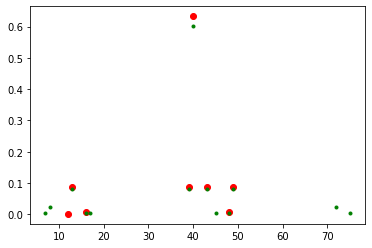

In [142]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [140]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(0.0033506886683872155-0.010471816146309017j)|2 2 1 1>
(-0.00293511367136729-0.03452471288506983j)|2 1 1 2>
(0.26615558266569905+0.127614721203146j)|2 1 1 1>
(0.026330131167650893-0.0022281947603430873j)|2 1 0 2>
(-0.07876392825808148-0.022966247407936936j)|2 1 0 1>
(0.026330131167650917-0.0022281947603435114j)|2 0 1 2>
(-0.009683297729539533-0.009808449317519377j)|2 0 1 1>
(0.0037766932832839642-0.0035616561832665537j)|2 0 1 0>
(-0.010089488419438658+0.0023252819402758726j)|2 0 0 2>
(0.012200547845027991+0.00020704997108901324j)|2 0 0 1>
(0.006132464010621815-0.0002685304775670343j)|1 2 0 1>
(0.0033506886683873525-0.01047181614630867j)|1 1 2 2>
(-0.0048962639464360524-0.004972008474904857j)|1 1 2 0>
(0.2661555826656993+0.1276147212031456j)|1 1 1 2>
(-0.7253245223952635-0.3268679835978546j)|1 1 1 1>
(-0.003218307009161053+0.003642738821225287j)|1 1 1 0>
(-0.009683297729540264-0.009808449317518349j)|1 1 0 2>
(0.2655719581828543+0.12775081794904625j)|1 1 0 1>
(-0.005076211117403334+0.012

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]
